<a href="https://colab.research.google.com/github/katha815/ADME-Classifier/blob/main/Different_ML_models_Thresholding_results_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Note:
Although the principle and logic of codes for all classifiers are shown here, the code excuted are slightly different (as the training data can be scaled or non-scaled, with and without population frequencies), due to the high number of these codes, they are not fully shown here.

## Initialization (base path defined)
Feature groups: (1)6 phastCons scores, (2)6 phyloP scores, (3)vepDistance, (4){A-C,A-G,A-T,C-A,...}categorical input, (5)Ensemble search consequence , (6)corresponding SIFT and Polyphen scores, (7) popoulation frequencies.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
!pip install scikit-optimize
import skopt
from skopt import BayesSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from skopt.space import Real, Categorical, Integer

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

## Test

In [ ]:
###ssh thres_gb.py
"""## Odata loading and testing/training split preparation"""
import csv
# Import data
# data2 = pd.read_csv("Odata_fzero.csv")
# # One hot encode with get_dummies
# print(f"Whole data: {data2}\n")
# Y = data2['Label']
# X = data2[[col for col in data2.columns if col!="Location1" and col!="Location2" and
#            col!="chr" and col!="Label" and col!="Ref" and col!="Alter"and col!="baseChange"]]
# print(X,'\n')
# pd.set_option('display.max_rows', None)  # Set the max_rows option to None to show all rows
# pd.set_option('display.max_columns', None)  # Set the max_columns option to None to show all columns
# print(X.dtypes,'\n')
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# print(Y,'\n')

# ## Prepare leave one chromosome out split indexes
# chrom_values = X['Chromo'].unique()
# grouped = X.groupby(['Chromo'])

# # Initialization
# datasplit = []
# labels = []
# combined_index = [None for _ in range(chrom_values.shape[0])]
# testlist = [None for _ in range(chrom_values.shape[0])]
# trainlist = [None for _ in range(chrom_values.shape[0])]

# # Extract info from grouped data
# for n in range(chrom_values.shape[0]):
#     chrom_i = chrom_values[n]
#     new_data = grouped.get_group(chrom_i)  # Generate random data
#     label = f"{chrom_i}"  # Generate label
#     datasplit.append(new_data)  # Store data
#     labels.append(label)  # Store label
# print(type(datasplit[0].index),np.shape(datasplit[0].index))
# print(datasplit[0].index.tolist())

# # Convert it to chromo label and chromo-splitted testing sets
# for i in range(len(labels)):
#     print(f"Chromosome: {labels[i]}:")
#     # print(f"Iteration: {i+1}\n")
#     # print(f"Data_index: {datasplit[i].index}")
#     print(f"Data_size: {len(datasplit[i])}")
#     testlist[i] = np.array(datasplit[i].index).tolist()
#     # print(f"Test size: {len(testlist[i])}\n")
#     print(f"Test indexes: {testlist[i]}\n")
#     # Label: {labels[i]}\n {type(testlist[i])}\n")

# # Always merge the shortest lists, make sure the minimum length<20
# while min(map(len, testlist)) < 20 and len(testlist) > 1:
#     idx1, idx2 = sorted(range(len(testlist)), key=lambda i: len(testlist[i]))[:2] #not including 2, so 0/1
#     print(testlist[idx1], testlist[idx2])
#     testlist[idx1] = testlist[idx1] + testlist[idx2]
#     testlist.pop(idx2)
# # Check merged-testing sets length:
# for x in testlist:
#     print(f"Test size: {len(x)};")

# # Validation list: order = order+1 for the testlist
# vlist = testlist[1:] + [testlist[0]]
# for x in vlist:
#     print(f"Validation size: {len(x)};")

# # Build training sets accordingly
# all = list(range(len(X)))
# # print(all)
# trainlist = []
# for i, test_indexes in enumerate(testlist):
#     train_indexes = np.array([index for index in all if index not in test_indexes])
#     trainlist.append(train_indexes)
# for x in trainlist:
#     print(f"Train size: {len(x)};")
#     # print(f"Train size: {len(trainlist[i])}\n")
#     # print(f"Train indexes: {trainlist[i]}\n {type(trainlist[i])}\n")

# updated_trainlist = []
# for i, test_indexes in enumerate(trainlist):
#     v_indexes = vlist[i]
#     updated_test_indexes = np.array([index for index in test_indexes if index not in v_indexes])
#     updated_trainlist.append(updated_test_indexes)
# for x in updated_trainlist:
#     print(f"Train size: {len(x)};")

# # Finalizing with scaling
# from sklearn.preprocessing import StandardScaler
# X = X.drop('Chromo', axis=1)
# X = np.array([X.values.tolist()]).reshape(X.shape[0],-1)
# Y = np.array([Y.values.tolist()]).reshape(X.shape[0],)
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

"""## Odata Thresholding"""

"""##### Proba reading initialization
"""

# def convert(pred_probs, thres):
#     converted_preds = np.empty(len(pred_probs), dtype=object)
#     # print(pred_probs)
#     for i in range(len(pred_probs)):
#         # print(pred_probs[i])
#         prob_class_0 = pred_probs[i][0]
#         prob_class_1 = pred_probs[i][1]
#         if prob_class_0 > thres:
#             converted_preds[i] = 0
#         elif prob_class_1 > thres:
#             converted_preds[i] = 1
#         else:
#             converted_preds[i] = np.nan
#     return converted_preds

# def prob_acc(y_test, preds, thres):
#     converted_preds = convert(preds, thres)
#     converted_preds = converted_preds#.tolist()
#     converted_preds = [float(pred) for pred in converted_preds]
#     # print(type(converted_preds[0]))
#     nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
#     # print(type(nan_indices),type(nan_indices[0]))
#     # print(nan_indices)
#     valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
#     # print(len(valid_converted_preds))
#     valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
#     # print("Test size: ", len(valid_y_test))
#     accuracy = accuracy_score(valid_y_test, valid_converted_preds)
#     omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
#     return accuracy, omitted_percentage

# def prob_auc(y_test, preds, thres):
#     converted_preds = convert(preds, thres)
#     converted_preds = converted_preds#.tolist()
#     converted_preds = [float(pred) for pred in converted_preds]
#     # print(type(converted_preds[0]))
#     nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
#     # print(type(nan_indices),type(nan_indices[0]))
#     # print(nan_indices)
#     valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
#     # print(len(valid_converted_preds))
#     valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
#     print("Test size: ", len(valid_y_test))
#     accuracy = 0
#     if len(valid_y_test) != 0:
#       accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
#     omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
#     return accuracy, omitted_percentage

# # Define model
# from sklearn.ensemble import GradientBoostingClassifier
# def create_gb_model(learning_rate, max_depth, n_estimators, min_samples_leaf,
#                     subsample,min_impurity_decrease, ccp_alpha):
#     model = GradientBoostingClassifier(
#         learning_rate=learning_rate,
#         max_depth=int(max_depth),
#         n_estimators=int(n_estimators),
#         min_samples_leaf=min_samples_leaf,
#         subsample=subsample,
#         min_impurity_decrease=min_impurity_decrease,
#         #gamma=gamma,
#         #alpha
#         ccp_alpha=ccp_alpha,
#         random_state=42
#     )
#     return model
# """#### XGboost Thresholding
# """
# """##### 20 Runs Error-bar - xg pop noS
# """

# ####################################################Odata pop noScaler#######################################################################
# import csv
# def read_csv(file_path):
#     data = []
#     with open(file_path, 'r', newline='') as csvfile:
#         csv_reader = csv.reader(csvfile)
#         for row in csv_reader:
#             # Convert elements from strings to integers (or other types if needed)
#             row_data = [element for element in row]
#             data.append(row_data)
#     return data
# import ast
# def convert_to_dict(entry):
#     ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
#     ordered_dict = ast.literal_eval(ordered_dict_str)
#     return dict(ordered_dict)

# converted_paras_ll = []
# for i in range(1, 21):
#   path = f"gb_odata_pop_noS/best_params_list_{i}.csv"
#   paras_l = read_csv(path)
#   paras_l = paras_l[0]
#   converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
#   converted_paras_ll.append(converted_paras_l)
# print(np.shape(converted_paras_ll))

# acc_w_tl_a = []
# acc_tl_a = []
# auc_tl_a = []
# o_p_tl_a = []
# for n_run in range(20):
#   print(f'%Run {n_run}')
#   acc_tl = []
#   acc_w_tl = []
#   auc_tl = []
#   o_p_tl = []
#   o_p_all = 0
#   thres = 0.51
#   converted_paras_l = converted_paras_ll[n_run]
#   while o_p_all < 90:
#     print(thres)
#     acc_scores = []
#     n = 1
#     yhat_all = []
#     ytrue_all = []
#     # o_p_l = []
#     for i in range(len(testlist)):
#       print(f"Fold {i}; ")
#       paras = converted_paras_l[i]
#       #1 Build training, validation and test sets/Extract individual index list
#       train_v_indexes = trainlist[i]
#       val_indexes = vlist[i]
#       test_indexes = testlist[i]
#       X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
#       X_test, y_test= X[test_indexes], Y[test_indexes]
#       # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
#       #     f"testing index: {len(test_indexes)}") #{test_indexes},

#       #2 Use train and validation indexes to create the custom split
#       # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
#       custom_split = [-1] * len(train_v_indexes)
#       for j, x in enumerate(train_v_indexes):
#         if x in val_indexes: custom_split[j] = 0
#       # Initialize the PredefinedSplit object
#       ps = PredefinedSplit(test_fold=custom_split)

#       #3 Create model with paras found by former BayesSearch
#       model = create_gb_model(**paras)
#       model.fit(X_train, y_train)
#       yhat = model.predict_proba(X_test)

#       #6 Calculate and store
#       acc, o_p = prob_acc(y_test, yhat, thres)
#       # auc = roc_auc_score(y_test, yhat)
#       acc_scores.append(acc)
#       # o_p_l.append(o_p)
#       ytrue_all.append(y_test)
#       yhat_all.append(yhat)
#       # auc_scores.append(auc)
#       # print("Iteration Accuray: {:.2f}%".format(100*acc))
#       # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
#       n+=1
#     # a+=0.001
#     thres = thres+0.01
#     #For one thres
#     #7 Results for all testing folds
#     # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
#     ytrue_all = np.concatenate(ytrue_all)
#     yhat_all= np.concatenate(yhat_all)
#     acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
#     auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
#     # Filter nan in acc
#     nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
#     acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
#     #
#     acc_ave = np.mean(acc_scores)
#     acc_w_tl.append(acc_w)
#     acc_tl.append(acc_ave)
#     auc_tl.append(auc)
#     o_p_tl.append(o_p_all)
#     print("Average Accuray: {:.2f}%".format(100*acc_ave))
#     print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
#         {:.2f}%".format(acc_w * 100, o_p_all))
#     print("Whole AUC: {:.4f}%".format(auc))
#   acc_w_tl_a.append(acc_w_tl)
#   acc_tl_a.append(acc_tl)
#   auc_tl_a.append(auc_tl)
#   o_p_tl_a.append(o_p_tl)
# print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

base_path1 = f"{base}gb_odata_pop_noS/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
                        # Eliminate nan
            import math
            row_data = [0 if math.isnan(x) else x for x in row_data]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value',size=14)
ax1.set_ylabel('Omitted percentage',color='b',size=14)
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (1 = 100%)',size=14)
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"{base}gb_o_pop_noS_thres.png",bbox_inches='tight')

####################################################Odata pop Scaler#######################################################################
# import csv
# def read_csv(file_path):
#     data = []
#     with open(file_path, 'r', newline='') as csvfile:
#         csv_reader = csv.reader(csvfile)
#         for row in csv_reader:
#             # Convert elements from strings to integers (or other types if needed)
#             row_data = [element for element in row]
#             data.append(row_data)
#     return data
# import ast
# def convert_to_dict(entry):
#     ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
#     ordered_dict = ast.literal_eval(ordered_dict_str)
#     return dict(ordered_dict)

# converted_paras_ll = []
# for i in range(1, 21):
#   path = f"gb_odata_pop/best_params_list_{i}.csv"
#   paras_l = read_csv(path)
#   paras_l = paras_l[0]
#   converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
#   converted_paras_ll.append(converted_paras_l)
# print(np.shape(converted_paras_ll))

# acc_w_tl_a = []
# acc_tl_a = []
# auc_tl_a = []
# o_p_tl_a = []
# for n_run in range(20):
#   print(f'%Run {n_run}')
#   acc_tl = []
#   acc_w_tl = []
#   auc_tl = []
#   o_p_tl = []
#   o_p_all = 0
#   thres = 0.51
#   converted_paras_l = converted_paras_ll[n_run]
#   while o_p_all < 90:
#     print(thres)
#     acc_scores = []
#     n = 1
#     yhat_all = []
#     ytrue_all = []
#     # o_p_l = []
#     for i in range(len(testlist)):
#       print(f"Fold {i}; ")
#       paras = converted_paras_l[i]
#       #1 Build training, validation and test sets/Extract individual index list
#       train_v_indexes = trainlist[i]
#       val_indexes = vlist[i]
#       test_indexes = testlist[i]
#       X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
#       X_test, y_test= X[test_indexes], Y[test_indexes]
#       # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
#       #     f"testing index: {len(test_indexes)}") #{test_indexes},

#       #2 Use train and validation indexes to create the custom split
#       # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
#       custom_split = [-1] * len(train_v_indexes)
#       for j, x in enumerate(train_v_indexes):
#         if x in val_indexes: custom_split[j] = 0
#       # Initialize the PredefinedSplit object
#       ps = PredefinedSplit(test_fold=custom_split)

#       #3 Create model with paras found by former BayesSearch
#       model = create_gb_model(**paras)
#       model.fit(X_train, y_train)
#       yhat = model.predict_proba(X_test)

#       #6 Calculate and store
#       acc, o_p = prob_acc(y_test, yhat, thres)
#       # auc = roc_auc_score(y_test, yhat)
#       acc_scores.append(acc)
#       # o_p_l.append(o_p)
#       ytrue_all.append(y_test)
#       yhat_all.append(yhat)
#       # auc_scores.append(auc)
#       # print("Iteration Accuray: {:.2f}%".format(100*acc))
#       # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
#       n+=1
#     # a+=0.001
#     thres = thres+0.01
#     #For one thres
#     #7 Results for all testing folds
#     # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
#     ytrue_all = np.concatenate(ytrue_all)
#     yhat_all= np.concatenate(yhat_all)
#     acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
#     auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
#     # Filter nan in acc
#     nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
#     acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
#     #
#     acc_ave = np.mean(acc_scores)
#     acc_w_tl.append(acc_w)
#     acc_tl.append(acc_ave)
#     auc_tl.append(auc)
#     o_p_tl.append(o_p_all)
#     print("Average Accuray: {:.2f}%".format(100*acc_ave))
#     print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
#         {:.2f}%".format(acc_w * 100, o_p_all))
#     print("Whole AUC: {:.4f}%".format(auc))
#   acc_w_tl_a.append(acc_w_tl)
#   acc_tl_a.append(acc_tl)
#   auc_tl_a.append(auc_tl)
#   o_p_tl_a.append(o_p_tl)
# print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

base_path1 = f"{base}gb_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
                        # Eliminate nan
            import math
            row_data = [0 if math.isnan(x) else x for x in row_data]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value',size=14)
ax1.set_ylabel('Omitted percentage',color='b',size=14)
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (1 = 100%)',size=14)
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"{base}gb_o_pop_thres.png",bbox_inches='tight')
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

####################################################Odata noP noScaler#######################################################################
# import csv
# def read_csv(file_path):
#     data = []
#     with open(file_path, 'r', newline='') as csvfile:
#         csv_reader = csv.reader(csvfile)
#         for row in csv_reader:
#             # Convert elements from strings to integers (or other types if needed)
#             row_data = [element for element in row]
#             data.append(row_data)
#     return data
# import ast
# def convert_to_dict(entry):
#     ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
#     ordered_dict = ast.literal_eval(ordered_dict_str)
#     return dict(ordered_dict)

# converted_paras_ll = []
# for i in range(1, 21):
#   path = f"gb_odata_noP_noS/best_params_list_{i}.csv"
#   paras_l = read_csv(path)
#   paras_l = paras_l[0]
#   converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
#   converted_paras_ll.append(converted_paras_l)
# print(np.shape(converted_paras_ll))

# acc_w_tl_a = []
# acc_tl_a = []
# auc_tl_a = []
# o_p_tl_a = []
# for n_run in range(20):
#   print(f'%Run {n_run}')
#   acc_tl = []
#   acc_w_tl = []
#   auc_tl = []
#   o_p_tl = []
#   o_p_all = 0
#   thres = 0.51
#   converted_paras_l = converted_paras_ll[n_run]
#   while o_p_all < 90:
#     print(thres)
#     acc_scores = []
#     n = 1
#     yhat_all = []
#     ytrue_all = []
#     # o_p_l = []
#     for i in range(len(testlist)):
#       print(f"Fold {i}; ")
#       paras = converted_paras_l[i]
#       #1 Build training, validation and test sets/Extract individual index list
#       train_v_indexes = trainlist[i]
#       val_indexes = vlist[i]
#       test_indexes = testlist[i]
#       X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
#       X_test, y_test= X[test_indexes], Y[test_indexes]
#       # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
#       #     f"testing index: {len(test_indexes)}") #{test_indexes},

#       #2 Use train and validation indexes to create the custom split
#       # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
#       custom_split = [-1] * len(train_v_indexes)
#       for j, x in enumerate(train_v_indexes):
#         if x in val_indexes: custom_split[j] = 0
#       # Initialize the PredefinedSplit object
#       ps = PredefinedSplit(test_fold=custom_split)

#       #3 Create model with paras found by former BayesSearch
#       model = create_gb_model(**paras)
#       model.fit(X_train, y_train)
#       yhat = model.predict_proba(X_test)

#       #6 Calculate and store
#       acc, o_p = prob_acc(y_test, yhat, thres)
#       # auc = roc_auc_score(y_test, yhat)
#       acc_scores.append(acc)
#       # o_p_l.append(o_p)
#       ytrue_all.append(y_test)
#       yhat_all.append(yhat)
#       # auc_scores.append(auc)
#       # print("Iteration Accuray: {:.2f}%".format(100*acc))
#       # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
#       n+=1
#     # a+=0.001
#     thres = thres+0.01
#     #For one thres
#     #7 Results for all testing folds
#     # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
#     ytrue_all = np.concatenate(ytrue_all)
#     yhat_all= np.concatenate(yhat_all)
#     acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
#     auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
#     # Filter nan in acc
#     nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
#     acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
#     #
#     acc_ave = np.mean(acc_scores)
#     acc_w_tl.append(acc_w)
#     acc_tl.append(acc_ave)
#     auc_tl.append(auc)
#     o_p_tl.append(o_p_all)
#     print("Average Accuray: {:.2f}%".format(100*acc_ave))
#     print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
#         {:.2f}%".format(acc_w * 100, o_p_all))
#     print("Whole AUC: {:.4f}%".format(auc))
#   acc_w_tl_a.append(acc_w_tl)
#   acc_tl_a.append(acc_tl)
#   auc_tl_a.append(auc_tl)
#   o_p_tl_a.append(o_p_tl)
# print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

base_path1 = f"{base}gb_odata_noP_noS/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
                        # Eliminate nan
            import math
            row_data = [0 if math.isnan(x) else x for x in row_data]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value',size=14)
ax1.set_ylabel('Omitted percentage',color='b',size=14)
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (1 = 100%)',size=14)
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"{base}gb_o_noP_noS_thres.png",bbox_inches='tight')

####################################################Odata noP Scaler#######################################################################
# import csv
# def read_csv(file_path):
#     data = []
#     with open(file_path, 'r', newline='') as csvfile:
#         csv_reader = csv.reader(csvfile)
#         for row in csv_reader:
#             # Convert elements from strings to integers (or other types if needed)
#             row_data = [element for element in row]
#             data.append(row_data)
#     return data
# import ast
# def convert_to_dict(entry):
#     ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
#     ordered_dict = ast.literal_eval(ordered_dict_str)
#     return dict(ordered_dict)

# converted_paras_ll = []
# for i in range(1, 21):
#   path = f"gb_odata_noP/best_params_list_{i}.csv"
#   paras_l = read_csv(path)
#   paras_l = paras_l[0]
#   converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
#   converted_paras_ll.append(converted_paras_l)
# print(np.shape(converted_paras_ll))

# acc_w_tl_a = []
# acc_tl_a = []
# auc_tl_a = []
# o_p_tl_a = []
# for n_run in range(20):
#   print(f'%Run {n_run}')
#   acc_tl = []
#   acc_w_tl = []
#   auc_tl = []
#   o_p_tl = []
#   o_p_all = 0
#   thres = 0.51
#   converted_paras_l = converted_paras_ll[n_run]
#   while o_p_all < 90:
#     print(thres)
#     acc_scores = []
#     n = 1
#     yhat_all = []
#     ytrue_all = []
#     # o_p_l = []
#     for i in range(len(testlist)):
#       print(f"Fold {i}; ")
#       paras = converted_paras_l[i]
#       #1 Build training, validation and test sets/Extract individual index list
#       train_v_indexes = trainlist[i]
#       val_indexes = vlist[i]
#       test_indexes = testlist[i]
#       X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
#       X_test, y_test= X[test_indexes], Y[test_indexes]
#       # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
#       #     f"testing index: {len(test_indexes)}") #{test_indexes},

#       #2 Use train and validation indexes to create the custom split
#       # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
#       custom_split = [-1] * len(train_v_indexes)
#       for j, x in enumerate(train_v_indexes):
#         if x in val_indexes: custom_split[j] = 0
#       # Initialize the PredefinedSplit object
#       ps = PredefinedSplit(test_fold=custom_split)

#       #3 Create model with paras found by former BayesSearch
#       model = create_gb_model(**paras)
#       model.fit(X_train, y_train)
#       yhat = model.predict_proba(X_test)

#       #6 Calculate and store
#       acc, o_p = prob_acc(y_test, yhat, thres)
#       # auc = roc_auc_score(y_test, yhat)
#       acc_scores.append(acc)
#       # o_p_l.append(o_p)
#       ytrue_all.append(y_test)
#       yhat_all.append(yhat)
#       # auc_scores.append(auc)
#       # print("Iteration Accuray: {:.2f}%".format(100*acc))
#       # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
#       n+=1
#     # a+=0.001
#     thres = thres+0.01
#     #For one thres
#     #7 Results for all testing folds
#     # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
#     ytrue_all = np.concatenate(ytrue_all)
#     yhat_all= np.concatenate(yhat_all)
#     acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
#     auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
#     # Filter nan in acc
#     nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
#     acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
#     #
#     acc_ave = np.mean(acc_scores)
#     acc_w_tl.append(acc_w)
#     acc_tl.append(acc_ave)
#     auc_tl.append(auc)
#     o_p_tl.append(o_p_all)
#     print("Average Accuray: {:.2f}%".format(100*acc_ave))
#     print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
#         {:.2f}%".format(acc_w * 100, o_p_all))
#     print("Whole AUC: {:.4f}%".format(auc))
#   acc_w_tl_a.append(acc_w_tl)
#   acc_tl_a.append(acc_tl)
#   auc_tl_a.append(auc_tl)
#   o_p_tl_a.append(o_p_tl)
# print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

base_path1 = f"{base}gb_odata_noP/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
                        # Eliminate nan
            import math
            row_data = [0 if math.isnan(x) else x for x in row_data]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value',size=14)
ax1.set_ylabel('Omitted percentage',color='b',size=14)
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (1 = 100%)',size=14)
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"{base}gb_o_noP_thres.png",bbox_inches='tight')

In [ ]:
## ssh thres_gb_gkb.py

"""## Odata loading and testing/training split preparation"""

# Import data
# data2 = pd.read_csv("GKBdata_fzero.csv")
# # One hot encode with get_dummies
# print(f"Whole data: {data2}\n")
# Y = data2['Label']
# X = data2[[col for col in data2.columns if col!="Location1" and col!="Location2" and
#            col!="Chromo" and col!="Label" and col!="Ref" and col!="Alter"and col!="baseChange"]]
# print(X,'\n')
# pd.set_option('display.max_rows', None)  # Set the max_rows option to None to show all rows
# pd.set_option('display.max_columns', None)  # Set the max_columns option to None to show all columns
# print(X.dtypes,'\n')
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# print(Y,'\n')

# ## Prepare leave one chromosome out split indexes
# chrom_values = X['chr'].unique()
# grouped = X.groupby(['chr'])

# # Initialization
# datasplit = []
# labels = []
# combined_index = [None for _ in range(chrom_values.shape[0])]
# testlist = [None for _ in range(chrom_values.shape[0])]
# trainlist = [None for _ in range(chrom_values.shape[0])]

# # Extract info from grouped data
# for n in range(chrom_values.shape[0]):
#     chrom_i = chrom_values[n]
#     new_data = grouped.get_group(chrom_i)  # Generate random data
#     label = f"{chrom_i}"  # Generate label
#     datasplit.append(new_data)  # Store data
#     labels.append(label)  # Store label
# print(type(datasplit[0].index),np.shape(datasplit[0].index))
# print(datasplit[0].index.tolist())

# # Convert it to chromo label and chromo-splitted testing sets
# for i in range(len(labels)):
#     print(f"Chromosome: {labels[i]}:")
#     # print(f"Iteration: {i+1}\n")
#     # print(f"Data_index: {datasplit[i].index}")
#     print(f"Data_size: {len(datasplit[i])}")
#     testlist[i] = np.array(datasplit[i].index).tolist()
#     # print(f"Test size: {len(testlist[i])}\n")
#     print(f"Test indexes: {testlist[i]}\n")
#     # Label: {labels[i]}\n {type(testlist[i])}\n")

# # Always merge the shortest lists, make sure the minimum length<20
# while min(map(len, testlist)) < 20 and len(testlist) > 1:
#     idx1, idx2 = sorted(range(len(testlist)), key=lambda i: len(testlist[i]))[:2] #not including 2, so 0/1
#     print(testlist[idx1], testlist[idx2])
#     testlist[idx1] = testlist[idx1] + testlist[idx2]
#     testlist.pop(idx2)
# # Check merged-testing sets length:
# for x in testlist:
#     print(f"Test size: {len(x)};")

# # Validation list: order = order+1 for the testlist
# vlist = testlist[1:] + [testlist[0]]
# for x in vlist:
#     print(f"Validation size: {len(x)};")

# # Build training sets accordingly
# all = list(range(len(X)))
# # print(all)
# trainlist = []
# for i, test_indexes in enumerate(testlist):
#     train_indexes = np.array([index for index in all if index not in test_indexes])
#     trainlist.append(train_indexes)
# for x in trainlist:
#     print(f"Train size: {len(x)};")
#     # print(f"Train size: {len(trainlist[i])}\n")
#     # print(f"Train indexes: {trainlist[i]}\n {type(trainlist[i])}\n")

# updated_trainlist = []
# for i, test_indexes in enumerate(trainlist):
#     v_indexes = vlist[i]
#     updated_test_indexes = np.array([index for index in test_indexes if index not in v_indexes])
#     updated_trainlist.append(updated_test_indexes)
# for x in updated_trainlist:
#     print(f"Train size: {len(x)};")

# # Finalizing with scaling
# from sklearn.preprocessing import StandardScaler
# X = X.drop('chr', axis=1)
# X = np.array([X.values.tolist()]).reshape(X.shape[0],-1)
# Y = np.array([Y.values.tolist()]).reshape(X.shape[0],)
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

"""## Odata Thresholding"""

"""##### Proba reading initialization
"""

# def convert(pred_probs, thres):
#     converted_preds = np.empty(len(pred_probs), dtype=object)
#     # print(pred_probs)
#     for i in range(len(pred_probs)):
#         # print(pred_probs[i])
#         prob_class_0 = pred_probs[i][0]
#         prob_class_1 = pred_probs[i][1]
#         if prob_class_0 > thres:
#             converted_preds[i] = 0
#         elif prob_class_1 > thres:
#             converted_preds[i] = 1
#         else:
#             converted_preds[i] = np.nan
#     return converted_preds

# def prob_acc(y_test, preds, thres):
#     converted_preds = convert(preds, thres)
#     converted_preds = converted_preds#.tolist()
#     converted_preds = [float(pred) for pred in converted_preds]
#     # print(type(converted_preds[0]))
#     nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
#     # print(type(nan_indices),type(nan_indices[0]))
#     # print(nan_indices)
#     valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
#     # print(len(valid_converted_preds))
#     valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
#     # print("Test size: ", len(valid_y_test))
#     accuracy = accuracy_score(valid_y_test, valid_converted_preds)
#     omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
#     return accuracy, omitted_percentage

# def prob_auc(y_test, preds, thres):
#     converted_preds = convert(preds, thres)
#     converted_preds = converted_preds#.tolist()
#     converted_preds = [float(pred) for pred in converted_preds]
#     # print(type(converted_preds[0]))
#     nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
#     # print(type(nan_indices),type(nan_indices[0]))
#     # print(nan_indices)
#     valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
#     # print(len(valid_converted_preds))
#     valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
#     print("Test size: ", len(valid_y_test))
#     accuracy = 0
#     if len(valid_y_test) != 0:
#       accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
#     omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
#     return accuracy, omitted_percentage

# # Define model
# from sklearn.ensemble import GradientBoostingClassifier
# def create_gb_model(learning_rate, max_depth, n_estimators, min_samples_leaf,
#                     subsample,min_impurity_decrease, ccp_alpha):
#     model = GradientBoostingClassifier(
#         learning_rate=learning_rate,
#         max_depth=int(max_depth),
#         n_estimators=int(n_estimators),
#         min_samples_leaf=min_samples_leaf,
#         subsample=subsample,
#         min_impurity_decrease=min_impurity_decrease,
#         #gamma=gamma,
#         #alpha
#         ccp_alpha=ccp_alpha,
#         random_state=42
#     )
#     return model
"""#### XGboost Thresholding
"""
"""##### 20 Runs Error-bar - xg pop noS
"""

####################################################Odata pop noScaler#######################################################################
# import csv
# def read_csv(file_path):
#     data = []
#     with open(file_path, 'r', newline='') as csvfile:
#         csv_reader = csv.reader(csvfile)
#         for row in csv_reader:
#             # Convert elements from strings to integers (or other types if needed)
#             row_data = [element for element in row]
#             data.append(row_data)
#     return data
# import ast
# def convert_to_dict(entry):
#     ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
#     ordered_dict = ast.literal_eval(ordered_dict_str)
#     return dict(ordered_dict)

# converted_paras_ll = []
# for i in range(1, 21):
#   path = f"gb_gkb_pop_noS/best_params_list_{i}.csv"
#   paras_l = read_csv(path)
#   paras_l = paras_l[0]
#   converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
#   converted_paras_ll.append(converted_paras_l)
# print(np.shape(converted_paras_ll))

# acc_w_tl_a = []
# acc_tl_a = []
# auc_tl_a = []
# o_p_tl_a = []
# for n_run in range(20):
#   print(f'%Run {n_run}')
#   acc_tl = []
#   acc_w_tl = []
#   auc_tl = []
#   o_p_tl = []
#   o_p_all = 0
#   thres = 0.51
#   converted_paras_l = converted_paras_ll[n_run]
#   while o_p_all < 90:
#     print(thres)
#     acc_scores = []
#     n = 1
#     yhat_all = []
#     ytrue_all = []
#     # o_p_l = []
#     for i in range(len(testlist)):
#       print(f"Fold {i}; ")
#       paras = converted_paras_l[i]
#       #1 Build training, validation and test sets/Extract individual index list
#       train_v_indexes = trainlist[i]
#       val_indexes = vlist[i]
#       test_indexes = testlist[i]
#       X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
#       X_test, y_test= X[test_indexes], Y[test_indexes]
#       # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
#       #     f"testing index: {len(test_indexes)}") #{test_indexes},

#       #2 Use train and validation indexes to create the custom split
#       # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
#       custom_split = [-1] * len(train_v_indexes)
#       for j, x in enumerate(train_v_indexes):
#         if x in val_indexes: custom_split[j] = 0
#       # Initialize the PredefinedSplit object
#       ps = PredefinedSplit(test_fold=custom_split)

#       #3 Create model with paras found by former BayesSearch
#       model = create_gb_model(**paras)
#       model.fit(X_train, y_train)
#       yhat = model.predict_proba(X_test)

#       #6 Calculate and store
#       acc, o_p = prob_acc(y_test, yhat, thres)
#       # auc = roc_auc_score(y_test, yhat)
#       acc_scores.append(acc)
#       # o_p_l.append(o_p)
#       ytrue_all.append(y_test)
#       yhat_all.append(yhat)
#       # auc_scores.append(auc)
#       # print("Iteration Accuray: {:.2f}%".format(100*acc))
#       # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
#       n+=1
#     # a+=0.001
#     thres = thres+0.01
#     #For one thres
#     #7 Results for all testing folds
#     # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
#     ytrue_all = np.concatenate(ytrue_all)
#     yhat_all= np.concatenate(yhat_all)
#     acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
#     auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
#     # Filter nan in acc
#     nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
#     acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
#     #
#     acc_ave = np.mean(acc_scores)
#     acc_w_tl.append(acc_w)
#     acc_tl.append(acc_ave)
#     auc_tl.append(auc)
#     o_p_tl.append(o_p_all)
#     print("Average Accuray: {:.2f}%".format(100*acc_ave))
#     print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
#         {:.2f}%".format(acc_w * 100, o_p_all))
#     print("Whole AUC: {:.4f}%".format(auc))
#   acc_w_tl_a.append(acc_w_tl)
#   acc_tl_a.append(acc_tl)
#   auc_tl_a.append(auc_tl)
#   o_p_tl_a.append(o_p_tl)
# print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

base_path1 = f"{base}gb_gkb_pop_noS/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
                        # Eliminate nan
            import math
            row_data = [0 if math.isnan(x) else x for x in row_data]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value',size=14)
ax1.set_ylabel('Omitted percentage',color='b',size=14)
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (1 = 100%)',size=14)
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"{base}gb_gkb_pop_noS_thres.png",bbox_inches='tight')

# ####################################################Odata pop Scaler#######################################################################
# import csv
# def read_csv(file_path):
#     data = []
#     with open(file_path, 'r', newline='') as csvfile:
#         csv_reader = csv.reader(csvfile)
#         for row in csv_reader:
#             # Convert elements from strings to integers (or other types if needed)
#             row_data = [element for element in row]
#             data.append(row_data)
#     return data
# import ast
# def convert_to_dict(entry):
#     ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
#     ordered_dict = ast.literal_eval(ordered_dict_str)
#     return dict(ordered_dict)

# converted_paras_ll = []
# for i in range(1, 21):
#   path = f"gb_gkb_pop/best_params_list_{i}.csv"
#   paras_l = read_csv(path)
#   paras_l = paras_l[0]
#   converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
#   converted_paras_ll.append(converted_paras_l)
# print(np.shape(converted_paras_ll))

# acc_w_tl_a = []
# acc_tl_a = []
# auc_tl_a = []
# o_p_tl_a = []
# for n_run in range(20):
#   print(f'%Run {n_run}')
#   acc_tl = []
#   acc_w_tl = []
#   auc_tl = []
#   o_p_tl = []
#   o_p_all = 0
#   thres = 0.51
#   converted_paras_l = converted_paras_ll[n_run]
#   while o_p_all < 90:
#     print(thres)
#     acc_scores = []
#     n = 1
#     yhat_all = []
#     ytrue_all = []
#     # o_p_l = []
#     for i in range(len(testlist)):
#       print(f"Fold {i}; ")
#       paras = converted_paras_l[i]
#       #1 Build training, validation and test sets/Extract individual index list
#       train_v_indexes = trainlist[i]
#       val_indexes = vlist[i]
#       test_indexes = testlist[i]
#       X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
#       X_test, y_test= X[test_indexes], Y[test_indexes]
#       # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
#       #     f"testing index: {len(test_indexes)}") #{test_indexes},

#       #2 Use train and validation indexes to create the custom split
#       # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
#       custom_split = [-1] * len(train_v_indexes)
#       for j, x in enumerate(train_v_indexes):
#         if x in val_indexes: custom_split[j] = 0
#       # Initialize the PredefinedSplit object
#       ps = PredefinedSplit(test_fold=custom_split)

#       #3 Create model with paras found by former BayesSearch
#       model = create_gb_model(**paras)
#       model.fit(X_train, y_train)
#       yhat = model.predict_proba(X_test)

#       #6 Calculate and store
#       acc, o_p = prob_acc(y_test, yhat, thres)
#       # auc = roc_auc_score(y_test, yhat)
#       acc_scores.append(acc)
#       # o_p_l.append(o_p)
#       ytrue_all.append(y_test)
#       yhat_all.append(yhat)
#       # auc_scores.append(auc)
#       # print("Iteration Accuray: {:.2f}%".format(100*acc))
#       # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
#       n+=1
#     # a+=0.001
#     thres = thres+0.01
#     #For one thres
#     #7 Results for all testing folds
#     # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
#     ytrue_all = np.concatenate(ytrue_all)
#     yhat_all= np.concatenate(yhat_all)
#     acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
#     auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
#     # Filter nan in acc
#     nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
#     acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
#     #
#     acc_ave = np.mean(acc_scores)
#     acc_w_tl.append(acc_w)
#     acc_tl.append(acc_ave)
#     auc_tl.append(auc)
#     o_p_tl.append(o_p_all)
#     print("Average Accuray: {:.2f}%".format(100*acc_ave))
#     print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
#         {:.2f}%".format(acc_w * 100, o_p_all))
#     print("Whole AUC: {:.4f}%".format(auc))
#   acc_w_tl_a.append(acc_w_tl)
#   acc_tl_a.append(acc_tl)
#   auc_tl_a.append(auc_tl)
#   o_p_tl_a.append(o_p_tl)
# print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

base_path1 = f"{base}gb_gkb_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
                        # Eliminate nan
            import math
            row_data = [0 if math.isnan(x) else x for x in row_data]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value',size=14)
ax1.set_ylabel('Omitted percentage',color='b',size=14)
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (1 = 100%)',size=14)
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"{base}gb_gkb_pop_thres.png",bbox_inches='tight')

####################################################Odata noP noScaler#######################################################################
# import csv
# def read_csv(file_path):
#     data = []
#     with open(file_path, 'r', newline='') as csvfile:
#         csv_reader = csv.reader(csvfile)
#         for row in csv_reader:
#             # Convert elements from strings to integers (or other types if needed)
#             row_data = [element for element in row]
#             data.append(row_data)
#     return data
# import ast
# def convert_to_dict(entry):
#     ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
#     ordered_dict = ast.literal_eval(ordered_dict_str)
#     return dict(ordered_dict)

# converted_paras_ll = []
# for i in range(1, 21):
#   path = f"gb_gkb_noP_noS/best_params_list_{i}.csv"
#   paras_l = read_csv(path)
#   paras_l = paras_l[0]
#   converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
#   converted_paras_ll.append(converted_paras_l)
# print(np.shape(converted_paras_ll))

# acc_w_tl_a = []
# acc_tl_a = []
# auc_tl_a = []
# o_p_tl_a = []
# for n_run in range(20):
#   print(f'%Run {n_run}')
#   acc_tl = []
#   acc_w_tl = []
#   auc_tl = []
#   o_p_tl = []
#   o_p_all = 0
#   thres = 0.51
#   converted_paras_l = converted_paras_ll[n_run]
#   while o_p_all < 90:
#     print(thres)
#     acc_scores = []
#     n = 1
#     yhat_all = []
#     ytrue_all = []
#     # o_p_l = []
#     for i in range(len(testlist)):
#       print(f"Fold {i}; ")
#       paras = converted_paras_l[i]
#       #1 Build training, validation and test sets/Extract individual index list
#       train_v_indexes = trainlist[i]
#       val_indexes = vlist[i]
#       test_indexes = testlist[i]
#       X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
#       X_test, y_test= X[test_indexes], Y[test_indexes]
#       # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
#       #     f"testing index: {len(test_indexes)}") #{test_indexes},

#       #2 Use train and validation indexes to create the custom split
#       # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
#       custom_split = [-1] * len(train_v_indexes)
#       for j, x in enumerate(train_v_indexes):
#         if x in val_indexes: custom_split[j] = 0
#       # Initialize the PredefinedSplit object
#       ps = PredefinedSplit(test_fold=custom_split)

#       #3 Create model with paras found by former BayesSearch
#       model = create_gb_model(**paras)
#       model.fit(X_train, y_train)
#       yhat = model.predict_proba(X_test)

#       #6 Calculate and store
#       acc, o_p = prob_acc(y_test, yhat, thres)
#       # auc = roc_auc_score(y_test, yhat)
#       acc_scores.append(acc)
#       # o_p_l.append(o_p)
#       ytrue_all.append(y_test)
#       yhat_all.append(yhat)
#       # auc_scores.append(auc)
#       # print("Iteration Accuray: {:.2f}%".format(100*acc))
#       # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
#       n+=1
#     # a+=0.001
#     thres = thres+0.01
#     #For one thres
#     #7 Results for all testing folds
#     # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
#     ytrue_all = np.concatenate(ytrue_all)
#     yhat_all= np.concatenate(yhat_all)
#     acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
#     auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
#     # Filter nan in acc
#     nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
#     acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
#     #
#     acc_ave = np.mean(acc_scores)
#     acc_w_tl.append(acc_w)
#     acc_tl.append(acc_ave)
#     auc_tl.append(auc)
#     o_p_tl.append(o_p_all)
#     print("Average Accuray: {:.2f}%".format(100*acc_ave))
#     print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
#         {:.2f}%".format(acc_w * 100, o_p_all))
#     print("Whole AUC: {:.4f}%".format(auc))
#   acc_w_tl_a.append(acc_w_tl)
#   acc_tl_a.append(acc_tl)
#   auc_tl_a.append(auc_tl)
#   o_p_tl_a.append(o_p_tl)
# print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

base_path1 = f"{base}gb_gkb_noP_noS/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
                        # Eliminate nan
            import math
            row_data = [0 if math.isnan(x) else x for x in row_data]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value',size=14)
ax1.set_ylabel('Omitted percentage',color='b',size=14)
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (1 = 100%)',size=14)
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"{base}gb_gkb_noP_noS_thres.png",bbox_inches='tight')

####################################################Odata noP Scaler#######################################################################
# import csv
# def read_csv(file_path):
#     data = []
#     with open(file_path, 'r', newline='') as csvfile:
#         csv_reader = csv.reader(csvfile)
#         for row in csv_reader:
#             # Convert elements from strings to integers (or other types if needed)
#             row_data = [element for element in row]
#             data.append(row_data)
#     return data
# import ast
# def convert_to_dict(entry):
#     ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
#     ordered_dict = ast.literal_eval(ordered_dict_str)
#     return dict(ordered_dict)

# converted_paras_ll = []
# for i in range(1, 21):
#   path = f"gb_gkb_noP/best_params_list_{i}.csv"
#   paras_l = read_csv(path)
#   paras_l = paras_l[0]
#   converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
#   converted_paras_ll.append(converted_paras_l)
# print(np.shape(converted_paras_ll))

# acc_w_tl_a = []
# acc_tl_a = []
# auc_tl_a = []
# o_p_tl_a = []
# for n_run in range(20):
#   print(f'%Run {n_run}')
#   acc_tl = []
#   acc_w_tl = []
#   auc_tl = []
#   o_p_tl = []
#   o_p_all = 0
#   thres = 0.51
#   converted_paras_l = converted_paras_ll[n_run]
#   while o_p_all < 90:
#     print(thres)
#     acc_scores = []
#     n = 1
#     yhat_all = []
#     ytrue_all = []
#     # o_p_l = []
#     for i in range(len(testlist)):
#       print(f"Fold {i}; ")
#       paras = converted_paras_l[i]
#       #1 Build training, validation and test sets/Extract individual index list
#       train_v_indexes = trainlist[i]
#       val_indexes = vlist[i]
#       test_indexes = testlist[i]
#       X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
#       X_test, y_test= X[test_indexes], Y[test_indexes]
#       # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
#       #     f"testing index: {len(test_indexes)}") #{test_indexes},

#       #2 Use train and validation indexes to create the custom split
#       # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
#       custom_split = [-1] * len(train_v_indexes)
#       for j, x in enumerate(train_v_indexes):
#         if x in val_indexes: custom_split[j] = 0
#       # Initialize the PredefinedSplit object
#       ps = PredefinedSplit(test_fold=custom_split)

#       #3 Create model with paras found by former BayesSearch
#       model = create_gb_model(**paras)
#       model.fit(X_train, y_train)
#       yhat = model.predict_proba(X_test)

#       #6 Calculate and store
#       acc, o_p = prob_acc(y_test, yhat, thres)
#       # auc = roc_auc_score(y_test, yhat)
#       acc_scores.append(acc)
#       # o_p_l.append(o_p)
#       ytrue_all.append(y_test)
#       yhat_all.append(yhat)
#       # auc_scores.append(auc)
#       # print("Iteration Accuray: {:.2f}%".format(100*acc))
#       # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
#       n+=1
#     # a+=0.001
#     thres = thres+0.01
#     #For one thres
#     #7 Results for all testing folds
#     # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
#     ytrue_all = np.concatenate(ytrue_all)
#     yhat_all= np.concatenate(yhat_all)
#     acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
#     auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
#     # Filter nan in acc
#     nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
#     acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
#     #
#     acc_ave = np.mean(acc_scores)
#     acc_w_tl.append(acc_w)
#     acc_tl.append(acc_ave)
#     auc_tl.append(auc)
#     o_p_tl.append(o_p_all)
#     print("Average Accuray: {:.2f}%".format(100*acc_ave))
#     print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
#         {:.2f}%".format(acc_w * 100, o_p_all))
#     print("Whole AUC: {:.4f}%".format(auc))
#   acc_w_tl_a.append(acc_w_tl)
#   acc_tl_a.append(acc_tl)
#   auc_tl_a.append(auc_tl)
#   o_p_tl_a.append(o_p_tl)
# print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

base_path1 = f"{base}gb_gkb_noP/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
                        # Eliminate nan
            import math
            row_data = [0 if math.isnan(x) else x for x in row_data]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value',size=14)
ax1.set_ylabel('Omitted percentage',color='b',size=14)
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (1 = 100%)',size=14)
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"{base}gb_gkb_noP_thres.png",bbox_inches='tight')

## Odata loading and testing/training split preparation

In [ ]:
# Import data
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/Odata_fzero.csv")
# One hot encode with get_dummies
print(f"Whole data: {data2}\n")
Y = data2['Label']
X = data2[[col for col in data2.columns if col!="Location1" and col!="Location2" and
           col!="chr" and col!="Label" and col!="Ref" and col!="Alter"and col!="baseChange"]]
print(X,'\n')
pd.set_option('display.max_rows', None)  # Set the max_rows option to None to show all rows
pd.set_option('display.max_columns', None)  # Set the max_columns option to None to show all columns
print(X.dtypes,'\n')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
print(Y,'\n')

Whole data:     Chromo  Location1  Location2 Ref Alter  Label  chr  transcript_ablation  \
0     chr1   46930150   46930150   C     T      1    1                    0   
1     chr1   46930161   46930161   G     A      1    1                    0   
2     chr1   46932824   46932824   T     C      1    1                    0   
3     chr1   46932987   46932987   C     T      1    1                    0   
4     chr1   46934207   46934207   A     G      0    1                    0   
..     ...        ...        ...  ..   ...    ...  ...                  ...   
329  chr22   42129836   42129836   C     T      0   22                    0   
330  chr22   42130692   42130692   C     T      1   22                    0   
331  chr22   42130710   42130710   C     T      0   22                    0   
332  chr22   42130715   42130715   G     A      1   22                    0   
333  chr22   42130761   42130761   G     A      1   22                    0   

     splice_acceptor_variant  splice_do

In [ ]:
## Prepare leave one chromosome out split indexes
chrom_values = X['Chromo'].unique()
grouped = X.groupby(['Chromo'])

# Initialization
datasplit = []
labels = []
combined_index = [None for _ in range(chrom_values.shape[0])]
testlist = [None for _ in range(chrom_values.shape[0])]
trainlist = [None for _ in range(chrom_values.shape[0])]

# Extract info from grouped data
for n in range(chrom_values.shape[0]):
    chrom_i = chrom_values[n]
    new_data = grouped.get_group(chrom_i)  # Generate random data
    label = f"{chrom_i}"  # Generate label
    datasplit.append(new_data)  # Store data
    labels.append(label)  # Store label
print(type(datasplit[0].index),np.shape(datasplit[0].index))
print(datasplit[0].index.tolist())

# Convert it to chromo label and chromo-splitted testing sets
for i in range(len(labels)):
    print(f"Chromosome: {labels[i]}:")
    # print(f"Iteration: {i+1}\n")
    # print(f"Data_index: {datasplit[i].index}")
    print(f"Data_size: {len(datasplit[i])}")
    testlist[i] = np.array(datasplit[i].index).tolist()
    # print(f"Test size: {len(testlist[i])}\n")
    print(f"Test indexes: {testlist[i]}\n")
    # Label: {labels[i]}\n {type(testlist[i])}\n")

# Always merge the shortest lists, make sure the minimum length<20
while min(map(len, testlist)) < 20 and len(testlist) > 1:
    idx1, idx2 = sorted(range(len(testlist)), key=lambda i: len(testlist[i]))[:2] #not including 2, so 0/1
    print(testlist[idx1], testlist[idx2])
    testlist[idx1] = testlist[idx1] + testlist[idx2]
    testlist.pop(idx2)
# Check merged-testing sets length:
for x in testlist:
    print(f"Test size: {len(x)};")

# Validation list: order = order+1 for the testlist
vlist = testlist[1:] + [testlist[0]]
for x in vlist:
    print(f"Validation size: {len(x)};")

# Build training sets accordingly
all = list(range(len(X)))
# print(all)
trainlist = []
for i, test_indexes in enumerate(testlist):
    train_indexes = np.array([index for index in all if index not in test_indexes])
    trainlist.append(train_indexes)
for x in trainlist:
    print(f"Train size: {len(x)};")
    # print(f"Train size: {len(trainlist[i])}\n")
    # print(f"Train indexes: {trainlist[i]}\n {type(trainlist[i])}\n")

<class 'pandas.core.indexes.numeric.Int64Index'> (18,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Chromosome: chr1:
Data_size: 18
Test indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

Chromosome: chr2:
Data_size: 28
Test indexes: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

Chromosome: chr3:
Data_size: 8
Test indexes: [46, 47, 48, 49, 50, 51, 52, 53]

Chromosome: chr4:
Data_size: 8
Test indexes: [54, 55, 56, 57, 58, 59, 60, 61]

Chromosome: chr6:
Data_size: 42
Test indexes: [62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]

Chromosome: chr7:
Data_size: 11
Test indexes: [104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]

Chromosome: chr8:
Data_size: 29
Test indexes: [115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,

In [ ]:
updated_trainlist = []
for i, test_indexes in enumerate(trainlist):
    v_indexes = vlist[i]
    updated_test_indexes = np.array([index for index in test_indexes if index not in v_indexes])
    updated_trainlist.append(updated_test_indexes)
for x in updated_trainlist:
    print(f"Train size: {len(x)};")

Train size: 264;
Train size: 263;
Train size: 276;
Train size: 218;
Train size: 227;
Train size: 280;
Train size: 270;
Train size: 269;
Train size: 271;


In [ ]:
# Finalizing with scaling
from sklearn.preprocessing import StandardScaler
X = X.drop('Chromo', axis=1)
X = np.array([X.values.tolist()]).reshape(X.shape[0],-1)
Y = np.array([Y.values.tolist()]).reshape(X.shape[0],)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

## Odata Thresholding

##### Proba reading/XGBoost initialization

In [ ]:
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print("Test size: ", len(valid_y_test))
    accuracy = 0
    if len(valid_y_test) != 0:
      accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    print("Test size: ", len(valid_y_test))
    accuracy = 0
    if len(valid_y_test) != 0:
      accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

# Define XGBoost model hyperparameters grid
def create_xgboost_model(learning_rate, max_depth, n_estimators, min_child_weight, subsample, gamma, reg_alpha):
    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        min_child_weight=min_child_weight,
        subsample=subsample,
        gamma=gamma,
        reg_alpha=reg_alpha,
        objective='binary:logistic',
        random_state=42
    )
    return model # in data loading, X is already scaled
    # make_pipeline(StandardScaler(),model) # From early results, scaler gives more consistent/stable results.
    # model = make_pipeline(StandardScaler(), XGBClassifier(objective='binary:logistic', random_state=0))

# # Define the hyperparameter search space
# param_space = {
#     'learning_rate': (0.01, 1.0, 'log-uniform'),
#     'max_depth': (1, 10),
#     'n_estimators': (50, 1000),
#     'min_child_weight': (1, 10),
#     'subsample': (0.1, 1.0, 'uniform'),
#     'gamma': (0.01, 1.0, 'uniform'),
#     'reg_alpha': (0.01, 1.0, 'uniform')
# }

#### XGboost Thresholding

##### Plot

In [ ]:
fig, ax1 = plt.subplots()
x_lim = np.linspace(0.51,thres,(len(o_p_tl)))
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

Conclusion: the middle drops means that the high thresholding region has considerable mis-predictions.

##### 20 Runs Error-bar - xg odata pop noS

In [ ]:
# Collect data from 20 runs and test different thresholds
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_ll = []
for i in range(1, 21):
  path = f"{base}xg1_odata_pop/best_params_list_{i}.csv"
  paras_l = read_csv(path)
  paras_l = paras_l[0]
  converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
  converted_paras_ll.append(converted_paras_l)
print(np.shape(converted_paras_ll))

(20, 9)


In [ ]:
acc_w_tl_a = []
acc_tl_a = []
auc_tl_a = []
o_p_tl_a = []
for n_run in range(20):
  print(f'%Run {n_run}')
  acc_tl = []
  acc_w_tl = []
  auc_tl = []
  o_p_tl = []
  o_p_all = 0
  thres = 0.51
  converted_paras_l = converted_paras_ll[n_run]
  while o_p_all < 90:
    print(thres)
    acc_scores = []
    n = 1
    yhat_all = []
    ytrue_all = []
    # o_p_l = []
    for i in range(len(testlist)):
      print(f"Fold {i}; ")
      paras = converted_paras_l[i]
      #1 Build training, validation and test sets/Extract individual index list
      train_v_indexes = trainlist[i]
      val_indexes = vlist[i]
      test_indexes = testlist[i]
      X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
      X_test, y_test= X[test_indexes], Y[test_indexes]
      # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      #     f"testing index: {len(test_indexes)}") #{test_indexes},

      #2 Use train and validation indexes to create the custom split
      # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
      custom_split = [-1] * len(train_v_indexes)
      for j, x in enumerate(train_v_indexes):
        if x in val_indexes: custom_split[j] = 0
      # Initialize the PredefinedSplit object
      ps = PredefinedSplit(test_fold=custom_split)

      #3 Create model with paras found by former BayesSearch
      model = create_xgboost_model(**paras)
      model.fit(X_train, y_train)
      yhat = model.predict_proba(X_test)

      #6 Calculate and store
      acc, o_p = prob_acc(y_test, yhat, thres)
      # auc = roc_auc_score(y_test, yhat)
      acc_scores.append(acc)
      # o_p_l.append(o_p)
      ytrue_all.append(y_test)
      yhat_all.append(yhat)
      # auc_scores.append(auc)
      # print("Iteration Accuray: {:.2f}%".format(100*acc))
      # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
      n+=1
    # a+=0.001
    thres = thres+0.01
    #For one thres
    #7 Results for all testing folds
    # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
    ytrue_all = np.concatenate(ytrue_all)
    yhat_all= np.concatenate(yhat_all)
    acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
    auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
    # Filter nan in acc
    nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
    acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
    #
    acc_ave = np.mean(acc_scores)
    acc_w_tl.append(acc_w)
    acc_tl.append(acc_ave)
    auc_tl.append(auc)
    o_p_tl.append(o_p_all)
    print("Average Accuray: {:.2f}%".format(100*acc_ave))
    print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
        {:.2f}%".format(acc_w * 100, o_p_all))
    print("Whole AUC: {:.4f}%".format(auc))
  acc_w_tl_a.append(acc_w_tl)
  acc_tl_a.append(acc_tl)
  auc_tl_a.append(auc_tl)
  o_p_tl_a.append(o_p_tl)
print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

%Run 0
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  322
Average Accuray: 66.17%
Whole Accuracy: 66.46%, Percentage of Data Omitted:         3.59%
Whole AUC: 0.6554%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  314
Average Accuray: 66.51%
Whole Accuracy: 66.24%, Percentage of Data Omitted:         5.99%
Whole AUC: 0.6519%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  306
Average Accuray: 66.53%
Whole Accuracy: 66.01%, Percentage of Data Omitted:         8.38%
Whole AUC: 0.6507%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  293
Average Accuray: 66.35%
Whole Accuracy: 66.89%, Percentage of Data Omitted:         12.28%
Whole AUC: 0.6604%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  286
Average Accuray: 68.08%
Whole Accuracy: 66.78%

KeyboardInterrupt: ignored

In [ ]:
base_path1 = f"{base}gb1_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

In [ ]:
l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

In [ ]:
l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

In [ ]:
l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

In [ ]:
l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

In [ ]:
# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Show and save
plt.show()
fig.savefig(f"{base}xg_odata_pop_noS_thres.png",bbox="tight")

##### 20 Runs Error-bar - xg S

In [ ]:
# Collect data from 20 runs and test different thresholds
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_ll = []
for i in range(1, 21):
  path = f"{base}xg2_odata_pop/best_params_list_{i}.csv"
  paras_l = read_csv(path)
  paras_l = paras_l[0]
  converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
  converted_paras_ll.append(converted_paras_l)
print(np.shape(converted_paras_ll))

In [ ]:
acc_w_tl_a = []
acc_tl_a = []
auc_tl_a = []
o_p_tl_a = []
for n_run in range(20):
  print(f'%Run {n_run}')
  acc_tl = []
  acc_w_tl = []
  auc_tl = []
  o_p_tl = []
  o_p_all = 0
  thres = 0.51
  converted_paras_l = converted_paras_ll[n_run]
  while o_p_all < 90:
    print(thres)
    acc_scores = []
    n = 1
    yhat_all = []
    ytrue_all = []
    # o_p_l = []
    for i in range(len(testlist)):
      print(f"Fold {i}; ")
      paras = converted_paras_l[i]
      #1 Build training, validation and test sets/Extract individual index list
      train_v_indexes = trainlist[i]
      val_indexes = vlist[i]
      test_indexes = testlist[i]
      X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
      X_test, y_test= X[test_indexes], Y[test_indexes]
      # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      #     f"testing index: {len(test_indexes)}") #{test_indexes},

      #2 Use train and validation indexes to create the custom split
      # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
      custom_split = [-1] * len(train_v_indexes)
      for j, x in enumerate(train_v_indexes):
        if x in val_indexes: custom_split[j] = 0
      # Initialize the PredefinedSplit object
      ps = PredefinedSplit(test_fold=custom_split)

      #3 Create model with paras found by former BayesSearch
      model = create_gb_model(**paras)
      model.fit(X_train, y_train)
      yhat = model.predict_proba(X_test)

      #6 Calculate and store
      acc, o_p = prob_acc(y_test, yhat, thres)
      # auc = roc_auc_score(y_test, yhat)
      acc_scores.append(acc)
      # o_p_l.append(o_p)
      ytrue_all.append(y_test)
      yhat_all.append(yhat)
      # auc_scores.append(auc)
      # print("Iteration Accuray: {:.2f}%".format(100*acc))
      # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
      n+=1
    # a+=0.001
    thres = thres+0.01
    #For one thres
    #7 Results for all testing folds
    # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
    ytrue_all = np.concatenate(ytrue_all)
    yhat_all= np.concatenate(yhat_all)
    acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
    auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
    # Filter nan in acc
    nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
    acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
    #
    acc_ave = np.mean(acc_scores)
    acc_w_tl.append(acc_w)
    acc_tl.append(acc_ave)
    auc_tl.append(auc)
    o_p_tl.append(o_p_all)
    print("Average Accuray: {:.2f}%".format(100*acc_ave))
    print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
        {:.2f}%".format(acc_w * 100, o_p_all))
    print("Whole AUC: {:.4f}%".format(auc))
  acc_w_tl_a.append(acc_w_tl)
  acc_tl_a.append(acc_tl)
  auc_tl_a.append(auc_tl)
  o_p_tl_a.append(o_p_tl)
print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

In [ ]:
base_path1 = f"{base}gb1_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

In [ ]:
l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

In [ ]:
l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

In [ ]:
l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

In [ ]:
l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

In [ ]:
# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Show and save
plt.show()
fig.savefig(f"{base}gb_noS_thres.png")

###### Scatter plot

In [ ]:
# Scatter plot (Since the error is too small to show)
fig, ax1 = plt.subplots()

# Plot the first dataset with error bars
for y in o_p_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax1.scatter(x, y, color='b',s=1)

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with the same y-axis
for y in acc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='r',s=1)
for y in acc_w_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='g',s=1)
for y in auc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='y',s=1)

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

Todos: transfer y sets to draw error bar curves

#### GB Thresholding

##### Load predictions/best parameters

In [ ]:
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
path = f"{base}gb1_odata_pop/best_params_list_3.csv"
paras_l = read_csv(path)
paras_l = paras_l[0]
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
converted_paras_l

##### Model Initiliazation

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from skopt.space import Real, Categorical, Integer
# reg = GradientBoostingClassifier(random_state=0)
# Define XGBoost model hyperparameters grid
def create_gb_model(learning_rate, max_depth, n_estimators, min_samples_leaf,
                    subsample,min_impurity_decrease, ccp_alpha):
    model = GradientBoostingClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        min_impurity_decrease=min_impurity_decrease,
        #gamma=gamma,
        #alpha
        ccp_alpha=ccp_alpha,
        random_state=42
    )
    return model

##### Test with different thres

In [ ]:
acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
thres = 0.51
while o_p_all < 90:
  print(thres)
  acc_scores = []
  n = 1
  yhat_all = []
  ytrue_all = []
  # o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    #     f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for j, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[j] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model with paras found by former BayesSearch
    model = create_gb_model(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    # o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    if o_p == 100:
      print('Omitted percent: 100%')
    # print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
    n+=1
  # a+=0.001
  thres+=0.01
  #For one thres
  #7 Results for all testing folds
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter nan in acc
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

In [ ]:
fig, ax1 = plt.subplots()
x_lim = np.linspace(0.51,thres,(len(o_p_tl)))
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

# ax4.set_ylabel('Running time (seconds)',color='r')
# ax4.tick_params(axis='y',labelcolor='r')

Conclusion: similarly...

##### 20 Runs Error-bar - gb noS

In [ ]:
# Collect data from 20 runs and test different thresholds
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_ll = []
for i in range(1, 21):
  path = f"{base}gb1_odata_pop/best_params_list_{i}.csv"
  paras_l = read_csv(path)
  paras_l = paras_l[0]
  converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
  converted_paras_ll.append(converted_paras_l)
print(np.shape(converted_paras_ll))

In [ ]:
acc_w_tl_a = []
acc_tl_a = []
auc_tl_a = []
o_p_tl_a = []
for n_run in range(20):
  print(f'%Run {n_run}')
  acc_tl = []
  acc_w_tl = []
  auc_tl = []
  o_p_tl = []
  o_p_all = 0
  thres = 0.51
  converted_paras_l = converted_paras_ll[n_run]
  while o_p_all < 90:
    print(thres)
    acc_scores = []
    n = 1
    yhat_all = []
    ytrue_all = []
    # o_p_l = []
    for i in range(len(testlist)):
      print(f"Fold {i}; ")
      paras = converted_paras_l[i]
      #1 Build training, validation and test sets/Extract individual index list
      train_v_indexes = trainlist[i]
      val_indexes = vlist[i]
      test_indexes = testlist[i]
      X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
      X_test, y_test= X[test_indexes], Y[test_indexes]
      # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      #     f"testing index: {len(test_indexes)}") #{test_indexes},

      #2 Use train and validation indexes to create the custom split
      # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
      custom_split = [-1] * len(train_v_indexes)
      for j, x in enumerate(train_v_indexes):
        if x in val_indexes: custom_split[j] = 0
      # Initialize the PredefinedSplit object
      ps = PredefinedSplit(test_fold=custom_split)

      #3 Create model with paras found by former BayesSearch
      model = create_gb_model(**paras)
      model.fit(X_train, y_train)
      yhat = model.predict_proba(X_test)

      #6 Calculate and store
      acc, o_p = prob_acc(y_test, yhat, thres)
      # auc = roc_auc_score(y_test, yhat)
      acc_scores.append(acc)
      # o_p_l.append(o_p)
      ytrue_all.append(y_test)
      yhat_all.append(yhat)
      # auc_scores.append(auc)
      # print("Iteration Accuray: {:.2f}%".format(100*acc))
      # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
      n+=1
    # a+=0.001
    thres = thres+0.01
    #For one thres
    #7 Results for all testing folds
    # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
    ytrue_all = np.concatenate(ytrue_all)
    yhat_all= np.concatenate(yhat_all)
    acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
    auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
    # Filter nan in acc
    nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
    acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
    #
    acc_ave = np.mean(acc_scores)
    acc_w_tl.append(acc_w)
    acc_tl.append(acc_ave)
    auc_tl.append(auc)
    o_p_tl.append(o_p_all)
    print("Average Accuray: {:.2f}%".format(100*acc_ave))
    print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
        {:.2f}%".format(acc_w * 100, o_p_all))
    print("Whole AUC: {:.4f}%".format(auc))
  acc_w_tl_a.append(acc_w_tl)
  acc_tl_a.append(acc_tl)
  auc_tl_a.append(auc_tl)
  o_p_tl_a.append(o_p_tl)
print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

In [ ]:
base_path1 = f"{base}gb1_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

In [ ]:
l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

In [ ]:
l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

In [ ]:
l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

In [ ]:
l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

In [ ]:
# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Show and save
plt.show()
fig.savefig(f"{base}gb_noS_thres.png")

###### Scatter plot

In [ ]:
# Scatter plot (Since the error is too small to show)
fig, ax1 = plt.subplots()

# Plot the first dataset with error bars
for y in o_p_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax1.scatter(x, y, color='b',s=1)

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with the same y-axis
for y in acc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='r',s=1)
for y in acc_w_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='g',s=1)
for y in auc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='y',s=1)

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

Todos: transfer y sets to draw error bar curves

##### 20 Runs Error-bar - gb S

In [ ]:
# Collect data from 20 runs and test different thresholds
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_ll = []
for i in range(1, 21):
  path = f"{base}gb2_odata_pop/best_params_list_{i}.csv"
  paras_l = read_csv(path)
  paras_l = paras_l[0]
  converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
  converted_paras_ll.append(converted_paras_l)
print(np.shape(converted_paras_ll))

In [ ]:
acc_w_tl_a = []
acc_tl_a = []
auc_tl_a = []
o_p_tl_a = []
for n_run in range(20):
  print(f'%Run {n_run}')
  acc_tl = []
  acc_w_tl = []
  auc_tl = []
  o_p_tl = []
  o_p_all = 0
  thres = 0.51
  converted_paras_l = converted_paras_ll[n_run]
  while o_p_all < 90:
    print(thres)
    acc_scores = []
    n = 1
    yhat_all = []
    ytrue_all = []
    # o_p_l = []
    for i in range(len(testlist)):
      print(f"Fold {i}; ")
      paras = converted_paras_l[i]
      #1 Build training, validation and test sets/Extract individual index list
      train_v_indexes = trainlist[i]
      val_indexes = vlist[i]
      test_indexes = testlist[i]
      X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
      X_test, y_test= X[test_indexes], Y[test_indexes]
      # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      #     f"testing index: {len(test_indexes)}") #{test_indexes},

      #2 Use train and validation indexes to create the custom split
      # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
      custom_split = [-1] * len(train_v_indexes)
      for j, x in enumerate(train_v_indexes):
        if x in val_indexes: custom_split[j] = 0
      # Initialize the PredefinedSplit object
      ps = PredefinedSplit(test_fold=custom_split)

      #3 Create model with paras found by former BayesSearch
      model = create_gb_model(**paras)
      model.fit(X_train, y_train)
      yhat = model.predict_proba(X_test)

      #6 Calculate and store
      acc, o_p = prob_acc(y_test, yhat, thres)
      # auc = roc_auc_score(y_test, yhat)
      acc_scores.append(acc)
      # o_p_l.append(o_p)
      ytrue_all.append(y_test)
      yhat_all.append(yhat)
      # auc_scores.append(auc)
      # print("Iteration Accuray: {:.2f}%".format(100*acc))
      # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
      n+=1
    # a+=0.001
    thres = thres+0.01
    #For one thres
    #7 Results for all testing folds
    # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
    ytrue_all = np.concatenate(ytrue_all)
    yhat_all= np.concatenate(yhat_all)
    acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
    auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
    # Filter nan in acc
    nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
    acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
    #
    acc_ave = np.mean(acc_scores)
    acc_w_tl.append(acc_w)
    acc_tl.append(acc_ave)
    auc_tl.append(auc)
    o_p_tl.append(o_p_all)
    print("Average Accuray: {:.2f}%".format(100*acc_ave))
    print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
        {:.2f}%".format(acc_w * 100, o_p_all))
    print("Whole AUC: {:.4f}%".format(auc))
  acc_w_tl_a.append(acc_w_tl)
  acc_tl_a.append(acc_tl)
  auc_tl_a.append(auc_tl)
  o_p_tl_a.append(o_p_tl)
print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

In [ ]:
base_path1 = f"{base}svm_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

In [ ]:
l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

In [ ]:
l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

In [ ]:
l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

In [ ]:
l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

In [ ]:
# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Show and save
plt.show()
fig.savefig(f"{base}gb_S_thres.png")

###### Scatter plot

In [ ]:
# Scatter plot (Since the error is too small to show)
fig, ax1 = plt.subplots()

# Plot the first dataset with error bars
for y in o_p_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax1.scatter(x, y, color='b',s=1)

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with the same y-axis
for y in acc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='r',s=1)
for y in acc_w_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='g',s=1)
for y in auc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='y',s=1)

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

Todos: transfer y sets to draw error bar curves

In [ ]:
l = max(map(o_p_tl_a,len))

#### Baye Thresholding

##### Load predictions/best parameters

In [ ]:
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
path = f"{base}baye_odata_pop/best_params_0.csv"
paras_l = read_csv(path)
paras_l = paras_l[0]
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
converted_paras_l

##### Baye Initiliazation

In [ ]:
from sklearn.naive_bayes import GaussianNB
import csv

##### Test with different thres

In [ ]:
from sklearn.model_selection import PredefinedSplit
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
a_l = []
a = 0
n = 1
while o_p_all < 90:
  a = a + 9*10**(-n)
  a_l.append(a)
  print(f"Threshold setting {n}: {a}")
  thres = np.log(a)
  acc_scores = []
  yhat_all = []
  ytrue_all = []
  o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
        f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for i, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[i] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model and optimise by BayesSearch
    model = GaussianNB(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_log_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))

  """Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
  #7 Results for all testing folds
  n+=1
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter acc_scores
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

In [ ]:
fig, ax1 = plt.subplots()
x_lim = a_l
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

In [ ]:
# Focus on thres lower than 0.999

acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
a_l = []
a = 0.900
n = 1
while a < 0.999:
  a = a + 0.001
  a_l.append(a)
  print(f"Threshold setting {n}: {a}")
  thres = np.log(a)
  acc_scores = []
  yhat_all = []
  ytrue_all = []
  o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
        f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for i, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[i] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model and optimise by BayesSearch
    model = GaussianNB(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_log_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))

  """Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
  #7 Results for all testing folds
  n+=1
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter acc_scores
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

In [ ]:
fig, ax1 = plt.subplots()
x_lim = a_l
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

##### Display ssh run results - baye_odata_pop 20 run error bar

In [ ]:
base_path1 = f"{base}baye_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
# x = np.linspace(0.51,0.51+0.01*l,l)
a = 0
n = 1
a_l = []
for i in range(len(y0)):
    a = a + 9*10**(-n)
    a_l.append(a)
    n+=1
x = a_l
# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"baye_o_pop_thres.png")

##### Display ssh run results - baye_odata_noP 20 run error bar

In [ ]:
base_path1 = f"{base}baye_odata_noP/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]
print(err0)

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]
print(err1)

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]
print(err2)

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]
print(err3)

# X-axis
# x = np.linspace(0.51,0.51+0.01*l,l)
a = 0
n = 1
a_l = []
for i in range(len(y0)):
    a = a + 9*10**(-n)
    a_l.append(a)
    n+=1
x = a_l
# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"baye_o_noP_thres.png")

##### Display ssh run results - baye_gkb_noP 20 run error bar

In [ ]:
base_path1 = f"{base}baye_gkb_noP/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
                        # Eliminate nan
            import math
            row_data = [0 if math.isnan(x) else x for x in row_data]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
# x = np.linspace(0.51,0.51+0.01*l,l)
a = 0
n = 1
a_l = []
for i in range(len(y0)):
    a = a + 9*10**(-n)
    a_l.append(a)
    n+=1
x = a_l
# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"baye_gkb_noP_thres.png")

##### Display ssh run results - baye_gkb_pop 20 run error bar

In [ ]:
base_path1 = f"{base}baye_gkb_pop/"
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
                        # Eliminate nan
            import math
            row_data = [0 if math.isnan(x) else x for x in row_data]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
# x = np.linspace(0.51,0.51+0.01*l,l)
a = 0
n = 1
a_l = []
for i in range(len(y0)):
    a = a + 9*10**(-n)
    a_l.append(a)
    n+=1
x = a_l
# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"baye_gkb_pop_thres.png")

#####by_o_pop_thres2

In [ ]:
base_path1 = f"{base}baye_odata_pop/"
# ## Read/save functions
# def write_to_csv(file_path, data):
#     with open(file_path, 'w', newline='') as csvfile:
#         csv_writer = csv.writer(csvfile)
#         for row in data:
#             csv_writer.writerow(row)

# # path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
# def read_csv(file_path):
#     data = []
#     with open(file_path, 'r', newline='') as csvfile:
#         csv_reader = csv.reader(csvfile)
#         for row in csv_reader:
#             # Convert elements from strings to integers (or other types if needed)
#             row_data = [float(element) for element in row]
#                         # Eliminate nan
#             import math
#             row_data = [0 if math.isnan(x) else x for x in row_data]
#             data.append(row_data)
#     return data
# write_to_csv(f"{base_path1}acc_tl_a2.csv", acc_tl_a2)
# write_to_csv(f"{base_path1}acc_w_tl_a2.csv", acc_w_tl_a2)
# write_to_csv(f"{base_path1}auc_tl_a2.csv", auc_tl_a2)
# write_to_csv(f"{base_path1}o_p_tl_a2.csv", o_p_tl_a2)

data0 = read_csv(f"{base_path1}1.csv")
data1 = read_csv(f"{base_path1}acc_tl_a2.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a2.csv")
data3 = read_csv(f"{base_path1}auc_tl_a2.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_a2rr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_a2rr]
err0 = [np.std(x) for x in data0p_a2rr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_a2rr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_a2rr]
err1 = [np.std(x) for x in data1p_a2rr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_a2rr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_a2rr]
err2 = [np.std(x) for x in data2p_a2rr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_a2rr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_a2rr]
err3 = [np.std(x) for x in data3p_a2rr]

# X-axis
# x = np.linspace(0.51,0.51+0.01*l,l)
a = 0.900
a_l = []
for i in range(len(y0)):
  a = a + 0.001
  a_l.append(a)
x = a_l
# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_A2UC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
ax1.set_ylim(0, 100)
ax2.set_ylim(0.6,0.9)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"baye_o_pop_thres2.png")

In [ ]:
import pandas as pd
path = '/content/gdrive/My Drive/Colab Notebooks/ADME Project/baye_odata_pop/Book1.csv'
pd = pd.read_csv(path)
pd

#### SVM Thresholding

##### Load predictions/best parameters

In [ ]:
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
path = f"{base}svm_odata_pop/best_params_0.csv"
paras_l = read_csv(path)
paras_l = paras_l[0]
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
converted_paras_l

[{'C': 0.3620906421529484,
  'coef0': 0,
  'degree': 0,
  'gamma': 'auto',
  'kernel': 'rbf'},
 {'C': 0.5442221914438296,
  'coef0': 0,
  'degree': 0,
  'gamma': 'auto',
  'kernel': 'rbf'},
 {'C': 0.6920688000840138,
  'coef0': 0,
  'degree': 0,
  'gamma': 'scale',
  'kernel': 'rbf'},
 {'C': 0.34120717222466485,
  'coef0': 0,
  'degree': 0,
  'gamma': 'auto',
  'kernel': 'rbf'},
 {'C': 11.512382623755922,
  'coef0': 0,
  'degree': 0,
  'gamma': 'auto',
  'kernel': 'rbf'},
 {'C': 1.6451952786248198,
  'coef0': 0,
  'degree': 0,
  'gamma': 'scale',
  'kernel': 'rbf'},
 {'C': 0.35080851204640545,
  'coef0': 0,
  'degree': 0,
  'gamma': 'auto',
  'kernel': 'rbf'},
 {'C': 10.698558451857489,
  'coef0': 0,
  'degree': 0,
  'gamma': 'scale',
  'kernel': 'rbf'},
 {'C': 5869.0366212499985,
  'coef0': 0,
  'degree': 0,
  'gamma': 'auto',
  'kernel': 'rbf'}]

##### Model Initiliazation

In [ ]:
from sklearn.svm import SVC
from skopt.space import Real, Categorical, Integer

def create_svm_model(C,kernel,gamma,degree,coef0):#, gamma, coef0kernel, degree, coef0=coef0,
   model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma,
               coef0=coef0, probability=True, random_state=42)#degree=degree,
   return model

##### Test with different thres

In [ ]:
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    print(len(valid_y_test))
    accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
thres = 0.51
while o_p_all < 90:
  print(thres)
  acc_scores = []
  n = 1
  yhat_all = []
  ytrue_all = []
  # o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    #     f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for j, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[j] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model with paras found by former BayesSearch
    model = create_svm_model(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    # o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    # print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
    n+=1
  # a+=0.001
  thres+=0.01
  #For one thres
  #7 Results for all testing folds
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter nan in acc
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

In [ ]:
fig, ax1 = plt.subplots()
x_lim = np.linspace(0.51,thres,(len(o_p_tl)))
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

# ax4.set_ylabel('Running time (seconds)',color='r')
# ax4.tick_params(axis='y',labelcolor='r')

Conclusion: similarly...

##### 20 Runs Error-bar: svm_pop

In [ ]:
# Collect data from 20 runs and test different thresholds
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_ll = []
for i in range(20):
  path = f"{base}svm_odata_pop/best_params_{i}.csv"
  paras_l = read_csv(path)
  paras_l = paras_l[0]
  converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
  converted_paras_ll.append(converted_paras_l)
print(np.shape(converted_paras_ll))

In [ ]:
acc_w_tl_a = []
acc_tl_a = []
auc_tl_a = []
o_p_tl_a = []
for n_run in range(20):
  print(f'%Run {n_run}')
  acc_tl = []
  acc_w_tl = []
  auc_tl = []
  o_p_tl = []
  o_p_all = 0
  thres = 0.51
  converted_paras_l = converted_paras_ll[n_run]
  while o_p_all < 90:
    print(thres)
    acc_scores = []
    n = 1
    yhat_all = []
    ytrue_all = []
    # o_p_l = []
    for i in range(len(testlist)):
      print(f"Fold {i}; ")
      paras = converted_paras_l[i]
      #1 Build training, validation and test sets/Extract individual index list
      train_v_indexes = trainlist[i]
      val_indexes = vlist[i]
      test_indexes = testlist[i]
      X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
      X_test, y_test= X[test_indexes], Y[test_indexes]
      # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      #     f"testing index: {len(test_indexes)}") #{test_indexes},

      #2 Use train and validation indexes to create the custom split
      # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
      custom_split = [-1] * len(train_v_indexes)
      for j, x in enumerate(train_v_indexes):
        if x in val_indexes: custom_split[j] = 0
      # Initialize the PredefinedSplit object
      ps = PredefinedSplit(test_fold=custom_split)

      #3 Create model with paras found by former BayesSearch
      model = create_svm_model(**paras)
      model.fit(X_train, y_train)
      yhat = model.predict_proba(X_test)

      #6 Calculate and store
      acc, o_p = prob_acc(y_test, yhat, thres)
      # auc = roc_auc_score(y_test, yhat)
      acc_scores.append(acc)
      # o_p_l.append(o_p)
      ytrue_all.append(y_test)
      yhat_all.append(yhat)
      # auc_scores.append(auc)
      # print("Iteration Accuray: {:.2f}%".format(100*acc))
      # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
      n+=1
    # a+=0.001
    thres = thres+0.01
    #For one thres
    #7 Results for all testing folds
    # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
    ytrue_all = np.concatenate(ytrue_all)
    yhat_all= np.concatenate(yhat_all)
    acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
    auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
    # Filter nan in acc
    nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
    acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
    #
    acc_ave = np.mean(acc_scores)
    acc_w_tl.append(acc_w)
    acc_tl.append(acc_ave)
    auc_tl.append(auc)
    o_p_tl.append(o_p_all)
    print("Average Accuray: {:.2f}%".format(100*acc_ave))
    print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
        {:.2f}%".format(acc_w * 100, o_p_all))
    print("Whole AUC: {:.4f}%".format(auc))
  acc_w_tl_a.append(acc_w_tl)
  acc_tl_a.append(acc_tl)
  auc_tl_a.append(auc_tl)
  o_p_tl_a.append(o_p_tl)
print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

In [ ]:
base_path1 = f"{base}svm_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

In [ ]:
for x in data0:
  print(x)

In [ ]:
l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))

In [ ]:
data0p_arr = np.array(data0p)
print(np.shape(data0p_arr))
y0 = [np.mean(x) for x in data0p_arr]
print(np.shape(y0))
print(y0)
err0 = [np.std(x) for x in data0p_arr]
print(np.shape(err0))
print(err0)

In [ ]:
l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

In [ ]:
l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

In [ ]:
l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

In [ ]:
# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

###### Scatter plot

In [ ]:
# Scatter plot (Since the error is too small to show)
fig, ax1 = plt.subplots()

# Plot the first dataset with error bars
for y in o_p_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax1.scatter(x, y, color='b',s=1)

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with the same y-axis
for y in acc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='r',s=1)
for y in acc_w_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='g',s=1)
for y in auc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='y',s=1)

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

Todos: transfer y sets to draw error bar curves

In [ ]:
l = max(map(o_p_tl_a,len))

##### 20 Runs Error-bar: svm_noP

In [ ]:
# Collect data from 20 runs and test different thresholds
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_ll = []
for i in range(20):
  path = f"{base}svm_odata_noP/best_params_{i}.csv"
  paras_l = read_csv(path)
  paras_l = paras_l[0]
  converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
  converted_paras_ll.append(converted_paras_l)
print(np.shape(converted_paras_ll))

In [ ]:
acc_w_tl_a = []
acc_tl_a = []
auc_tl_a = []
o_p_tl_a = []
for n_run in range(20):
  print(f'%Run {n_run}')
  acc_tl = []
  acc_w_tl = []
  auc_tl = []
  o_p_tl = []
  o_p_all = 0
  thres = 0.51
  converted_paras_l = converted_paras_ll[n_run]
  while o_p_all < 90:
    print(thres)
    acc_scores = []
    n = 1
    yhat_all = []
    ytrue_all = []
    # o_p_l = []
    for i in range(len(testlist)):
      print(f"Fold {i}; ")
      paras = converted_paras_l[i]
      #1 Build training, validation and test sets/Extract individual index list
      train_v_indexes = trainlist[i]
      val_indexes = vlist[i]
      test_indexes = testlist[i]
      X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
      X_test, y_test= X[test_indexes], Y[test_indexes]
      # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      #     f"testing index: {len(test_indexes)}") #{test_indexes},

      #2 Use train and validation indexes to create the custom split
      # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
      custom_split = [-1] * len(train_v_indexes)
      for j, x in enumerate(train_v_indexes):
        if x in val_indexes: custom_split[j] = 0
      # Initialize the PredefinedSplit object
      ps = PredefinedSplit(test_fold=custom_split)

      #3 Create model with paras found by former BayesSearch
      model = create_svm_model(**paras)
      model.fit(X_train, y_train)
      yhat = model.predict_proba(X_test)

      #6 Calculate and store
      acc, o_p = prob_acc(y_test, yhat, thres)
      # auc = roc_auc_score(y_test, yhat)
      acc_scores.append(acc)
      # o_p_l.append(o_p)
      ytrue_all.append(y_test)
      yhat_all.append(yhat)
      # auc_scores.append(auc)
      # print("Iteration Accuray: {:.2f}%".format(100*acc))
      # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
      n+=1
    # a+=0.001
    thres = thres+0.01
    #For one thres
    #7 Results for all testing folds
    # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
    ytrue_all = np.concatenate(ytrue_all)
    yhat_all= np.concatenate(yhat_all)
    acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
    auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
    # Filter nan in acc
    nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
    acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
    #
    acc_ave = np.mean(acc_scores)
    acc_w_tl.append(acc_w)
    acc_tl.append(acc_ave)
    auc_tl.append(auc)
    o_p_tl.append(o_p_all)
    print("Average Accuray: {:.2f}%".format(100*acc_ave))
    print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
        {:.2f}%".format(acc_w * 100, o_p_all))
    print("Whole AUC: {:.4f}%".format(auc))
  acc_w_tl_a.append(acc_w_tl)
  acc_tl_a.append(acc_tl)
  auc_tl_a.append(auc_tl)
  o_p_tl_a.append(o_p_tl)
print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

In [ ]:
base_path1 = f"{base}svm_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

In [ ]:
for x in data0:
  print(x)

In [ ]:
l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))

In [ ]:
data0p_arr = np.array(data0p)
print(np.shape(data0p_arr))
y0 = [np.mean(x) for x in data0p_arr]
print(np.shape(y0))
print(y0)
err0 = [np.std(x) for x in data0p_arr]
print(np.shape(err0))
print(err0)

In [ ]:
l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

In [ ]:
l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

In [ ]:
l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

In [ ]:
# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Show and save
plt.show()
fig.savefig(f"{base}gb_S_thres.png")

###### Scatter plot

In [ ]:
# Scatter plot (Since the error is too small to show)
fig, ax1 = plt.subplots()

# Plot the first dataset with error bars
for y in o_p_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax1.scatter(x, y, color='b',s=1)

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with the same y-axis
for y in acc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='r',s=1)
for y in acc_w_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='g',s=1)
for y in auc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='y',s=1)

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

Todos: transfer y sets to draw error bar curves

In [ ]:
l = max(map(o_p_tl_a,len))

## GKBdata loading and testing/training split preparation

In [ ]:
# Import data
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/GKBdata_fzero.csv")
# One hot encode with get_dummies
print(f"Whole data: {data2}\n")
Y = data2['Label']
X = data2[[col for col in data2.columns if col!="Location1" and col!="Location2"
           and col!="Label" and col!="Ref" and col!="Alter"and col!="baseChange"]]
print(X,'\n')
pd.set_option('display.max_rows', None)  # Set the max_rows option to None to show all rows
pd.set_option('display.max_columns', None)  # Set the max_columns option to None to show all columns
print(X.dtypes,'\n')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
print(Y,'\n')

Whole data:      chr  Location1 Ref Alter  transcript_ablation  splice_acceptor_variant  \
0      1   97057448   G     A                    0                        0   
1      1   97073844   G     A                    0                        0   
2      1   97077914   T     C                    0                        0   
3      1   97078076   A     G                    0                        0   
4      1   97078196   G     A                    0                        0   
..   ...        ...  ..   ...                  ...                      ...   
695   22   42129033   C     T                    0                        0   
696   22   42130692   G     A                    0                        0   
697   22   42130718   C     T                    0                        0   
698   22   42131289   G     T                    0                        0   
699   22   42132375   G     C                    0                        0   

     splice_donor_variant  stop_gained 

In [ ]:
## Prepare leave one chromosome out split indexes
chrom_values = X['chr'].unique()
grouped = X.groupby(['chr'])

# Initialization
datasplit = []
labels = []
combined_index = [None for _ in range(chrom_values.shape[0])]
testlist = [None for _ in range(chrom_values.shape[0])]
trainlist = [None for _ in range(chrom_values.shape[0])]

# Extract info from grouped data
for n in range(chrom_values.shape[0]):
    chrom_i = chrom_values[n]
    new_data = grouped.get_group(chrom_i)  # Generate random data
    label = f"{chrom_i}"  # Generate label
    datasplit.append(new_data)  # Store data
    labels.append(label)  # Store label
print(type(datasplit[0].index),np.shape(datasplit[0].index))
print(datasplit[0].index.tolist())

# Convert it to chromo label and chromo-splitted testing sets
for i in range(len(labels)):
    print(f"Chromosome: {labels[i]}:")
    # print(f"Iteration: {i+1}\n")
    # print(f"Data_index: {datasplit[i].index}")
    print(f"Data_size: {len(datasplit[i])}")
    testlist[i] = np.array(datasplit[i].index).tolist()
    # print(f"Test size: {len(testlist[i])}\n")
    print(f"Test indexes: {testlist[i]}\n")
    # Label: {labels[i]}\n {type(testlist[i])}\n")

# Always merge the shortest lists, make sure the minimum length<20
while min(map(len, testlist)) < 20 and len(testlist) > 1:
    idx1, idx2 = sorted(range(len(testlist)), key=lambda i: len(testlist[i]))[:2] #not including 2, so 0/1
    print(testlist[idx1], testlist[idx2])
    testlist[idx1] = testlist[idx1] + testlist[idx2]
    testlist.pop(idx2)
# Check merged-testing sets length:
for x in testlist:
    print(f"Test size: {len(x)};")

# Validation list: order = order+1 for the testlist
vlist = testlist[1:] + [testlist[0]]
for x in vlist:
    print(f"Validation size: {len(x)};")

# Build training sets accordingly
all = list(range(len(X)))
# print(all)
trainlist = []
for i, test_indexes in enumerate(testlist):
    train_indexes = np.array([index for index in all if index not in test_indexes])
    trainlist.append(train_indexes)
for x in trainlist:
    print(f"Train size: {len(x)};")
    # print(f"Train size: {len(trainlist[i])}\n")
    # print(f"Train indexes: {trainlist[i]}\n {type(trainlist[i])}\n")

<class 'pandas.core.indexes.numeric.Int64Index'> (136,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357]
Chromosome: 1:
Data_size: 136
Test indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84

In [ ]:
updated_trainlist = []
for i, test_indexes in enumerate(trainlist):
    v_indexes = vlist[i]
    updated_test_indexes = np.array([index for index in test_indexes if index not in v_indexes])
    updated_trainlist.append(updated_test_indexes)
for x in updated_trainlist:
    print(f"Train size: {len(x)};")

Train size: 502;
Train size: 587;
Train size: 566;
Train size: 586;
Train size: 548;
Train size: 542;
Train size: 625;
Train size: 631;
Train size: 599;
Train size: 590;
Train size: 524;


In [ ]:
# Finalizing with scaling
from sklearn.preprocessing import StandardScaler
X = X.drop('chr', axis=1)
X = np.array([X.values.tolist()]).reshape(X.shape[0],-1)
Y = np.array([Y.values.tolist()]).reshape(X.shape[0],)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

## GKBdata Thresholding

##### Proba reading initialization

In [ ]:
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print("Test size: ", len(valid_y_test))
    accuracy = 0
    if len(valid_y_test) != 0:
      accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    print("Test size: ", len(valid_y_test))
    accuracy = 0
    if len(valid_y_test) != 0:
      accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

# Define XGBoost model hyperparameters grid
def create_xgboost_model(learning_rate, max_depth, n_estimators, min_child_weight, subsample, gamma, reg_alpha):
    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        min_child_weight=min_child_weight,
        subsample=subsample,
        gamma=gamma,
        reg_alpha=reg_alpha,
        objective='binary:logistic',
        random_state=42
    )
    return model # in data loading, X is already scaled
    # make_pipeline(StandardScaler(),model) # From early results, scaler gives more consistent/stable results.
    # model = make_pipeline(StandardScaler(), XGBClassifier(objective='binary:logistic', random_state=0))

# # Define the hyperparameter search space
# param_space = {
#     'learning_rate': (0.01, 1.0, 'log-uniform'),
#     'max_depth': (1, 10),
#     'n_estimators': (50, 1000),
#     'min_child_weight': (1, 10),
#     'subsample': (0.1, 1.0, 'uniform'),
#     'gamma': (0.01, 1.0, 'uniform'),
#     'reg_alpha': (0.01, 1.0, 'uniform')
# }

#### XGboost Thresholding

#### ssh last debug

流式输出内容被截断，只能显示最后 5000 行内容。
Whole AUC: 0.5321%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Fold 9; 
Fold 10; 
Test size:  294
Average Accuray: 43.80%
Whole Accuracy: 53.74%, Percentage of Data Omitted:         58.00%
Whole AUC: 0.5332%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Fold 9; 
Fold 10; 
Test size:  280
Average Accuray: 43.82%
Whole Accuracy: 53.21%, Percentage of Data Omitted:         60.00%
Whole AUC: 0.5290%
0.8100000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Fold 9; 
Fold 10; 
Test size:  272
Average Accuray: 45.31%
Whole Accuracy: 54.41%, Percentage of Data Omitted:         61.14%
Whole AUC: 0.5406%
0.8200000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Fold 9; 
Fold 10; 
Test size:  255
Average Accuray: 48.40%
Whole Accuracy: 55.29%, Percentage of Data Omitted:         

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
<ipython-input-18-2dfc6de41d9a>:165: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data0p_arr = np.array(data0p)
<ipython-input-18-2dfc6de41d9a>:177: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarr

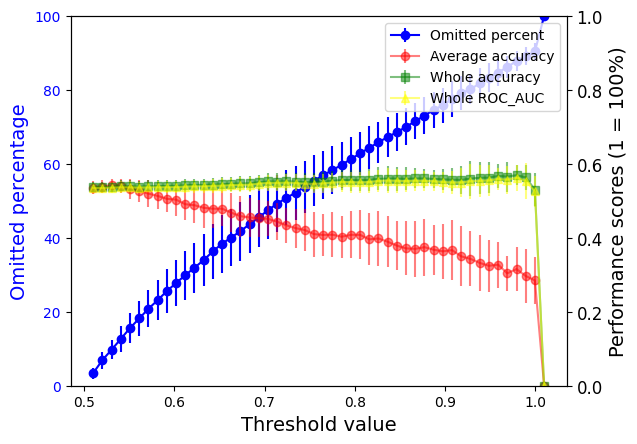

In [ ]:
def create_xgboost_model(learning_rate, max_depth, n_estimators, min_child_weight, subsample, gamma, reg_alpha):
    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        min_child_weight=min_child_weight,
        subsample=subsample,
        gamma=gamma,
        reg_alpha=reg_alpha,
        objective='binary:logistic',
        random_state=42
    )
    return model # in data loading, X is already scaled

import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)

converted_paras_ll = []
for i in range(1, 21):
  path = f"{base}xg_gkb_noP/best_params_list_{i}.csv"
  paras_l = read_csv(path)
  paras_l = paras_l[0]
  converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
  converted_paras_ll.append(converted_paras_l)
print(np.shape(converted_paras_ll))

acc_w_tl_a = []
acc_tl_a = []
auc_tl_a = []
o_p_tl_a = []
for n_run in range(20):
  print(f'%Run {n_run}')
  acc_tl = []
  acc_w_tl = []
  auc_tl = []
  o_p_tl = []
  o_p_all = 0
  thres = 0.51
  converted_paras_l = converted_paras_ll[n_run]
  while o_p_all < 90:
    print(thres)
    acc_scores = []
    n = 1
    yhat_all = []
    ytrue_all = []
    # o_p_l = []
    for i in range(len(testlist)):
      print(f"Fold {i}; ")
      paras = converted_paras_l[i]
      #1 Build training, validation and test sets/Extract individual index list
      train_v_indexes = trainlist[i]
      val_indexes = vlist[i]
      test_indexes = testlist[i]
      X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
      X_test, y_test= X[test_indexes], Y[test_indexes]
      # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      #     f"testing index: {len(test_indexes)}") #{test_indexes},

      #2 Use train and validation indexes to create the custom split
      # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
      custom_split = [-1] * len(train_v_indexes)
      for j, x in enumerate(train_v_indexes):
        if x in val_indexes: custom_split[j] = 0
      # Initialize the PredefinedSplit object
      ps = PredefinedSplit(test_fold=custom_split)

      #3 Create model with paras found by former BayesSearch
      model = create_xgboost_model(**paras)
      model.fit(X_train, y_train)
      yhat = model.predict_proba(X_test)

      #6 Calculate and store
      acc, o_p = prob_acc(y_test, yhat, thres)
      # auc = roc_auc_score(y_test, yhat)
      acc_scores.append(acc)
      # o_p_l.append(o_p)
      ytrue_all.append(y_test)
      yhat_all.append(yhat)
      # auc_scores.append(auc)
      # print("Iteration Accuray: {:.2f}%".format(100*acc))
      # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
      n+=1
    # a+=0.001

    #For one thres
    #7 Results for all testing folds
    # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
    ytrue_all = np.concatenate(ytrue_all)
    yhat_all= np.concatenate(yhat_all)
    acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
    auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
    # Filter nan in acc
    nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
    acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
    #
    acc_ave = np.mean(acc_scores)
    acc_w_tl.append(acc_w)
    acc_tl.append(acc_ave)
    auc_tl.append(auc)
    o_p_tl.append(o_p_all)
    print("Average Accuray: {:.2f}%".format(100*acc_ave))
    print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
        {:.2f}%".format(acc_w * 100, o_p_all))
    print("Whole AUC: {:.4f}%".format(auc))
    thres = thres+0.01 #Bug: need to place it later!
  acc_w_tl_a.append(acc_w_tl)
  acc_tl_a.append(acc_tl)
  auc_tl_a.append(auc_tl)
  o_p_tl_a.append(o_p_tl)
print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

base_path1 = f"{base}xg_gkb_noP/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            # Eliminate nan
            import math
            row_data = [0 if math.isnan(x) else x for x in row_data]
            data.append(row_data)
    return data
write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a) #Bug

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value',size=14)
ax1.set_ylabel('Omitted percentage',color='b',size=14)
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (1 = 100%)',size=14)
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"xg_gkb_noP_thres.png",bbox_inches='tight')

##### Read best paras

(?) Add reg lambda? - Tried, the performance is not promoted.

In [ ]:
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
path = f"{base}xg1_odata_pop/best_params_list_1.csv"
paras_l = read_csv(path)
paras_l = paras_l[0]
paras_l

["OrderedDict([('gamma', 1.0), ('learning_rate', 0.01756567096207286), ('max_depth', 1), ('min_child_weight', 4), ('n_estimators', 119), ('reg_alpha', 0.01), ('subsample', 0.698463294217359)])",
 "OrderedDict([('gamma', 1.0), ('learning_rate', 0.05558799935811328), ('max_depth', 6), ('min_child_weight', 7), ('n_estimators', 228), ('reg_alpha', 0.8600333361727824), ('subsample', 0.38567613301781933)])",
 "OrderedDict([('gamma', 0.01), ('learning_rate', 0.014116602443684874), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 58), ('reg_alpha', 0.26750034385169486), ('subsample', 0.4607524370885613)])",
 "OrderedDict([('gamma', 0.20431190407392957), ('learning_rate', 0.01), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 1000), ('reg_alpha', 0.8962521772880749), ('subsample', 0.36250443403160915)])",
 "OrderedDict([('gamma', 0.7402075378552239), ('learning_rate', 0.5925935888492632), ('max_depth', 9), ('min_child_weight', 3), ('n_estimators', 965), ('reg_alpha', 

In [ ]:
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
converted_paras_l

[{'gamma': 1.0,
  'learning_rate': 0.01756567096207286,
  'max_depth': 1,
  'min_child_weight': 4,
  'n_estimators': 119,
  'reg_alpha': 0.01,
  'subsample': 0.698463294217359},
 {'gamma': 1.0,
  'learning_rate': 0.05558799935811328,
  'max_depth': 6,
  'min_child_weight': 7,
  'n_estimators': 228,
  'reg_alpha': 0.8600333361727824,
  'subsample': 0.38567613301781933},
 {'gamma': 0.01,
  'learning_rate': 0.014116602443684874,
  'max_depth': 10,
  'min_child_weight': 10,
  'n_estimators': 58,
  'reg_alpha': 0.26750034385169486,
  'subsample': 0.4607524370885613},
 {'gamma': 0.20431190407392957,
  'learning_rate': 0.01,
  'max_depth': 10,
  'min_child_weight': 10,
  'n_estimators': 1000,
  'reg_alpha': 0.8962521772880749,
  'subsample': 0.36250443403160915},
 {'gamma': 0.7402075378552239,
  'learning_rate': 0.5925935888492632,
  'max_depth': 9,
  'min_child_weight': 3,
  'n_estimators': 965,
  'reg_alpha': 0.5286125075563574,
  'subsample': 0.27657952021923926},
 {'gamma': 0.590303499703

##### Test with different Thres

In [ ]:
#Trial
train_v_indexes = trainlist[0]
val_indexes = vlist[0]
test_indexes = testlist[0]
X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
X_test, y_test= X[test_indexes], Y[test_indexes]

paras  = converted_paras_l[0]

model = create_xgboost_model(**paras)
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)

#6 Calculate and store
thres = 0.7
acc, o_p = prob_acc(y_test, yhat, thres)
print(acc, o_p)

0.8 82.14285714285714


In [ ]:
acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
thres = 0.51
while o_p_all < 90:
  acc_scores = []
  n = 1
  yhat_all = []
  ytrue_all = []
  o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    #     f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for j, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[j] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model with paras found by former BayesSearch
    model = create_xgboost_model(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    # print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
    n+=1
  thres = thres+0.01
  #For one thres
  #7 Results for all testing folds
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter nan in acc
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.17%
Whole Accuracy: 66.46%, Percentage of Data Omitted:       3.59%
Whole AUC: 0.6554%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.51%
Whole Accuracy: 66.24%, Percentage of Data Omitted:       5.99%
Whole AUC: 0.6519%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.53%
Whole Accuracy: 66.01%, Percentage of Data Omitted:       8.38%
Whole AUC: 0.6507%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.35%
Whole Accuracy: 66.89%, Percentage of Data Omitted:       12.28%
Whole AUC: 0.6604%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 68.08%
Whole Accuracy: 66.78%, Percentage of Data Omitted:       14.37%
Whole AUC: 0.6608%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 68.43%
Whole Accuracy: 65.58%, Percentage of Data Omitted:       35.63%
Whole AUC: 0.6541%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 68.11%
Whole Accuracy: 65.07%, Percentage of Data Omitted:       37.43%
Whole AUC: 0.6486%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 67.44%
Whole Accuracy: 65.05%, Percentage of Data Omitted:       38.32%
Whole AUC: 0.6487%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 67.04%
Whole Accuracy: 64.82%, Percentage of Data Omitted:       40.42%
Whole AUC: 0.6467%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.63%
Whole Accuracy: 64.47%, Percentage of Data Omitted:       41.02%
Whole AUC: 0.6436%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.41%
Whole Accuracy: 65.41%, Percentage of Data Omitted:       44.61%
Whole AUC: 0.6528%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 68.85%
Whole Accuracy: 65.56%, Percentage of Data Omitted:       46.11%
Whole AUC: 0.6545%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 68.73%
Whole Accuracy: 64.74%, Percentage of Data Omitted:       48.20%
Whole AUC: 0.6458%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 67.62%
Whole Accuracy: 64.85%, Percentage of Data Omitted:       50.60%
Whole AUC: 0.6474%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 71.80%
Whole Accuracy: 65.00%, Percentage of Data Omitted:       52.10%
Whole AUC: 0.6486%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 71.72%
Whole Accuracy: 64.94%, Percentage of Data Omitted:       53.89%
Whole AUC: 0.6479%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 72.45%
Whole Accuracy: 63.70%, Percentage of Data Omitted:       56.29%
Whole AUC: 0.6357%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 68.14%
Whole Accuracy: 63.45%, Percentage of Data Omitted:       56.59%
Whole AUC: 0.6329%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.95%
Whole Accuracy: 61.83%, Percentage of Data Omitted:       60.78%
Whole AUC: 0.6143%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 60.67%
Whole Accuracy: 61.72%, Percentage of Data Omitted:       61.68%
Whole AUC: 0.6142%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 61.06%
Whole Accuracy: 62.90%, Percentage of Data Omitted:       62.87%
Whole AUC: 0.6266%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 63.21%
Whole Accuracy: 62.39%, Percentage of Data Omitted:       64.97%
Whole AUC: 0.6190%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 64.44%
Whole Accuracy: 62.73%, Percentage of Data Omitted:       67.07%
Whole AUC: 0.6246%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 65.39%
Whole Accuracy: 62.50%, Percentage of Data Omitted:       68.86%
Whole AUC: 0.6205%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 66.01%
Whole Accuracy: 63.37%, Percentage of Data Omitted:       69.76%
Whole AUC: 0.6298%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Average Accuray: 67.18%
Whole Accuracy: 68.97%, Percentage of Data Omitted:       73.95%
Whole AUC: 0.6985%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 86.33%
Whole Accuracy: 71.08%, Percentage of Data Omitted:       75.15%
Whole AUC: 0.7154%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 86.61%
Whole Accuracy: 71.08%, Percentage of Data Omitted:       75.15%
Whole AUC: 0.7154%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 86.61%
Whole Accuracy: 68.00%, Percentage of Data Omitted:       77.54%
Whole AUC: 0.6847%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 72.22%
Whole Accuracy: 70.42%, Percentage of Data Omitted:       78.74%
Whole AUC: 0.7121%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 78.43%
Whole Accuracy: 69.70%, Percentage of Data Omitted:       80.24%
Whole AUC: 0.7036%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Average Accuray: 78.86%
Whole Accuracy: 66.67%, Percentage of Data Omitted:       82.04%
Whole AUC: 0.6742%
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 76.77%
Whole Accuracy: 64.29%, Percentage of Data Omitted:       83.23%
Whole AUC: 0.6503%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 73.59%
Whole Accuracy: 65.38%, Percentage of Data Omitted:       84.43%
Whole AUC: 0.6636%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 61.50%
Whole Accuracy: 66.00%, Percentage of Data Omitted:       85.03%
Whole AUC: 0.6741%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 64.58%
Whole Accuracy: 63.83%, Percentage of Data Omitted:       85.93%
Whole AUC: 0.6541%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 57.93%
Whole Accuracy: 60.47%, Percentage of Data Omitted:       87.13%
Whole AUC: 0.6222%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 56.08%
Whole Accuracy: 60.00%, Percentage of Data Omitted:       89.52%
Whole AUC: 0.6071%
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Average Accuray: 63.02%
Whole Accuracy: 60.00%, Percentage of Data Omitted:       91.02%
Whole AUC: 0.6111%


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


##### Plot

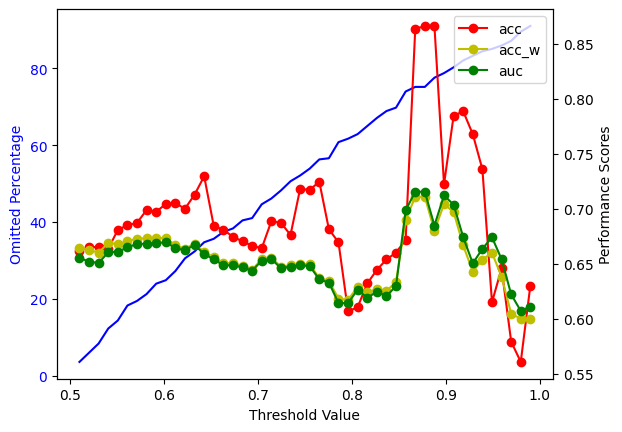

In [ ]:
fig, ax1 = plt.subplots()
x_lim = np.linspace(0.51,thres,(len(o_p_tl)))
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

Conclusion: the middle drops means that the high thresholding region has considerable mis-predictions.

##### 20 Runs Error-bar - xg pop gkb noS

[[0.5333333333333333, 0.5311526479750779, 0.535031847133758, 0.5361842105263158, 0.5368782161234992, 0.5307557117750439, 0.5307971014492754, 0.5319548872180451, 0.5419103313840156, 0.5472837022132797, 0.5511482254697286, 0.5517241379310345, 0.5530973451327433, 0.5502283105022832, 0.5542452830188679, 0.5594059405940595, 0.5538461538461539, 0.5631578947368421, 0.55858310626703, 0.5603448275862069, 0.56047197640118, 0.5644171779141104, 0.5576923076923077, 0.5573770491803278, 0.5513698630136986, 0.549645390070922, 0.5604395604395604, 0.55893536121673, 0.568, 0.5619834710743802, 0.5627705627705628, 0.5576036866359447, 0.5625, 0.5515463917525774, 0.5337078651685393, 0.5294117647058824, 0.5159235668789809, 0.5202702702702703, 0.5037037037037037, 0.5078125, 0.5, 0.5238095238095238, 0.5208333333333334, 0.5161290322580645, 0.5375, 0.5], [0.5353218210361067, 0.5355371900826447, 0.5303292894280762, 0.5352622061482821, 0.5424710424710425, 0.5461847389558233, 0.5467775467775468, 0.5448577680525164, 

<ipython-input-30-738125f6e330>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data0p_arr = np.array(data0p)
<ipython-input-30-738125f6e330>:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data1p_arr = np.array(data1p)
<ipython-input-30-738125f6e330>:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data2p_arr = np.array(data2p

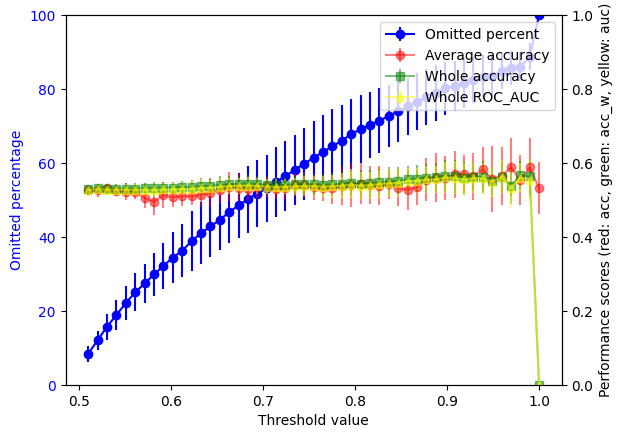

In [ ]:
base_path1 = f"{base}xg_gkb_pop_noS/"
## Read/save functions
def write_to_csv(file_path, data):
  with open(file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for row in data:
      csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
  data = []
  with open(file_path, 'r', newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
      # Convert elements from strings to integers (or other types if needed)
      row_data = [float(element) for element in row]
      # Eliminate nan
      import math
      row_data = [0 if math.isnan(x) else x for x in row_data]
      data.append(row_data)
  return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
print(data2)
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"xg_gkb_pop_noS_thres.png")

##### 20 Runs Error-bar - xg pop gkb S

[[0.5333333333333333, 0.5311526479750779, 0.535031847133758, 0.5361842105263158, 0.5368782161234992, 0.5307557117750439, 0.5307971014492754, 0.5319548872180451, 0.5419103313840156, 0.5472837022132797, 0.5511482254697286, 0.5517241379310345, 0.5530973451327433, 0.5502283105022832, 0.5542452830188679, 0.5594059405940595, 0.5538461538461539, 0.5631578947368421, 0.55858310626703, 0.5603448275862069, 0.56047197640118, 0.5644171779141104, 0.5576923076923077, 0.5573770491803278, 0.5513698630136986, 0.549645390070922, 0.5604395604395604, 0.55893536121673, 0.568, 0.5619834710743802, 0.5627705627705628, 0.5576036866359447, 0.5625, 0.5515463917525774, 0.5337078651685393, 0.5294117647058824, 0.5159235668789809, 0.5202702702702703, 0.5037037037037037, 0.5078125, 0.5, 0.5238095238095238, 0.5208333333333334, 0.5161290322580645, 0.5375, 0.5], [0.5353218210361067, 0.5355371900826447, 0.5303292894280762, 0.5352622061482821, 0.5424710424710425, 0.5461847389558233, 0.5467775467775468, 0.5448577680525164, 

<ipython-input-30-738125f6e330>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data0p_arr = np.array(data0p)
<ipython-input-30-738125f6e330>:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data1p_arr = np.array(data1p)
<ipython-input-30-738125f6e330>:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data2p_arr = np.array(data2p

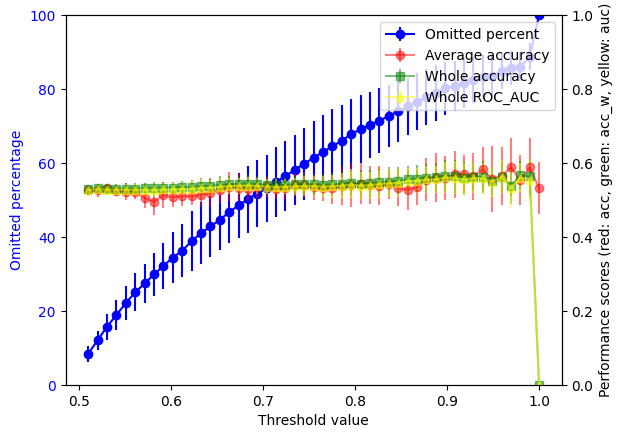

In [ ]:
base_path1 = f"{base}xg_gkb_pop/"
## Read/save functions
def write_to_csv(file_path, data):
  with open(file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for row in data:
      csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
  data = []
  with open(file_path, 'r', newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
      # Convert elements from strings to integers (or other types if needed)
      row_data = [float(element) for element in row]
      # Eliminate nan
      import math
      row_data = [0 if math.isnan(x) else x for x in row_data]
      data.append(row_data)
  return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
print(data2)
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"xg_gkb_pop_noS_thres.png")

#### GB Thresholding

##### Load predictions/best parameters

In [ ]:
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
path = f"{base}gb1_odata_pop/best_params_list_3.csv"
paras_l = read_csv(path)
paras_l = paras_l[0]
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
converted_paras_l

[{'ccp_alpha': 0.03559836353834013,
  'learning_rate': 0.04082121583112826,
  'max_depth': 8,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 12,
  'n_estimators': 332,
  'subsample': 0.2931070079247635},
 {'ccp_alpha': 0.06350811383588846,
  'learning_rate': 0.020454950269266914,
  'max_depth': 6,
  'min_impurity_decrease': 1.0,
  'min_samples_leaf': 19,
  'n_estimators': 916,
  'subsample': 0.2436042520415494},
 {'ccp_alpha': 0.0,
  'learning_rate': 0.011127300847971212,
  'max_depth': 6,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 11,
  'n_estimators': 536,
  'subsample': 0.1},
 {'ccp_alpha': 0.0,
  'learning_rate': 0.01,
  'max_depth': 1,
  'min_impurity_decrease': 1.0,
  'min_samples_leaf': 1,
  'n_estimators': 50,
  'subsample': 0.1},
 {'ccp_alpha': 0.0,
  'learning_rate': 1.0,
  'max_depth': 6,
  'min_impurity_decrease': 1.0,
  'min_samples_leaf': 20,
  'n_estimators': 408,
  'subsample': 0.9617095331048559},
 {'ccp_alpha': 0.0,
  'learning_rate': 0.9755956866677

##### Model Initiliazation

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from skopt.space import Real, Categorical, Integer
# reg = GradientBoostingClassifier(random_state=0)
# Define XGBoost model hyperparameters grid
def create_gb_model(learning_rate, max_depth, n_estimators, min_samples_leaf,
                    subsample,min_impurity_decrease, ccp_alpha):
    model = GradientBoostingClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        min_impurity_decrease=min_impurity_decrease,
        #gamma=gamma,
        #alpha
        ccp_alpha=ccp_alpha,
        random_state=42
    )
    return model

##### Test with different thres

In [ ]:
acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
thres = 0.51
while o_p_all < 90:
  print(thres)
  acc_scores = []
  n = 1
  yhat_all = []
  ytrue_all = []
  # o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    #     f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for j, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[j] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model with paras found by former BayesSearch
    model = create_gb_model(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    # o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    if o_p == 100:
      print('Omitted percent: 100%')
    # print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
    n+=1
  # a+=0.001
  thres+=0.01
  #For one thres
  #7 Results for all testing folds
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter nan in acc
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  315
Average Accuray: 61.79%
Whole Accuracy: 63.81%, Percentage of Data Omitted:       5.69%
Whole AUC: 0.6259%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  311
Average Accuray: 63.44%
Whole Accuracy: 63.67%, Percentage of Data Omitted:       6.89%
Whole AUC: 0.6227%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  300
Average Accuray: 63.37%
Whole Accuracy: 63.67%, Percentage of Data Omitted:       10.18%
Whole AUC: 0.6211%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  291
Average Accuray: 63.59%
Whole Accuracy: 63.23%, Percentage of Data Omitted:       12.87%
Whole AUC: 0.6163%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  283
Average Accuray: 63.13%
Whole Accuracy: 64.66%, Percentage o

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  128
Average Accuray: 64.52%
Whole Accuracy: 67.97%, Percentage of Data Omitted:       61.68%
Whole AUC: 0.6734%
0.6800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  123
Average Accuray: 72.50%
Whole Accuracy: 69.11%, Percentage of Data Omitted:       63.17%
Whole AUC: 0.6841%
0.6900000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  119
Average Accuray: 74.35%
Whole Accuracy: 68.07%, Percentage of Data Omitted:       64.37%
Whole AUC: 0.6748%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  116
Average Accuray: 73.57%
Whole Accuracy: 68.10%, Percentage of Data Omitted:       65.27%
Whole AUC: 0.6765%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  112
Average Accuray: 74.39%
Whole Accuracy: 66.96%, Percentage of Data Omitted:       66.47%
Whole AUC: 0.6676%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  106
Average Accuray: 74.28%
Whole Accuracy: 66.04%, Percentage of Data Omitted:       68.26%
Whole AUC: 0.6604%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  93
Average Accuray: 73.86%
Whole Accuracy: 65.59%, Percentage of Data Omitted:       72.16%
Whole AUC: 0.6561%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  88
Average Accuray: 75.39%
Whole Accuracy: 63.64%, Percentage of Data Omitted:       73.65%
Whole AUC: 0.6366%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  86
Average Accuray: 68.42%
Whole Accuracy: 63.95%, Percentage of Data Omitted:       74.25%
Whole AUC: 0.6393%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  83
Average Accuray: 68.96%
Whole Accuracy: 63.86%, Percentage of Data Omitted:       75.15%
Whole AUC: 0.6372%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  79
Average Accuray: 69.09%
Whole Accuracy: 63.29%, Percentage of Data Omitted:       76.35%
Whole AUC: 0.6306%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  79
Average Accuray: 69.26%
Whole Accuracy: 63.29%, Percentage of Data Omitted:       76.35%
Whole AUC: 0.6306%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  74
Average Accuray: 69.26%
Whole Accuracy: 62.16%, Percentage of Data Omitted:       77.84%
Whole AUC: 0.6191%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  72
Average Accuray: 69.47%
Whole Accuracy: 62.50%, Percentage of Data Omitted:       78.44%
Whole AUC: 0.6219%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  71
Average Accuray: 70.04%
Whole Accuracy: 61.97%, Percentage of Data Omitted:       78.74%
Whole AUC: 0.6174%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  70
Average Accuray: 69.74%
Whole Accuracy: 61.43%, Percentage of Data Omitted:       79.04%
Whole AUC: 0.6127%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  70
Average Accuray: 69.74%
Whole Accuracy: 61.43%, Percentage of Data Omitted:       79.04%
Whole AUC: 0.6127%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  68
Average Accuray: 69.74%
Whole Accuracy: 61.76%, Percentage of Data Omitted:       79.64%
Whole AUC: 0.6146%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  68
Average Accuray: 60.97%
Whole Accuracy: 61.76%, Percentage of Data Omitted:       79.64%
Whole AUC: 0.6146%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  63
Average Accuray: 60.97%
Whole Accuracy: 60.32%, Percentage of Data Omitted:       81.14%
Whole AUC: 0.6030%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  62
Average Accuray: 60.85%
Whole Accuracy: 59.68%, Percentage of Data Omitted:       81.44%
Whole AUC: 0.5961%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  61
Average Accuray: 60.30%
Whole Accuracy: 60.66%, Percentage of Data Omitted:       81.74%
Whole AUC: 0.6066%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  61
Average Accuray: 62.43%
Whole Accuracy: 60.66%, Percentage of Data Omitted:       81.74%
Whole AUC: 0.6066%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  56
Average Accuray: 62.43%
Whole Accuracy: 57.14%, Percentage of Data Omitted:       83.23%
Whole AUC: 0.5677%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  55
Average Accuray: 58.46%
Whole Accuracy: 56.36%, Percentage of Data Omitted:       83.53%
Whole AUC: 0.5577%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  55
Average Accuray: 56.88%
Whole Accuracy: 56.36%, Percentage of Data Omitted:       83.53%
Whole AUC: 0.5577%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  54
Average Accuray: 56.88%
Whole Accuracy: 55.56%, Percentage of Data Omitted:       83.83%
Whole AUC: 0.5512%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  52
Average Accuray: 54.66%
Whole Accuracy: 55.77%, Percentage of Data Omitted:       84.43%
Whole AUC: 0.5540%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  51
Average Accuray: 56.88%
Whole Accuracy: 54.90%, Percentage of Data Omitted:       84.73%
Whole AUC: 0.5466%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  50
Average Accuray: 51.32%
Whole Accuracy: 56.00%, Percentage of Data Omitted:       85.03%
Whole AUC: 0.5572%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  50
Average Accuray: 52.14%
Whole Accuracy: 56.00%, Percentage of Data Omitted:       85.03%
Whole AUC: 0.5572%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  47
Average Accuray: 52.14%
Whole Accuracy: 57.45%, Percentage of Data Omitted:       85.93%
Whole AUC: 0.5742%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 3; 
Omitted percent: 100%
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Omitted percent: 100%
Fold 7; 
Fold 8; 
Omitted percent: 100%
Test size:  0
Average Accuray: 54.54%
Whole Accuracy: nan%, Percentage of Data Omitted:       100.00%
Whole AUC: 0.0000%


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


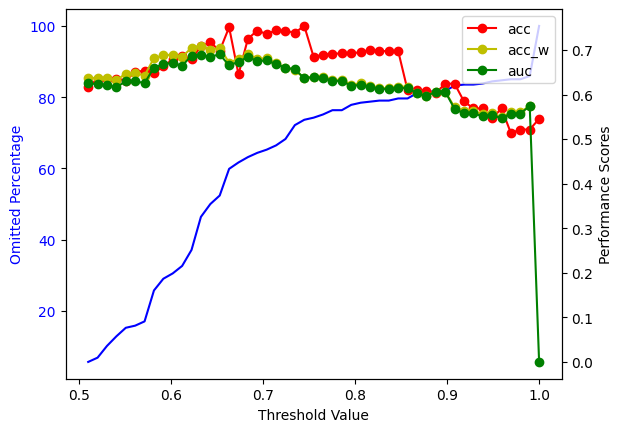

In [ ]:
fig, ax1 = plt.subplots()
x_lim = np.linspace(0.51,thres,(len(o_p_tl)))
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

# ax4.set_ylabel('Running time (seconds)',color='r')
# ax4.tick_params(axis='y',labelcolor='r')

Conclusion: similarly...

##### 20 Runs Error-bar - gb noS

In [ ]:
# Collect data from 20 runs and test different thresholds
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_ll = []
for i in range(1, 21):
  path = f"{base}gb1_odata_pop/best_params_list_{i}.csv"
  paras_l = read_csv(path)
  paras_l = paras_l[0]
  converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
  converted_paras_ll.append(converted_paras_l)
print(np.shape(converted_paras_ll))

(20, 9)


In [ ]:
acc_w_tl_a = []
acc_tl_a = []
auc_tl_a = []
o_p_tl_a = []
for n_run in range(20):
  print(f'%Run {n_run}')
  acc_tl = []
  acc_w_tl = []
  auc_tl = []
  o_p_tl = []
  o_p_all = 0
  thres = 0.51
  converted_paras_l = converted_paras_ll[n_run]
  while o_p_all < 90:
    print(thres)
    acc_scores = []
    n = 1
    yhat_all = []
    ytrue_all = []
    # o_p_l = []
    for i in range(len(testlist)):
      print(f"Fold {i}; ")
      paras = converted_paras_l[i]
      #1 Build training, validation and test sets/Extract individual index list
      train_v_indexes = trainlist[i]
      val_indexes = vlist[i]
      test_indexes = testlist[i]
      X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
      X_test, y_test= X[test_indexes], Y[test_indexes]
      # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      #     f"testing index: {len(test_indexes)}") #{test_indexes},

      #2 Use train and validation indexes to create the custom split
      # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
      custom_split = [-1] * len(train_v_indexes)
      for j, x in enumerate(train_v_indexes):
        if x in val_indexes: custom_split[j] = 0
      # Initialize the PredefinedSplit object
      ps = PredefinedSplit(test_fold=custom_split)

      #3 Create model with paras found by former BayesSearch
      model = create_gb_model(**paras)
      model.fit(X_train, y_train)
      yhat = model.predict_proba(X_test)

      #6 Calculate and store
      acc, o_p = prob_acc(y_test, yhat, thres)
      # auc = roc_auc_score(y_test, yhat)
      acc_scores.append(acc)
      # o_p_l.append(o_p)
      ytrue_all.append(y_test)
      yhat_all.append(yhat)
      # auc_scores.append(auc)
      # print("Iteration Accuray: {:.2f}%".format(100*acc))
      # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
      n+=1
    # a+=0.001
    thres = thres+0.01
    #For one thres
    #7 Results for all testing folds
    # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
    ytrue_all = np.concatenate(ytrue_all)
    yhat_all= np.concatenate(yhat_all)
    acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
    auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
    # Filter nan in acc
    nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
    acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
    #
    acc_ave = np.mean(acc_scores)
    acc_w_tl.append(acc_w)
    acc_tl.append(acc_ave)
    auc_tl.append(auc)
    o_p_tl.append(o_p_all)
    print("Average Accuray: {:.2f}%".format(100*acc_ave))
    print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
        {:.2f}%".format(acc_w * 100, o_p_all))
    print("Whole AUC: {:.4f}%".format(auc))
  acc_w_tl_a.append(acc_w_tl)
  acc_tl_a.append(acc_tl)
  auc_tl_a.append(auc_tl)
  o_p_tl_a.append(o_p_tl)
print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

%Run 0
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  229
Average Accuray: 70.29%
Whole Accuracy: 70.74%, Percentage of Data Omitted:         31.44%
Whole AUC: 0.6934%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  218
Average Accuray: 70.91%
Whole Accuracy: 71.56%, Percentage of Data Omitted:         34.73%
Whole AUC: 0.7004%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  213
Average Accuray: 71.88%
Whole Accuracy: 71.83%, Percentage of Data Omitted:         36.23%
Whole AUC: 0.7000%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  209
Average Accuray: 72.30%
Whole Accuracy: 71.77%, Percentage of Data Omitted:         37.43%
Whole AUC: 0.6976%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  202
Average Accuray: 72.51%
Whole Accuracy: 71.29%, Percentage of Data Omitted:         39.52%
Whole AUC: 0.6947%
0.56
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  200
Average Accuray: 72.27%
Whole Accuracy: 71.50%, Percentage of Data Omitted:         40.12%
Whole AUC: 0.6972%
0.5700000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  193
Average Accuray: 72.26%
Whole Accuracy: 70.47%, Percentage of Data Omitted:         42.22%
Whole AUC: 0.6843%
0.5800000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  184
Average Accuray: 71.24%
Whole Accuracy: 71.20%, Percentage of Data Omitted:         44.91%
Whole AUC: 0.6923%
0.5900000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  170
Average Accuray: 72.64%
Whole Accuracy: 70.59%, Percentage of Data Omitted:         49.10%
Whole AUC: 0.6916%
0.6000000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  154
Average Accuray: 72.82%
Whole Accuracy: 71.43%, Percentage of Data Omitted:         53.89%
Whole AUC: 0.7042%
0.6100000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  133
Average Accuray: 73.48%
Whole Accuracy: 70.68%, Percentage of Data Omitted:         60.18%
Whole AUC: 0.7041%
0.6200000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  123
Average Accuray: 71.33%
Whole Accuracy: 71.54%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.7122%
0.6300000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  120
Average Accuray: 74.90%
Whole Accuracy: 70.83%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.7042%
0.6400000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  114
Average Accuray: 74.29%
Whole Accuracy: 70.18%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.6994%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  112
Average Accuray: 74.56%
Whole Accuracy: 69.64%, Percentage of Data Omitted:         66.47%
Whole AUC: 0.6927%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  106
Average Accuray: 73.06%
Whole Accuracy: 69.81%, Percentage of Data Omitted:         68.26%
Whole AUC: 0.6978%
0.6700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  103
Average Accuray: 73.10%
Whole Accuracy: 68.93%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.6884%
0.6800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  100
Average Accuray: 72.75%
Whole Accuracy: 69.00%, Percentage of Data Omitted:         70.06%
Whole AUC: 0.6909%
0.6900000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  94
Average Accuray: 72.94%
Whole Accuracy: 69.15%, Percentage of Data Omitted:         71.86%
Whole AUC: 0.6933%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  69
Average Accuray: 74.10%
Whole Accuracy: 63.77%, Percentage of Data Omitted:         79.34%
Whole AUC: 0.6235%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  66
Average Accuray: 71.00%
Whole Accuracy: 63.64%, Percentage of Data Omitted:         80.24%
Whole AUC: 0.6222%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  46
Average Accuray: 70.81%
Whole Accuracy: 67.39%, Percentage of Data Omitted:         86.23%
Whole AUC: 0.6598%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  45
Average Accuray: 76.01%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         86.53%
Whole AUC: 0.6549%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  41
Average Accuray: 75.31%
Whole Accuracy: 65.85%, Percentage of Data Omitted:         87.72%
Whole AUC: 0.6412%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  39
Average Accuray: 68.89%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         88.32%
Whole AUC: 0.6508%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  35
Average Accuray: 69.05%
Whole Accuracy: 68.57%, Percentage of Data Omitted:         89.52%
Whole AUC: 0.6548%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  31
Average Accuray: 69.55%
Whole Accuracy: 67.74%, Percentage of Data Omitted:         90.72%
Whole AUC: 0.6068%
%Run 1
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  320
Average Accuray: 61.17%
Whole Accuracy: 60.31%, Percentage of Data Omitted:         4.19%
Whole AUC: 0.5821%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  310
Average Accuray: 60.57%
Whole Accuracy: 60.32%, Percentage of Data Omitted:         7.19%
Whole AUC: 0.5817%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  277
Average Accuray: 60.66%
Whole Accuracy: 62.09%, Percentage of Data Omitted:         17.07%
Whole AUC: 0.5953%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  223
Average Accuray: 61.42%
Whole Accuracy: 62.33%, Percentage of Data Omitted:         33.23%
Whole AUC: 0.6038%
0.55
Fold 0; 
Fold 1; 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  216
Average Accuray: 62.87%
Whole Accuracy: 62.04%, Percentage of Data Omitted:         35.33%
Whole AUC: 0.5983%
0.56
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  211
Average Accuray: 62.29%
Whole Accuracy: 62.09%, Percentage of Data Omitted:         36.83%
Whole AUC: 0.5975%
0.5700000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  206
Average Accuray: 62.60%
Whole Accuracy: 62.62%, Percentage of Data Omitted:         38.32%
Whole AUC: 0.5984%
0.5800000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  195
Average Accuray: 63.35%
Whole Accuracy: 62.56%, Percentage of Data Omitted:         41.62%
Whole AUC: 0.6013%
0.5900000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  192
Average Accuray: 63.01%
Whole Accuracy: 62.50%, Percentage of Data Omitted:         42.51%
Whole AUC: 0.6019%
0.6000000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  172
Average Accuray: 62.94%
Whole Accuracy: 62.79%, Percentage of Data Omitted:         48.50%
Whole AUC: 0.6116%
0.6100000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  169
Average Accuray: 64.15%
Whole Accuracy: 63.31%, Percentage of Data Omitted:         49.40%
Whole AUC: 0.6150%
0.6200000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  158
Average Accuray: 66.24%
Whole Accuracy: 62.03%, Percentage of Data Omitted:         52.69%
Whole AUC: 0.6099%
0.6300000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  157
Average Accuray: 65.10%
Whole Accuracy: 62.42%, Percentage of Data Omitted:         52.99%
Whole AUC: 0.6129%
0.6400000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  155
Average Accuray: 66.11%
Whole Accuracy: 61.94%, Percentage of Data Omitted:         53.59%
Whole AUC: 0.6102%
0.6500000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  151
Average Accuray: 64.41%
Whole Accuracy: 62.91%, Percentage of Data Omitted:         54.79%
Whole AUC: 0.6199%
0.6600000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  146
Average Accuray: 67.13%
Whole Accuracy: 62.33%, Percentage of Data Omitted:         56.29%
Whole AUC: 0.6173%
0.6700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  140
Average Accuray: 71.89%
Whole Accuracy: 62.86%, Percentage of Data Omitted:         58.08%
Whole AUC: 0.6230%
0.6800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  138
Average Accuray: 68.00%
Whole Accuracy: 62.32%, Percentage of Data Omitted:         58.68%
Whole AUC: 0.6174%
0.6900000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  125
Average Accuray: 67.68%
Whole Accuracy: 61.60%, Percentage of Data Omitted:         62.57%
Whole AUC: 0.6058%
0.7000000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  121
Average Accuray: 68.28%
Whole Accuracy: 61.98%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.6099%
0.7100000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 68.46%
Whole Accuracy: 62.93%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.6186%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  97
Average Accuray: 70.31%
Whole Accuracy: 60.82%, Percentage of Data Omitted:         70.96%
Whole AUC: 0.6093%
0.7300000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  82
Average Accuray: 69.76%
Whole Accuracy: 67.07%, Percentage of Data Omitted:         75.45%
Whole AUC: 0.6681%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  80
Average Accuray: 75.06%
Whole Accuracy: 66.25%, Percentage of Data Omitted:         76.05%
Whole AUC: 0.6596%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  80
Average Accuray: 74.51%
Whole Accuracy: 66.25%, Percentage of Data Omitted:         76.05%
Whole AUC: 0.6596%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  76
Average Accuray: 74.51%
Whole Accuracy: 65.79%, Percentage of Data Omitted:         77.25%
Whole AUC: 0.6569%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  74
Average Accuray: 73.87%
Whole Accuracy: 64.86%, Percentage of Data Omitted:         77.84%
Whole AUC: 0.6476%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  73
Average Accuray: 72.83%
Whole Accuracy: 64.38%, Percentage of Data Omitted:         78.14%
Whole AUC: 0.6422%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  63
Average Accuray: 72.51%
Whole Accuracy: 65.08%, Percentage of Data Omitted:         81.14%
Whole AUC: 0.6530%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  60
Average Accuray: 76.72%
Whole Accuracy: 65.00%, Percentage of Data Omitted:         82.04%
Whole AUC: 0.6524%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  60
Average Accuray: 76.59%
Whole Accuracy: 65.00%, Percentage of Data Omitted:         82.04%
Whole AUC: 0.6524%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  59
Average Accuray: 76.59%
Whole Accuracy: 64.41%, Percentage of Data Omitted:         82.34%
Whole AUC: 0.6454%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  58
Average Accuray: 76.20%
Whole Accuracy: 63.79%, Percentage of Data Omitted:         82.63%
Whole AUC: 0.6405%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  51
Average Accuray: 64.30%
Whole Accuracy: 62.75%, Percentage of Data Omitted:         84.73%
Whole AUC: 0.6246%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  51
Average Accuray: 62.85%
Whole Accuracy: 62.75%, Percentage of Data Omitted:         84.73%
Whole AUC: 0.6246%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  48
Average Accuray: 62.85%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         85.63%
Whole AUC: 0.6748%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  43
Average Accuray: 66.61%
Whole Accuracy: 67.44%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.6859%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  34
Average Accuray: 67.00%
Whole Accuracy: 64.71%, Percentage of Data Omitted:         89.82%
Whole AUC: 0.6850%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  34
Average Accuray: 60.42%
Whole Accuracy: 64.71%, Percentage of Data Omitted:         89.82%
Whole AUC: 0.6850%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  29
Average Accuray: 60.42%
Whole Accuracy: 72.41%, Percentage of Data Omitted:         91.32%
Whole AUC: 0.7402%
%Run 2
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  315
Average Accuray: 61.79%
Whole Accuracy: 63.81%, Percentage of Data Omitted:         5.69%
Whole AUC: 0.6259%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  311
Average Accuray: 63.44%
Whole Accuracy: 63.67%, Percentage of Data Omitted:         6.89%
Whole AUC: 0.6227%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  300
Average Accuray: 63.37%
Whole Accuracy: 63.67%, Percentage of Data Omitted:         10.18%
Whole AUC: 0.6211%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  291
Average Accuray: 63.59%
Whole Accuracy: 63.23%, Percentage of Data Omitted:         12.87%
Whole AUC: 0.6163%
0.55
Fold 0; 
Fold 1; 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size: 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 128
Average Accuray: 64.52%
Whole Accuracy: 67.97%, Percentage of Data Omitted:         61.68%
Whole AUC: 0.6734%
0.6800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  123
Average Accuray: 72.50%
Whole Accuracy: 69.11%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.6841%
0.6900000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  119
Average Accuray: 74.35%
Whole Accuracy: 68.07%, Percentage of Data Omitted:         64.37%
Whole AUC: 0.6748%
0.7000000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  116
Average Accuray: 73.57%
Whole Accuracy: 68.10%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.6765%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  112


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average Accuray: 74.39%
Whole Accuracy: 66.96%, Percentage of Data Omitted:         66.47%
Whole AUC: 0.6676%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  106
Average Accuray: 74.28%
Whole Accuracy: 66.04%, Percentage of Data Omitted:         68.26%
Whole AUC: 0.6604%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  93
Average Accuray: 73.86%
Whole Accuracy: 65.59%, Percentage of Data Omitted:         72.16%
Whole AUC: 0.6561%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  88
Average Accuray: 75.39%
Whole Accuracy: 63.64%, Percentage of Data Omitted:         73.65%
Whole AUC: 0.6366%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  86
Average Accuray: 68.42%
Whole Accuracy: 63.95%, Percentage of Data Omitted:         74.25%
Whole AUC: 0.6393%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  83
Average Accuray: 68.96%
Whole Accuracy: 63.86%, Percentage of Data Omitted:         75.15%
Whole AUC: 0.6372%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  79
Average Accuray: 69.09%
Whole Accuracy: 63.29%, Percentage of Data Omitted:         76.35%
Whole AUC: 0.6306%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  79
Average Accuray: 69.26%
Whole Accuracy: 63.29%, Percentage of Data Omitted:         76.35%
Whole AUC: 0.6306%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  74
Average Accuray: 69.26%
Whole Accuracy: 62.16%, Percentage of Data Omitted:         77.84%
Whole AUC: 0.6191%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  72
Average Accuray: 69.47%
Whole Accuracy: 62.50%, Percentage of Data Omitted:         78.44%
Whole AUC: 0.6219%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  71
Average Accuray: 70.04%
Whole Accuracy: 61.97%, Percentage of Data Omitted:         78.74%
Whole AUC: 0.6174%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  70
Average Accuray: 69.74%
Whole Accuracy: 61.43%, Percentage of Data Omitted:         79.04%
Whole AUC: 0.6127%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  70
Average Accuray: 69.74%
Whole Accuracy: 61.43%, Percentage of Data Omitted:         79.04%
Whole AUC: 0.6127%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  68
Average Accuray: 69.74%
Whole Accuracy: 61.76%, Percentage of Data Omitted:         79.64%
Whole AUC: 0.6146%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  68
Average Accuray: 60.97%
Whole Accuracy: 61.76%, Percentage of Data Omitted:         79.64%
Whole AUC: 0.6146%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  63
Average Accuray: 60.97%
Whole Accuracy: 60.32%, Percentage of Data Omitted:         81.14%
Whole AUC: 0.6030%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  62
Average Accuray: 60.85%
Whole Accuracy: 59.68%, Percentage of Data Omitted:         81.44%
Whole AUC: 0.5961%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  61
Average Accuray: 60.30%
Whole Accuracy: 60.66%, Percentage of Data Omitted:         81.74%
Whole AUC: 0.6066%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  61
Average Accuray: 62.43%
Whole Accuracy: 60.66%, Percentage of Data Omitted:         81.74%
Whole AUC: 0.6066%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  56
Average Accuray: 62.43%
Whole Accuracy: 57.14%, Percentage of Data Omitted:         83.23%
Whole AUC: 0.5677%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  55
Average Accuray: 58.46%
Whole Accuracy: 56.36%, Percentage of Data Omitted:         83.53%
Whole AUC: 0.5577%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  55
Average Accuray: 56.88%
Whole Accuracy: 56.36%, Percentage of Data Omitted:         83.53%
Whole AUC: 0.5577%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


54
Average Accuray: 56.88%
Whole Accuracy: 55.56%, Percentage of Data Omitted:         83.83%
Whole AUC: 0.5512%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  52
Average Accuray: 54.66%
Whole Accuracy: 55.77%, Percentage of Data Omitted:         84.43%
Whole AUC: 0.5540%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  51
Average Accuray: 56.88%
Whole Accuracy: 54.90%, Percentage of Data Omitted:         84.73%
Whole AUC: 0.5466%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  50
Average Accuray: 51.32%
Whole Accuracy: 56.00%, Percentage of Data Omitted:         85.03%
Whole AUC: 0.5572%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size: 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 50
Average Accuray: 52.14%
Whole Accuracy: 56.00%, Percentage of Data Omitted:         85.03%
Whole AUC: 0.5572%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  47
Average Accuray: 52.14%
Whole Accuracy: 57.45%, Percentage of Data Omitted:         85.93%
Whole AUC: 0.5742%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 54.54%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 3
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  324
Average Accuray: 65.75%
Whole Accuracy: 66.05%, Percentage of Data Omitted:         2.99%
Whole AUC: 0.6567%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  323
Average Accuray: 66.46%
Whole Accuracy: 65.94%, Percentage of Data Omitted:         3.29%
Whole AUC: 0.6559%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  321
Average Accuray: 66.33%
Whole Accuracy: 65.73%, Percentage of Data Omitted:         3.89%
Whole AUC: 0.6537%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  313
Average Accuray: 66.10%
Whole Accuracy: 66.45%, Percentage of Data Omitted:         6.29%
Whole AUC: 0.6605%
0.55
Fold 0; 
Fold 1; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  237
Average Accuray: 69.99%
Whole Accuracy: 68.35%, Percentage of Data Omitted:         29.04%
Whole AUC: 0.6806%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  235
Average Accuray: 70.68%
Whole Accuracy: 68.51%, Percentage of Data Omitted:         29.64%
Whole AUC: 0.6829%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  231
Average Accuray: 70.94%
Whole Accuracy: 68.40%, Percentage of Data Omitted:         30.84%
Whole AUC: 0.6812%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  229
Average Accuray: 72.70%
Whole Accuracy: 68.56%, Percentage of Data Omitted:         31.44%
Whole AUC: 0.6826%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  226
Average Accuray: 73.05%
Whole Accuracy: 69.03%, Percentage of Data Omitted:         32.34%
Whole AUC: 0.6860%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  224
Average Accuray: 73.65%
Whole Accuracy: 68.75%, Percentage of Data Omitted:         32.93%
Whole AUC: 0.6823%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  222
Average Accuray: 73.37%
Whole Accuracy: 68.92%, Percentage of Data Omitted:         33.53%
Whole AUC: 0.6838%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  203
Average Accuray: 73.72%
Whole Accuracy: 68.97%, Percentage of Data Omitted:         39.22%
Whole AUC: 0.6880%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  202
Average Accuray: 70.80%
Whole Accuracy: 68.81%, Percentage of Data Omitted:         39.52%
Whole AUC: 0.6867%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  201
Average Accuray: 70.52%
Whole Accuracy: 69.15%, Percentage of Data Omitted:         39.82%
Whole AUC: 0.6908%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  181
Average Accuray: 71.05%
Whole Accuracy: 70.72%, Percentage of Data Omitted:         45.81%
Whole AUC: 0.6956%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  157
Average Accuray: 73.18%
Whole Accuracy: 70.06%, Percentage of Data Omitted:         52.99%
Whole AUC: 0.6988%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  157
Average Accuray: 73.29%
Whole Accuracy: 70.06%, Percentage of Data Omitted:         52.99%
Whole AUC: 0.6988%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  156
Average Accuray: 73.29%
Whole Accuracy: 70.51%, Percentage of Data Omitted:         53.29%
Whole AUC: 0.7028%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  154
Average Accuray: 74.34%
Whole Accuracy: 70.13%, Percentage of Data Omitted:         53.89%
Whole AUC: 0.6989%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  152
Average Accuray: 73.63%
Whole Accuracy: 70.39%, Percentage of Data Omitted:         54.49%
Whole AUC: 0.7014%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  150
Average Accuray: 74.63%
Whole Accuracy: 70.67%, Percentage of Data Omitted:         55.09%
Whole AUC: 0.7050%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  149
Average Accuray: 76.13%
Whole Accuracy: 70.47%, Percentage of Data Omitted:         55.39%
Whole AUC: 0.7033%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  149
Average Accuray: 75.67%
Whole Accuracy: 70.47%, Percentage of Data Omitted:         55.39%
Whole AUC: 0.7033%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  144
Average Accuray: 75.67%
Whole Accuracy: 70.14%, Percentage of Data Omitted:         56.89%
Whole AUC: 0.7011%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  144
Average Accuray: 75.05%
Whole Accuracy: 70.14%, Percentage of Data Omitted:         56.89%
Whole AUC: 0.7011%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  143
Average Accuray: 75.05%
Whole Accuracy: 69.93%, Percentage of Data Omitted:         57.19%
Whole AUC: 0.6986%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  135
Average Accuray: 74.58%
Whole Accuracy: 68.89%, Percentage of Data Omitted:         59.58%
Whole AUC: 0.6848%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  132
Average Accuray: 58.63%
Whole Accuracy: 68.94%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.6830%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  131
Average Accuray: 63.63%
Whole Accuracy: 68.70%, Percentage of Data Omitted:         60.78%
Whole AUC: 0.6797%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  130
Average Accuray: 54.53%
Whole Accuracy: 69.23%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.6844%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  130
Average Accuray: 72.71%
Whole Accuracy: 69.23%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.6844%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 72.71%
Whole Accuracy: 68.99%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6826%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 72.45%
Whole Accuracy: 68.99%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6826%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 72.45%
Whole Accuracy: 68.99%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6826%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 72.45%
Whole Accuracy: 68.99%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6826%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  128
Average Accuray: 72.45%
Whole Accuracy: 68.75%, Percentage of Data Omitted:         61.68%
Whole AUC: 0.6791%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 72.16%
Whole Accuracy: 69.05%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.6822%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 73.24%
Whole Accuracy: 69.05%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.6822%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 73.24%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 4
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  328
Average Accuray: 63.77%
Whole Accuracy: 64.02%, Percentage of Data Omitted:         1.80%
Whole AUC: 0.6227%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  319
Average Accuray: 63.28%
Whole Accuracy: 64.58%, Percentage of Data Omitted:         4.49%
Whole AUC: 0.6276%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  288
Average Accuray: 63.90%
Whole Accuracy: 64.93%, Percentage of Data Omitted:         13.77%
Whole AUC: 0.6348%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  286
Average Accuray: 64.46%
Whole Accuracy: 64.69%, Percentage of Data Omitted:         14.37%
Whole AUC: 0.6333%
0.55
Fold 0; 
Fold 1; 
F

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  183
Average Accuray: 64.76%
Whole Accuracy: 64.48%, Percentage of Data Omitted:         45.21%
Whole AUC: 0.6335%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  175
Average Accuray: 66.22%
Whole Accuracy: 64.57%, Percentage of Data Omitted:         47.60%
Whole AUC: 0.6352%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  168
Average Accuray: 66.39%
Whole Accuracy: 64.88%, Percentage of Data Omitted:         49.70%
Whole AUC: 0.6387%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  162
Average Accuray: 66.83%
Whole Accuracy: 65.43%, Percentage of Data Omitted:         51.50%
Whole AUC: 0.6443%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  159
Average Accuray: 68.61%
Whole Accuracy: 64.78%, Percentage of Data Omitted:         52.40%
Whole AUC: 0.6396%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  151
Average Accuray: 67.15%
Whole Accuracy: 63.58%, Percentage of Data Omitted:         54.79%
Whole AUC: 0.6220%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  149
Average Accuray: 66.70%
Whole Accuracy: 63.09%, Percentage of Data Omitted:         55.39%
Whole AUC: 0.6166%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  144
Average Accuray: 63.57%
Whole Accuracy: 63.89%, Percentage of Data Omitted:         56.89%
Whole AUC: 0.6239%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  143
Average Accuray: 71.50%
Whole Accuracy: 63.64%, Percentage of Data Omitted:         57.19%
Whole AUC: 0.6223%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  133
Average Accuray: 70.90%
Whole Accuracy: 62.41%, Percentage of Data Omitted:         60.18%
Whole AUC: 0.6160%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 68.84%
Whole Accuracy: 62.79%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6192%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  128
Average Accuray: 63.93%
Whole Accuracy: 63.28%, Percentage of Data Omitted:         61.68%
Whole AUC: 0.6240%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  123
Average Accuray: 64.80%
Whole Accuracy: 63.41%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.6274%
0.7700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  120
Average Accuray: 63.63%
Whole Accuracy: 64.17%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.6355%
0.7800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  118
Average Accuray: 71.63%
Whole Accuracy: 63.56%, Percentage of Data Omitted:         64.67%
Whole AUC: 0.6273%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  118
Average Accuray: 64.54%
Whole Accuracy: 63.56%, Percentage of Data Omitted:         64.67%
Whole AUC: 0.6273%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 64.54%
Whole Accuracy: 63.16%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.6256%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 64.22%
Whole Accuracy: 63.16%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.6256%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  96
Average Accuray: 64.22%
Whole Accuracy: 60.42%, Percentage of Data Omitted:         71.26%
Whole AUC: 0.6044%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  95
Average Accuray: 61.95%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         71.56%
Whole AUC: 0.6002%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  87
Average Accuray: 61.67%
Whole Accuracy: 58.62%, Percentage of Data Omitted:         73.95%
Whole AUC: 0.5841%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  87
Average Accuray: 60.33%
Whole Accuracy: 58.62%, Percentage of Data Omitted:         73.95%
Whole AUC: 0.5841%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  79
Average Accuray: 60.33%
Whole Accuracy: 59.49%, Percentage of Data Omitted:         76.35%
Whole AUC: 0.5958%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  70
Average Accuray: 60.80%
Whole Accuracy: 55.71%, Percentage of Data Omitted:         79.04%
Whole AUC: 0.5598%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  69
Average Accuray: 56.67%
Whole Accuracy: 55.07%, Percentage of Data Omitted:         79.34%
Whole AUC: 0.5530%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  58
Average Accuray: 55.99%
Whole Accuracy: 58.62%, Percentage of Data Omitted:         82.63%
Whole AUC: 0.5866%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  57
Average Accuray: 61.68%
Whole Accuracy: 57.89%, Percentage of Data Omitted:         82.93%
Whole AUC: 0.5796%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  56
Average Accuray: 61.25%
Whole Accuracy: 57.14%, Percentage of Data Omitted:         83.23%
Whole AUC: 0.5722%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  50
Average Accuray: 60.21%
Whole Accuracy: 58.00%, Percentage of Data Omitted:         85.03%
Whole AUC: 0.5801%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  42
Average Accuray: 65.48%
Whole Accuracy: 54.76%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.5417%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  41
Average Accuray: 68.33%
Whole Accuracy: 53.66%, Percentage of Data Omitted:         87.72%
Whole AUC: 0.5270%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  40
Average Accuray: 67.63%
Whole Accuracy: 52.50%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.5104%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  37
Average Accuray: 66.85%
Whole Accuracy: 51.35%, Percentage of Data Omitted:         88.92%
Whole AUC: 0.5045%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  36
Average Accuray: 67.08%
Whole Accuracy: 52.78%, Percentage of Data Omitted:         89.22%
Whole AUC: 0.5190%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  35
Average Accuray: 68.33%
Whole Accuracy: 51.43%, Percentage of Data Omitted:         89.52%
Whole AUC: 0.5000%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 52.50%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 5
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  321
Average Accuray: 60.74%
Whole Accuracy: 59.81%, Percentage of Data Omitted:         3.89%
Whole AUC: 0.5878%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  310
Average Accuray: 61.65%
Whole Accuracy: 59.68%, Percentage of Data Omitted:         7.19%
Whole AUC: 0.5843%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  305
Average Accuray: 61.94%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         8.68%
Whole AUC: 0.5874%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  255
Average Accuray: 62.66%
Whole Accuracy: 59.22%, Percentage of Data Omitted:         23.65%
Whole AUC: 0.5897%
0.55
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  250
Average Accuray: 61.95%
Whole Accuracy: 59.60%, Percentage of Data Omitted:         25.15%
Whole AUC: 0.5919%
0.56
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  249
Average Accuray: 62.78%
Whole Accuracy: 59.44%, Percentage of Data Omitted:         25.45%
Whole AUC: 0.5898%
0.5700000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  240
Average Accuray: 62.68%
Whole Accuracy: 59.58%, Percentage of Data Omitted:         28.14%
Whole AUC: 0.5883%
0.5800000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  227
Average Accuray: 63.72%
Whole Accuracy: 58.59%, Percentage of Data Omitted:         32.04%
Whole AUC: 0.5781%
0.5900000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  226
Average Accuray: 63.13%
Whole Accuracy: 58.85%, Percentage of Data Omitted:         32.34%
Whole AUC: 0.5803%
0.6000000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  213
Average Accuray: 63.50%
Whole Accuracy: 57.75%, Percentage of Data Omitted:         36.23%
Whole AUC: 0.5744%
0.6100000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  208
Average Accuray: 61.60%
Whole Accuracy: 58.65%, Percentage of Data Omitted:         37.72%
Whole AUC: 0.5833%
0.6200000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  202
Average Accuray: 63.12%
Whole Accuracy: 57.43%, Percentage of Data Omitted:         39.52%
Whole AUC: 0.5729%
0.6300000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  201
Average Accuray: 60.83%
Whole Accuracy: 57.71%, Percentage of Data Omitted:         39.82%
Whole AUC: 0.5762%
0.6400000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  197
Average Accuray: 62.73%
Whole Accuracy: 57.36%, Percentage of Data Omitted:         41.02%
Whole AUC: 0.5739%
0.6500000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  191
Average Accuray: 60.84%
Whole Accuracy: 57.59%, Percentage of Data Omitted:         42.81%
Whole AUC: 0.5781%
0.6600000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  188
Average Accuray: 61.20%
Whole Accuracy: 57.98%, Percentage of Data Omitted:         43.71%
Whole AUC: 0.5836%
0.6700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  183
Average Accuray: 59.77%
Whole Accuracy: 58.47%, Percentage of Data Omitted:         45.21%
Whole AUC: 0.5891%
0.6800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  175
Average Accuray: 61.16%
Whole Accuracy: 57.71%, Percentage of Data Omitted:         47.60%
Whole AUC: 0.5833%
0.6900000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  174
Average Accuray: 59.38%
Whole Accuracy: 58.05%, Percentage of Data Omitted:         47.90%
Whole AUC: 0.5860%
0.7000000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  171
Average Accuray: 60.44%
Whole Accuracy: 58.48%, Percentage of Data Omitted:         48.80%
Whole AUC: 0.5887%
0.7100000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  166
Average Accuray: 61.84%
Whole Accuracy: 57.83%, Percentage of Data Omitted:         50.30%
Whole AUC: 0.5843%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  162
Average Accuray: 60.95%
Whole Accuracy: 57.41%, Percentage of Data Omitted:         51.50%
Whole AUC: 0.5814%
0.7300000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  156
Average Accuray: 60.80%
Whole Accuracy: 57.05%, Percentage of Data Omitted:         53.29%
Whole AUC: 0.5812%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  144
Average Accuray: 59.63%
Whole Accuracy: 59.03%, Percentage of Data Omitted:         56.89%
Whole AUC: 0.6125%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  144
Average Accuray: 68.65%
Whole Accuracy: 59.03%, Percentage of Data Omitted:         56.89%
Whole AUC: 0.6125%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  143
Average Accuray: 68.65%
Whole Accuracy: 58.74%, Percentage of Data Omitted:         57.19%
Whole AUC: 0.6100%
0.7700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  139
Average Accuray: 67.46%
Whole Accuracy: 59.71%, Percentage of Data Omitted:         58.38%
Whole AUC: 0.6196%
0.7800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  136
Average Accuray: 76.68%
Whole Accuracy: 58.82%, Percentage of Data Omitted:         59.28%
Whole AUC: 0.6115%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  135
Average Accuray: 76.47%
Whole Accuracy: 58.52%, Percentage of Data Omitted:         59.58%
Whole AUC: 0.6088%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  135
Average Accuray: 68.62%
Whole Accuracy: 58.52%, Percentage of Data Omitted:         59.58%
Whole AUC: 0.6088%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  134
Average Accuray: 68.62%
Whole Accuracy: 58.21%, Percentage of Data Omitted:         59.88%
Whole AUC: 0.6060%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  132
Average Accuray: 68.33%
Whole Accuracy: 58.33%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.6102%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  130
Average Accuray: 69.04%
Whole Accuracy: 58.46%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.6103%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  130
Average Accuray: 69.80%
Whole Accuracy: 58.46%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.6103%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  130
Average Accuray: 69.80%
Whole Accuracy: 58.46%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.6103%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  130
Average Accuray: 69.80%
Whole Accuracy: 58.46%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.6103%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 69.80%
Whole Accuracy: 58.91%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6134%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 71.01%
Whole Accuracy: 58.91%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6134%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  128
Average Accuray: 71.01%
Whole Accuracy: 58.59%, Percentage of Data Omitted:         61.68%
Whole AUC: 0.6104%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  128
Average Accuray: 70.62%
Whole Accuracy: 58.59%, Percentage of Data Omitted:         61.68%
Whole AUC: 0.6104%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  124
Average Accuray: 70.62%
Whole Accuracy: 57.26%, Percentage of Data Omitted:         62.87%
Whole AUC: 0.5978%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  124
Average Accuray: 68.50%
Whole Accuracy: 57.26%, Percentage of Data Omitted:         62.87%
Whole AUC: 0.5978%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  121
Average Accuray: 68.50%
Whole Accuracy: 57.02%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.5945%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  120
Average Accuray: 68.23%
Whole Accuracy: 57.50%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.5978%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  119
Average Accuray: 69.68%
Whole Accuracy: 57.14%, Percentage of Data Omitted:         64.37%
Whole AUC: 0.5944%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  117
Average Accuray: 68.67%
Whole Accuracy: 56.41%, Percentage of Data Omitted:         64.97%
Whole AUC: 0.5875%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 67.38%
Whole Accuracy: 57.02%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.5909%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  108
Average Accuray: 71.19%
Whole Accuracy: 56.48%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.5877%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 80.71%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 6
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  320
Average Accuray: 63.15%
Whole Accuracy: 63.44%, Percentage of Data Omitted:         4.19%
Whole AUC: 0.6009%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  316
Average Accuray: 62.89%
Whole Accuracy: 63.29%, Percentage of Data Omitted:         5.39%
Whole AUC: 0.6011%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  312
Average Accuray: 62.97%
Whole Accuracy: 63.14%, Percentage of Data Omitted:         6.59%
Whole AUC: 0.5969%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  266
Average Accuray: 63.05%
Whole Accuracy: 63.16%, Percentage of Data Omitted:         20.36%
Whole AUC: 0.6065%
0.55
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  263
Average Accuray: 63.46%
Whole Accuracy: 63.50%, Percentage of Data Omitted:         21.26%
Whole AUC: 0.6067%
0.56
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  261
Average Accuray: 63.94%
Whole Accuracy: 63.60%, Percentage of Data Omitted:         21.86%
Whole AUC: 0.6078%
0.5700000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  252
Average Accuray: 64.08%
Whole Accuracy: 63.49%, Percentage of Data Omitted:         24.55%
Whole AUC: 0.6013%
0.5800000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  244
Average Accuray: 64.36%
Whole Accuracy: 63.93%, Percentage of Data Omitted:         26.95%
Whole AUC: 0.6072%
0.5900000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  236
Average Accuray: 65.60%
Whole Accuracy: 63.56%, Percentage of Data Omitted:         29.34%
Whole AUC: 0.5955%
0.6000000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  231
Average Accuray: 65.68%
Whole Accuracy: 63.20%, Percentage of Data Omitted:         30.84%
Whole AUC: 0.5951%
0.6100000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  216
Average Accuray: 65.24%
Whole Accuracy: 63.89%, Percentage of Data Omitted:         35.33%
Whole AUC: 0.6064%
0.6200000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  215
Average Accuray: 65.52%
Whole Accuracy: 63.72%, Percentage of Data Omitted:         35.63%
Whole AUC: 0.6059%
0.6300000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  212
Average Accuray: 65.47%
Whole Accuracy: 63.21%, Percentage of Data Omitted:         36.53%
Whole AUC: 0.6043%
0.6400000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  209
Average Accuray: 64.82%
Whole Accuracy: 63.16%, Percentage of Data Omitted:         37.43%
Whole AUC: 0.6050%
0.6500000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  206
Average Accuray: 64.82%
Whole Accuracy: 63.59%, Percentage of Data Omitted:         38.32%
Whole AUC: 0.6081%
0.6600000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  200
Average Accuray: 65.70%
Whole Accuracy: 65.00%, Percentage of Data Omitted:         40.12%
Whole AUC: 0.6175%
0.6700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  194
Average Accuray: 69.12%
Whole Accuracy: 64.43%, Percentage of Data Omitted:         41.92%
Whole AUC: 0.6154%
0.6800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  193
Average Accuray: 69.38%
Whole Accuracy: 64.25%, Percentage of Data Omitted:         42.22%
Whole AUC: 0.6117%
0.6900000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  189
Average Accuray: 69.23%
Whole Accuracy: 63.49%, Percentage of Data Omitted:         43.41%
Whole AUC: 0.6026%
0.7000000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  188
Average Accuray: 68.48%
Whole Accuracy: 63.30%, Percentage of Data Omitted:         43.71%
Whole AUC: 0.5986%
0.7100000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  182
Average Accuray: 68.29%
Whole Accuracy: 63.19%, Percentage of Data Omitted:         45.51%
Whole AUC: 0.6011%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  181
Average Accuray: 69.29%
Whole Accuracy: 62.98%, Percentage of Data Omitted:         45.81%
Whole AUC: 0.5968%
0.7300000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  171
Average Accuray: 69.08%
Whole Accuracy: 62.57%, Percentage of Data Omitted:         48.80%
Whole AUC: 0.5973%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  165
Average Accuray: 69.97%
Whole Accuracy: 63.64%, Percentage of Data Omitted:         50.60%
Whole AUC: 0.6130%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  162
Average Accuray: 72.41%
Whole Accuracy: 63.58%, Percentage of Data Omitted:         51.50%
Whole AUC: 0.6140%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  140
Average Accuray: 73.37%
Whole Accuracy: 67.86%, Percentage of Data Omitted:         58.08%
Whole AUC: 0.6442%
0.7700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  137
Average Accuray: 79.55%
Whole Accuracy: 67.15%, Percentage of Data Omitted:         58.98%
Whole AUC: 0.6425%
0.7800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  134
Average Accuray: 79.55%
Whole Accuracy: 66.42%, Percentage of Data Omitted:         59.88%
Whole AUC: 0.6264%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  132
Average Accuray: 79.42%
Whole Accuracy: 65.91%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.6200%
0.8000000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  132
Average Accuray: 75.13%
Whole Accuracy: 65.91%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.6200%
0.8100000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  132
Average Accuray: 75.13%
Whole Accuracy: 65.91%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.6200%
0.8200000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  128
Average Accuray: 75.13%
Whole Accuracy: 64.84%, Percentage of Data Omitted:         61.68%
Whole AUC: 0.6066%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  125
Average Accuray: 68.28%
Whole Accuracy: 64.80%, Percentage of Data Omitted:         62.57%
Whole AUC: 0.6081%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  124
Average Accuray: 67.92%
Whole Accuracy: 64.52%, Percentage of Data Omitted:         62.87%
Whole AUC: 0.6016%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  123
Average Accuray: 67.09%
Whole Accuracy: 64.23%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.5949%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  122
Average Accuray: 65.84%
Whole Accuracy: 63.93%, Percentage of Data Omitted:         63.47%
Whole AUC: 0.5880%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  121
Average Accuray: 63.75%
Whole Accuracy: 64.46%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.5907%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  120
Average Accuray: 72.09%
Whole Accuracy: 64.17%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.5834%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 72.09%
Whole Accuracy: 64.66%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.5808%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  115
Average Accuray: 79.45%
Whole Accuracy: 64.35%, Percentage of Data Omitted:         65.57%
Whole AUC: 0.5803%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  115
Average Accuray: 69.17%
Whole Accuracy: 64.35%, Percentage of Data Omitted:         65.57%
Whole AUC: 0.5803%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 69.17%
Whole Accuracy: 64.04%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.5719%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 68.77%
Whole Accuracy: 64.04%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.5719%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 68.77%
Whole Accuracy: 64.04%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.5719%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 68.77%
Whole Accuracy: 64.04%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.5719%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  113
Average Accuray: 68.77%
Whole Accuracy: 63.72%, Percentage of Data Omitted:         66.17%
Whole AUC: 0.5714%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  113
Average Accuray: 68.35%
Whole Accuracy: 63.72%, Percentage of Data Omitted:         66.17%
Whole AUC: 0.5714%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  113
Average Accuray: 68.35%
Whole Accuracy: 63.72%, Percentage of Data Omitted:         66.17%
Whole AUC: 0.5714%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 68.35%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 7
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  229
Average Accuray: 61.63%
Whole Accuracy: 64.63%, Percentage of Data Omitted:         31.44%
Whole AUC: 0.6276%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  227
Average Accuray: 63.48%
Whole Accuracy: 64.76%, Percentage of Data Omitted:         32.04%
Whole AUC: 0.6291%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  219
Average Accuray: 63.85%
Whole Accuracy: 64.84%, Percentage of Data Omitted:         34.43%
Whole AUC: 0.6250%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  213
Average Accuray: 64.10%
Whole Accuracy: 64.32%, Percentage of Data Omitted:         36.23%
Whole AUC: 0.6130%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  209
Average Accuray: 63.85%
Whole Accuracy: 64.11%, Percentage of Data Omitted:         37.43%
Whole AUC: 0.6106%
0.56
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  201
Average Accuray: 63.96%
Whole Accuracy: 64.18%, Percentage of Data Omitted:         39.82%
Whole AUC: 0.6117%
0.5700000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  159
Average Accuray: 64.15%
Whole Accuracy: 69.81%, Percentage of Data Omitted:         52.40%
Whole AUC: 0.6623%
0.5800000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  156
Average Accuray: 70.92%
Whole Accuracy: 70.51%, Percentage of Data Omitted:         53.29%
Whole AUC: 0.6666%
0.5900000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  131
Average Accuray: 71.90%
Whole Accuracy: 67.94%, Percentage of Data Omitted:         60.78%
Whole AUC: 0.6552%
0.6000000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  127
Average Accuray: 69.62%
Whole Accuracy: 67.72%, Percentage of Data Omitted:         61.98%
Whole AUC: 0.6496%
0.6100000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  109
Average Accuray: 69.42%
Whole Accuracy: 68.81%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.6614%
0.6200000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  97
Average Accuray: 72.55%
Whole Accuracy: 65.98%, Percentage of Data Omitted:         70.96%
Whole AUC: 0.6315%
0.6300000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  92
Average Accuray: 70.84%
Whole Accuracy: 66.30%, Percentage of Data Omitted:         72.46%
Whole AUC: 0.6386%
0.6400000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  86
Average Accuray: 72.47%
Whole Accuracy: 67.44%, Percentage of Data Omitted:         74.25%
Whole AUC: 0.6544%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  79
Average Accuray: 75.43%
Whole Accuracy: 68.35%, Percentage of Data Omitted:         76.35%
Whole AUC: 0.6631%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  75
Average Accuray: 76.35%
Whole Accuracy: 69.33%, Percentage of Data Omitted:         77.54%
Whole AUC: 0.6794%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  71
Average Accuray: 72.62%
Whole Accuracy: 69.01%, Percentage of Data Omitted:         78.74%
Whole AUC: 0.6742%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  68
Average Accuray: 73.43%
Whole Accuracy: 70.59%, Percentage of Data Omitted:         79.64%
Whole AUC: 0.6928%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  67
Average Accuray: 73.54%
Whole Accuracy: 71.64%, Percentage of Data Omitted:         79.94%
Whole AUC: 0.7011%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  64
Average Accuray: 74.03%
Whole Accuracy: 73.44%, Percentage of Data Omitted:         80.84%
Whole AUC: 0.7219%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  54
Average Accuray: 81.65%
Whole Accuracy: 74.07%, Percentage of Data Omitted:         83.83%
Whole AUC: 0.7359%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  50
Average Accuray: 85.54%
Whole Accuracy: 72.00%, Percentage of Data Omitted:         85.03%
Whole AUC: 0.7131%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  50
Average Accuray: 75.60%
Whole Accuracy: 72.00%, Percentage of Data Omitted:         85.03%
Whole AUC: 0.7131%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  44
Average Accuray: 75.60%
Whole Accuracy: 72.73%, Percentage of Data Omitted:         86.83%
Whole AUC: 0.7342%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  43
Average Accuray: 76.79%
Whole Accuracy: 72.09%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.7269%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  36
Average Accuray: 75.60%
Whole Accuracy: 72.22%, Percentage of Data Omitted:         89.22%
Whole AUC: 0.7468%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  33
Average Accuray: 77.69%
Whole Accuracy: 72.73%, Percentage of Data Omitted:         90.12%
Whole AUC: 0.7444%
%Run 8
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  322
Average Accuray: 62.65%
Whole Accuracy: 62.42%, Percentage of Data Omitted:         3.59%
Whole AUC: 0.5991%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  315
Average Accuray: 62.90%
Whole Accuracy: 61.90%, Percentage of Data Omitted:         5.69%
Whole AUC: 0.5884%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  303
Average Accuray: 62.42%
Whole Accuracy: 62.05%, Percentage of Data Omitted:         9.28%
Whole AUC: 0.5856%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  252
Average Accuray: 63.06%
Whole Accuracy: 61.51%, Percentage of Data Omitted:         24.55%
Whole AUC: 0.5847%
0.55
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  248
Average Accuray: 63.34%
Whole Accuracy: 61.69%, Percentage of Data Omitted:         25.75%
Whole AUC: 0.5856%
0.56
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  240
Average Accuray: 63.68%
Whole Accuracy: 61.25%, Percentage of Data Omitted:         28.14%
Whole AUC: 0.5723%
0.5700000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  232
Average Accuray: 63.94%
Whole Accuracy: 61.21%, Percentage of Data Omitted:         30.54%
Whole AUC: 0.5742%
0.5800000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  227
Average Accuray: 64.18%
Whole Accuracy: 61.23%, Percentage of Data Omitted:         32.04%
Whole AUC: 0.5713%
0.5900000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  223
Average Accuray: 64.44%
Whole Accuracy: 60.54%, Percentage of Data Omitted:         33.23%
Whole AUC: 0.5689%
0.6000000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  221
Average Accuray: 63.72%
Whole Accuracy: 60.18%, Percentage of Data Omitted:         33.83%
Whole AUC: 0.5677%
0.6100000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  204
Average Accuray: 63.31%
Whole Accuracy: 59.80%, Percentage of Data Omitted:         38.92%
Whole AUC: 0.5698%
0.6200000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  198
Average Accuray: 63.79%
Whole Accuracy: 59.09%, Percentage of Data Omitted:         40.72%
Whole AUC: 0.5581%
0.6300000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  192
Average Accuray: 64.71%
Whole Accuracy: 58.33%, Percentage of Data Omitted:         42.51%
Whole AUC: 0.5546%
0.6400000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  190
Average Accuray: 64.03%
Whole Accuracy: 58.95%, Percentage of Data Omitted:         43.11%
Whole AUC: 0.5580%
0.6500000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  180
Average Accuray: 66.53%
Whole Accuracy: 58.89%, Percentage of Data Omitted:         46.11%
Whole AUC: 0.5528%
0.6600000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  174
Average Accuray: 61.99%
Whole Accuracy: 58.05%, Percentage of Data Omitted:         47.90%
Whole AUC: 0.5384%
0.6700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  172
Average Accuray: 58.92%
Whole Accuracy: 58.14%, Percentage of Data Omitted:         48.50%
Whole AUC: 0.5350%
0.6800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  171
Average Accuray: 59.18%
Whole Accuracy: 58.48%, Percentage of Data Omitted:         48.80%
Whole AUC: 0.5368%
0.6900000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  168
Average Accuray: 59.85%
Whole Accuracy: 58.93%, Percentage of Data Omitted:         49.70%
Whole AUC: 0.5398%
0.7000000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  165
Average Accuray: 60.89%
Whole Accuracy: 58.18%, Percentage of Data Omitted:         50.60%
Whole AUC: 0.5372%
0.7100000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  164
Average Accuray: 49.33%
Whole Accuracy: 58.54%, Percentage of Data Omitted:         50.90%
Whole AUC: 0.5390%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  163
Average Accuray: 59.20%
Whole Accuracy: 58.90%, Percentage of Data Omitted:         51.20%
Whole AUC: 0.5434%
0.7300000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  161
Average Accuray: 59.51%
Whole Accuracy: 58.39%, Percentage of Data Omitted:         51.80%
Whole AUC: 0.5417%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  156
Average Accuray: 58.56%
Whole Accuracy: 58.33%, Percentage of Data Omitted:         53.29%
Whole AUC: 0.5426%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  155
Average Accuray: 59.96%
Whole Accuracy: 58.06%, Percentage of Data Omitted:         53.59%
Whole AUC: 0.5416%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  150
Average Accuray: 59.67%
Whole Accuracy: 56.67%, Percentage of Data Omitted:         55.09%
Whole AUC: 0.5222%
0.7700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  147
Average Accuray: 55.74%
Whole Accuracy: 56.46%, Percentage of Data Omitted:         55.99%
Whole AUC: 0.5218%
0.7800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  143
Average Accuray: 53.74%
Whole Accuracy: 56.64%, Percentage of Data Omitted:         57.19%
Whole AUC: 0.5233%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  143
Average Accuray: 54.63%
Whole Accuracy: 56.64%, Percentage of Data Omitted:         57.19%
Whole AUC: 0.5233%
0.8000000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  143
Average Accuray: 54.63%
Whole Accuracy: 56.64%, Percentage of Data Omitted:         57.19%
Whole AUC: 0.5233%
0.8100000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  142
Average Accuray: 54.63%
Whole Accuracy: 57.04%, Percentage of Data Omitted:         57.49%
Whole AUC: 0.5252%
0.8200000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  141
Average Accuray: 55.09%
Whole Accuracy: 57.45%, Percentage of Data Omitted:         57.78%
Whole AUC: 0.5302%
0.8300000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  140
Average Accuray: 56.24%
Whole Accuracy: 57.14%, Percentage of Data Omitted:         58.08%
Whole AUC: 0.5237%
0.8400000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  140
Average Accuray: 55.76%
Whole Accuracy: 57.14%, Percentage of Data Omitted:         58.08%
Whole AUC: 0.5237%
0.8500000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  138
Average Accuray: 55.76%
Whole Accuracy: 56.52%, Percentage of Data Omitted:         58.68%
Whole AUC: 0.5101%
0.8600000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  137
Average Accuray: 54.57%
Whole Accuracy: 56.93%, Percentage of Data Omitted:         58.98%
Whole AUC: 0.5152%
0.8700000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  136
Average Accuray: 55.08%
Whole Accuracy: 56.62%, Percentage of Data Omitted:         59.28%
Whole AUC: 0.5142%
0.8800000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  134
Average Accuray: 54.32%
Whole Accuracy: 56.72%, Percentage of Data Omitted:         59.88%
Whole AUC: 0.5186%
0.8900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  132
Average Accuray: 55.08%
Whole Accuracy: 56.06%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.5103%
0.9000000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 53.14%
Whole Accuracy: 55.81%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.5075%
0.9100000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  127
Average Accuray: 53.17%
Whole Accuracy: 55.12%, Percentage of Data Omitted:         61.98%
Whole AUC: 0.4987%
0.9200000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 49.01%
Whole Accuracy: 54.76%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.4907%
0.9300000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  123
Average Accuray: 44.84%
Whole Accuracy: 55.28%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.4922%
0.9400000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  122
Average Accuray: 37.03%
Whole Accuracy: 55.74%, Percentage of Data Omitted:         63.47%
Whole AUC: 0.4982%
0.9500000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  120
Average Accuray: 37.62%
Whole Accuracy: 56.67%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.5057%
0.9600000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  119
Average Accuray: 51.08%
Whole Accuracy: 57.14%, Percentage of Data Omitted:         64.37%
Whole AUC: 0.5120%
0.9700000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 52.15%
Whole Accuracy: 57.89%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.5309%
0.9800000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  113
Average Accuray: 52.54%
Whole Accuracy: 57.52%, Percentage of Data Omitted:         66.17%
Whole AUC: 0.5303%
0.9900000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 49.37%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 9
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  322
Average Accuray: 66.70%
Whole Accuracy: 64.91%, Percentage of Data Omitted:         3.59%
Whole AUC: 0.6395%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  317
Average Accuray: 66.59%
Whole Accuracy: 65.93%, Percentage of Data Omitted:         5.09%
Whole AUC: 0.6494%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  309
Average Accuray: 67.91%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         7.49%
Whole AUC: 0.6575%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  302
Average Accuray: 69.05%
Whole Accuracy: 67.55%, Percentage of Data Omitted:         9.58%
Whole AUC: 0.6663%
0.55
Fold 0; 
Fold 1; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  180
Average Accuray: 68.69%
Whole Accuracy: 62.78%, Percentage of Data Omitted:         46.11%
Whole AUC: 0.6279%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  178
Average Accuray: 64.46%
Whole Accuracy: 62.92%, Percentage of Data Omitted:         46.71%
Whole AUC: 0.6300%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  174
Average Accuray: 64.94%
Whole Accuracy: 63.79%, Percentage of Data Omitted:         47.90%
Whole AUC: 0.6391%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  169
Average Accuray: 67.17%
Whole Accuracy: 63.31%, Percentage of Data Omitted:         49.40%
Whole AUC: 0.6352%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  163
Average Accuray: 68.80%
Whole Accuracy: 63.80%, Percentage of Data Omitted:         51.20%
Whole AUC: 0.6424%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  156
Average Accuray: 72.88%
Whole Accuracy: 64.10%, Percentage of Data Omitted:         53.29%
Whole AUC: 0.6485%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  151
Average Accuray: 74.60%
Whole Accuracy: 63.58%, Percentage of Data Omitted:         54.79%
Whole AUC: 0.6445%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  149
Average Accuray: 79.86%
Whole Accuracy: 63.09%, Percentage of Data Omitted:         55.39%
Whole AUC: 0.6396%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  147
Average Accuray: 75.65%
Whole Accuracy: 62.59%, Percentage of Data Omitted:         55.99%
Whole AUC: 0.6343%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  146
Average Accuray: 75.43%
Whole Accuracy: 62.33%, Percentage of Data Omitted:         56.29%
Whole AUC: 0.6321%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  143
Average Accuray: 75.15%
Whole Accuracy: 62.24%, Percentage of Data Omitted:         57.19%
Whole AUC: 0.6300%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  140
Average Accuray: 77.65%
Whole Accuracy: 61.43%, Percentage of Data Omitted:         58.08%
Whole AUC: 0.6213%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  139
Average Accuray: 77.65%
Whole Accuracy: 61.15%, Percentage of Data Omitted:         58.38%
Whole AUC: 0.6189%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  139
Average Accuray: 77.65%
Whole Accuracy: 61.15%, Percentage of Data Omitted:         58.38%
Whole AUC: 0.6189%
0.8100000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  135
Average Accuray: 77.65%
Whole Accuracy: 60.74%, Percentage of Data Omitted:         59.58%
Whole AUC: 0.6139%
0.8200000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  133
Average Accuray: 78.03%
Whole Accuracy: 60.15%, Percentage of Data Omitted:         60.18%
Whole AUC: 0.6082%
0.8300000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  133
Average Accuray: 77.82%
Whole Accuracy: 60.15%, Percentage of Data Omitted:         60.18%
Whole AUC: 0.6082%
0.8400000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  130
Average Accuray: 77.82%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.6060%
0.8500000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  128
Average Accuray: 73.11%
Whole Accuracy: 59.38%, Percentage of Data Omitted:         61.68%
Whole AUC: 0.5999%
0.8600000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  127
Average Accuray: 63.79%
Whole Accuracy: 59.06%, Percentage of Data Omitted:         61.98%
Whole AUC: 0.5971%
0.8700000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 63.39%
Whole Accuracy: 59.52%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.6009%
0.8800000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 64.71%
Whole Accuracy: 59.52%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.6009%
0.8900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 64.71%
Whole Accuracy: 59.52%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.6009%
0.9000000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 64.71%
Whole Accuracy: 59.52%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.6009%
0.9100000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 64.71%
Whole Accuracy: 59.52%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.6009%
0.9200000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  124
Average Accuray: 64.71%
Whole Accuracy: 58.87%, Percentage of Data Omitted:         62.87%
Whole AUC: 0.5938%
0.9300000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  124
Average Accuray: 64.14%
Whole Accuracy: 58.87%, Percentage of Data Omitted:         62.87%
Whole AUC: 0.5938%
0.9400000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  123
Average Accuray: 64.14%
Whole Accuracy: 58.54%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.5909%
0.9500000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  123
Average Accuray: 63.71%
Whole Accuracy: 58.54%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.5909%
0.9600000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  123
Average Accuray: 63.71%
Whole Accuracy: 58.54%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.5909%
0.9700000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  120
Average Accuray: 63.71%
Whole Accuracy: 58.33%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.5882%
0.9800000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  118
Average Accuray: 64.41%
Whole Accuracy: 57.63%, Percentage of Data Omitted:         64.67%
Whole AUC: 0.5812%
0.9900000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 63.22%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 10
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  310
Average Accuray: 67.35%
Whole Accuracy: 66.77%, Percentage of Data Omitted:         7.19%
Whole AUC: 0.6324%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  295
Average Accuray: 68.10%
Whole Accuracy: 66.10%, Percentage of Data Omitted:         11.68%
Whole AUC: 0.6070%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  285
Average Accuray: 67.54%
Whole Accuracy: 65.96%, Percentage of Data Omitted:         14.67%
Whole AUC: 0.6064%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  281
Average Accuray: 67.86%
Whole Accuracy: 65.48%, Percentage of Data Omitted:         15.87%
Whole AUC: 0.6050%
0.55
Fold 0; 
Fold 1; 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  146
Average Accuray: 71.90%
Whole Accuracy: 67.12%, Percentage of Data Omitted:         56.29%
Whole AUC: 0.6396%
0.5900000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  126
Average Accuray: 72.38%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.6322%
0.6000000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  123
Average Accuray: 70.95%
Whole Accuracy: 65.85%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.6283%
0.6100000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  118
Average Accuray: 70.41%
Whole Accuracy: 65.25%, Percentage of Data Omitted:         64.67%
Whole AUC: 0.6271%
0.6200000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  96
Average Accuray: 70.30%
Whole Accuracy: 61.46%, Percentage of Data Omitted:         71.26%
Whole AUC: 0.6059%
0.6300000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  92
Average Accuray: 68.25%
Whole Accuracy: 59.78%, Percentage of Data Omitted:         72.46%
Whole AUC: 0.5883%
0.6400000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  85
Average Accuray: 64.08%
Whole Accuracy: 61.18%, Percentage of Data Omitted:         74.55%
Whole AUC: 0.6003%
0.6500000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  81
Average Accuray: 67.58%
Whole Accuracy: 62.96%, Percentage of Data Omitted:         75.75%
Whole AUC: 0.6167%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  76
Average Accuray: 68.88%
Whole Accuracy: 63.16%, Percentage of Data Omitted:         77.25%
Whole AUC: 0.6086%
0.6700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  74
Average Accuray: 68.63%
Whole Accuracy: 63.51%, Percentage of Data Omitted:         77.84%
Whole AUC: 0.6080%
0.6800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  74
Average Accuray: 68.94%
Whole Accuracy: 63.51%, Percentage of Data Omitted:         77.84%
Whole AUC: 0.6080%
0.6900000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  65
Average Accuray: 68.94%
Whole Accuracy: 63.08%, Percentage of Data Omitted:         80.54%
Whole AUC: 0.6025%
0.7000000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  65
Average Accuray: 67.40%
Whole Accuracy: 63.08%, Percentage of Data Omitted:         80.54%
Whole AUC: 0.6025%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  52
Average Accuray: 67.40%
Whole Accuracy: 53.85%, Percentage of Data Omitted:         84.43%
Whole AUC: 0.5327%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  50
Average Accuray: 55.85%
Whole Accuracy: 54.00%, Percentage of Data Omitted:         85.03%
Whole AUC: 0.5369%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  48
Average Accuray: 56.31%
Whole Accuracy: 54.17%, Percentage of Data Omitted:         85.63%
Whole AUC: 0.5417%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  43
Average Accuray: 56.97%
Whole Accuracy: 53.49%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.5357%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  42
Average Accuray: 58.89%
Whole Accuracy: 52.38%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.5250%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  39
Average Accuray: 58.10%
Whole Accuracy: 48.72%, Percentage of Data Omitted:         88.32%
Whole AUC: 0.4881%
0.7700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  36
Average Accuray: 53.10%
Whole Accuracy: 47.22%, Percentage of Data Omitted:         89.22%
Whole AUC: 0.4688%
0.7800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  34
Average Accuray: 49.76%
Whole Accuracy: 47.06%, Percentage of Data Omitted:         89.82%
Whole AUC: 0.4632%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  33
Average Accuray: 49.64%
Whole Accuracy: 45.45%, Percentage of Data Omitted:         90.12%
Whole AUC: 0.4417%
%Run 11
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  323
Average Accuray: 66.23%
Whole Accuracy: 62.54%, Percentage of Data Omitted:         3.29%
Whole AUC: 0.6249%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  318
Average Accuray: 66.52%
Whole Accuracy: 62.26%, Percentage of Data Omitted:         4.79%
Whole AUC: 0.6224%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  312
Average Accuray: 66.22%
Whole Accuracy: 62.18%, Percentage of Data Omitted:         6.59%
Whole AUC: 0.6217%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  303
Average Accuray: 66.14%
Whole Accuracy: 62.38%, Percentage of Data Omitted:         9.28%
Whole AUC: 0.6235%
0.55
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  170
Average Accuray: 69.14%
Whole Accuracy: 55.88%, Percentage of Data Omitted:         49.10%
Whole AUC: 0.5750%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  160
Average Accuray: 70.02%
Whole Accuracy: 53.75%, Percentage of Data Omitted:         52.10%
Whole AUC: 0.5549%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  149
Average Accuray: 68.36%
Whole Accuracy: 53.02%, Percentage of Data Omitted:         55.39%
Whole AUC: 0.5520%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  141
Average Accuray: 69.79%
Whole Accuracy: 51.77%, Percentage of Data Omitted:         57.78%
Whole AUC: 0.5419%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  137
Average Accuray: 71.39%
Whole Accuracy: 51.09%, Percentage of Data Omitted:         58.98%
Whole AUC: 0.5393%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  130
Average Accuray: 71.98%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.5304%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  127
Average Accuray: 77.54%
Whole Accuracy: 48.82%, Percentage of Data Omitted:         61.98%
Whole AUC: 0.5186%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 76.15%
Whole Accuracy: 48.41%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.5162%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  125
Average Accuray: 76.15%
Whole Accuracy: 48.00%, Percentage of Data Omitted:         62.57%
Whole AUC: 0.5112%
0.7800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  120
Average Accuray: 71.38%
Whole Accuracy: 45.83%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.4840%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  117
Average Accuray: 69.47%
Whole Accuracy: 44.44%, Percentage of Data Omitted:         64.97%
Whole AUC: 0.4695%
0.8000000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  115
Average Accuray: 63.05%
Whole Accuracy: 44.35%, Percentage of Data Omitted:         65.57%
Whole AUC: 0.4647%
0.8100000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  112
Average Accuray: 64.71%
Whole Accuracy: 43.75%, Percentage of Data Omitted:         66.47%
Whole AUC: 0.4611%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  110
Average Accuray: 60.06%
Whole Accuracy: 43.64%, Percentage of Data Omitted:         67.07%
Whole AUC: 0.4560%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  109
Average Accuray: 72.56%
Whole Accuracy: 43.12%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.4490%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  109
Average Accuray: 72.56%
Whole Accuracy: 43.12%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.4490%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  108
Average Accuray: 72.56%
Whole Accuracy: 42.59%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.4462%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  108
Average Accuray: 63.41%
Whole Accuracy: 42.59%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.4462%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  108
Average Accuray: 63.41%
Whole Accuracy: 42.59%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.4462%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  108
Average Accuray: 63.41%
Whole Accuracy: 42.59%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.4462%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  108
Average Accuray: 63.41%
Whole Accuracy: 42.59%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.4462%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  108
Average Accuray: 63.41%
Whole Accuracy: 42.59%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.4462%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  108
Average Accuray: 63.41%
Whole Accuracy: 42.59%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.4462%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 63.41%
Whole Accuracy: 42.06%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.4433%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 45.11%
Whole Accuracy: 42.06%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.4433%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 45.11%
Whole Accuracy: 42.06%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.4433%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 45.11%
Whole Accuracy: 42.06%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.4433%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 45.11%
Whole Accuracy: 42.06%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.4433%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 45.11%
Whole Accuracy: 42.06%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.4433%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 45.11%
Whole Accuracy: 42.06%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.4433%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 45.11%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 12
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  313
Average Accuray: 58.12%
Whole Accuracy: 55.91%, Percentage of Data Omitted:         6.29%
Whole AUC: 0.5579%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  305
Average Accuray: 59.40%
Whole Accuracy: 57.05%, Percentage of Data Omitted:         8.68%
Whole AUC: 0.5697%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  291
Average Accuray: 60.87%
Whole Accuracy: 57.04%, Percentage of Data Omitted:         12.87%
Whole AUC: 0.5701%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  286
Average Accuray: 61.57%
Whole Accuracy: 56.99%, Percentage of Data Omitted:         14.37%
Whole AUC: 0.5694%
0.55
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  186
Average Accuray: 62.20%
Whole Accuracy: 53.76%, Percentage of Data Omitted:         44.31%
Whole AUC: 0.5529%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  179
Average Accuray: 63.96%
Whole Accuracy: 52.51%, Percentage of Data Omitted:         46.41%
Whole AUC: 0.5413%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  162
Average Accuray: 65.20%
Whole Accuracy: 51.23%, Percentage of Data Omitted:         51.50%
Whole AUC: 0.5272%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  158
Average Accuray: 65.52%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         52.69%
Whole AUC: 0.5146%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  154
Average Accuray: 65.17%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         53.89%
Whole AUC: 0.5143%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  147
Average Accuray: 66.73%
Whole Accuracy: 48.98%, Percentage of Data Omitted:         55.99%
Whole AUC: 0.5046%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  144
Average Accuray: 71.97%
Whole Accuracy: 47.92%, Percentage of Data Omitted:         56.89%
Whole AUC: 0.4953%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  144
Average Accuray: 71.50%
Whole Accuracy: 47.92%, Percentage of Data Omitted:         56.89%
Whole AUC: 0.4953%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  130
Average Accuray: 71.50%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.5376%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  122
Average Accuray: 79.34%
Whole Accuracy: 46.72%, Percentage of Data Omitted:         63.47%
Whole AUC: 0.4954%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  119
Average Accuray: 73.18%
Whole Accuracy: 47.06%, Percentage of Data Omitted:         64.37%
Whole AUC: 0.5023%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 76.30%
Whole Accuracy: 46.55%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.4998%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 77.09%
Whole Accuracy: 46.55%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.4998%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  113
Average Accuray: 77.09%
Whole Accuracy: 45.13%, Percentage of Data Omitted:         66.17%
Whole AUC: 0.4931%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  111
Average Accuray: 76.77%
Whole Accuracy: 44.14%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.4845%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  111
Average Accuray: 69.02%
Whole Accuracy: 44.14%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.4845%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  110
Average Accuray: 69.02%
Whole Accuracy: 43.64%, Percentage of Data Omitted:         67.07%
Whole AUC: 0.4782%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  110
Average Accuray: 68.54%
Whole Accuracy: 43.64%, Percentage of Data Omitted:         67.07%
Whole AUC: 0.4782%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  109
Average Accuray: 68.54%
Whole Accuracy: 43.12%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.4757%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 68.54%
Whole Accuracy: 42.06%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.4702%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 68.02%
Whole Accuracy: 42.06%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.4702%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  106
Average Accuray: 68.02%
Whole Accuracy: 41.51%, Percentage of Data Omitted:         68.26%
Whole AUC: 0.4637%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  105
Average Accuray: 67.43%
Whole Accuracy: 40.95%, Percentage of Data Omitted:         68.56%
Whole AUC: 0.4608%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  104
Average Accuray: 51.15%
Whole Accuracy: 40.38%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.4578%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  103
Average Accuray: 50.17%
Whole Accuracy: 40.78%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.4592%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  103
Average Accuray: 52.19%
Whole Accuracy: 40.78%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.4592%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  103
Average Accuray: 52.19%
Whole Accuracy: 40.78%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.4592%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  101
Average Accuray: 52.19%
Whole Accuracy: 40.59%, Percentage of Data Omitted:         69.76%
Whole AUC: 0.4538%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  101
Average Accuray: 53.53%
Whole Accuracy: 40.59%, Percentage of Data Omitted:         69.76%
Whole AUC: 0.4538%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  99
Average Accuray: 53.53%
Whole Accuracy: 39.39%, Percentage of Data Omitted:         70.36%
Whole AUC: 0.4434%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  96
Average Accuray: 51.15%
Whole Accuracy: 37.50%, Percentage of Data Omitted:         71.26%
Whole AUC: 0.4291%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  95
Average Accuray: 45.59%
Whole Accuracy: 36.84%, Percentage of Data Omitted:         71.56%
Whole AUC: 0.4215%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  92
Average Accuray: 42.82%
Whole Accuracy: 36.96%, Percentage of Data Omitted:         72.46%
Whole AUC: 0.4285%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  89
Average Accuray: 47.82%
Whole Accuracy: 35.96%, Percentage of Data Omitted:         73.35%
Whole AUC: 0.4177%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 42.82%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 13
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  315
Average Accuray: 67.63%
Whole Accuracy: 68.57%, Percentage of Data Omitted:         5.69%
Whole AUC: 0.6706%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  305
Average Accuray: 68.15%
Whole Accuracy: 69.18%, Percentage of Data Omitted:         8.68%
Whole AUC: 0.6767%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  297
Average Accuray: 68.78%
Whole Accuracy: 69.70%, Percentage of Data Omitted:         11.08%
Whole AUC: 0.6797%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  290
Average Accuray: 69.58%
Whole Accuracy: 69.66%, Percentage of Data Omitted:         13.17%
Whole AUC: 0.6790%
0.55
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  184
Average Accuray: 71.55%
Whole Accuracy: 71.74%, Percentage of Data Omitted:         44.91%
Whole AUC: 0.6988%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  176
Average Accuray: 70.78%
Whole Accuracy: 72.16%, Percentage of Data Omitted:         47.31%
Whole AUC: 0.7025%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  169
Average Accuray: 71.45%
Whole Accuracy: 72.19%, Percentage of Data Omitted:         49.40%
Whole AUC: 0.7021%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  161
Average Accuray: 72.07%
Whole Accuracy: 73.29%, Percentage of Data Omitted:         51.80%
Whole AUC: 0.7155%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  141
Average Accuray: 73.41%
Whole Accuracy: 73.76%, Percentage of Data Omitted:         57.78%
Whole AUC: 0.7226%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  127
Average Accuray: 72.99%
Whole Accuracy: 74.02%, Percentage of Data Omitted:         61.98%
Whole AUC: 0.7262%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  121
Average Accuray: 63.35%
Whole Accuracy: 74.38%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.7304%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  109
Average Accuray: 73.02%
Whole Accuracy: 73.39%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.7246%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  104
Average Accuray: 62.81%
Whole Accuracy: 75.00%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.7379%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  98
Average Accuray: 76.09%
Whole Accuracy: 74.49%, Percentage of Data Omitted:         70.66%
Whole AUC: 0.7370%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  94
Average Accuray: 75.82%
Whole Accuracy: 74.47%, Percentage of Data Omitted:         71.86%
Whole AUC: 0.7373%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  88
Average Accuray: 76.03%
Whole Accuracy: 75.00%, Percentage of Data Omitted:         73.65%
Whole AUC: 0.7417%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  84
Average Accuray: 76.27%
Whole Accuracy: 75.00%, Percentage of Data Omitted:         74.85%
Whole AUC: 0.7392%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  78
Average Accuray: 76.06%
Whole Accuracy: 75.64%, Percentage of Data Omitted:         76.65%
Whole AUC: 0.7472%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  75
Average Accuray: 76.97%
Whole Accuracy: 74.67%, Percentage of Data Omitted:         77.54%
Whole AUC: 0.7382%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  69
Average Accuray: 76.38%
Whole Accuracy: 73.91%, Percentage of Data Omitted:         79.34%
Whole AUC: 0.7314%
0.8100000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  67
Average Accuray: 76.59%
Whole Accuracy: 73.13%, Percentage of Data Omitted:         79.94%
Whole AUC: 0.7268%
0.8200000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  63
Average Accuray: 75.80%
Whole Accuracy: 74.60%, Percentage of Data Omitted:         81.14%
Whole AUC: 0.7409%
0.8300000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  60
Average Accuray: 81.46%
Whole Accuracy: 73.33%, Percentage of Data Omitted:         82.04%
Whole AUC: 0.7333%
0.8400000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  56
Average Accuray: 81.46%
Whole Accuracy: 73.21%, Percentage of Data Omitted:         83.23%
Whole AUC: 0.7321%
0.8500000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  52
Average Accuray: 82.38%
Whole Accuracy: 71.15%, Percentage of Data Omitted:         84.43%
Whole AUC: 0.7202%
0.8600000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  48
Average Accuray: 82.00%
Whole Accuracy: 68.75%, Percentage of Data Omitted:         85.63%
Whole AUC: 0.7011%
0.8700000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  43
Average Accuray: 80.39%
Whole Accuracy: 67.44%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.6864%
0.8800000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  42
Average Accuray: 75.91%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.6806%
0.8900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  40
Average Accuray: 75.00%
Whole Accuracy: 67.50%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.6944%
0.9000000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  35
Average Accuray: 75.62%
Whole Accuracy: 62.86%, Percentage of Data Omitted:         89.52%
Whole AUC: 0.6500%
0.9100000000000004
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  30
Average Accuray: 71.25%
Whole Accuracy: 56.67%, Percentage of Data Omitted:         91.02%
Whole AUC: 0.5905%
%Run 14
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  320
Average Accuray: 64.99%
Whole Accuracy: 66.88%, Percentage of Data Omitted:         4.19%
Whole AUC: 0.6527%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  311
Average Accuray: 65.40%
Whole Accuracy: 68.17%, Percentage of Data Omitted:         6.89%
Whole AUC: 0.6650%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  306
Average Accuray: 65.86%
Whole Accuracy: 68.30%, Percentage of Data Omitted:         8.38%
Whole AUC: 0.6641%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  299
Average Accuray: 65.91%
Whole Accuracy: 68.90%, Percentage of Data Omitted:         10.48%
Whole AUC: 0.6686%
0.55
Fold 0; 
Fold 1; 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  153
Average Accuray: 60.68%
Whole Accuracy: 68.63%, Percentage of Data Omitted:         54.19%
Whole AUC: 0.6731%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  144
Average Accuray: 60.99%
Whole Accuracy: 69.44%, Percentage of Data Omitted:         56.89%
Whole AUC: 0.6786%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  136
Average Accuray: 60.49%
Whole Accuracy: 68.38%, Percentage of Data Omitted:         59.28%
Whole AUC: 0.6693%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  128
Average Accuray: 60.20%
Whole Accuracy: 67.19%, Percentage of Data Omitted:         61.68%
Whole AUC: 0.6593%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  122
Average Accuray: 59.19%
Whole Accuracy: 68.03%, Percentage of Data Omitted:         63.47%
Whole AUC: 0.6682%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  113
Average Accuray: 61.24%
Whole Accuracy: 68.14%, Percentage of Data Omitted:         66.17%
Whole AUC: 0.6668%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  108
Average Accuray: 63.50%
Whole Accuracy: 68.52%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.6738%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  85
Average Accuray: 63.85%
Whole Accuracy: 74.12%, Percentage of Data Omitted:         74.55%
Whole AUC: 0.7306%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  76
Average Accuray: 72.27%
Whole Accuracy: 72.37%, Percentage of Data Omitted:         77.25%
Whole AUC: 0.7164%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  72
Average Accuray: 65.82%
Whole Accuracy: 70.83%, Percentage of Data Omitted:         78.44%
Whole AUC: 0.7028%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  65
Average Accuray: 58.50%
Whole Accuracy: 69.23%, Percentage of Data Omitted:         80.54%
Whole AUC: 0.6857%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  57
Average Accuray: 57.26%
Whole Accuracy: 70.18%, Percentage of Data Omitted:         82.93%
Whole AUC: 0.6906%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  53
Average Accuray: 54.48%
Whole Accuracy: 69.81%, Percentage of Data Omitted:         84.13%
Whole AUC: 0.6826%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  50
Average Accuray: 50.15%
Whole Accuracy: 70.00%, Percentage of Data Omitted:         85.03%
Whole AUC: 0.6823%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  43
Average Accuray: 48.96%
Whole Accuracy: 72.09%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.7061%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  39
Average Accuray: 61.20%
Whole Accuracy: 76.92%, Percentage of Data Omitted:         88.32%
Whole AUC: 0.7579%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  39
Average Accuray: 64.75%
Whole Accuracy: 76.92%, Percentage of Data Omitted:         88.32%
Whole AUC: 0.7579%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  36
Average Accuray: 64.75%
Whole Accuracy: 75.00%, Percentage of Data Omitted:         89.22%
Whole AUC: 0.7500%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  32
Average Accuray: 64.29%
Whole Accuracy: 81.25%, Percentage of Data Omitted:         90.42%
Whole AUC: 0.8235%
%Run 15
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  318
Average Accuray: 64.03%
Whole Accuracy: 68.24%, Percentage of Data Omitted:         4.79%
Whole AUC: 0.6696%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  310
Average Accuray: 66.74%
Whole Accuracy: 68.06%, Percentage of Data Omitted:         7.19%
Whole AUC: 0.6681%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  301
Average Accuray: 66.55%
Whole Accuracy: 68.77%, Percentage of Data Omitted:         9.88%
Whole AUC: 0.6763%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  295
Average Accuray: 67.68%
Whole Accuracy: 69.15%, Percentage of Data Omitted:         11.68%
Whole AUC: 0.6792%
0.55
Fold 0; 
Fold 1; 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  196
Average Accuray: 67.82%
Whole Accuracy: 68.37%, Percentage of Data Omitted:         41.32%
Whole AUC: 0.6725%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  188
Average Accuray: 69.37%
Whole Accuracy: 69.15%, Percentage of Data Omitted:         43.71%
Whole AUC: 0.6799%
0.6600000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  186
Average Accuray: 70.79%
Whole Accuracy: 69.89%, Percentage of Data Omitted:         44.31%
Whole AUC: 0.6873%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  185
Average Accuray: 72.39%
Whole Accuracy: 69.73%, Percentage of Data Omitted:         44.61%
Whole AUC: 0.6862%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  183
Average Accuray: 72.17%
Whole Accuracy: 69.40%, Percentage of Data Omitted:         45.21%
Whole AUC: 0.6826%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  182
Average Accuray: 71.60%
Whole Accuracy: 69.23%, Percentage of Data Omitted:         45.51%
Whole AUC: 0.6800%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  178
Average Accuray: 71.43%
Whole Accuracy: 69.66%, Percentage of Data Omitted:         46.71%
Whole AUC: 0.6839%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  169
Average Accuray: 72.79%
Whole Accuracy: 69.23%, Percentage of Data Omitted:         49.40%
Whole AUC: 0.6823%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  161
Average Accuray: 72.88%
Whole Accuracy: 69.57%, Percentage of Data Omitted:         51.80%
Whole AUC: 0.6879%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  151
Average Accuray: 78.56%
Whole Accuracy: 68.21%, Percentage of Data Omitted:         54.79%
Whole AUC: 0.6741%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  150
Average Accuray: 76.75%
Whole Accuracy: 68.00%, Percentage of Data Omitted:         55.09%
Whole AUC: 0.6710%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  149
Average Accuray: 76.37%
Whole Accuracy: 67.79%, Percentage of Data Omitted:         55.39%
Whole AUC: 0.6694%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  145
Average Accuray: 76.37%
Whole Accuracy: 66.90%, Percentage of Data Omitted:         56.59%
Whole AUC: 0.6613%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  145
Average Accuray: 71.10%
Whole Accuracy: 66.90%, Percentage of Data Omitted:         56.59%
Whole AUC: 0.6613%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  141
Average Accuray: 71.10%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         57.78%
Whole AUC: 0.6571%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  139
Average Accuray: 65.12%
Whole Accuracy: 66.19%, Percentage of Data Omitted:         58.38%
Whole AUC: 0.6519%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  138
Average Accuray: 63.04%
Whole Accuracy: 65.94%, Percentage of Data Omitted:         58.68%
Whole AUC: 0.6501%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  137
Average Accuray: 61.37%
Whole Accuracy: 66.42%, Percentage of Data Omitted:         58.98%
Whole AUC: 0.6545%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  136
Average Accuray: 62.03%
Whole Accuracy: 66.18%, Percentage of Data Omitted:         59.28%
Whole AUC: 0.6527%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  135
Average Accuray: 59.53%
Whole Accuracy: 65.93%, Percentage of Data Omitted:         59.58%
Whole AUC: 0.6491%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  134
Average Accuray: 55.36%
Whole Accuracy: 66.42%, Percentage of Data Omitted:         59.88%
Whole AUC: 0.6536%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  134
Average Accuray: 59.53%
Whole Accuracy: 66.42%, Percentage of Data Omitted:         59.88%
Whole AUC: 0.6536%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  132
Average Accuray: 59.53%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.6565%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  132
Average Accuray: 71.70%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.6565%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  131
Average Accuray: 71.70%
Whole Accuracy: 66.41%, Percentage of Data Omitted:         60.78%
Whole AUC: 0.6528%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  131
Average Accuray: 62.26%
Whole Accuracy: 66.41%, Percentage of Data Omitted:         60.78%
Whole AUC: 0.6528%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  131
Average Accuray: 62.26%
Whole Accuracy: 66.41%, Percentage of Data Omitted:         60.78%
Whole AUC: 0.6528%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  131
Average Accuray: 62.26%
Whole Accuracy: 66.41%, Percentage of Data Omitted:         60.78%
Whole AUC: 0.6528%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 62.26%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6563%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 62.77%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6563%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 62.77%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6563%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 62.77%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6563%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 62.77%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6563%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 62.77%
Whole Accuracy: 67.46%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.6644%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  125
Average Accuray: 64.60%
Whole Accuracy: 67.20%, Percentage of Data Omitted:         62.57%
Whole AUC: 0.6625%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 64.11%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 16
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  322
Average Accuray: 61.91%
Whole Accuracy: 62.73%, Percentage of Data Omitted:         3.59%
Whole AUC: 0.5960%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  318
Average Accuray: 61.85%
Whole Accuracy: 63.21%, Percentage of Data Omitted:         4.79%
Whole AUC: 0.6014%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  316
Average Accuray: 62.68%
Whole Accuracy: 62.97%, Percentage of Data Omitted:         5.39%
Whole AUC: 0.5968%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  315
Average Accuray: 62.47%
Whole Accuracy: 62.86%, Percentage of Data Omitted:         5.69%
Whole AUC: 0.5963%
0.55
Fold 0; 
Fold 1; 
Fo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  230
Average Accuray: 68.53%
Whole Accuracy: 64.35%, Percentage of Data Omitted:         31.14%
Whole AUC: 0.6140%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  137
Average Accuray: 69.05%
Whole Accuracy: 66.42%, Percentage of Data Omitted:         58.98%
Whole AUC: 0.6538%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  127
Average Accuray: 69.90%
Whole Accuracy: 66.14%, Percentage of Data Omitted:         61.98%
Whole AUC: 0.6524%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  117
Average Accuray: 70.27%
Whole Accuracy: 65.81%, Percentage of Data Omitted:         64.97%
Whole AUC: 0.6495%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  113
Average Accuray: 70.34%
Whole Accuracy: 65.49%, Percentage of Data Omitted:         66.17%
Whole AUC: 0.6463%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 70.92%
Whole Accuracy: 67.29%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.6660%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  102
Average Accuray: 72.69%
Whole Accuracy: 65.69%, Percentage of Data Omitted:         69.46%
Whole AUC: 0.6505%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  95
Average Accuray: 71.47%
Whole Accuracy: 63.16%, Percentage of Data Omitted:         71.56%
Whole AUC: 0.6225%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  92
Average Accuray: 69.10%
Whole Accuracy: 61.96%, Percentage of Data Omitted:         72.46%
Whole AUC: 0.6146%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  86
Average Accuray: 66.64%
Whole Accuracy: 61.63%, Percentage of Data Omitted:         74.25%
Whole AUC: 0.6117%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  83
Average Accuray: 71.62%
Whole Accuracy: 62.65%, Percentage of Data Omitted:         75.15%
Whole AUC: 0.6230%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  78
Average Accuray: 73.09%
Whole Accuracy: 62.82%, Percentage of Data Omitted:         76.65%
Whole AUC: 0.6257%
0.7700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  73
Average Accuray: 67.79%
Whole Accuracy: 65.75%, Percentage of Data Omitted:         78.14%
Whole AUC: 0.6541%
0.7800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  68
Average Accuray: 70.02%
Whole Accuracy: 66.18%, Percentage of Data Omitted:         79.64%
Whole AUC: 0.6602%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  65
Average Accuray: 70.66%
Whole Accuracy: 66.15%, Percentage of Data Omitted:         80.54%
Whole AUC: 0.6594%
0.8000000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  61
Average Accuray: 72.79%
Whole Accuracy: 63.93%, Percentage of Data Omitted:         81.74%
Whole AUC: 0.6342%
0.8100000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  53
Average Accuray: 67.29%
Whole Accuracy: 66.04%, Percentage of Data Omitted:         84.13%
Whole AUC: 0.6493%
0.8200000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  47
Average Accuray: 78.33%
Whole Accuracy: 63.83%, Percentage of Data Omitted:         85.93%
Whole AUC: 0.6204%
0.8300000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  39
Average Accuray: 71.53%
Whole Accuracy: 69.23%, Percentage of Data Omitted:         88.32%
Whole AUC: 0.6738%
0.8400000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  37
Average Accuray: 74.91%
Whole Accuracy: 70.27%, Percentage of Data Omitted:         88.92%
Whole AUC: 0.6860%
0.8500000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  37
Average Accuray: 76.19%
Whole Accuracy: 70.27%, Percentage of Data Omitted:         88.92%
Whole AUC: 0.6860%
0.8600000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  36
Average Accuray: 76.19%
Whole Accuracy: 72.22%, Percentage of Data Omitted:         89.22%
Whole AUC: 0.7048%
0.8700000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  27
Average Accuray: 78.27%
Whole Accuracy: 70.37%, Percentage of Data Omitted:         91.92%
Whole AUC: 0.7033%
%Run 17
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  314
Average Accuray: 65.34%
Whole Accuracy: 65.29%, Percentage of Data Omitted:         5.99%
Whole AUC: 0.6151%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  303
Average Accuray: 65.19%
Whole Accuracy: 65.68%, Percentage of Data Omitted:         9.28%
Whole AUC: 0.6136%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  297
Average Accuray: 65.82%
Whole Accuracy: 65.99%, Percentage of Data Omitted:         11.08%
Whole AUC: 0.6168%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  289
Average Accuray: 66.57%
Whole Accuracy: 65.74%, Percentage of Data Omitted:         13.47%
Whole AUC: 0.6045%
0.55
Fold 0; 
Fold 1;

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  94
Average Accuray: 72.73%
Whole Accuracy: 70.21%, Percentage of Data Omitted:         71.86%
Whole AUC: 0.6833%
0.6800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  74
Average Accuray: 72.99%
Whole Accuracy: 67.57%, Percentage of Data Omitted:         77.84%
Whole AUC: 0.6718%
0.6900000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  67
Average Accuray: 70.42%
Whole Accuracy: 67.16%, Percentage of Data Omitted:         79.94%
Whole AUC: 0.6696%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  62
Average Accuray: 71.07%
Whole Accuracy: 66.13%, Percentage of Data Omitted:         81.44%
Whole AUC: 0.6588%
0.7100000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  62
Average Accuray: 70.28%
Whole Accuracy: 66.13%, Percentage of Data Omitted:         81.44%
Whole AUC: 0.6588%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  53
Average Accuray: 70.28%
Whole Accuracy: 71.70%, Percentage of Data Omitted:         84.13%
Whole AUC: 0.7246%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  51
Average Accuray: 81.19%
Whole Accuracy: 70.59%, Percentage of Data Omitted:         84.73%
Whole AUC: 0.7127%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  42
Average Accuray: 80.24%
Whole Accuracy: 69.05%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.7083%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  36
Average Accuray: 69.84%
Whole Accuracy: 69.44%, Percentage of Data Omitted:         89.22%
Whole AUC: 0.7110%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  33
Average Accuray: 71.43%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         90.12%
Whole AUC: 0.6846%
%Run 18
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  317
Average Accuray: 57.39%
Whole Accuracy: 57.73%, Percentage of Data Omitted:         5.09%
Whole AUC: 0.5676%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  312
Average Accuray: 56.89%
Whole Accuracy: 58.33%, Percentage of Data Omitted:         6.59%
Whole AUC: 0.5730%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  304
Average Accuray: 57.66%
Whole Accuracy: 58.55%, Percentage of Data Omitted:         8.98%
Whole AUC: 0.5738%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  251
Average Accuray: 58.33%
Whole Accuracy: 56.97%, Percentage of Data Omitted:         24.85%
Whole AUC: 0.5654%
0.55
Fold 0; 
Fold 1; 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  245
Average Accuray: 57.70%
Whole Accuracy: 57.14%, Percentage of Data Omitted:         26.65%
Whole AUC: 0.5659%
0.56
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  236
Average Accuray: 58.49%
Whole Accuracy: 58.05%, Percentage of Data Omitted:         29.34%
Whole AUC: 0.5759%
0.5700000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  230
Average Accuray: 60.79%
Whole Accuracy: 57.83%, Percentage of Data Omitted:         31.14%
Whole AUC: 0.5743%
0.5800000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  218
Average Accuray: 60.87%
Whole Accuracy: 56.88%, Percentage of Data Omitted:         34.73%
Whole AUC: 0.5685%
0.5900000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  204
Average Accuray: 61.23%
Whole Accuracy: 56.37%, Percentage of Data Omitted:         38.92%
Whole AUC: 0.5677%
0.6000000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  202
Average Accuray: 60.10%
Whole Accuracy: 56.44%, Percentage of Data Omitted:         39.52%
Whole AUC: 0.5692%
0.6100000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  198
Average Accuray: 60.21%
Whole Accuracy: 56.06%, Percentage of Data Omitted:         40.72%
Whole AUC: 0.5664%
0.6200000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  194
Average Accuray: 60.86%
Whole Accuracy: 55.15%, Percentage of Data Omitted:         41.92%
Whole AUC: 0.5577%
0.6300000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  191
Average Accuray: 58.22%
Whole Accuracy: 54.97%, Percentage of Data Omitted:         42.81%
Whole AUC: 0.5564%
0.6400000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  188
Average Accuray: 57.83%
Whole Accuracy: 54.79%, Percentage of Data Omitted:         43.71%
Whole AUC: 0.5555%
0.6500000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  185
Average Accuray: 61.77%
Whole Accuracy: 54.59%, Percentage of Data Omitted:         44.61%
Whole AUC: 0.5549%
0.6600000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  177
Average Accuray: 61.39%
Whole Accuracy: 54.80%, Percentage of Data Omitted:         47.01%
Whole AUC: 0.5603%
0.6700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  174
Average Accuray: 59.75%
Whole Accuracy: 54.60%, Percentage of Data Omitted:         47.90%
Whole AUC: 0.5596%
0.6800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  170
Average Accuray: 59.96%
Whole Accuracy: 54.12%, Percentage of Data Omitted:         49.10%
Whole AUC: 0.5565%
0.6900000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  170
Average Accuray: 51.82%
Whole Accuracy: 54.12%, Percentage of Data Omitted:         49.10%
Whole AUC: 0.5565%
0.7000000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  168
Average Accuray: 51.82%
Whole Accuracy: 54.17%, Percentage of Data Omitted:         49.70%
Whole AUC: 0.5585%
0.7100000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  167
Average Accuray: 52.18%
Whole Accuracy: 54.49%, Percentage of Data Omitted:         50.00%
Whole AUC: 0.5609%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  167
Average Accuray: 53.16%
Whole Accuracy: 54.49%, Percentage of Data Omitted:         50.00%
Whole AUC: 0.5609%
0.7300000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  167
Average Accuray: 53.16%
Whole Accuracy: 54.49%, Percentage of Data Omitted:         50.00%
Whole AUC: 0.5609%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  167
Average Accuray: 53.16%
Whole Accuracy: 54.49%, Percentage of Data Omitted:         50.00%
Whole AUC: 0.5609%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  167
Average Accuray: 53.16%
Whole Accuracy: 54.49%, Percentage of Data Omitted:         50.00%
Whole AUC: 0.5609%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  163
Average Accuray: 53.16%
Whole Accuracy: 54.60%, Percentage of Data Omitted:         51.20%
Whole AUC: 0.5653%
0.7700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  161
Average Accuray: 53.83%
Whole Accuracy: 54.66%, Percentage of Data Omitted:         51.80%
Whole AUC: 0.5651%
0.7800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  156
Average Accuray: 53.67%
Whole Accuracy: 54.49%, Percentage of Data Omitted:         53.29%
Whole AUC: 0.5642%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  153
Average Accuray: 52.89%
Whole Accuracy: 54.90%, Percentage of Data Omitted:         54.19%
Whole AUC: 0.5720%
0.8000000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  150
Average Accuray: 54.53%
Whole Accuracy: 54.67%, Percentage of Data Omitted:         55.09%
Whole AUC: 0.5716%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  150
Average Accuray: 51.50%
Whole Accuracy: 54.67%, Percentage of Data Omitted:         55.09%
Whole AUC: 0.5716%
0.8200000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  148
Average Accuray: 51.50%
Whole Accuracy: 54.73%, Percentage of Data Omitted:         55.69%
Whole AUC: 0.5716%
0.8300000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  146
Average Accuray: 51.84%
Whole Accuracy: 54.11%, Percentage of Data Omitted:         56.29%
Whole AUC: 0.5658%
0.8400000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  142
Average Accuray: 50.76%
Whole Accuracy: 54.23%, Percentage of Data Omitted:         57.49%
Whole AUC: 0.5685%
0.8500000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  140
Average Accuray: 50.69%
Whole Accuracy: 54.29%, Percentage of Data Omitted:         58.08%
Whole AUC: 0.5714%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  140
Average Accuray: 51.04%
Whole Accuracy: 54.29%, Percentage of Data Omitted:         58.08%
Whole AUC: 0.5714%
0.8700000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  139
Average Accuray: 51.04%
Whole Accuracy: 54.68%, Percentage of Data Omitted:         58.38%
Whole AUC: 0.5740%
0.8800000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  137
Average Accuray: 51.47%
Whole Accuracy: 54.74%, Percentage of Data Omitted:         58.98%
Whole AUC: 0.5741%
0.8900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  132
Average Accuray: 51.74%
Whole Accuracy: 55.30%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.5831%
0.9000000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  132
Average Accuray: 53.53%
Whole Accuracy: 55.30%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.5831%
0.9100000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  131
Average Accuray: 53.53%
Whole Accuracy: 54.96%, Percentage of Data Omitted:         60.78%
Whole AUC: 0.5806%
0.9200000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  130
Average Accuray: 52.78%
Whole Accuracy: 55.38%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.5833%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 53.24%
Whole Accuracy: 55.56%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.5837%
0.9400000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  122
Average Accuray: 55.18%
Whole Accuracy: 54.92%, Percentage of Data Omitted:         63.47%
Whole AUC: 0.5763%
0.9500000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  121
Average Accuray: 51.94%
Whole Accuracy: 54.55%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.5733%
0.9600000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 49.44%
Whole Accuracy: 56.03%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.5910%
0.9700000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 51.35%
Whole Accuracy: 57.02%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.6024%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  109
Average Accuray: 56.32%
Whole Accuracy: 57.80%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.6069%
0.9900000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 65.79%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 19
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  314
Average Accuray: 63.52%
Whole Accuracy: 64.97%, Percentage of Data Omitted:         5.99%
Whole AUC: 0.6343%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  296
Average Accuray: 64.61%
Whole Accuracy: 64.86%, Percentage of Data Omitted:         11.38%
Whole AUC: 0.6310%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  288
Average Accuray: 64.94%
Whole Accuracy: 65.28%, Percentage of Data Omitted:         13.77%
Whole AUC: 0.6328%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  280
Average Accuray: 65.97%
Whole Accuracy: 65.71%, Percentage of Data Omitted:         16.17%
Whole AUC: 0.6369%
0.55
Fold 0; 
Fold 1; 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  194
Average Accuray: 73.60%
Whole Accuracy: 69.07%, Percentage of Data Omitted:         41.92%
Whole AUC: 0.6721%
0.6100000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  184
Average Accuray: 74.47%
Whole Accuracy: 67.93%, Percentage of Data Omitted:         44.91%
Whole AUC: 0.6628%
0.6200000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  170
Average Accuray: 73.21%
Whole Accuracy: 67.06%, Percentage of Data Omitted:         49.10%
Whole AUC: 0.6574%
0.6300000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  162
Average Accuray: 75.15%
Whole Accuracy: 66.05%, Percentage of Data Omitted:         51.50%
Whole AUC: 0.6485%
0.6400000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  148
Average Accuray: 75.24%
Whole Accuracy: 67.57%, Percentage of Data Omitted:         55.69%
Whole AUC: 0.6663%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  138
Average Accuray: 79.13%
Whole Accuracy: 68.12%, Percentage of Data Omitted:         58.68%
Whole AUC: 0.6751%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  133
Average Accuray: 77.31%
Whole Accuracy: 66.92%, Percentage of Data Omitted:         60.18%
Whole AUC: 0.6613%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  123
Average Accuray: 77.00%
Whole Accuracy: 65.85%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.6542%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  120
Average Accuray: 73.77%
Whole Accuracy: 65.83%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.6548%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  113
Average Accuray: 74.18%
Whole Accuracy: 65.49%, Percentage of Data Omitted:         66.17%
Whole AUC: 0.6556%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  100
Average Accuray: 68.01%
Whole Accuracy: 65.00%, Percentage of Data Omitted:         70.06%
Whole AUC: 0.6583%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  93
Average Accuray: 65.47%
Whole Accuracy: 63.44%, Percentage of Data Omitted:         72.16%
Whole AUC: 0.6414%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  87
Average Accuray: 59.17%
Whole Accuracy: 65.52%, Percentage of Data Omitted:         73.95%
Whole AUC: 0.6602%
0.7300000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  82
Average Accuray: 76.01%
Whole Accuracy: 65.85%, Percentage of Data Omitted:         75.45%
Whole AUC: 0.6638%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  78
Average Accuray: 67.96%
Whole Accuracy: 65.38%, Percentage of Data Omitted:         76.65%
Whole AUC: 0.6563%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  72
Average Accuray: 67.01%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         78.44%
Whole AUC: 0.6753%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  70
Average Accuray: 69.96%
Whole Accuracy: 68.57%, Percentage of Data Omitted:         79.04%
Whole AUC: 0.6905%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  67
Average Accuray: 71.01%
Whole Accuracy: 67.16%, Percentage of Data Omitted:         79.94%
Whole AUC: 0.6777%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  63
Average Accuray: 67.91%
Whole Accuracy: 68.25%, Percentage of Data Omitted:         81.14%
Whole AUC: 0.6898%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  57
Average Accuray: 68.93%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         82.93%
Whole AUC: 0.6780%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  52
Average Accuray: 62.63%
Whole Accuracy: 65.38%, Percentage of Data Omitted:         84.43%
Whole AUC: 0.6697%
0.8100000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  48
Average Accuray: 66.97%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         85.63%
Whole AUC: 0.6772%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  45
Average Accuray: 68.57%
Whole Accuracy: 68.89%, Percentage of Data Omitted:         86.53%
Whole AUC: 0.7024%
0.8300000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  43
Average Accuray: 71.30%
Whole Accuracy: 67.44%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.6864%
0.8400000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  41
Average Accuray: 70.02%
Whole Accuracy: 65.85%, Percentage of Data Omitted:         87.72%
Whole AUC: 0.6675%
0.8500000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  35
Average Accuray: 68.85%
Whole Accuracy: 68.57%, Percentage of Data Omitted:         89.52%
Whole AUC: 0.6814%
0.8600000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  33
Average Accuray: 70.00%
Whole Accuracy: 69.70%, Percentage of Data Omitted:         90.12%
Whole AUC: 0.6833%
(20,) (20,) (20,) (20,)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
base_path1 = f"{base}gb1_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

In [ ]:
l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

<ipython-input-34-3f959d94e24f>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data0p_arr = np.array(data0p)


In [ ]:
l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

<ipython-input-35-f568db65aad7>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data1p_arr = np.array(data1p)


In [ ]:
l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

<ipython-input-36-e858402e0055>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data2p_arr = np.array(data2p)


In [ ]:
l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

<ipython-input-37-53eb2203fd33>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data3p_arr = np.array(data3p)


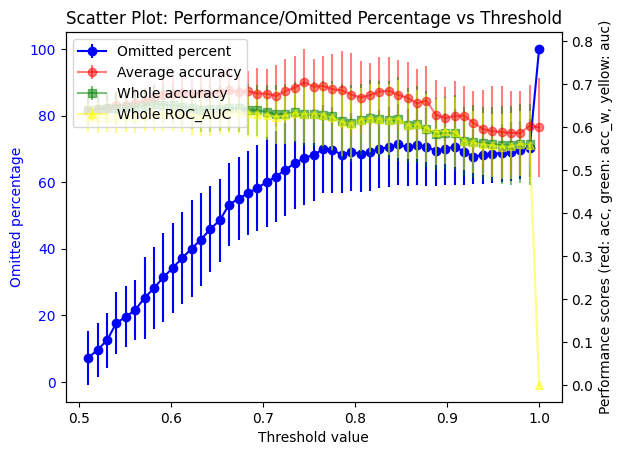

In [ ]:
# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Show and save
plt.show()
fig.savefig(f"{base}gb_noS_thres.png")

###### Scatter plot

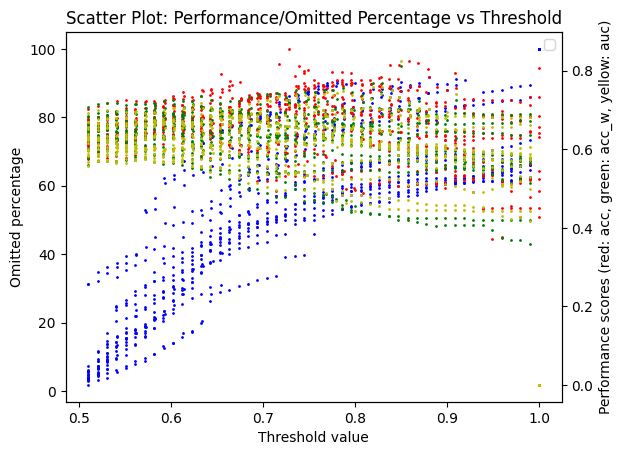

In [ ]:
# Scatter plot (Since the error is too small to show)
fig, ax1 = plt.subplots()

# Plot the first dataset with error bars
for y in o_p_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax1.scatter(x, y, color='b',s=1)

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with the same y-axis
for y in acc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='r',s=1)
for y in acc_w_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='g',s=1)
for y in auc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='y',s=1)

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

Todos: transfer y sets to draw error bar curves

##### 20 Runs Error-bar - gb S

In [ ]:
# Collect data from 20 runs and test different thresholds
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_ll = []
for i in range(1, 21):
  path = f"{base}gb2_odata_pop/best_params_list_{i}.csv"
  paras_l = read_csv(path)
  paras_l = paras_l[0]
  converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
  converted_paras_ll.append(converted_paras_l)
print(np.shape(converted_paras_ll))

(20, 9)


In [ ]:
acc_w_tl_a = []
acc_tl_a = []
auc_tl_a = []
o_p_tl_a = []
for n_run in range(20):
  print(f'%Run {n_run}')
  acc_tl = []
  acc_w_tl = []
  auc_tl = []
  o_p_tl = []
  o_p_all = 0
  thres = 0.51
  converted_paras_l = converted_paras_ll[n_run]
  while o_p_all < 90:
    print(thres)
    acc_scores = []
    n = 1
    yhat_all = []
    ytrue_all = []
    # o_p_l = []
    for i in range(len(testlist)):
      print(f"Fold {i}; ")
      paras = converted_paras_l[i]
      #1 Build training, validation and test sets/Extract individual index list
      train_v_indexes = trainlist[i]
      val_indexes = vlist[i]
      test_indexes = testlist[i]
      X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
      X_test, y_test= X[test_indexes], Y[test_indexes]
      # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      #     f"testing index: {len(test_indexes)}") #{test_indexes},

      #2 Use train and validation indexes to create the custom split
      # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
      custom_split = [-1] * len(train_v_indexes)
      for j, x in enumerate(train_v_indexes):
        if x in val_indexes: custom_split[j] = 0
      # Initialize the PredefinedSplit object
      ps = PredefinedSplit(test_fold=custom_split)

      #3 Create model with paras found by former BayesSearch
      model = create_gb_model(**paras)
      model.fit(X_train, y_train)
      yhat = model.predict_proba(X_test)

      #6 Calculate and store
      acc, o_p = prob_acc(y_test, yhat, thres)
      # auc = roc_auc_score(y_test, yhat)
      acc_scores.append(acc)
      # o_p_l.append(o_p)
      ytrue_all.append(y_test)
      yhat_all.append(yhat)
      # auc_scores.append(auc)
      # print("Iteration Accuray: {:.2f}%".format(100*acc))
      # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
      n+=1
    # a+=0.001
    thres = thres+0.01
    #For one thres
    #7 Results for all testing folds
    # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
    ytrue_all = np.concatenate(ytrue_all)
    yhat_all= np.concatenate(yhat_all)
    acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
    auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
    # Filter nan in acc
    nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
    acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
    #
    acc_ave = np.mean(acc_scores)
    acc_w_tl.append(acc_w)
    acc_tl.append(acc_ave)
    auc_tl.append(auc)
    o_p_tl.append(o_p_all)
    print("Average Accuray: {:.2f}%".format(100*acc_ave))
    print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
        {:.2f}%".format(acc_w * 100, o_p_all))
    print("Whole AUC: {:.4f}%".format(auc))
  acc_w_tl_a.append(acc_w_tl)
  acc_tl_a.append(acc_tl)
  auc_tl_a.append(auc_tl)
  o_p_tl_a.append(o_p_tl)
print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

%Run 0
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  318
Average Accuray: 64.96%
Whole Accuracy: 65.09%, Percentage of Data Omitted:         4.79%
Whole AUC: 0.6223%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  306
Average Accuray: 65.40%
Whole Accuracy: 66.01%, Percentage of Data Omitted:         8.38%
Whole AUC: 0.6289%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  297
Average Accuray: 66.58%
Whole Accuracy: 66.33%, Percentage of Data Omitted:         11.08%
Whole AUC: 0.6312%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  296
Average Accuray: 67.07%
Whole Accuracy: 66.55%, Percentage of Data Omitted:         11.38%
Whole AUC: 0.6337%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  289
Average Accuray: 67.36%
Whole Accuracy: 66.78

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  186
Average Accuray: 70.25%
Whole Accuracy: 63.44%, Percentage of Data Omitted:         44.31%
Whole AUC: 0.5855%
0.6600000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  179
Average Accuray: 69.61%
Whole Accuracy: 62.57%, Percentage of Data Omitted:         46.41%
Whole AUC: 0.5799%
0.6700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  171
Average Accuray: 68.49%
Whole Accuracy: 62.57%, Percentage of Data Omitted:         48.80%
Whole AUC: 0.5783%
0.6800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  163
Average Accuray: 68.51%
Whole Accuracy: 62.58%, Percentage of Data Omitted:         51.20%
Whole AUC: 0.5792%
0.6900000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  154
Average Accuray: 70.43%
Whole Accuracy: 61.04%, Percentage of Data Omitted:         53.89%
Whole AUC: 0.5694%
0.7000000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  148
Average Accuray: 55.04%
Whole Accuracy: 61.49%, Percentage of Data Omitted:         55.69%
Whole AUC: 0.5800%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  146
Average Accuray: 67.67%
Whole Accuracy: 61.64%, Percentage of Data Omitted:         56.29%
Whole AUC: 0.5814%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  143
Average Accuray: 68.48%
Whole Accuracy: 60.84%, Percentage of Data Omitted:         57.19%
Whole AUC: 0.5690%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  142
Average Accuray: 67.59%
Whole Accuracy: 60.56%, Percentage of Data Omitted:         57.49%
Whole AUC: 0.5684%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  139
Average Accuray: 67.59%
Whole Accuracy: 60.43%, Percentage of Data Omitted:         58.38%
Whole AUC: 0.5690%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  134
Average Accuray: 68.07%
Whole Accuracy: 59.70%, Percentage of Data Omitted:         59.88%
Whole AUC: 0.5610%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  130
Average Accuray: 67.80%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.5635%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  122
Average Accuray: 70.84%
Whole Accuracy: 59.02%, Percentage of Data Omitted:         63.47%
Whole AUC: 0.5617%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  120
Average Accuray: 68.41%
Whole Accuracy: 58.33%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.5538%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  117
Average Accuray: 57.33%
Whole Accuracy: 58.12%, Percentage of Data Omitted:         64.97%
Whole AUC: 0.5475%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  117
Average Accuray: 56.73%
Whole Accuracy: 58.12%, Percentage of Data Omitted:         64.97%
Whole AUC: 0.5475%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  115
Average Accuray: 56.73%
Whole Accuracy: 57.39%, Percentage of Data Omitted:         65.57%
Whole AUC: 0.5316%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  111
Average Accuray: 54.86%
Whole Accuracy: 56.76%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.5230%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  111
Average Accuray: 51.17%
Whole Accuracy: 56.76%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.5230%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  110
Average Accuray: 51.17%
Whole Accuracy: 56.36%, Percentage of Data Omitted:         67.07%
Whole AUC: 0.5222%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  109
Average Accuray: 48.79%


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Whole Accuracy: 56.88%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.5237%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  107
Average Accuray: 51.17%
Whole Accuracy: 57.94%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.5390%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  106
Average Accuray: 59.51%
Whole Accuracy: 57.55%, Percentage of Data Omitted:         68.26%
Whole AUC: 0.5384%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size: 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 106
Average Accuray: 58.26%
Whole Accuracy: 57.55%, Percentage of Data Omitted:         68.26%
Whole AUC: 0.5384%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  105
Average Accuray: 58.26%
Whole Accuracy: 57.14%, Percentage of Data Omitted:         68.56%
Whole AUC: 0.5293%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  103
Average Accuray: 55.48%
Whole Accuracy: 57.28%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5370%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  103
Average Accuray: 66.59%
Whole Accuracy: 57.28%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5370%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  103
Average Accuray: 66.59%
Whole Accuracy: 57.28%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5370%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  103
Average Accuray: 66.59%
Whole Accuracy: 57.28%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5370%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  103


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average Accuray: 66.59%
Whole Accuracy: 57.28%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5370%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  99
Average Accuray: 66.59%
Whole Accuracy: 58.59%, Percentage of Data Omitted:         70.36%
Whole AUC: 0.5386%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  98
Average Accuray: 54.89%
Whole Accuracy: 58.16%, Percentage of Data Omitted:         70.66%
Whole AUC: 0.5283%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  96
Average Accuray: 52.61%
Whole Accuracy: 58.33%, Percentage of Data Omitted:         71.26%
Whole AUC: 0.5265%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  93
Average Accuray: 52.11%
Whole Accuracy: 59.14%, Percentage of Data Omitted:         72.16%
Whole AUC: 0.5281%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  0
Average Accuray: 54.89%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 1
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  308
Average Accuray: 65.57%
Whole Accuracy: 63.31%, Percentage of Data Omitted:         7.78%
Whole AUC: 0.6078%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  303
Average Accuray: 62.84%
Whole Accuracy: 63.37%, Percentage of Data Omitted:         9.28%
Whole AUC: 0.6084%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  298
Average Accuray: 63.19%
Whole Accuracy: 63.76%, Percentage of Data Omitted:         10.78%
Whole AUC: 0.6132%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  293
Average Accuray: 63.87%
Whole Accuracy: 63.82%, Percentage of Data Omitted:         12.28%
Whole AUC: 0.6137%
0.55
Fold 0; 
F

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  217
Average Accuray: 69.76%
Whole Accuracy: 64.06%, Percentage of Data Omitted:         35.03%
Whole AUC: 0.6277%
0.6300000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  214
Average Accuray: 68.87%
Whole Accuracy: 64.02%, Percentage of Data Omitted:         35.93%
Whole AUC: 0.6270%
0.6400000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  203
Average Accuray: 68.94%
Whole Accuracy: 64.53%, Percentage of Data Omitted:         39.22%
Whole AUC: 0.6308%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  196
Average Accuray: 68.79%
Whole Accuracy: 64.29%, Percentage of Data Omitted:         41.32%
Whole AUC: 0.6248%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  187
Average Accuray: 73.39%
Whole Accuracy: 64.17%, Percentage of Data Omitted:         44.01%
Whole AUC: 0.6256%
0.6700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  181
Average Accuray: 71.39%
Whole Accuracy: 63.54%, Percentage of Data Omitted:         45.81%
Whole AUC: 0.6204%
0.6800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  168
Average Accuray: 71.52%
Whole Accuracy: 62.50%, Percentage of Data Omitted:         49.70%
Whole AUC: 0.6149%
0.6900000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  165
Average Accuray: 71.58%
Whole Accuracy: 61.82%, Percentage of Data Omitted:         50.60%
Whole AUC: 0.6049%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  150
Average Accuray: 70.08%
Whole Accuracy: 61.33%, Percentage of Data Omitted:         55.09%
Whole AUC: 0.6068%
0.7100000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  145
Average Accuray: 70.90%
Whole Accuracy: 61.38%, Percentage of Data Omitted:         56.59%
Whole AUC: 0.6096%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  141
Average Accuray: 74.65%
Whole Accuracy: 61.70%, Percentage of Data Omitted:         57.78%
Whole AUC: 0.6119%
0.7300000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  134
Average Accuray: 70.42%
Whole Accuracy: 59.70%, Percentage of Data Omitted:         59.88%
Whole AUC: 0.5901%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  133
Average Accuray: 68.72%
Whole Accuracy: 59.40%, Percentage of Data Omitted:         60.18%
Whole AUC: 0.5877%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  127
Average Accuray: 68.72%
Whole Accuracy: 58.27%, Percentage of Data Omitted:         61.98%
Whole AUC: 0.5767%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  118
Average Accuray: 68.46%
Whole Accuracy: 56.78%, Percentage of Data Omitted:         64.67%
Whole AUC: 0.5654%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  116
Average Accuray: 42.00%
Whole Accuracy: 57.76%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.5757%
0.7800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 56.25%
Whole Accuracy: 57.76%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.5757%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 56.25%
Whole Accuracy: 57.76%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.5757%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  112
Average Accuray: 56.25%
Whole Accuracy: 58.93%, Percentage of Data Omitted:         66.47%
Whole AUC: 0.5865%
0.8100000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  111
Average Accuray: 56.57%
Whole Accuracy: 58.56%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.5833%
0.8200000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  109
Average Accuray: 56.39%
Whole Accuracy: 58.72%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.5838%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  109
Average Accuray: 57.43%
Whole Accuracy: 58.72%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.5838%
0.8400000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  105
Average Accuray: 57.43%
Whole Accuracy: 59.05%, Percentage of Data Omitted:         68.56%
Whole AUC: 0.5869%
0.8500000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  104
Average Accuray: 56.31%
Whole Accuracy: 58.65%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.5836%
0.8600000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  102
Average Accuray: 56.13%
Whole Accuracy: 57.84%, Percentage of Data Omitted:         69.46%
Whole AUC: 0.5737%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  101
Average Accuray: 54.97%
Whole Accuracy: 57.43%, Percentage of Data Omitted:         69.76%
Whole AUC: 0.5702%
0.8800000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  96
Average Accuray: 54.78%
Whole Accuracy: 57.29%, Percentage of Data Omitted:         71.26%
Whole AUC: 0.5691%
0.8900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  93
Average Accuray: 55.57%
Whole Accuracy: 56.99%, Percentage of Data Omitted:         72.16%
Whole AUC: 0.5674%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  90
Average Accuray: 54.72%
Whole Accuracy: 56.67%, Percentage of Data Omitted:         73.05%
Whole AUC: 0.5622%
0.9100000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  87
Average Accuray: 52.81%
Whole Accuracy: 57.47%, Percentage of Data Omitted:         73.95%
Whole AUC: 0.5713%
0.9200000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  82
Average Accuray: 52.49%
Whole Accuracy: 56.10%, Percentage of Data Omitted:         75.45%
Whole AUC: 0.5543%
0.9300000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  80
Average Accuray: 50.34%
Whole Accuracy: 55.00%, Percentage of Data Omitted:         76.05%
Whole AUC: 0.5396%
0.9400000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  75
Average Accuray: 47.73%
Whole Accuracy: 54.67%, Percentage of Data Omitted:         77.54%
Whole AUC: 0.5374%
0.9500000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  72
Average Accuray: 48.32%
Whole Accuracy: 54.17%, Percentage of Data Omitted:         78.44%
Whole AUC: 0.5310%
0.9600000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  65
Average Accuray: 44.75%
Whole Accuracy: 58.46%, Percentage of Data Omitted:         80.54%
Whole AUC: 0.5750%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  59
Average Accuray: 57.64%
Whole Accuracy: 61.02%, Percentage of Data Omitted:         82.34%
Whole AUC: 0.5994%
0.9800000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  49
Average Accuray: 68.19%
Whole Accuracy: 65.31%, Percentage of Data Omitted:         85.33%
Whole AUC: 0.6448%
0.9900000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 62.95%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 2
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  326
Average Accuray: 64.23%
Whole Accuracy: 64.42%, Percentage of Data Omitted:         2.40%
Whole AUC: 0.6150%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  320
Average Accuray: 64.42%
Whole Accuracy: 65.00%, Percentage of Data Omitted:         4.19%
Whole AUC: 0.6198%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  312
Average Accuray: 65.24%
Whole Accuracy: 64.74%, Percentage of Data Omitted:         6.59%
Whole AUC: 0.6176%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  308
Average Accuray: 65.21%
Whole Accuracy: 64.94%, Percentage of Data Omitted:         7.78%
Whole AUC: 0.6156%
0.55
Fold 0; 
Fold 1; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  150
Average Accuray: 73.71%
Whole Accuracy: 68.67%, Percentage of Data Omitted:         55.09%
Whole AUC: 0.6598%
0.6300000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  141
Average Accuray: 74.24%
Whole Accuracy: 67.38%, Percentage of Data Omitted:         57.78%
Whole AUC: 0.6551%
0.6400000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  139
Average Accuray: 68.04%
Whole Accuracy: 67.63%, Percentage of Data Omitted:         58.38%
Whole AUC: 0.6551%
0.6500000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  133
Average Accuray: 68.19%
Whole Accuracy: 69.17%, Percentage of Data Omitted:         60.18%
Whole AUC: 0.6689%
0.6600000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  131
Average Accuray: 69.58%
Whole Accuracy: 68.70%, Percentage of Data Omitted:         60.78%
Whole AUC: 0.6633%
0.6700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  130
Average Accuray: 69.03%
Whole Accuracy: 68.46%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.6588%
0.6800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  129
Average Accuray: 68.78%
Whole Accuracy: 68.22%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6541%
0.6900000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  124
Average Accuray: 68.48%
Whole Accuracy: 69.35%, Percentage of Data Omitted:         62.87%
Whole AUC: 0.6667%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  123
Average Accuray: 70.20%
Whole Accuracy: 69.11%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.6655%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  114
Average Accuray: 70.09%
Whole Accuracy: 70.18%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.6732%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  111
Average Accuray: 70.54%
Whole Accuracy: 70.27%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.6763%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  110
Average Accuray: 70.43%
Whole Accuracy: 70.00%, Percentage of Data Omitted:         67.07%
Whole AUC: 0.6749%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  108
Average Accuray: 69.60%
Whole Accuracy: 71.30%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.6868%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  101
Average Accuray: 71.14%
Whole Accuracy: 71.29%, Percentage of Data Omitted:         69.76%
Whole AUC: 0.6925%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  97
Average Accuray: 71.54%
Whole Accuracy: 71.13%, Percentage of Data Omitted:         70.96%
Whole AUC: 0.6910%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  96
Average Accuray: 68.20%
Whole Accuracy: 71.88%, Percentage of Data Omitted:         71.26%
Whole AUC: 0.6984%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  96
Average Accuray: 76.54%
Whole Accuracy: 71.88%, Percentage of Data Omitted:         71.26%
Whole AUC: 0.6984%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  95
Average Accuray: 76.54%
Whole Accuracy: 71.58%, Percentage of Data Omitted:         71.56%
Whole AUC: 0.6930%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  93
Average Accuray: 71.84%
Whole Accuracy: 72.04%, Percentage of Data Omitted:         72.16%
Whole AUC: 0.6952%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  89
Average Accuray: 73.51%
Whole Accuracy: 71.91%, Percentage of Data Omitted:         73.35%
Whole AUC: 0.6931%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  79
Average Accuray: 76.84%
Whole Accuracy: 70.89%, Percentage of Data Omitted:         76.35%
Whole AUC: 0.6905%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  77
Average Accuray: 71.89%
Whole Accuracy: 71.43%, Percentage of Data Omitted:         76.95%
Whole AUC: 0.6978%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  77
Average Accuray: 72.20%
Whole Accuracy: 71.43%, Percentage of Data Omitted:         76.95%
Whole AUC: 0.6978%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  76
Average Accuray: 72.20%
Whole Accuracy: 71.05%, Percentage of Data Omitted:         77.25%
Whole AUC: 0.6953%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  63
Average Accuray: 71.99%
Whole Accuracy: 69.84%, Percentage of Data Omitted:         81.14%
Whole AUC: 0.6310%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  62
Average Accuray: 75.94%
Whole Accuracy: 70.97%, Percentage of Data Omitted:         81.44%
Whole AUC: 0.6411%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  62
Average Accuray: 77.98%
Whole Accuracy: 70.97%, Percentage of Data Omitted:         81.44%
Whole AUC: 0.6411%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  62
Average Accuray: 77.98%
Whole Accuracy: 70.97%, Percentage of Data Omitted:         81.44%
Whole AUC: 0.6411%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  59
Average Accuray: 77.98%
Whole Accuracy: 69.49%, Percentage of Data Omitted:         82.34%
Whole AUC: 0.6353%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  52
Average Accuray: 76.91%
Whole Accuracy: 65.38%, Percentage of Data Omitted:         84.43%
Whole AUC: 0.6175%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  52
Average Accuray: 68.90%
Whole Accuracy: 65.38%, Percentage of Data Omitted:         84.43%
Whole AUC: 0.6175%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  46
Average Accuray: 68.90%
Whole Accuracy: 63.04%, Percentage of Data Omitted:         86.23%
Whole AUC: 0.6096%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  45
Average Accuray: 73.67%
Whole Accuracy: 62.22%, Percentage of Data Omitted:         86.53%
Whole AUC: 0.6050%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  45
Average Accuray: 60.50%
Whole Accuracy: 62.22%, Percentage of Data Omitted:         86.53%
Whole AUC: 0.6050%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  45
Average Accuray: 60.50%
Whole Accuracy: 62.22%, Percentage of Data Omitted:         86.53%
Whole AUC: 0.6050%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  44
Average Accuray: 60.50%
Whole Accuracy: 63.64%, Percentage of Data Omitted:         86.83%
Whole AUC: 0.6208%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  44
Average Accuray: 62.08%
Whole Accuracy: 63.64%, Percentage of Data Omitted:         86.83%
Whole AUC: 0.6208%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  0
Average Accuray: 62.08%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 3
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  322
Average Accuray: 66.00%
Whole Accuracy: 64.29%, Percentage of Data Omitted:         3.59%
Whole AUC: 0.6239%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  315
Average Accuray: 65.90%
Whole Accuracy: 65.40%, Percentage of Data Omitted:         5.69%
Whole AUC: 0.6354%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  309
Average Accuray: 67.31%
Whole Accuracy: 65.37%, Percentage of Data Omitted:         7.49%
Whole AUC: 0.6357%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  304
Average Accuray: 67.62%
Whole Accuracy: 65.46%, Percentage of Data Omitted:         8.98%
Whole AUC: 0.6353%
0.55
Fold 0; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  214
Average Accuray: 68.73%
Whole Accuracy: 62.62%, Percentage of Data Omitted:         35.93%
Whole AUC: 0.6205%
0.6300000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  210
Average Accuray: 67.60%
Whole Accuracy: 62.86%, Percentage of Data Omitted:         37.13%
Whole AUC: 0.6227%
0.6400000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  204
Average Accuray: 71.24%
Whole Accuracy: 61.76%, Percentage of Data Omitted:         38.92%
Whole AUC: 0.6114%
0.6500000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  191
Average Accuray: 66.19%
Whole Accuracy: 60.73%, Percentage of Data Omitted:         42.81%
Whole AUC: 0.6045%
0.6600000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  189
Average Accuray: 65.27%
Whole Accuracy: 60.32%, Percentage of Data Omitted:         43.41%
Whole AUC: 0.6002%
0.6700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  188
Average Accuray: 64.72%
Whole Accuracy: 60.64%, Percentage of Data Omitted:         43.71%
Whole AUC: 0.6029%
0.6800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  186
Average Accuray: 65.05%
Whole Accuracy: 61.29%, Percentage of Data Omitted:         44.31%
Whole AUC: 0.6094%
0.6900000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  184
Average Accuray: 66.08%
Whole Accuracy: 61.41%, Percentage of Data Omitted:         44.91%
Whole AUC: 0.6094%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  177
Average Accuray: 66.48%
Whole Accuracy: 62.15%, Percentage of Data Omitted:         47.01%
Whole AUC: 0.6162%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  174
Average Accuray: 68.67%
Whole Accuracy: 61.49%, Percentage of Data Omitted:         47.90%
Whole AUC: 0.6102%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  173
Average Accuray: 67.68%
Whole Accuracy: 61.27%, Percentage of Data Omitted:         48.20%
Whole AUC: 0.6086%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  172
Average Accuray: 67.12%
Whole Accuracy: 61.63%, Percentage of Data Omitted:         48.50%
Whole AUC: 0.6117%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  171
Average Accuray: 67.65%
Whole Accuracy: 61.99%, Percentage of Data Omitted:         48.80%
Whole AUC: 0.6148%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  167
Average Accuray: 68.23%
Whole Accuracy: 62.28%, Percentage of Data Omitted:         50.00%
Whole AUC: 0.6188%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  166
Average Accuray: 72.22%
Whole Accuracy: 62.05%, Percentage of Data Omitted:         50.30%
Whole AUC: 0.6172%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  163
Average Accuray: 72.02%
Whole Accuracy: 61.96%, Percentage of Data Omitted:         51.20%
Whole AUC: 0.6158%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  161
Average Accuray: 71.83%
Whole Accuracy: 62.11%, Percentage of Data Omitted:         51.80%
Whole AUC: 0.6169%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  157
Average Accuray: 72.50%
Whole Accuracy: 61.78%, Percentage of Data Omitted:         52.99%
Whole AUC: 0.6122%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  156
Average Accuray: 67.51%
Whole Accuracy: 62.18%, Percentage of Data Omitted:         53.29%
Whole AUC: 0.6157%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  155
Average Accuray: 68.66%
Whole Accuracy: 62.58%, Percentage of Data Omitted:         53.59%
Whole AUC: 0.6193%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  153
Average Accuray: 70.03%
Whole Accuracy: 62.09%, Percentage of Data Omitted:         54.19%
Whole AUC: 0.6157%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  151
Average Accuray: 69.22%
Whole Accuracy: 61.59%, Percentage of Data Omitted:         54.79%
Whole AUC: 0.6106%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  149
Average Accuray: 68.33%
Whole Accuracy: 61.74%, Percentage of Data Omitted:         55.39%
Whole AUC: 0.6131%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  142
Average Accuray: 70.00%
Whole Accuracy: 61.27%, Percentage of Data Omitted:         57.49%
Whole AUC: 0.6053%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  138
Average Accuray: 73.13%
Whole Accuracy: 60.87%, Percentage of Data Omitted:         58.68%
Whole AUC: 0.5994%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  136
Average Accuray: 67.67%
Whole Accuracy: 60.29%, Percentage of Data Omitted:         59.28%
Whole AUC: 0.5933%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  135
Average Accuray: 66.65%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         59.58%
Whole AUC: 0.5913%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  134
Average Accuray: 65.76%
Whole Accuracy: 59.70%, Percentage of Data Omitted:         59.88%
Whole AUC: 0.5870%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  132
Average Accuray: 65.40%
Whole Accuracy: 59.09%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.5828%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  130
Average Accuray: 63.82%
Whole Accuracy: 58.46%, Percentage of Data Omitted:         61.08%
Whole AUC: 0.5762%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  129
Average Accuray: 61.71%
Whole Accuracy: 58.91%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.5801%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  126
Average Accuray: 65.46%
Whole Accuracy: 58.73%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.5774%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  126
Average Accuray: 71.71%
Whole Accuracy: 58.73%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.5774%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  124
Average Accuray: 71.71%
Whole Accuracy: 58.87%, Percentage of Data Omitted:         62.87%
Whole AUC: 0.5801%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  121
Average Accuray: 63.59%
Whole Accuracy: 58.68%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.5758%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  120
Average Accuray: 63.87%
Whole Accuracy: 58.33%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.5734%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  120
Average Accuray: 63.13%
Whole Accuracy: 58.33%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.5734%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  0
Average Accuray: 63.13%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 4
0.51
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  308
Average Accuray: 66.34%
Whole Accuracy: 67.53%, Percentage of Data Omitted:         7.78%
Whole AUC: 0.6624%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  300
Average Accuray: 66.70%
Whole Accuracy: 68.00%, Percentage of Data Omitted:         10.18%
Whole AUC: 0.6662%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  293
Average Accuray: 67.71%
Whole Accuracy: 68.26%, Percentage of Data Omitted:         12.28%
Whole AUC: 0.6674%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  285
Average Accuray: 68.02%
Whole Accuracy: 68.07%, Percentage of Data Omitted:         14.67%
Whole AUC: 0.6658%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  280
Average Accuray: 67.93%
Whole Accuracy: 67.86%, Percentage of Dat

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  183
Average Accuray: 71.31%
Whole Accuracy: 67.21%, Percentage of Data Omitted:         45.21%
Whole AUC: 0.6549%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  167
Average Accuray: 71.16%
Whole Accuracy: 66.47%, Percentage of Data Omitted:         50.00%
Whole AUC: 0.6534%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  163
Average Accuray: 70.02%
Whole Accuracy: 66.26%, Percentage of Data Omitted:         51.20%
Whole AUC: 0.6500%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  157
Average Accuray: 71.67%
Whole Accuracy: 67.52%, Percentage of Data Omitted:         52.99%
Whole AUC: 0.6633%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  152
Average Accuray: 72.78%
Whole Accuracy: 67.11%, Percentage of Data Omitted:         54.49%
Whole AUC: 0.6604%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  133
Average Accuray: 72.68%
Whole Accuracy: 65.41%, Percentage of Data Omitted:         60.18%
Whole AUC: 0.6485%
0.7000000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 70.14%
Whole Accuracy: 65.12%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6472%
0.7100000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 70.33%
Whole Accuracy: 65.12%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6472%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  127
Average Accuray: 70.33%
Whole Accuracy: 64.57%, Percentage of Data Omitted:         61.98%
Whole AUC: 0.6415%
0.7300000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  121
Average Accuray: 70.25%
Whole Accuracy: 64.46%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.6410%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  119
Average Accuray: 70.28%
Whole Accuracy: 64.71%, Percentage of Data Omitted:         64.37%
Whole AUC: 0.6425%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 70.67%
Whole Accuracy: 64.49%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.6421%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  101
Average Accuray: 51.59%
Whole Accuracy: 64.36%, Percentage of Data Omitted:         69.76%
Whole AUC: 0.6417%
0.7700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  97
Average Accuray: 52.26%
Whole Accuracy: 64.95%, Percentage of Data Omitted:         70.96%
Whole AUC: 0.6475%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  94
Average Accuray: 65.32%
Whole Accuracy: 64.89%, Percentage of Data Omitted:         71.86%
Whole AUC: 0.6478%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  91
Average Accuray: 66.06%
Whole Accuracy: 67.03%, Percentage of Data Omitted:         72.75%
Whole AUC: 0.6692%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  86
Average Accuray: 73.47%
Whole Accuracy: 68.60%, Percentage of Data Omitted:         74.25%
Whole AUC: 0.6837%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  83
Average Accuray: 75.78%
Whole Accuracy: 67.47%, Percentage of Data Omitted:         75.15%
Whole AUC: 0.6730%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  80
Average Accuray: 75.78%
Whole Accuracy: 66.25%, Percentage of Data Omitted:         76.05%
Whole AUC: 0.6614%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  75
Average Accuray: 67.12%
Whole Accuracy: 65.33%, Percentage of Data Omitted:         77.54%
Whole AUC: 0.6540%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  75
Average Accuray: 64.47%
Whole Accuracy: 65.33%, Percentage of Data Omitted:         77.54%
Whole AUC: 0.6540%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  73
Average Accuray: 64.47%
Whole Accuracy: 65.75%, Percentage of Data Omitted:         78.14%
Whole AUC: 0.6569%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  70
Average Accuray: 64.70%
Whole Accuracy: 64.29%, Percentage of Data Omitted:         79.04%
Whole AUC: 0.6413%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  69
Average Accuray: 56.17%
Whole Accuracy: 63.77%, Percentage of Data Omitted:         79.34%
Whole AUC: 0.6370%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  63
Average Accuray: 55.97%
Whole Accuracy: 65.08%, Percentage of Data Omitted:         81.14%
Whole AUC: 0.6485%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  63
Average Accuray: 58.08%
Whole Accuracy: 65.08%, Percentage of Data Omitted:         81.14%
Whole AUC: 0.6485%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  59
Average Accuray: 58.08%
Whole Accuracy: 64.41%, Percentage of Data Omitted:         82.34%
Whole AUC: 0.6400%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  56
Average Accuray: 57.10%
Whole Accuracy: 66.07%, Percentage of Data Omitted:         83.23%
Whole AUC: 0.6551%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  54
Average Accuray: 55.87%
Whole Accuracy: 68.52%, Percentage of Data Omitted:         83.83%
Whole AUC: 0.6793%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  52
Average Accuray: 58.89%
Whole Accuracy: 69.23%, Percentage of Data Omitted:         84.43%
Whole AUC: 0.6845%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  47
Average Accuray: 61.36%
Whole Accuracy: 72.34%, Percentage of Data Omitted:         85.93%
Whole AUC: 0.7139%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  42
Average Accuray: 73.55%
Whole Accuracy: 71.43%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.7035%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  36
Average Accuray: 85.37%
Whole Accuracy: 72.22%, Percentage of Data Omitted:         89.22%
Whole AUC: 0.7143%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  31
Average Accuray: 72.22%
Whole Accuracy: 74.19%, Percentage of Data Omitted:         90.72%
Whole AUC: 0.7395%
%Run 5
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  319
Average Accuray: 64.26%
Whole Accuracy: 63.95%, Percentage of Data Omitted:         4.49%
Whole AUC: 0.6292%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  315
Average Accuray: 65.30%
Whole Accuracy: 64.76%, Percentage of Data Omitted:         5.69%
Whole AUC: 0.6369%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  307
Average Accuray: 66.12%
Whole Accuracy: 64.50%, Percentage of Data Omitted:         8.08%
Whole AUC: 0.6318%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  303
Average Accuray: 65.32%
Whole Accuracy: 64.36%, Percentage of Data Omitted:         9.28%
Whole AUC: 0.6315%
0.55
Fold 0; 
Fold 1; 
F

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  161
Average Accuray: 70.94%
Whole Accuracy: 66.46%, Percentage of Data Omitted:         51.80%
Whole AUC: 0.6576%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  158
Average Accuray: 70.85%
Whole Accuracy: 66.46%, Percentage of Data Omitted:         52.69%
Whole AUC: 0.6576%
0.7300000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  142
Average Accuray: 70.72%
Whole Accuracy: 64.79%, Percentage of Data Omitted:         57.49%
Whole AUC: 0.6458%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  140
Average Accuray: 69.27%
Whole Accuracy: 65.00%, Percentage of Data Omitted:         58.08%
Whole AUC: 0.6480%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  138
Average Accuray: 69.44%
Whole Accuracy: 64.49%, Percentage of Data Omitted:         58.68%
Whole AUC: 0.6436%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  137
Average Accuray: 68.98%
Whole Accuracy: 64.96%, Percentage of Data Omitted:         58.98%
Whole AUC: 0.6485%
0.7700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  135
Average Accuray: 69.16%
Whole Accuracy: 64.44%, Percentage of Data Omitted:         59.58%
Whole AUC: 0.6438%
0.7800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  121
Average Accuray: 69.07%
Whole Accuracy: 65.29%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.6517%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  112
Average Accuray: 70.71%
Whole Accuracy: 64.29%, Percentage of Data Omitted:         66.47%
Whole AUC: 0.6418%
0.8000000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  106
Average Accuray: 70.63%
Whole Accuracy: 64.15%, Percentage of Data Omitted:         68.26%
Whole AUC: 0.6410%
0.8100000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  104
Average Accuray: 58.01%
Whole Accuracy: 64.42%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.6439%
0.8200000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  99
Average Accuray: 58.17%
Whole Accuracy: 64.65%, Percentage of Data Omitted:         70.36%
Whole AUC: 0.6465%
0.8300000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  96
Average Accuray: 62.84%
Whole Accuracy: 63.54%, Percentage of Data Omitted:         71.26%
Whole AUC: 0.6352%
0.8400000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  94
Average Accuray: 61.29%
Whole Accuracy: 64.89%, Percentage of Data Omitted:         71.86%
Whole AUC: 0.6495%
0.8500000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  93
Average Accuray: 62.90%
Whole Accuracy: 64.52%, Percentage of Data Omitted:         72.16%
Whole AUC: 0.6456%
0.8600000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  93
Average Accuray: 62.68%
Whole Accuracy: 64.52%, Percentage of Data Omitted:         72.16%
Whole AUC: 0.6456%
0.8700000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  91
Average Accuray: 62.68%
Whole Accuracy: 64.84%, Percentage of Data Omitted:         72.75%
Whole AUC: 0.6485%
0.8800000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  85
Average Accuray: 62.68%
Whole Accuracy: 64.71%, Percentage of Data Omitted:         74.55%
Whole AUC: 0.6483%
0.8900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  85
Average Accuray: 63.86%
Whole Accuracy: 64.71%, Percentage of Data Omitted:         74.55%
Whole AUC: 0.6483%
0.9000000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  81
Average Accuray: 63.86%
Whole Accuracy: 64.20%, Percentage of Data Omitted:         75.75%
Whole AUC: 0.6415%
0.9100000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  81
Average Accuray: 64.02%
Whole Accuracy: 64.20%, Percentage of Data Omitted:         75.75%
Whole AUC: 0.6415%
0.9200000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  74
Average Accuray: 64.02%
Whole Accuracy: 66.22%, Percentage of Data Omitted:         77.84%
Whole AUC: 0.6608%
0.9300000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  72
Average Accuray: 67.01%
Whole Accuracy: 68.06%, Percentage of Data Omitted:         78.44%
Whole AUC: 0.6806%
0.9400000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  65
Average Accuray: 68.32%
Whole Accuracy: 67.69%, Percentage of Data Omitted:         80.54%
Whole AUC: 0.6727%
0.9500000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  62
Average Accuray: 64.79%
Whole Accuracy: 66.13%, Percentage of Data Omitted:         81.44%
Whole AUC: 0.6583%
0.9600000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  57
Average Accuray: 63.53%
Whole Accuracy: 64.91%, Percentage of Data Omitted:         82.93%
Whole AUC: 0.6402%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  49
Average Accuray: 65.89%
Whole Accuracy: 63.27%, Percentage of Data Omitted:         85.33%
Whole AUC: 0.6121%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  46
Average Accuray: 60.33%
Whole Accuracy: 65.22%, Percentage of Data Omitted:         86.23%
Whole AUC: 0.6346%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 77.00%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 6
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  314
Average Accuray: 63.94%
Whole Accuracy: 66.24%, Percentage of Data Omitted:         5.99%
Whole AUC: 0.6472%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  305
Average Accuray: 64.28%
Whole Accuracy: 67.21%, Percentage of Data Omitted:         8.68%
Whole AUC: 0.6556%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  301
Average Accuray: 65.30%
Whole Accuracy: 67.77%, Percentage of Data Omitted:         9.88%
Whole AUC: 0.6610%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  297
Average Accuray: 66.06%
Whole Accuracy: 68.01%, Percentage of Data Omitted:         11.08%
Whole AUC: 0.6633%
0.55
Fold 0; 
Fold 1; 
Fo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  111
Average Accuray: 72.57%
Whole Accuracy: 74.77%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.7376%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  106
Average Accuray: 72.38%
Whole Accuracy: 75.47%, Percentage of Data Omitted:         68.26%
Whole AUC: 0.7454%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  95
Average Accuray: 72.78%
Whole Accuracy: 77.89%, Percentage of Data Omitted:         71.56%
Whole AUC: 0.7599%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  72
Average Accuray: 76.24%
Whole Accuracy: 80.56%, Percentage of Data Omitted:         78.44%
Whole AUC: 0.7972%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  61
Average Accuray: 82.72%
Whole Accuracy: 80.33%, Percentage of Data Omitted:         81.74%
Whole AUC: 0.7965%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  58
Average Accuray: 85.65%
Whole Accuracy: 81.03%, Percentage of Data Omitted:         82.63%
Whole AUC: 0.8059%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  51
Average Accuray: 88.51%
Whole Accuracy: 80.39%, Percentage of Data Omitted:         84.73%
Whole AUC: 0.7892%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  43
Average Accuray: 81.57%
Whole Accuracy: 79.07%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.7733%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  42
Average Accuray: 78.43%
Whole Accuracy: 78.57%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.7635%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  42
Average Accuray: 77.58%
Whole Accuracy: 78.57%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.7635%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  24
Average Accuray: 77.58%
Whole Accuracy: 75.00%, Percentage of Data Omitted:         92.81%
Whole AUC: 0.7333%
%Run 7
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  316
Average Accuray: 64.12%
Whole Accuracy: 64.24%, Percentage of Data Omitted:         5.39%
Whole AUC: 0.6272%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  303
Average Accuray: 64.75%
Whole Accuracy: 66.01%, Percentage of Data Omitted:         9.28%
Whole AUC: 0.6435%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  275
Average Accuray: 67.00%
Whole Accuracy: 66.18%, Percentage of Data Omitted:         17.66%
Whole AUC: 0.6494%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  271
Average Accuray: 67.23%
Whole Accuracy: 66.79%, Percentage of Data Omitted:         18.86%
Whole AUC: 0.6544%
0.55
Fold 0; 
Fold 1; 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  156
Average Accuray: 74.38%
Whole Accuracy: 66.03%, Percentage of Data Omitted:         53.29%
Whole AUC: 0.6595%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  151
Average Accuray: 78.89%
Whole Accuracy: 65.56%, Percentage of Data Omitted:         54.79%
Whole AUC: 0.6553%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  149
Average Accuray: 75.85%
Whole Accuracy: 65.10%, Percentage of Data Omitted:         55.39%
Whole AUC: 0.6506%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  140
Average Accuray: 75.69%
Whole Accuracy: 65.00%, Percentage of Data Omitted:         58.08%
Whole AUC: 0.6497%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  138
Average Accuray: 68.33%
Whole Accuracy: 65.94%, Percentage of Data Omitted:         58.68%
Whole AUC: 0.6595%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  135
Average Accuray: 70.28%
Whole Accuracy: 65.93%, Percentage of Data Omitted:         59.58%
Whole AUC: 0.6597%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  133
Average Accuray: 70.86%
Whole Accuracy: 66.92%, Percentage of Data Omitted:         60.18%
Whole AUC: 0.6707%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  127
Average Accuray: 72.22%
Whole Accuracy: 66.93%, Percentage of Data Omitted:         61.98%
Whole AUC: 0.6721%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 72.38%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.6694%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  123
Average Accuray: 72.38%
Whole Accuracy: 68.29%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.6866%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 75.15%
Whole Accuracy: 67.24%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.6750%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  111
Average Accuray: 75.44%
Whole Accuracy: 67.57%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.6784%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  110
Average Accuray: 77.16%
Whole Accuracy: 67.27%, Percentage of Data Omitted:         67.07%
Whole AUC: 0.6746%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  93
Average Accuray: 77.16%
Whole Accuracy: 65.59%, Percentage of Data Omitted:         72.16%
Whole AUC: 0.6500%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  92
Average Accuray: 75.80%
Whole Accuracy: 65.22%, Percentage of Data Omitted:         72.46%
Whole AUC: 0.6439%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  84
Average Accuray: 75.57%
Whole Accuracy: 64.29%, Percentage of Data Omitted:         74.85%
Whole AUC: 0.6190%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  83
Average Accuray: 74.41%
Whole Accuracy: 63.86%, Percentage of Data Omitted:         75.15%
Whole AUC: 0.6105%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  75
Average Accuray: 74.41%
Whole Accuracy: 65.33%, Percentage of Data Omitted:         77.54%
Whole AUC: 0.6339%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  68
Average Accuray: 74.38%
Whole Accuracy: 63.24%, Percentage of Data Omitted:         79.64%
Whole AUC: 0.6324%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  64
Average Accuray: 71.83%
Whole Accuracy: 60.94%, Percentage of Data Omitted:         80.84%
Whole AUC: 0.6094%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  52
Average Accuray: 62.81%
Whole Accuracy: 67.31%, Percentage of Data Omitted:         84.43%
Whole AUC: 0.6548%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  52
Average Accuray: 75.98%
Whole Accuracy: 67.31%, Percentage of Data Omitted:         84.43%
Whole AUC: 0.6548%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  51
Average Accuray: 75.98%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         84.73%
Whole AUC: 0.6528%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  48
Average Accuray: 67.98%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         85.63%
Whole AUC: 0.6557%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  43
Average Accuray: 70.29%
Whole Accuracy: 65.12%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.6107%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  42
Average Accuray: 65.43%
Whole Accuracy: 64.29%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.6098%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  42
Average Accuray: 64.55%
Whole Accuracy: 64.29%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.6098%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  40
Average Accuray: 64.55%
Whole Accuracy: 62.50%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.5884%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  38
Average Accuray: 62.50%
Whole Accuracy: 63.16%, Percentage of Data Omitted:         88.62%
Whole AUC: 0.5938%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  35
Average Accuray: 62.78%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         89.52%
Whole AUC: 0.5674%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 58.33%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 8
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  313
Average Accuray: 61.60%
Whole Accuracy: 62.30%, Percentage of Data Omitted:         6.29%
Whole AUC: 0.5705%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  303
Average Accuray: 61.40%
Whole Accuracy: 62.71%, Percentage of Data Omitted:         9.28%
Whole AUC: 0.5682%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  271
Average Accuray: 61.32%
Whole Accuracy: 61.25%, Percentage of Data Omitted:         18.86%
Whole AUC: 0.5687%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  261
Average Accuray: 59.42%
Whole Accuracy: 62.07%, Percentage of Data Omitted:         21.86%
Whole AUC: 0.5710%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  256
Average Accuray: 61.34%
Whole Accuracy: 63.28%, Percentage of Data Omitted:         23.35%
Whole AUC: 0.5805%
0.56
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  246
Average Accuray: 63.26%
Whole Accuracy: 63.82%, Percentage of Data Omitted:         26.35%
Whole AUC: 0.5804%
0.5700000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  147
Average Accuray: 64.87%
Whole Accuracy: 65.99%, Percentage of Data Omitted:         55.99%
Whole AUC: 0.6251%
0.5800000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  136
Average Accuray: 66.86%
Whole Accuracy: 65.44%, Percentage of Data Omitted:         59.28%
Whole AUC: 0.6214%
0.5900000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  126
Average Accuray: 68.46%
Whole Accuracy: 63.49%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.6064%
0.6000000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  115
Average Accuray: 62.13%
Whole Accuracy: 62.61%, Percentage of Data Omitted:         65.57%
Whole AUC: 0.6033%
0.6100000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  99
Average Accuray: 62.18%
Whole Accuracy: 60.61%, Percentage of Data Omitted:         70.36%
Whole AUC: 0.5904%
0.6200000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  91
Average Accuray: 61.50%
Whole Accuracy: 59.34%, Percentage of Data Omitted:         72.75%
Whole AUC: 0.5807%
0.6300000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  81
Average Accuray: 60.14%
Whole Accuracy: 62.96%, Percentage of Data Omitted:         75.75%
Whole AUC: 0.6022%
0.6400000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  77
Average Accuray: 71.81%
Whole Accuracy: 61.04%, Percentage of Data Omitted:         76.95%
Whole AUC: 0.5929%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  56
Average Accuray: 65.03%
Whole Accuracy: 58.93%, Percentage of Data Omitted:         83.23%
Whole AUC: 0.5856%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  53
Average Accuray: 61.83%
Whole Accuracy: 60.38%, Percentage of Data Omitted:         84.13%
Whole AUC: 0.6019%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  48
Average Accuray: 64.85%
Whole Accuracy: 56.25%, Percentage of Data Omitted:         85.63%
Whole AUC: 0.5682%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  43
Average Accuray: 62.54%
Whole Accuracy: 53.49%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.5441%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  39
Average Accuray: 59.39%
Whole Accuracy: 51.28%, Percentage of Data Omitted:         88.32%
Whole AUC: 0.5204%
0.7000000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  37
Average Accuray: 51.58%
Whole Accuracy: 51.35%, Percentage of Data Omitted:         88.92%
Whole AUC: 0.5193%
0.7100000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  35
Average Accuray: 52.35%
Whole Accuracy: 54.29%, Percentage of Data Omitted:         89.52%
Whole AUC: 0.5500%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  34
Average Accuray: 56.67%
Whole Accuracy: 55.88%, Percentage of Data Omitted:         89.82%
Whole AUC: 0.5714%
0.7300000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  33
Average Accuray: 59.29%
Whole Accuracy: 54.55%, Percentage of Data Omitted:         90.12%
Whole AUC: 0.5577%
%Run 9
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  326
Average Accuray: 61.13%
Whole Accuracy: 61.96%, Percentage of Data Omitted:         2.40%
Whole AUC: 0.6076%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  316
Average Accuray: 61.53%
Whole Accuracy: 62.03%, Percentage of Data Omitted:         5.39%
Whole AUC: 0.6054%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  313
Average Accuray: 62.08%
Whole Accuracy: 62.30%, Percentage of Data Omitted:         6.29%
Whole AUC: 0.6074%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  309
Average Accuray: 62.57%
Whole Accuracy: 62.14%, Percentage of Data Omitted:         7.49%
Whole AUC: 0.6036%
0.55
Fold 0; 
Fold 1; 
F

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  258
Average Accuray: 64.27%
Whole Accuracy: 63.18%, Percentage of Data Omitted:         22.75%
Whole AUC: 0.6193%
0.5900000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  253
Average Accuray: 64.91%
Whole Accuracy: 62.45%, Percentage of Data Omitted:         24.25%
Whole AUC: 0.6129%
0.6000000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  248
Average Accuray: 64.58%
Whole Accuracy: 62.50%, Percentage of Data Omitted:         25.75%
Whole AUC: 0.6135%
0.6100000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  240
Average Accuray: 64.44%
Whole Accuracy: 61.67%, Percentage of Data Omitted:         28.14%
Whole AUC: 0.6083%
0.6200000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  230
Average Accuray: 64.09%
Whole Accuracy: 60.87%, Percentage of Data Omitted:         31.14%
Whole AUC: 0.6014%
0.6300000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  228
Average Accuray: 63.50%
Whole Accuracy: 60.53%, Percentage of Data Omitted:         31.74%
Whole AUC: 0.5977%
0.6400000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  219
Average Accuray: 62.68%
Whole Accuracy: 59.82%, Percentage of Data Omitted:         34.43%
Whole AUC: 0.5924%
0.6500000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  214
Average Accuray: 62.22%
Whole Accuracy: 59.81%, Percentage of Data Omitted:         35.93%
Whole AUC: 0.5935%
0.6600000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  206
Average Accuray: 60.43%
Whole Accuracy: 60.68%, Percentage of Data Omitted:         38.32%
Whole AUC: 0.6056%
0.6700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  204
Average Accuray: 61.24%
Whole Accuracy: 60.78%, Percentage of Data Omitted:         38.92%
Whole AUC: 0.6055%
0.6800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  200
Average Accuray: 61.52%
Whole Accuracy: 61.00%, Percentage of Data Omitted:         40.12%
Whole AUC: 0.6101%
0.6900000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  198
Average Accuray: 61.45%
Whole Accuracy: 61.11%, Percentage of Data Omitted:         40.72%
Whole AUC: 0.6100%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  197
Average Accuray: 61.87%
Whole Accuracy: 60.91%, Percentage of Data Omitted:         41.02%
Whole AUC: 0.6084%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  196
Average Accuray: 61.74%
Whole Accuracy: 60.71%, Percentage of Data Omitted:         41.32%
Whole AUC: 0.6068%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  195
Average Accuray: 61.60%
Whole Accuracy: 61.03%, Percentage of Data Omitted:         41.62%
Whole AUC: 0.6094%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  190
Average Accuray: 61.74%
Whole Accuracy: 61.05%, Percentage of Data Omitted:         43.11%
Whole AUC: 0.6125%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  187
Average Accuray: 62.80%
Whole Accuracy: 60.43%, Percentage of Data Omitted:         44.01%
Whole AUC: 0.6065%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  186
Average Accuray: 61.66%
Whole Accuracy: 60.22%, Percentage of Data Omitted:         44.31%
Whole AUC: 0.6038%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  179
Average Accuray: 61.58%
Whole Accuracy: 59.78%, Percentage of Data Omitted:         46.41%
Whole AUC: 0.6033%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  177
Average Accuray: 59.61%
Whole Accuracy: 59.89%, Percentage of Data Omitted:         47.01%
Whole AUC: 0.6052%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  174
Average Accuray: 59.85%
Whole Accuracy: 59.77%, Percentage of Data Omitted:         47.90%
Whole AUC: 0.6039%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  174
Average Accuray: 59.49%
Whole Accuracy: 59.77%, Percentage of Data Omitted:         47.90%
Whole AUC: 0.6039%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  174
Average Accuray: 59.49%
Whole Accuracy: 59.77%, Percentage of Data Omitted:         47.90%
Whole AUC: 0.6039%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  174
Average Accuray: 59.49%
Whole Accuracy: 59.77%, Percentage of Data Omitted:         47.90%
Whole AUC: 0.6039%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  170
Average Accuray: 59.49%
Whole Accuracy: 59.41%, Percentage of Data Omitted:         49.10%
Whole AUC: 0.5998%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  168
Average Accuray: 59.34%
Whole Accuracy: 59.52%, Percentage of Data Omitted:         49.70%
Whole AUC: 0.6018%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  166
Average Accuray: 59.35%
Whole Accuracy: 60.24%, Percentage of Data Omitted:         50.30%
Whole AUC: 0.6118%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  164
Average Accuray: 60.12%
Whole Accuracy: 59.76%, Percentage of Data Omitted:         50.90%
Whole AUC: 0.6069%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  161
Average Accuray: 59.88%
Whole Accuracy: 60.25%, Percentage of Data Omitted:         51.80%
Whole AUC: 0.6097%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  159
Average Accuray: 60.86%
Whole Accuracy: 59.75%, Percentage of Data Omitted:         52.40%
Whole AUC: 0.6045%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  155
Average Accuray: 60.54%
Whole Accuracy: 59.35%, Percentage of Data Omitted:         53.59%
Whole AUC: 0.5990%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  152
Average Accuray: 60.21%
Whole Accuracy: 59.21%, Percentage of Data Omitted:         54.49%
Whole AUC: 0.6000%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  151
Average Accuray: 60.82%
Whole Accuracy: 58.94%, Percentage of Data Omitted:         54.79%
Whole AUC: 0.5967%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  146
Average Accuray: 60.29%
Whole Accuracy: 58.90%, Percentage of Data Omitted:         56.29%
Whole AUC: 0.5958%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  143
Average Accuray: 60.47%
Whole Accuracy: 58.74%, Percentage of Data Omitted:         57.19%
Whole AUC: 0.5966%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  138
Average Accuray: 60.39%
Whole Accuracy: 57.97%, Percentage of Data Omitted:         58.68%
Whole AUC: 0.5886%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  132
Average Accuray: 58.96%
Whole Accuracy: 57.58%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.5827%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  126
Average Accuray: 58.72%
Whole Accuracy: 58.73%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.5993%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  120
Average Accuray: 59.29%
Whole Accuracy: 59.17%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.6007%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  113
Average Accuray: 60.95%
Whole Accuracy: 58.41%, Percentage of Data Omitted:         66.17%
Whole AUC: 0.5919%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  96
Average Accuray: 59.05%
Whole Accuracy: 57.29%, Percentage of Data Omitted:         71.26%
Whole AUC: 0.5807%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 60.16%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 10
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  311
Average Accuray: 63.56%
Whole Accuracy: 65.59%, Percentage of Data Omitted:         6.89%
Whole AUC: 0.6370%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  306
Average Accuray: 65.96%
Whole Accuracy: 65.69%, Percentage of Data Omitted:         8.38%
Whole AUC: 0.6367%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  296
Average Accuray: 66.06%
Whole Accuracy: 66.89%, Percentage of Data Omitted:         11.38%
Whole AUC: 0.6493%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  286
Average Accuray: 67.70%
Whole Accuracy: 66.78%, Percentage of Data Omitted:         14.37%
Whole AUC: 0.6463%
0.55
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  183
Average Accuray: 67.73%
Whole Accuracy: 62.84%, Percentage of Data Omitted:         45.21%
Whole AUC: 0.6160%
0.6600000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  179
Average Accuray: 74.80%
Whole Accuracy: 62.57%, Percentage of Data Omitted:         46.41%
Whole AUC: 0.6141%
0.6700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  179
Average Accuray: 72.04%
Whole Accuracy: 62.57%, Percentage of Data Omitted:         46.41%
Whole AUC: 0.6141%
0.6800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
Test size:  160
Average Accuray: 72.04%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         52.10%
Whole AUC: 0.5833%
0.6900000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  158
Average Accuray: 69.59%
Whole Accuracy: 60.13%, Percentage of Data Omitted:         52.69%
Whole AUC: 0.5848%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  155
Average Accuray: 65.33%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         53.59%
Whole AUC: 0.5863%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  154
Average Accuray: 65.89%
Whole Accuracy: 59.74%, Percentage of Data Omitted:         53.89%
Whole AUC: 0.5848%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  152
Average Accuray: 65.89%
Whole Accuracy: 59.21%, Percentage of Data Omitted:         54.49%
Whole AUC: 0.5816%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  128
Average Accuray: 65.62%
Whole Accuracy: 60.94%, Percentage of Data Omitted:         61.68%
Whole AUC: 0.6000%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  127
Average Accuray: 70.07%
Whole Accuracy: 60.63%, Percentage of Data Omitted:         61.98%
Whole AUC: 0.5978%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  127
Average Accuray: 70.07%
Whole Accuracy: 60.63%, Percentage of Data Omitted:         61.98%
Whole AUC: 0.5978%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 70.07%
Whole Accuracy: 60.32%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.5956%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  125
Average Accuray: 70.07%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         62.57%
Whole AUC: 0.5912%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  122


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average Accuray: 69.71%
Whole Accuracy: 59.02%, Percentage of Data Omitted:         63.47%
Whole AUC: 0.5820%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  121
Average Accuray: 69.17%
Whole Accuracy: 58.68%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.5795%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  117
Average Accuray: 69.17%
Whole Accuracy: 58.12%, Percentage of Data Omitted:         64.97%
Whole AUC: 0.5692%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  117
Average Accuray: 67.68%
Whole Accuracy: 58.12%, Percentage of Data Omitted:         64.97%
Whole AUC: 0.5692%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 67.68%
Whole Accuracy: 57.76%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.5640%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 66.92%
Whole Accuracy: 57.02%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.5588%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  113
Average Accuray: 66.01%
Whole Accuracy: 56.64%, Percentage of Data Omitted:         66.17%
Whole AUC: 0.5533%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  110
Average Accuray: 54.68%
Whole Accuracy: 56.36%, Percentage of Data Omitted:         67.07%
Whole AUC: 0.5504%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  109
Average Accuray: 53.73%
Whole Accuracy: 56.88%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.5548%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  106
Average Accuray: 56.90%
Whole Accuracy: 56.60%, Percentage of Data Omitted:         68.26%
Whole AUC: 0.5550%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  105
Average Accuray: 56.90%
Whole Accuracy: 56.19%, Percentage of Data Omitted:         68.56%
Whole AUC: 0.5521%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  104
Average Accuray: 51.35%
Whole Accuracy: 55.77%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.5461%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  104
Average Accuray: 34.68%
Whole Accuracy: 55.77%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.5461%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  103
Average Accuray: 34.68%
Whole Accuracy: 56.31%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5521%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  103
Average Accuray: 52.02%
Whole Accuracy: 56.31%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5521%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  103
Average Accuray: 52.02%
Whole Accuracy: 56.31%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5521%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  103
Average Accuray: 52.02%
Whole Accuracy: 56.31%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5521%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  103
Average Accuray: 52.02%
Whole Accuracy: 56.31%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5521%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  102
Average Accuray: 52.02%
Whole Accuracy: 55.88%, Percentage of Data Omitted:         69.46%
Whole AUC: 0.5458%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  101
Average Accuray: 51.77%
Whole Accuracy: 56.44%, Percentage of Data Omitted:         69.76%
Whole AUC: 0.5504%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  100
Average Accuray: 52.13%
Whole Accuracy: 56.00%, Percentage of Data Omitted:         70.06%
Whole AUC: 0.5475%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 51.88%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 11
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  325
Average Accuray: 62.31%
Whole Accuracy: 61.85%, Percentage of Data Omitted:         2.69%
Whole AUC: 0.6009%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  316
Average Accuray: 62.51%
Whole Accuracy: 62.03%, Percentage of Data Omitted:         5.39%
Whole AUC: 0.6053%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  265
Average Accuray: 63.05%
Whole Accuracy: 61.51%, Percentage of Data Omitted:         20.66%
Whole AUC: 0.6072%
0.54
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  243
Average Accuray: 63.08%
Whole Accuracy: 60.49%, Percentage of Data Omitted:         27.25%
Whole AUC: 0.5845%
0.55
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  240
Average Accuray: 61.56%
Whole Accuracy: 60.42%, Percentage of Data Omitted:         28.14%
Whole AUC: 0.5829%
0.56
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  237
Average Accuray: 61.44%
Whole Accuracy: 60.34%, Percentage of Data Omitted:         29.04%
Whole AUC: 0.5831%
0.5700000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  232
Average Accuray: 61.37%
Whole Accuracy: 60.34%, Percentage of Data Omitted:         30.54%
Whole AUC: 0.5844%
0.5800000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  226
Average Accuray: 61.39%
Whole Accuracy: 61.50%, Percentage of Data Omitted:         32.34%
Whole AUC: 0.5939%
0.5900000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  214
Average Accuray: 62.71%
Whole Accuracy: 61.68%, Percentage of Data Omitted:         35.93%
Whole AUC: 0.5932%
0.6000000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  210
Average Accuray: 64.13%
Whole Accuracy: 61.90%, Percentage of Data Omitted:         37.13%
Whole AUC: 0.5966%
0.6100000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  206
Average Accuray: 64.35%
Whole Accuracy: 62.14%, Percentage of Data Omitted:         38.32%
Whole AUC: 0.5996%
0.6200000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  202
Average Accuray: 65.16%
Whole Accuracy: 62.38%, Percentage of Data Omitted:         39.52%
Whole AUC: 0.6032%
0.6300000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  188
Average Accuray: 65.23%
Whole Accuracy: 63.30%, Percentage of Data Omitted:         43.71%
Whole AUC: 0.6155%
0.6400000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  153
Average Accuray: 67.49%
Whole Accuracy: 59.48%, Percentage of Data Omitted:         54.19%
Whole AUC: 0.5883%
0.6500000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  147
Average Accuray: 64.48%
Whole Accuracy: 59.86%, Percentage of Data Omitted:         55.99%
Whole AUC: 0.5937%
0.6600000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  115
Average Accuray: 66.84%
Whole Accuracy: 63.48%, Percentage of Data Omitted:         65.57%
Whole AUC: 0.6180%
0.6700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  111
Average Accuray: 68.44%
Whole Accuracy: 63.06%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.6157%
0.6800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  109
Average Accuray: 68.49%
Whole Accuracy: 62.39%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.6041%
0.6900000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  106
Average Accuray: 67.86%
Whole Accuracy: 63.21%, Percentage of Data Omitted:         68.26%
Whole AUC: 0.6111%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  98
Average Accuray: 69.88%
Whole Accuracy: 62.24%, Percentage of Data Omitted:         70.66%
Whole AUC: 0.6090%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  92
Average Accuray: 68.85%
Whole Accuracy: 61.96%, Percentage of Data Omitted:         72.46%
Whole AUC: 0.6101%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  56
Average Accuray: 75.21%
Whole Accuracy: 58.93%, Percentage of Data Omitted:         83.23%
Whole AUC: 0.5826%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size: 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 51
Average Accuray: 71.38%
Whole Accuracy: 56.86%, Percentage of Data Omitted:         84.73%
Whole AUC: 0.5671%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  49
Average Accuray: 74.95%
Whole Accuracy: 55.10%, Percentage of Data Omitted:         85.33%
Whole AUC: 0.5463%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  49
Average Accuray: 74.95%
Whole Accuracy: 55.10%, Percentage of Data Omitted:         85.33%
Whole AUC: 0.5463%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  49
Average Accuray: 74.95%
Whole Accuracy: 55.10%, Percentage of Data Omitted:         85.33%
Whole AUC: 0.5463%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  46
Average Accuray: 74.95%
Whole Accuracy: 52.17%, Percentage of Data Omitted:         86.23%
Whole AUC: 0.5068%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  44
Average Accuray: 65.43%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         86.83%
Whole AUC: 0.4905%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  44
Average Accuray: 47.44%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         86.83%
Whole AUC: 0.4905%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  43
Average Accuray: 47.44%
Whole Accuracy: 48.84%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.4814%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  43
Average Accuray: 45.48%
Whole Accuracy: 48.84%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.4814%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  43
Average Accuray: 45.48%
Whole Accuracy: 48.84%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.4814%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  43
Average Accuray: 45.48%
Whole Accuracy: 48.84%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.4814%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  43
Average Accuray: 45.48%
Whole Accuracy: 48.84%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.4814%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  43
Average Accuray: 45.48%
Whole Accuracy: 48.84%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.4814%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  43
Average Accuray: 45.48%
Whole Accuracy: 48.84%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.4814%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  42
Average Accuray: 45.48%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.4931%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  41


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average Accuray: 46.71%
Whole Accuracy: 51.22%, Percentage of Data Omitted:         87.72%
Whole AUC: 0.5060%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  41
Average Accuray: 47.62%
Whole Accuracy: 51.22%, Percentage of Data Omitted:         87.72%
Whole AUC: 0.5060%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  40
Average Accuray: 47.62%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.4899%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  40
Average Accuray: 46.88%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.4899%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  40
Average Accuray: 46.88%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.4899%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  40
Average Accuray: 46.88%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.4899%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  40
Average Accuray: 46.88%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.4899%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  40
Average Accuray: 46.88%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.4899%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  40
Average Accuray: 46.88%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.4899%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  40
Average Accuray: 46.88%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.4899%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  38
Average Accuray: 46.88%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         88.62%
Whole AUC: 0.4830%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  0
Average Accuray: 47.10%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 12
0.51
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  323
Average Accuray: 62.76%
Whole Accuracy: 63.16%, Percentage of Data Omitted:         3.29%
Whole AUC: 0.6060%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  313
Average Accuray: 62.73%
Whole Accuracy: 63.26%, Percentage of Data Omitted:         6.29%
Whole AUC: 0.6054%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  301
Average Accuray: 63.27%
Whole Accuracy: 63.46%, Percentage of Data Omitted:         9.88%
Whole AUC: 0.6055%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  290
Average Accuray: 64.03%
Whole Accuracy: 63.10%, Percentage of Data Omitted:         13.17%
Whole AUC: 0.5971%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  285
Average Accuray: 64.09%
Whole Accuracy: 63.51%, Percentage of Data Omitted: 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  244
Average Accuray: 63.82%
Whole Accuracy: 63.11%, Percentage of Data Omitted:         26.95%
Whole AUC: 0.6017%
0.6100000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  240
Average Accuray: 65.19%
Whole Accuracy: 62.92%, Percentage of Data Omitted:         28.14%
Whole AUC: 0.5993%
0.6200000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  235
Average Accuray: 66.89%
Whole Accuracy: 62.13%, Percentage of Data Omitted:         29.64%
Whole AUC: 0.5911%
0.6300000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  231
Average Accuray: 66.40%
Whole Accuracy: 61.47%, Percentage of Data Omitted:         30.84%
Whole AUC: 0.5859%
0.6400000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  229
Average Accuray: 66.24%
Whole Accuracy: 61.57%, Percentage of Data Omitted:         31.44%
Whole AUC: 0.5870%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  219
Average Accuray: 66.57%
Whole Accuracy: 61.64%, Percentage of Data Omitted:         34.43%
Whole AUC: 0.5874%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  123
Average Accuray: 62.50%
Whole Accuracy: 62.60%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.6201%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  120
Average Accuray: 61.89%
Whole Accuracy: 62.50%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.6171%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 62.08%
Whole Accuracy: 63.16%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.6256%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  108
Average Accuray: 64.28%
Whole Accuracy: 62.96%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.6247%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 65.70%
Whole Accuracy: 62.62%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.6219%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  105
Average Accuray: 65.70%
Whole Accuracy: 62.86%, Percentage of Data Omitted:         68.56%
Whole AUC: 0.6234%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  104
Average Accuray: 66.77%
Whole Accuracy: 62.50%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.6206%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  99
Average Accuray: 66.77%
Whole Accuracy: 60.61%, Percentage of Data Omitted:         70.36%
Whole AUC: 0.6019%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  93
Average Accuray: 65.73%
Whole Accuracy: 60.22%, Percentage of Data Omitted:         72.16%
Whole AUC: 0.5994%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  92
Average Accuray: 66.81%
Whole Accuracy: 59.78%, Percentage of Data Omitted:         72.46%
Whole AUC: 0.5957%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  87
Average Accuray: 66.81%
Whole Accuracy: 57.47%, Percentage of Data Omitted:         73.95%
Whole AUC: 0.5740%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  82
Average Accuray: 64.31%
Whole Accuracy: 56.10%, Percentage of Data Omitted:         75.45%
Whole AUC: 0.5611%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  78
Average Accuray: 62.11%
Whole Accuracy: 56.41%, Percentage of Data Omitted:         76.65%
Whole AUC: 0.5655%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  74
Average Accuray: 66.12%
Whole Accuracy: 55.41%, Percentage of Data Omitted:         77.84%
Whole AUC: 0.5551%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  71
Average Accuray: 65.50%
Whole Accuracy: 56.34%, Percentage of Data Omitted:         78.74%
Whole AUC: 0.5683%
0.8100000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  69
Average Accuray: 65.50%
Whole Accuracy: 55.07%, Percentage of Data Omitted:         79.34%
Whole AUC: 0.5556%
0.8200000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  68
Average Accuray: 65.25%
Whole Accuracy: 54.41%, Percentage of Data Omitted:         79.64%
Whole AUC: 0.5482%
0.8300000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  67
Average Accuray: 64.58%
Whole Accuracy: 53.73%, Percentage of Data Omitted:         79.94%
Whole AUC: 0.5421%
0.8400000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  59
Average Accuray: 64.08%
Whole Accuracy: 50.85%, Percentage of Data Omitted:         82.34%
Whole AUC: 0.5137%
0.8500000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  59
Average Accuray: 67.58%
Whole Accuracy: 50.85%, Percentage of Data Omitted:         82.34%
Whole AUC: 0.5137%
0.8600000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  57
Average Accuray: 67.58%
Whole Accuracy: 49.12%, Percentage of Data Omitted:         82.93%
Whole AUC: 0.4962%
0.8700000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  55
Average Accuray: 59.47%
Whole Accuracy: 50.91%, Percentage of Data Omitted:         83.53%
Whole AUC: 0.5109%
0.8800000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  51
Average Accuray: 60.71%
Whole Accuracy: 47.06%, Percentage of Data Omitted:         84.73%
Whole AUC: 0.4714%
0.8900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  50
Average Accuray: 45.58%
Whole Accuracy: 48.00%, Percentage of Data Omitted:         85.03%
Whole AUC: 0.4795%
0.9000000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  47
Average Accuray: 46.85%
Whole Accuracy: 48.94%, Percentage of Data Omitted:         85.93%
Whole AUC: 0.4868%
0.9100000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  46
Average Accuray: 48.79%
Whole Accuracy: 47.83%, Percentage of Data Omitted:         86.23%
Whole AUC: 0.4722%
0.9200000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  44
Average Accuray: 48.23%
Whole Accuracy: 47.73%, Percentage of Data Omitted:         86.83%
Whole AUC: 0.4651%
0.9300000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  40
Average Accuray: 48.21%
Whole Accuracy: 45.00%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.4267%
0.9400000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  38
Average Accuray: 43.69%
Whole Accuracy: 44.74%, Percentage of Data Omitted:         88.62%
Whole AUC: 0.4275%
0.9500000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  36
Average Accuray: 43.17%
Whole Accuracy: 44.44%, Percentage of Data Omitted:         89.22%
Whole AUC: 0.4286%
0.9600000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  30
Average Accuray: 43.51%
Whole Accuracy: 43.33%, Percentage of Data Omitted:         91.02%
Whole AUC: 0.4167%
%Run 13
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  308
Average Accuray: 62.73%
Whole Accuracy: 62.99%, Percentage of Data Omitted:         7.78%
Whole AUC: 0.5932%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  272
Average Accuray: 63.41%
Whole Accuracy: 62.13%, Percentage of Data Omitted:         18.56%
Whole AUC: 0.5994%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  269
Average Accuray: 62.76%
Whole Accuracy: 62.45%, Percentage of Data Omitted:         19.46%
Whole AUC: 0.5990%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  265
Average Accuray: 63.40%
Whole Accuracy: 62.26%, Percentage of Data Omitted:         20.66%
Whole AUC: 0.5915%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  263
Average Accuray: 63.47%
Whole Accuracy: 62.36%, Percentage of Data Omitted:         21.26%
Whole AUC: 0.5942%
0.56
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  261
Average Accuray: 63.91%
Whole Accuracy: 62.45%, Percentage of Data Omitted:         21.86%
Whole AUC: 0.5971%
0.5700000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  260
Average Accuray: 64.49%
Whole Accuracy: 62.31%, Percentage of Data Omitted:         22.16%
Whole AUC: 0.5968%
0.5800000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  255
Average Accuray: 64.39%
Whole Accuracy: 62.35%, Percentage of Data Omitted:         23.65%
Whole AUC: 0.6003%
0.5900000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  252
Average Accuray: 64.65%
Whole Accuracy: 62.30%, Percentage of Data Omitted:         24.55%
Whole AUC: 0.6009%
0.6000000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  162
Average Accuray: 65.34%
Whole Accuracy: 63.58%, Percentage of Data Omitted:         51.50%
Whole AUC: 0.6302%
0.6100000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  155
Average Accuray: 66.04%
Whole Accuracy: 62.58%, Percentage of Data Omitted:         53.59%
Whole AUC: 0.6214%
0.6200000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  147
Average Accuray: 65.13%
Whole Accuracy: 61.90%, Percentage of Data Omitted:         55.99%
Whole AUC: 0.6174%
0.6300000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 64.51%
Whole Accuracy: 57.01%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.6006%
0.6400000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  99
Average Accuray: 62.89%
Whole Accuracy: 56.57%, Percentage of Data Omitted:         70.36%
Whole AUC: 0.5936%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  95
Average Accuray: 63.21%
Whole Accuracy: 55.79%, Percentage of Data Omitted:         71.56%
Whole AUC: 0.5861%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  88
Average Accuray: 60.42%
Whole Accuracy: 55.68%, Percentage of Data Omitted:         73.65%
Whole AUC: 0.5784%
0.6700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  85
Average Accuray: 62.14%
Whole Accuracy: 55.29%, Percentage of Data Omitted:         74.55%
Whole AUC: 0.5791%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  79
Average Accuray: 63.07%
Whole Accuracy: 55.70%, Percentage of Data Omitted:         76.35%
Whole AUC: 0.5788%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  77
Average Accuray: 63.64%
Whole Accuracy: 55.84%, Percentage of Data Omitted:         76.95%
Whole AUC: 0.5769%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  68
Average Accuray: 63.46%
Whole Accuracy: 52.94%, Percentage of Data Omitted:         79.64%
Whole AUC: 0.5655%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  68
Average Accuray: 58.18%
Whole Accuracy: 52.94%, Percentage of Data Omitted:         79.64%
Whole AUC: 0.5655%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  68
Average Accuray: 58.18%
Whole Accuracy: 52.94%, Percentage of Data Omitted:         79.64%
Whole AUC: 0.5655%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  66
Average Accuray: 58.18%
Whole Accuracy: 53.03%, Percentage of Data Omitted:         80.24%
Whole AUC: 0.5627%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  63
Average Accuray: 58.53%
Whole Accuracy: 52.38%, Percentage of Data Omitted:         81.14%
Whole AUC: 0.5603%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  63
Average Accuray: 62.69%
Whole Accuracy: 52.38%, Percentage of Data Omitted:         81.14%
Whole AUC: 0.5603%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  60
Average Accuray: 62.69%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         82.04%
Whole AUC: 0.5452%
0.7700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  60
Average Accuray: 50.26%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         82.04%
Whole AUC: 0.5452%
0.7800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  59
Average Accuray: 50.26%
Whole Accuracy: 50.85%, Percentage of Data Omitted:         82.34%
Whole AUC: 0.5501%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  57
Average Accuray: 51.65%
Whole Accuracy: 50.88%, Percentage of Data Omitted:         82.93%
Whole AUC: 0.5494%
0.8000000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  56
Average Accuray: 52.50%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         83.23%
Whole AUC: 0.5429%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  56
Average Accuray: 51.07%
Whole Accuracy: 50.00%, Percentage of Data Omitted:         83.23%
Whole AUC: 0.5429%
0.8200000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  54
Average Accuray: 51.07%
Whole Accuracy: 48.15%, Percentage of Data Omitted:         83.83%
Whole AUC: 0.5265%
0.8300000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  54
Average Accuray: 49.21%
Whole Accuracy: 48.15%, Percentage of Data Omitted:         83.83%
Whole AUC: 0.5265%
0.8400000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  51
Average Accuray: 49.21%
Whole Accuracy: 49.02%, Percentage of Data Omitted:         84.73%
Whole AUC: 0.5588%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  50
Average Accuray: 51.13%
Whole Accuracy: 48.00%, Percentage of Data Omitted:         85.03%
Whole AUC: 0.5515%
0.8600000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  49
Average Accuray: 49.75%
Whole Accuracy: 48.98%, Percentage of Data Omitted:         85.33%
Whole AUC: 0.5568%
0.8700000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  47
Average Accuray: 52.72%
Whole Accuracy: 46.81%, Percentage of Data Omitted:         85.93%
Whole AUC: 0.5363%
0.8800000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  45
Average Accuray: 48.91%
Whole Accuracy: 46.67%, Percentage of Data Omitted:         86.53%
Whole AUC: 0.5333%
0.8900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  43
Average Accuray: 51.13%
Whole Accuracy: 44.19%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.5128%
0.9000000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  43
Average Accuray: 28.91%
Whole Accuracy: 44.19%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.5128%
0.9100000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  42
Average Accuray: 28.91%
Whole Accuracy: 45.24%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.5417%
0.9200000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  42
Average Accuray: 29.98%
Whole Accuracy: 45.24%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.5417%
0.9300000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  41
Average Accuray: 29.98%
Whole Accuracy: 46.34%, Percentage of Data Omitted:         87.72%
Whole AUC: 0.5474%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  40
Average Accuray: 44.97%
Whole Accuracy: 47.50%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.5536%
0.9500000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  40
Average Accuray: 46.87%
Whole Accuracy: 47.50%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.5536%
0.9600000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  40
Average Accuray: 46.87%
Whole Accuracy: 47.50%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.5536%
0.9700000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  37
Average Accuray: 46.87%
Whole Accuracy: 48.65%, Percentage of Data Omitted:         88.92%
Whole AUC: 0.5550%
0.9800000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  32
Average Accuray: 49.14%
Whole Accuracy: 46.88%, Percentage of Data Omitted:         90.42%
Whole AUC: 0.5318%
%Run 14
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  314
Average Accuray: 62.42%
Whole Accuracy: 64.65%, Percentage of Data Omitted:         5.99%
Whole AUC: 0.6217%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  309
Average Accuray: 63.91%
Whole Accuracy: 65.05%, Percentage of Data Omitted:         7.49%
Whole AUC: 0.6237%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  302
Average Accuray: 64.48%
Whole Accuracy: 65.23%, Percentage of Data Omitted:         9.58%
Whole AUC: 0.6256%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  253
Average Accuray: 64.55%
Whole Accuracy: 65.22%, Percentage of Data Omitted:         24.25%
Whole AUC: 0.6336%
0.55
Fold 0; 
Fold 1; 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  241
Average Accuray: 64.00%
Whole Accuracy: 66.80%, Percentage of Data Omitted:         27.84%
Whole AUC: 0.6457%
0.56
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  233
Average Accuray: 66.80%
Whole Accuracy: 66.52%, Percentage of Data Omitted:         30.24%
Whole AUC: 0.6412%
0.5700000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  224
Average Accuray: 67.01%
Whole Accuracy: 66.07%, Percentage of Data Omitted:         32.93%
Whole AUC: 0.6335%
0.5800000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  218
Average Accuray: 66.46%
Whole Accuracy: 66.06%, Percentage of Data Omitted:         34.73%
Whole AUC: 0.6318%
0.5900000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  201
Average Accuray: 66.71%
Whole Accuracy: 67.66%, Percentage of Data Omitted:         39.82%
Whole AUC: 0.6492%
0.6000000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  200
Average Accuray: 69.23%
Whole Accuracy: 68.00%, Percentage of Data Omitted:         40.12%
Whole AUC: 0.6522%
0.6100000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  196
Average Accuray: 69.56%
Whole Accuracy: 67.86%, Percentage of Data Omitted:         41.32%
Whole AUC: 0.6506%
0.6200000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  192
Average Accuray: 71.89%
Whole Accuracy: 68.23%, Percentage of Data Omitted:         42.51%
Whole AUC: 0.6532%
0.6300000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  184
Average Accuray: 73.01%
Whole Accuracy: 67.39%, Percentage of Data Omitted:         44.91%
Whole AUC: 0.6457%
0.6400000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  179
Average Accuray: 70.80%
Whole Accuracy: 68.72%, Percentage of Data Omitted:         46.41%
Whole AUC: 0.6587%
0.6500000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  172
Average Accuray: 70.37%
Whole Accuracy: 68.02%, Percentage of Data Omitted:         48.50%
Whole AUC: 0.6564%
0.6600000000000001
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  167
Average Accuray: 72.67%
Whole Accuracy: 67.66%, Percentage of Data Omitted:         50.00%
Whole AUC: 0.6513%
0.6700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  162
Average Accuray: 67.45%
Whole Accuracy: 67.90%, Percentage of Data Omitted:         51.50%
Whole AUC: 0.6559%
0.6800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  157
Average Accuray: 67.99%
Whole Accuracy: 68.15%, Percentage of Data Omitted:         52.99%
Whole AUC: 0.6555%
0.6900000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  154
Average Accuray: 68.21%
Whole Accuracy: 67.53%, Percentage of Data Omitted:         53.89%
Whole AUC: 0.6466%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  154
Average Accuray: 67.30%
Whole Accuracy: 67.53%, Percentage of Data Omitted:         53.89%
Whole AUC: 0.6466%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  152
Average Accuray: 67.30%
Whole Accuracy: 67.76%, Percentage of Data Omitted:         54.49%
Whole AUC: 0.6497%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  150
Average Accuray: 67.70%
Whole Accuracy: 68.00%, Percentage of Data Omitted:         55.09%
Whole AUC: 0.6528%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  146
Average Accuray: 69.40%
Whole Accuracy: 67.81%, Percentage of Data Omitted:         56.29%
Whole AUC: 0.6507%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  145
Average Accuray: 69.26%
Whole Accuracy: 67.59%, Percentage of Data Omitted:         56.59%
Whole AUC: 0.6464%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  128
Average Accuray: 69.12%
Whole Accuracy: 67.97%, Percentage of Data Omitted:         61.68%
Whole AUC: 0.6576%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  125
Average Accuray: 72.07%
Whole Accuracy: 68.00%, Percentage of Data Omitted:         62.57%
Whole AUC: 0.6596%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  121
Average Accuray: 72.61%
Whole Accuracy: 67.77%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.6542%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  119
Average Accuray: 72.36%
Whole Accuracy: 68.07%, Percentage of Data Omitted:         64.37%
Whole AUC: 0.6548%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  118
Average Accuray: 72.47%
Whole Accuracy: 67.80%, Percentage of Data Omitted:         64.67%
Whole AUC: 0.6497%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  117
Average Accuray: 72.18%
Whole Accuracy: 67.52%, Percentage of Data Omitted:         64.97%
Whole AUC: 0.6482%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  109
Average Accuray: 71.85%
Whole Accuracy: 66.97%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.6386%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  107
Average Accuray: 71.21%
Whole Accuracy: 68.22%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.6504%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  103
Average Accuray: 72.73%
Whole Accuracy: 66.99%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.6397%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  103
Average Accuray: 71.60%
Whole Accuracy: 66.99%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.6397%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  97
Average Accuray: 71.60%
Whole Accuracy: 64.95%, Percentage of Data Omitted:         70.96%
Whole AUC: 0.6145%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  94
Average Accuray: 68.85%
Whole Accuracy: 63.83%, Percentage of Data Omitted:         71.86%
Whole AUC: 0.6034%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  88
Average Accuray: 60.94%
Whole Accuracy: 63.64%, Percentage of Data Omitted:         73.65%
Whole AUC: 0.6026%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  83
Average Accuray: 60.61%
Whole Accuracy: 63.86%, Percentage of Data Omitted:         75.15%
Whole AUC: 0.6101%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  78
Average Accuray: 62.38%
Whole Accuracy: 62.82%, Percentage of Data Omitted:         76.65%
Whole AUC: 0.6096%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  75
Average Accuray: 58.00%
Whole Accuracy: 61.33%, Percentage of Data Omitted:         77.54%
Whole AUC: 0.6018%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  71
Average Accuray: 51.61%
Whole Accuracy: 63.38%, Percentage of Data Omitted:         78.74%
Whole AUC: 0.6260%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  68
Average Accuray: 68.49%
Whole Accuracy: 63.24%, Percentage of Data Omitted:         79.64%
Whole AUC: 0.6264%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  65
Average Accuray: 58.29%
Whole Accuracy: 63.08%, Percentage of Data Omitted:         80.54%
Whole AUC: 0.6278%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  61
Average Accuray: 53.28%
Whole Accuracy: 63.93%, Percentage of Data Omitted:         81.74%
Whole AUC: 0.6304%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  59
Average Accuray: 53.97%
Whole Accuracy: 64.41%, Percentage of Data Omitted:         82.34%
Whole AUC: 0.6408%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  54
Average Accuray: 70.44%
Whole Accuracy: 62.96%, Percentage of Data Omitted:         83.83%
Whole AUC: 0.6296%
0.9700000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  44
Average Accuray: 70.16%
Whole Accuracy: 56.82%, Percentage of Data Omitted:         86.83%
Whole AUC: 0.5884%
0.9800000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  37
Average Accuray: 52.68%
Whole Accuracy: 54.05%, Percentage of Data Omitted:         88.92%
Whole AUC: 0.5712%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 52.08%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 15
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  325
Average Accuray: 61.61%
Whole Accuracy: 60.62%, Percentage of Data Omitted:         2.69%
Whole AUC: 0.5842%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  319
Average Accuray: 61.48%
Whole Accuracy: 60.50%, Percentage of Data Omitted:         4.49%
Whole AUC: 0.5817%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  288
Average Accuray: 61.33%
Whole Accuracy: 63.19%, Percentage of Data Omitted:         13.77%
Whole AUC: 0.6001%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  236
Average Accuray: 62.59%
Whole Accuracy: 64.83%, Percentage of Data Omitted:         29.34%
Whole AUC: 0.6265%
0.55
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  231
Average Accuray: 64.61%
Whole Accuracy: 64.94%, Percentage of Data Omitted:         30.84%
Whole AUC: 0.6265%
0.56
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  218
Average Accuray: 64.76%
Whole Accuracy: 66.06%, Percentage of Data Omitted:         34.73%
Whole AUC: 0.6334%
0.5700000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  211
Average Accuray: 66.34%
Whole Accuracy: 65.40%, Percentage of Data Omitted:         36.83%
Whole AUC: 0.6243%
0.5800000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  205
Average Accuray: 65.74%
Whole Accuracy: 66.34%, Percentage of Data Omitted:         38.62%
Whole AUC: 0.6336%
0.5900000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  193
Average Accuray: 66.40%
Whole Accuracy: 65.80%, Percentage of Data Omitted:         42.22%
Whole AUC: 0.6356%
0.6000000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  185
Average Accuray: 65.98%
Whole Accuracy: 65.95%, Percentage of Data Omitted:         44.61%
Whole AUC: 0.6396%
0.6100000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  179
Average Accuray: 67.37%
Whole Accuracy: 65.92%, Percentage of Data Omitted:         46.41%
Whole AUC: 0.6417%
0.6200000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  176
Average Accuray: 68.13%
Whole Accuracy: 65.34%, Percentage of Data Omitted:         47.31%
Whole AUC: 0.6339%
0.6300000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  170
Average Accuray: 66.96%
Whole Accuracy: 65.29%, Percentage of Data Omitted:         49.10%
Whole AUC: 0.6374%
0.6400000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  166
Average Accuray: 67.28%
Whole Accuracy: 65.06%, Percentage of Data Omitted:         50.30%
Whole AUC: 0.6321%
0.6500000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  160
Average Accuray: 70.01%
Whole Accuracy: 65.62%, Percentage of Data Omitted:         52.10%
Whole AUC: 0.6383%
0.6600000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  155
Average Accuray: 70.83%
Whole Accuracy: 67.10%, Percentage of Data Omitted:         53.59%
Whole AUC: 0.6479%
0.6700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  146
Average Accuray: 72.28%
Whole Accuracy: 67.12%, Percentage of Data Omitted:         56.29%
Whole AUC: 0.6353%
0.6800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  142
Average Accuray: 72.89%
Whole Accuracy: 66.90%, Percentage of Data Omitted:         57.49%
Whole AUC: 0.6360%
0.6900000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  141
Average Accuray: 68.99%
Whole Accuracy: 67.38%, Percentage of Data Omitted:         57.78%
Whole AUC: 0.6411%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  135
Average Accuray: 69.72%
Whole Accuracy: 67.41%, Percentage of Data Omitted:         59.58%
Whole AUC: 0.6369%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  135
Average Accuray: 69.45%
Whole Accuracy: 67.41%, Percentage of Data Omitted:         59.58%
Whole AUC: 0.6369%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  101
Average Accuray: 69.45%
Whole Accuracy: 63.37%, Percentage of Data Omitted:         69.76%
Whole AUC: 0.6274%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  95
Average Accuray: 61.24%
Whole Accuracy: 62.11%, Percentage of Data Omitted:         71.56%
Whole AUC: 0.6144%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  89
Average Accuray: 60.71%
Whole Accuracy: 61.80%, Percentage of Data Omitted:         73.35%
Whole AUC: 0.6117%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  87
Average Accuray: 61.08%
Whole Accuracy: 60.92%, Percentage of Data Omitted:         73.95%
Whole AUC: 0.6026%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  79
Average Accuray: 60.07%
Whole Accuracy: 60.76%, Percentage of Data Omitted:         76.35%
Whole AUC: 0.6064%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  76
Average Accuray: 59.46%
Whole Accuracy: 60.53%, Percentage of Data Omitted:         77.25%
Whole AUC: 0.6053%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  69
Average Accuray: 60.77%
Whole Accuracy: 60.87%, Percentage of Data Omitted:         79.34%
Whole AUC: 0.6105%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  66
Average Accuray: 67.42%
Whole Accuracy: 59.09%, Percentage of Data Omitted:         80.24%
Whole AUC: 0.5977%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  62
Average Accuray: 60.72%
Whole Accuracy: 59.68%, Percentage of Data Omitted:         81.44%
Whole AUC: 0.6024%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  61
Average Accuray: 64.19%
Whole Accuracy: 60.66%, Percentage of Data Omitted:         81.74%
Whole AUC: 0.6147%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  60
Average Accuray: 76.69%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         82.04%
Whole AUC: 0.6094%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  57
Average Accuray: 76.40%
Whole Accuracy: 57.89%, Percentage of Data Omitted:         82.93%
Whole AUC: 0.5900%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  50
Average Accuray: 68.54%
Whole Accuracy: 56.00%, Percentage of Data Omitted:         85.03%
Whole AUC: 0.5667%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  50
Average Accuray: 67.56%
Whole Accuracy: 56.00%, Percentage of Data Omitted:         85.03%
Whole AUC: 0.5667%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  47
Average Accuray: 67.56%
Whole Accuracy: 59.57%, Percentage of Data Omitted:         85.93%
Whole AUC: 0.5963%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  41
Average Accuray: 70.07%
Whole Accuracy: 56.10%, Percentage of Data Omitted:         87.72%
Whole AUC: 0.5650%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  31
Average Accuray: 69.39%
Whole Accuracy: 48.39%, Percentage of Data Omitted:         90.72%
Whole AUC: 0.4875%
%Run 16
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  319
Average Accuray: 60.10%
Whole Accuracy: 60.82%, Percentage of Data Omitted:         4.49%
Whole AUC: 0.5659%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  317
Average Accuray: 60.67%
Whole Accuracy: 60.88%, Percentage of Data Omitted:         5.09%
Whole AUC: 0.5666%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  268
Average Accuray: 60.76%
Whole Accuracy: 60.45%, Percentage of Data Omitted:         19.76%
Whole AUC: 0.5683%
0.54
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  260
Average Accuray: 60.96%
Whole Accuracy: 60.38%, Percentage of Data Omitted:         22.16%
Whole AUC: 0.5607%
0.55
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  250
Average Accuray: 61.51%
Whole Accuracy: 60.40%, Percentage of Data Omitted:         25.15%
Whole AUC: 0.5543%
0.56
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  218
Average Accuray: 61.79%
Whole Accuracy: 61.01%, Percentage of Data Omitted:         34.73%
Whole AUC: 0.5657%
0.5700000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  215
Average Accuray: 63.18%
Whole Accuracy: 61.40%, Percentage of Data Omitted:         35.63%
Whole AUC: 0.5700%
0.5800000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  211
Average Accuray: 63.93%
Whole Accuracy: 61.14%, Percentage of Data Omitted:         36.83%
Whole AUC: 0.5697%
0.5900000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  203
Average Accuray: 63.55%
Whole Accuracy: 61.58%, Percentage of Data Omitted:         39.22%
Whole AUC: 0.5676%
0.6000000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  198
Average Accuray: 64.56%
Whole Accuracy: 61.11%, Percentage of Data Omitted:         40.72%
Whole AUC: 0.5558%
0.6100000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  188
Average Accuray: 64.24%
Whole Accuracy: 60.64%, Percentage of Data Omitted:         43.71%
Whole AUC: 0.5593%
0.6200000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  178
Average Accuray: 63.16%
Whole Accuracy: 60.11%, Percentage of Data Omitted:         46.71%
Whole AUC: 0.5534%
0.6300000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  172
Average Accuray: 62.19%
Whole Accuracy: 60.47%, Percentage of Data Omitted:         48.50%
Whole AUC: 0.5527%
0.6400000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  168
Average Accuray: 61.93%
Whole Accuracy: 60.71%, Percentage of Data Omitted:         49.70%
Whole AUC: 0.5552%
0.6500000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  160
Average Accuray: 63.22%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         52.10%
Whole AUC: 0.5421%
0.6600000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  151
Average Accuray: 59.18%
Whole Accuracy: 61.59%, Percentage of Data Omitted:         54.79%
Whole AUC: 0.5552%
0.6700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  149
Average Accuray: 69.47%
Whole Accuracy: 61.07%, Percentage of Data Omitted:         55.39%
Whole AUC: 0.5480%
0.6800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  147
Average Accuray: 67.92%
Whole Accuracy: 60.54%, Percentage of Data Omitted:         55.99%
Whole AUC: 0.5405%
0.6900000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  142
Average Accuray: 67.54%
Whole Accuracy: 59.86%, Percentage of Data Omitted:         57.49%
Whole AUC: 0.5409%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  140
Average Accuray: 58.12%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         58.08%
Whole AUC: 0.5422%
0.7100000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  136
Average Accuray: 60.15%
Whole Accuracy: 61.03%, Percentage of Data Omitted:         59.28%
Whole AUC: 0.5490%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  132
Average Accuray: 61.19%
Whole Accuracy: 60.61%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.5385%
0.7300000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  128
Average Accuray: 61.25%
Whole Accuracy: 60.16%, Percentage of Data Omitted:         61.68%
Whole AUC: 0.5338%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  126
Average Accuray: 61.44%
Whole Accuracy: 59.52%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.5178%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  122
Average Accuray: 58.72%
Whole Accuracy: 59.02%, Percentage of Data Omitted:         63.47%
Whole AUC: 0.5166%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  115
Average Accuray: 58.72%
Whole Accuracy: 56.52%, Percentage of Data Omitted:         65.57%
Whole AUC: 0.5072%
0.7700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  108
Average Accuray: 39.64%
Whole Accuracy: 59.26%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.5281%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  107
Average Accuray: 46.02%
Whole Accuracy: 59.81%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.5310%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 61.37%
Whole Accuracy: 59.81%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.5310%
0.8000000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 61.37%
Whole Accuracy: 59.81%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.5310%
0.8100000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  104
Average Accuray: 61.37%
Whole Accuracy: 60.58%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.5344%
0.8200000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  104
Average Accuray: 69.34%
Whole Accuracy: 60.58%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.5344%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  104
Average Accuray: 69.34%
Whole Accuracy: 60.58%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.5344%
0.8400000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  104
Average Accuray: 69.34%
Whole Accuracy: 60.58%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.5344%
0.8500000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  103
Average Accuray: 69.34%
Whole Accuracy: 60.19%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5331%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  103
Average Accuray: 68.79%
Whole Accuracy: 60.19%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5331%
0.8700000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  103
Average Accuray: 68.79%
Whole Accuracy: 60.19%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.5331%
0.8800000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  102
Average Accuray: 68.79%
Whole Accuracy: 59.80%, Percentage of Data Omitted:         69.46%
Whole AUC: 0.5319%
0.8900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  101
Average Accuray: 68.16%
Whole Accuracy: 59.41%, Percentage of Data Omitted:         69.76%
Whole AUC: 0.5219%
0.9000000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  101
Average Accuray: 67.45%
Whole Accuracy: 59.41%, Percentage of Data Omitted:         69.76%
Whole AUC: 0.5219%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  99
Average Accuray: 67.45%
Whole Accuracy: 58.59%, Percentage of Data Omitted:         70.36%
Whole AUC: 0.5192%
0.9200000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  98
Average Accuray: 65.66%
Whole Accuracy: 59.18%, Percentage of Data Omitted:         70.66%
Whole AUC: 0.5219%
0.9300000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  98
Average Accuray: 69.07%
Whole Accuracy: 59.18%, Percentage of Data Omitted:         70.66%
Whole AUC: 0.5219%
0.9400000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  98
Average Accuray: 69.07%
Whole Accuracy: 59.18%, Percentage of Data Omitted:         70.66%
Whole AUC: 0.5219%
0.9500000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  97
Average Accuray: 69.07%
Whole Accuracy: 58.76%, Percentage of Data Omitted:         70.96%
Whole AUC: 0.5113%
0.9600000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  94
Average Accuray: 68.16%
Whole Accuracy: 58.51%, Percentage of Data Omitted:         71.86%
Whole AUC: 0.5110%
0.9700000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  93
Average Accuray: 71.02%
Whole Accuracy: 58.06%, Percentage of Data Omitted:         72.16%
Whole AUC: 0.5095%
0.9800000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  91
Average Accuray: 69.83%
Whole Accuracy: 58.24%, Percentage of Data Omitted:         72.75%
Whole AUC: 0.5107%
0.9900000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 78.16%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 17
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  228
Average Accuray: 62.65%
Whole Accuracy: 63.60%, Percentage of Data Omitted:         31.74%
Whole AUC: 0.6207%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  220
Average Accuray: 62.57%
Whole Accuracy: 63.64%, Percentage of Data Omitted:         34.13%
Whole AUC: 0.6174%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  216
Average Accuray: 62.63%
Whole Accuracy: 63.43%, Percentage of Data Omitted:         35.33%
Whole AUC: 0.6153%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  211
Average Accuray: 62.53%
Whole Accuracy: 63.03%, Percentage of Data Omitted:         36.83%
Whole AUC: 0.6122%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  206
Average Accuray: 62.22%
Whole Accuracy: 64.08%, Percentage of Data Omitted:         38.32%
Whole AUC: 0.6226%
0.56
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  202
Average Accuray: 63.23%
Whole Accuracy: 64.36%, Percentage of Data Omitted:         39.52%
Whole AUC: 0.6247%
0.5700000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  192
Average Accuray: 63.57%
Whole Accuracy: 64.06%, Percentage of Data Omitted:         42.51%
Whole AUC: 0.6227%
0.5800000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  186
Average Accuray: 63.87%
Whole Accuracy: 63.44%, Percentage of Data Omitted:         44.31%
Whole AUC: 0.6179%
0.5900000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  181
Average Accuray: 63.53%
Whole Accuracy: 63.54%, Percentage of Data Omitted:         45.81%
Whole AUC: 0.6205%
0.6000000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  166
Average Accuray: 64.15%
Whole Accuracy: 63.25%, Percentage of Data Omitted:         50.30%
Whole AUC: 0.6203%
0.6100000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  157
Average Accuray: 64.27%
Whole Accuracy: 63.06%, Percentage of Data Omitted:         52.99%
Whole AUC: 0.6204%
0.6200000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  147
Average Accuray: 64.19%
Whole Accuracy: 63.95%, Percentage of Data Omitted:         55.99%
Whole AUC: 0.6324%
0.6300000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  142
Average Accuray: 66.21%
Whole Accuracy: 63.38%, Percentage of Data Omitted:         57.49%
Whole AUC: 0.6276%
0.6400000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  134
Average Accuray: 62.91%
Whole Accuracy: 63.43%, Percentage of Data Omitted:         59.88%
Whole AUC: 0.6294%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  129
Average Accuray: 65.19%
Whole Accuracy: 63.57%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6310%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  125
Average Accuray: 67.84%
Whole Accuracy: 64.00%, Percentage of Data Omitted:         62.57%
Whole AUC: 0.6352%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  119
Average Accuray: 68.60%
Whole Accuracy: 63.03%, Percentage of Data Omitted:         64.37%
Whole AUC: 0.6239%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  109
Average Accuray: 68.06%
Whole Accuracy: 62.39%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.6217%
0.6900000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  108
Average Accuray: 62.61%
Whole Accuracy: 62.04%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.6187%
0.7000000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  94
Average Accuray: 61.72%
Whole Accuracy: 60.64%, Percentage of Data Omitted:         71.86%
Whole AUC: 0.6062%
0.7100000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  86
Average Accuray: 61.18%
Whole Accuracy: 58.14%, Percentage of Data Omitted:         74.25%
Whole AUC: 0.5823%
0.7200000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  81
Average Accuray: 57.88%
Whole Accuracy: 61.73%, Percentage of Data Omitted:         75.75%
Whole AUC: 0.6190%
0.7300000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  81
Average Accuray: 64.86%
Whole Accuracy: 61.73%, Percentage of Data Omitted:         75.75%
Whole AUC: 0.6190%
0.7400000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  76
Average Accuray: 64.86%
Whole Accuracy: 59.21%, Percentage of Data Omitted:         77.25%
Whole AUC: 0.5948%
0.7500000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
Test size:  75
Average Accuray: 49.21%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         77.54%
Whole AUC: 0.6018%
0.7600000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  73
Average Accuray: 61.51%
Whole Accuracy: 60.27%, Percentage of Data Omitted:         78.14%
Whole AUC: 0.6038%
0.7700000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  72
Average Accuray: 61.93%
Whole Accuracy: 61.11%, Percentage of Data Omitted:         78.44%
Whole AUC: 0.6116%
0.7800000000000002
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  70
Average Accuray: 62.75%
Whole Accuracy: 62.86%, Percentage of Data Omitted:         79.04%
Whole AUC: 0.6306%
0.7900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  67
Average Accuray: 64.69%
Whole Accuracy: 61.19%, Percentage of Data Omitted:         79.94%
Whole AUC: 0.6127%
0.8000000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  64
Average Accuray: 63.54%
Whole Accuracy: 62.50%, Percentage of Data Omitted:         80.84%
Whole AUC: 0.6250%
0.8100000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  60
Average Accuray: 65.36%
Whole Accuracy: 60.00%, Percentage of Data Omitted:         82.04%
Whole AUC: 0.6000%
0.8200000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  58
Average Accuray: 63.09%
Whole Accuracy: 58.62%, Percentage of Data Omitted:         82.63%
Whole AUC: 0.5862%
0.8300000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  57
Average Accuray: 61.06%
Whole Accuracy: 57.89%, Percentage of Data Omitted:         82.93%
Whole AUC: 0.5776%
0.8400000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  51
Average Accuray: 59.67%
Whole Accuracy: 58.82%, Percentage of Data Omitted:         84.73%
Whole AUC: 0.5908%
0.8500000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  51
Average Accuray: 66.41%
Whole Accuracy: 58.82%, Percentage of Data Omitted:         84.73%
Whole AUC: 0.5908%
0.8600000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  48
Average Accuray: 66.41%
Whole Accuracy: 56.25%, Percentage of Data Omitted:         85.63%
Whole AUC: 0.5717%
0.8700000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  45
Average Accuray: 55.22%
Whole Accuracy: 55.56%, Percentage of Data Omitted:         86.53%
Whole AUC: 0.5650%
0.8800000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  42
Average Accuray: 53.41%
Whole Accuracy: 59.52%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.6030%
0.8900000000000003
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  41
Average Accuray: 61.19%
Whole Accuracy: 58.54%, Percentage of Data Omitted:         87.72%
Whole AUC: 0.5921%
0.9000000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  39
Average Accuray: 55.63%
Whole Accuracy: 56.41%, Percentage of Data Omitted:         88.32%
Whole AUC: 0.5714%
0.9100000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  37
Average Accuray: 43.78%
Whole Accuracy: 59.46%, Percentage of Data Omitted:         88.92%
Whole AUC: 0.6131%
0.9200000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  37
Average Accuray: 65.67%
Whole Accuracy: 59.46%, Percentage of Data Omitted:         88.92%
Whole AUC: 0.6131%
0.9300000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  36
Average Accuray: 65.67%
Whole Accuracy: 61.11%, Percentage of Data Omitted:         89.22%
Whole AUC: 0.6250%
0.9400000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  35
Average Accuray: 70.54%
Whole Accuracy: 62.86%, Percentage of Data Omitted:         89.52%
Whole AUC: 0.6500%
0.9500000000000004
Fold 0; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  32
Average Accuray: 76.79%
Whole Accuracy: 62.50%, Percentage of Data Omitted:         90.42%
Whole AUC: 0.6353%
%Run 18
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  310
Average Accuray: 61.52%
Whole Accuracy: 56.77%, Percentage of Data Omitted:         7.19%
Whole AUC: 0.5551%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  297
Average Accuray: 61.82%
Whole Accuracy: 56.57%, Percentage of Data Omitted:         11.08%
Whole AUC: 0.5496%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  287
Average Accuray: 62.91%
Whole Accuracy: 56.45%, Percentage of Data Omitted:         14.07%
Whole AUC: 0.5473%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  279
Average Accuray: 63.55%
Whole Accuracy: 55.91%, Percentage of Data Omitted:         16.47%
Whole AUC: 0.5420%
0.55
Fold 0; 
Fold 1

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  216
Average Accuray: 62.10%
Whole Accuracy: 50.93%, Percentage of Data Omitted:         35.33%
Whole AUC: 0.4983%
0.6100000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  207
Average Accuray: 62.87%
Whole Accuracy: 49.28%, Percentage of Data Omitted:         38.02%
Whole AUC: 0.4859%
0.6200000000000001
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  205
Average Accuray: 59.03%
Whole Accuracy: 49.27%, Percentage of Data Omitted:         38.62%
Whole AUC: 0.4851%
0.6300000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  200
Average Accuray: 59.75%
Whole Accuracy: 48.00%, Percentage of Data Omitted:         40.12%
Whole AUC: 0.4725%
0.6400000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  193
Average Accuray: 56.93%
Whole Accuracy: 47.15%, Percentage of Data Omitted:         42.22%
Whole AUC: 0.4641%
0.6500000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  186
Average Accuray: 57.37%
Whole Accuracy: 48.39%, Percentage of Data Omitted:         44.31%
Whole AUC: 0.4782%
0.6600000000000001
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  162
Average Accuray: 59.47%
Whole Accuracy: 44.44%, Percentage of Data Omitted:         51.50%
Whole AUC: 0.4472%
0.6700000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  160
Average Accuray: 57.29%
Whole Accuracy: 43.75%, Percentage of Data Omitted:         52.10%
Whole AUC: 0.4403%
0.6800000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  155
Average Accuray: 54.05%
Whole Accuracy: 43.23%, Percentage of Data Omitted:         53.59%
Whole AUC: 0.4354%
0.6900000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  154
Average Accuray: 54.53%
Whole Accuracy: 42.86%, Percentage of Data Omitted:         53.89%
Whole AUC: 0.4314%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  154
Average Accuray: 54.31%
Whole Accuracy: 42.86%, Percentage of Data Omitted:         53.89%
Whole AUC: 0.4314%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  154
Average Accuray: 54.31%
Whole Accuracy: 42.86%, Percentage of Data Omitted:         53.89%
Whole AUC: 0.4314%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  151
Average Accuray: 54.31%
Whole Accuracy: 42.38%, Percentage of Data Omitted:         54.79%
Whole AUC: 0.4263%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  145
Average Accuray: 53.60%
Whole Accuracy: 41.38%, Percentage of Data Omitted:         56.59%
Whole AUC: 0.4179%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  135
Average Accuray: 54.31%
Whole Accuracy: 38.52%, Percentage of Data Omitted:         59.58%
Whole AUC: 0.3917%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  132
Average Accuray: 47.48%
Whole Accuracy: 38.64%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.3948%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  132
Average Accuray: 48.69%
Whole Accuracy: 38.64%, Percentage of Data Omitted:         60.48%
Whole AUC: 0.3948%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 48.69%
Whole Accuracy: 37.21%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.3806%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  126
Average Accuray: 41.67%
Whole Accuracy: 36.51%, Percentage of Data Omitted:         62.28%
Whole AUC: 0.3732%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  125
Average Accuray: 41.73%
Whole Accuracy: 36.00%, Percentage of Data Omitted:         62.57%
Whole AUC: 0.3682%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  122
Average Accuray: 33.40%
Whole Accuracy: 36.07%, Percentage of Data Omitted:         63.47%
Whole AUC: 0.3693%
0.8100000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  122
Average Accuray: 43.95%
Whole Accuracy: 36.07%, Percentage of Data Omitted:         63.47%
Whole AUC: 0.3693%
0.8200000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  122
Average Accuray: 43.95%
Whole Accuracy: 36.07%, Percentage of Data Omitted:         63.47%
Whole AUC: 0.3693%
0.8300000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  121
Average Accuray: 43.95%
Whole Accuracy: 35.54%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.3640%
0.8400000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  121
Average Accuray: 43.30%
Whole Accuracy: 35.54%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.3640%
0.8500000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  120
Average Accuray: 43.30%
Whole Accuracy: 35.00%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.3586%
0.8600000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  120
Average Accuray: 42.56%
Whole Accuracy: 35.00%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.3586%
0.8700000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 42.56%
Whole Accuracy: 33.62%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.3443%
0.8800000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 41.17%
Whole Accuracy: 33.62%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.3443%
0.8900000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 41.17%
Whole Accuracy: 33.62%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.3443%
0.9000000000000004
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  115
Average Accuray: 41.17%
Whole Accuracy: 33.04%, Percentage of Data Omitted:         65.57%
Whole AUC: 0.3387%
0.9100000000000004
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 39.91%
Whole Accuracy: 33.33%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.3408%
0.9200000000000004
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  114
Average Accuray: 41.73%
Whole Accuracy: 33.33%, Percentage of Data Omitted:         65.87%
Whole AUC: 0.3408%
0.9300000000000004
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  112
Average Accuray: 41.73%
Whole Accuracy: 32.14%, Percentage of Data Omitted:         66.47%
Whole AUC: 0.3288%
0.9400000000000004
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  110
Average Accuray: 38.39%
Whole Accuracy: 30.91%, Percentage of Data Omitted:         67.07%
Whole AUC: 0.3167%
0.9500000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 32.84%
Whole Accuracy: 31.78%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.3248%
0.9600000000000004
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  105
Average Accuray: 43.95%
Whole Accuracy: 31.43%, Percentage of Data Omitted:         68.56%
Whole AUC: 0.3228%
0.9700000000000004
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  102
Average Accuray: 39.13%
Whole Accuracy: 31.37%, Percentage of Data Omitted:         69.46%
Whole AUC: 0.3203%
0.9800000000000004
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  101
Average Accuray: 55.20%
Whole Accuracy: 31.68%, Percentage of Data Omitted:         69.76%
Whole AUC: 0.3247%
0.9900000000000004
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  0
Average Accuray: 56.12%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
%Run 19
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  313
Average Accuray: 66.35%
Whole Accuracy: 67.41%, Percentage of Data Omitted:         6.29%
Whole AUC: 0.6553%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  310
Average Accuray: 67.23%
Whole Accuracy: 67.42%, Percentage of Data Omitted:         7.19%
Whole AUC: 0.6539%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  307
Average Accuray: 67.16%
Whole Accuracy: 67.75%, Percentage of Data Omitted:         8.08%
Whole AUC: 0.6563%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
Test size:  300
Average Accuray: 67.51%
Whole Accuracy: 68.00%, Percentage of Data Omitted:         10.18%
Whole AUC: 0.6584%
0.55
Fold 0; 
Fold 1; 
F

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  165
Average Accuray: 71.04%
Whole Accuracy: 66.06%, Percentage of Data Omitted:         50.60%
Whole AUC: 0.6350%
0.6900000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  163
Average Accuray: 72.26%
Whole Accuracy: 65.64%, Percentage of Data Omitted:         51.20%
Whole AUC: 0.6327%
0.7000000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  161
Average Accuray: 71.83%
Whole Accuracy: 65.22%, Percentage of Data Omitted:         51.80%
Whole AUC: 0.6304%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  157
Average Accuray: 71.51%
Whole Accuracy: 65.61%, Percentage of Data Omitted:         52.99%
Whole AUC: 0.6333%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  151
Average Accuray: 72.77%
Whole Accuracy: 64.90%, Percentage of Data Omitted:         54.79%
Whole AUC: 0.6261%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  145
Average Accuray: 75.52%
Whole Accuracy: 64.14%, Percentage of Data Omitted:         56.59%
Whole AUC: 0.6204%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  129
Average Accuray: 70.35%
Whole Accuracy: 62.79%, Percentage of Data Omitted:         61.38%
Whole AUC: 0.6146%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  125
Average Accuray: 74.37%
Whole Accuracy: 62.40%, Percentage of Data Omitted:         62.57%
Whole AUC: 0.6118%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  123
Average Accuray: 75.21%
Whole Accuracy: 61.79%, Percentage of Data Omitted:         63.17%
Whole AUC: 0.6053%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  122
Average Accuray: 74.73%
Whole Accuracy: 61.48%, Percentage of Data Omitted:         63.47%
Whole AUC: 0.6004%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  121
Average Accuray: 68.41%
Whole Accuracy: 61.98%, Percentage of Data Omitted:         63.77%
Whole AUC: 0.6061%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  120
Average Accuray: 69.65%
Whole Accuracy: 61.67%, Percentage of Data Omitted:         64.07%
Whole AUC: 0.6010%
0.8000000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  119
Average Accuray: 59.53%
Whole Accuracy: 61.34%, Percentage of Data Omitted:         64.37%
Whole AUC: 0.5991%
0.8100000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  119
Average Accuray: 58.68%
Whole Accuracy: 61.34%, Percentage of Data Omitted:         64.37%
Whole AUC: 0.5991%
0.8200000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  119
Average Accuray: 58.68%
Whole Accuracy: 61.34%, Percentage of Data Omitted:         64.37%
Whole AUC: 0.5991%
0.8300000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  119
Average Accuray: 58.68%
Whole Accuracy: 61.34%, Percentage of Data Omitted:         64.37%
Whole AUC: 0.5991%
0.8400000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  116
Average Accuray: 58.68%
Whole Accuracy: 62.07%, Percentage of Data Omitted:         65.27%
Whole AUC: 0.6093%
0.8500000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  115
Average Accuray: 62.38%
Whole Accuracy: 61.74%, Percentage of Data Omitted:         65.57%
Whole AUC: 0.6041%
0.8600000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  113
Average Accuray: 61.46%
Whole Accuracy: 61.95%, Percentage of Data Omitted:         66.17%
Whole AUC: 0.6064%
0.8700000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  113
Average Accuray: 64.23%
Whole Accuracy: 61.95%, Percentage of Data Omitted:         66.17%
Whole AUC: 0.6064%
0.8800000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  112
Average Accuray: 64.23%
Whole Accuracy: 61.61%, Percentage of Data Omitted:         66.47%
Whole AUC: 0.6045%
0.8900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  112
Average Accuray: 63.12%
Whole Accuracy: 61.61%, Percentage of Data Omitted:         66.47%
Whole AUC: 0.6045%
0.9000000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  111
Average Accuray: 63.12%
Whole Accuracy: 62.16%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.6110%
0.9100000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  111
Average Accuray: 69.79%
Whole Accuracy: 62.16%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.6110%
0.9200000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  111
Average Accuray: 69.79%
Whole Accuracy: 62.16%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.6110%
0.9300000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  109
Average Accuray: 69.79%
Whole Accuracy: 61.47%, Percentage of Data Omitted:         67.37%
Whole AUC: 0.5998%
0.9400000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  108
Average Accuray: 69.79%
Whole Accuracy: 61.11%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.5979%
0.9500000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 69.79%
Whole Accuracy: 60.75%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.5920%
0.9600000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 54.68%
Whole Accuracy: 60.75%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.5920%
0.9700000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 54.68%
Whole Accuracy: 60.75%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.5920%
0.9800000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Test size:  107
Average Accuray: 54.68%
Whole Accuracy: 60.75%, Percentage of Data Omitted:         67.96%
Whole AUC: 0.5920%
0.9900000000000004
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
Test size:  0
Average Accuray: 54.68%
Whole Accuracy: nan%, Percentage of Data Omitted:         100.00%
Whole AUC: 0.0000%
(20,) (20,) (20,) (20,)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
base_path1 = f"{base}svm_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

In [ ]:
l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

<ipython-input-18-3f959d94e24f>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data0p_arr = np.array(data0p)


In [ ]:
l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

<ipython-input-19-f568db65aad7>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data1p_arr = np.array(data1p)


In [ ]:
l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

<ipython-input-20-e858402e0055>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data2p_arr = np.array(data2p)


In [ ]:
l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

<ipython-input-21-53eb2203fd33>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data3p_arr = np.array(data3p)


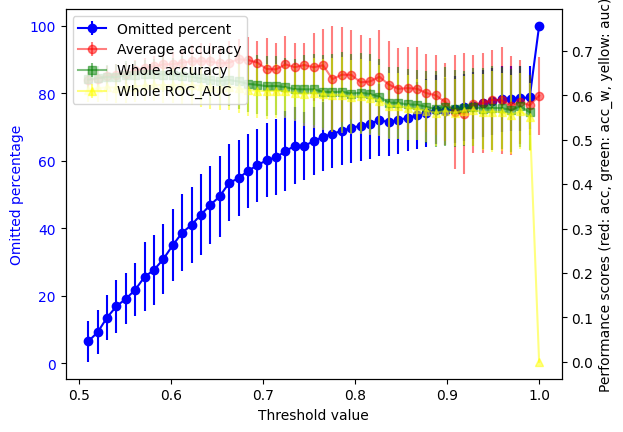

In [ ]:
# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Show and save
plt.show()
fig.savefig(f"{base}gb_S_thres.png")

###### Scatter plot

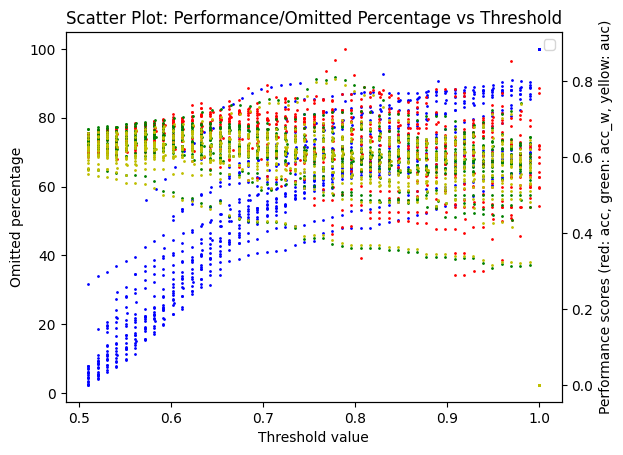

In [ ]:
# Scatter plot (Since the error is too small to show)
fig, ax1 = plt.subplots()

# Plot the first dataset with error bars
for y in o_p_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax1.scatter(x, y, color='b',s=1)

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with the same y-axis
for y in acc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='r',s=1)
for y in acc_w_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='g',s=1)
for y in auc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='y',s=1)

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

Todos: transfer y sets to draw error bar curves

In [ ]:
l = max(map(o_p_tl_a,len))

TypeError: ignored

#### Baye Thresholding

##### Load predictions/best parameters

In [ ]:
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
path = f"{base}baye_odata_pop/best_params_0.csv"
paras_l = read_csv(path)
paras_l = paras_l[0]
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
converted_paras_l

[{'var_smoothing': 7.031608284596767e-08},
 {'var_smoothing': 7.090799148967775e-08},
 {'var_smoothing': 5.777522173521324e-08},
 {'var_smoothing': 3.319754587452058e-08},
 {'var_smoothing': 6.943385166706948e-08},
 {'var_smoothing': 8.984640371894955e-08},
 {'var_smoothing': 4.165148774754093e-08},
 {'var_smoothing': 1e-11},
 {'var_smoothing': 8.50591256187659e-08}]

##### Baye Initiliazation

In [ ]:
from sklearn.naive_bayes import GaussianNB

##### Test with different thres

In [ ]:
from sklearn.model_selection import PredefinedSplit
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
a_l = []
a = 0
n = 1
while o_p_all < 90:
  a = a + 9*10**(-n)
  a_l.append(a)
  print(f"Threshold setting {n}: {a}")
  thres = np.log(a)
  acc_scores = []
  yhat_all = []
  ytrue_all = []
  o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
        f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for i, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[i] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model and optimise by BayesSearch
    model = GaussianNB(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_log_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))

  """Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
  #7 Results for all testing folds
  n+=1
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter acc_scores
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

Threshold setting 1: 0.9
Fold 0; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 71.43%
Fold 1; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 79.41%
Fold 2; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 94.44%
Fold 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 80.95%
Fold 4; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 72.55%
Fold 5; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 30.77%
Fold 6; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 68.00%
Fold 7; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 62.07%
Fold 8; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 80.00%
Average Accuray: 71.07%
Whole Accuracy: 72.57%, Percentage of Data Omitted:       29.04%
Whole AUC: 0.7065%
Threshold setting 2: 0.99
Fold 0; 
training+validation index: 306;  testing index: 28
Iterati

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518


Fold 4; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 75.00%
Fold 5; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 50.00%
Fold 6; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 75.00%
Fold 7; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 62.07%
Fold 8; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 50.00%
Average Accuray: 76.51%
Whole Accuracy: 70.18%, Percentage of Data Omitted:       82.93%
Whole AUC: 0.6906%
Threshold setting 4: 0.9999
Fold 0; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 100.00%
Fold 1; 
training+validation index: 292;  testing index: 42
Iteration Accuray: nan%
Fold 2; 
training+validation index: 305;  testing index: 29
Iteration Accuray: nan%
Fold 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 100.00%
Fold 4; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 83.33%
Fold 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518

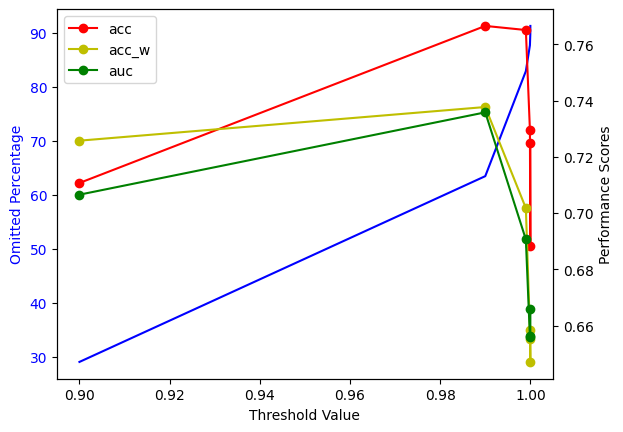

In [ ]:
fig, ax1 = plt.subplots()
x_lim = a_l
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

In [ ]:
# Focus on thres lower than 0.999

acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
a_l = []
a = 0.900
n = 1
while a < 0.999:
  a = a + 0.001
  a_l.append(a)
  print(f"Threshold setting {n}: {a}")
  thres = np.log(a)
  acc_scores = []
  yhat_all = []
  ytrue_all = []
  o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
        f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for i, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[i] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model and optimise by BayesSearch
    model = GaussianNB(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_log_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))

  """Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
  #7 Results for all testing folds
  n+=1
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter acc_scores
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

Threshold setting 1: 0.901
Fold 0; 
training+validation index: 306;  testing index: 28
Iteration Accuray: 71.43%
Fold 1; 
training+validation index: 292;  testing index: 42
Iteration Accuray: 78.79%
Fold 2; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 94.44%
Fold 3; 
training+validation index: 305;  testing index: 29
Iteration Accuray: 80.95%
Fold 4; 
training+validation index: 247;  testing index: 87
Iteration Accuray: 72.55%
Fold 5; 
training+validation index: 314;  testing index: 20
Iteration Accuray: 30.77%
Fold 6; 
training+validation index: 300;  testing index: 34
Iteration Accuray: 68.00%
Fold 7; 
training+validation index: 304;  testing index: 30
Iteration Accuray: 62.07%
Fold 8; 
training+validation index: 299;  testing index: 35
Iteration Accuray: 80.00%
Average Accuray: 71.00%
Whole Accuracy: 72.46%, Percentage of Data Omitted:       29.34%
Whole AUC: 0.7060%
Threshold setting 2: 0.902
Fold 0; 
training+validation index: 306;  testing index: 28
Iter

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


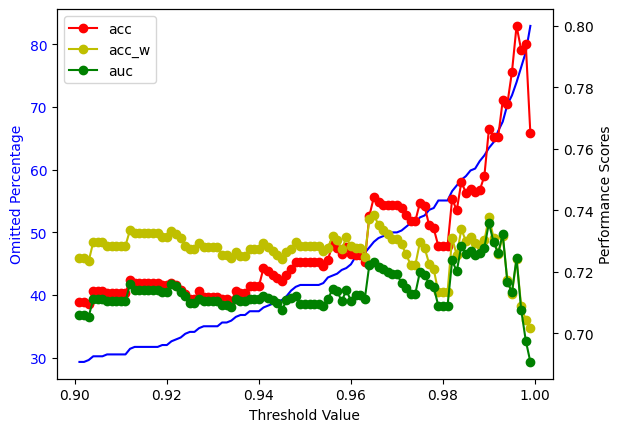

In [ ]:
fig, ax1 = plt.subplots()
x_lim = a_l
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

##### Display ssh run results - baye_odata_pop 20 run error bar

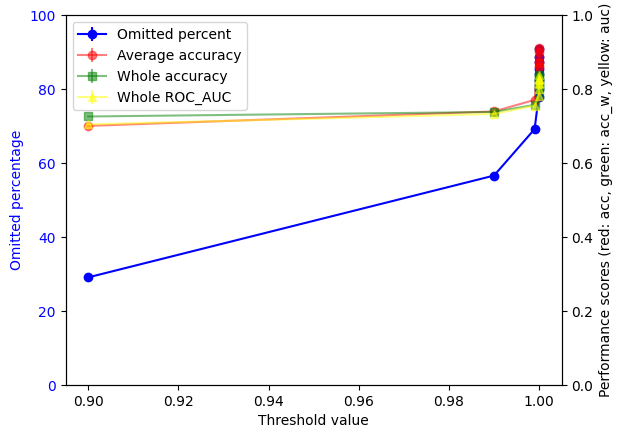

In [ ]:
base_path1 = f"{base}baye_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
# x = np.linspace(0.51,0.51+0.01*l,l)
a = 0
n = 1
a_l = []
for i in range(len(y0)):
    a = a + 9*10**(-n)
    a_l.append(a)
    n+=1
x = a_l
# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"baye_o_pop_thres.png")

##### Display ssh run results - baye_odata_noP 20 run error bar

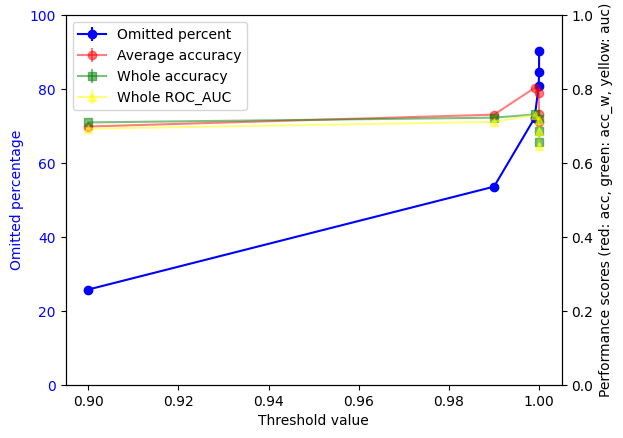

In [ ]:
base_path1 = f"{base}baye_odata_noP/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
# x = np.linspace(0.51,0.51+0.01*l,l)
a = 0
n = 1
a_l = []
for i in range(len(y0)):
    a = a + 9*10**(-n)
    a_l.append(a)
    n+=1
x = a_l
# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"baye_o_noP_thres.png")

##### Display ssh run results - baye_gkb_noP 20 run error bar

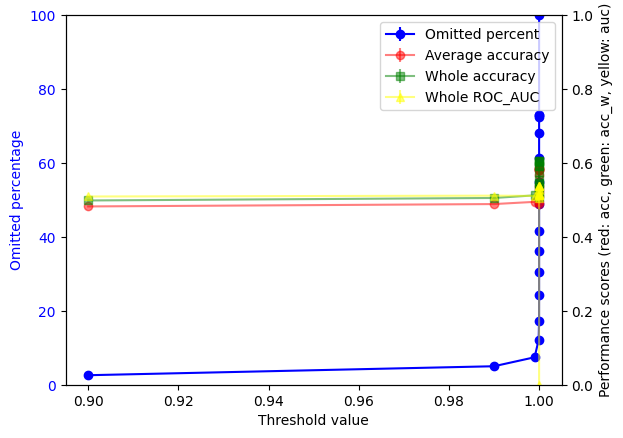

In [ ]:
base_path1 = f"{base}baye_gkb_noP/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
# x = np.linspace(0.51,0.51+0.01*l,l)
a = 0
n = 1
a_l = []
for i in range(len(y0)):
    a = a + 9*10**(-n)
    a_l.append(a)
    n+=1
x = a_l
# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"baye_gkb_noP_thres.png")

##### Display ssh run results - baye_gkb_pop 20 run error bar

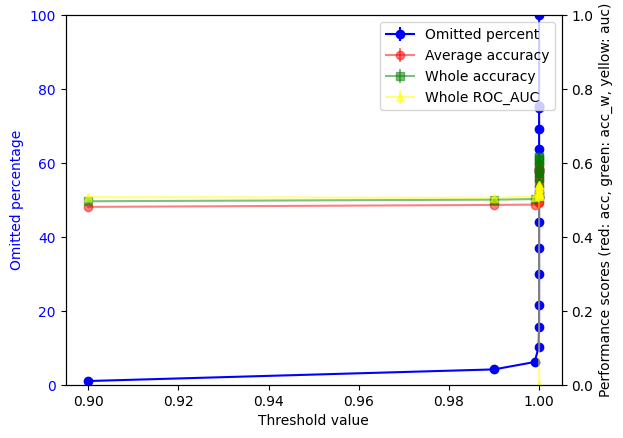

In [ ]:
base_path1 = f"{base}baye_gkb_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
# write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
# write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
# write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
# write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))
data0p_arr = np.array(data0p)
y0 = [np.mean(x) for x in data0p_arr]
err0 = [np.std(x) for x in data0p_arr]

l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

# X-axis
# x = np.linspace(0.51,0.51+0.01*l,l)
a = 0
n = 1
a_l = []
for i in range(len(y0)):
    a = a + 9*10**(-n)
    a_l.append(a)
    n+=1
x = a_l
# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
ax1.set_ylim(0, 100)
ax2.set_ylim(0,1)
# plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Show and save
plt.show()
fig.savefig(f"baye_gkb_pop_thres.png")

#### SVM Thresholding

##### Load predictions/best parameters

In [ ]:
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
path = f"{base}svm_odata_pop/best_params_0.csv"
paras_l = read_csv(path)
paras_l = paras_l[0]
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
converted_paras_l

[{'C': 0.3620906421529484,
  'coef0': 0,
  'degree': 0,
  'gamma': 'auto',
  'kernel': 'rbf'},
 {'C': 0.5442221914438296,
  'coef0': 0,
  'degree': 0,
  'gamma': 'auto',
  'kernel': 'rbf'},
 {'C': 0.6920688000840138,
  'coef0': 0,
  'degree': 0,
  'gamma': 'scale',
  'kernel': 'rbf'},
 {'C': 0.34120717222466485,
  'coef0': 0,
  'degree': 0,
  'gamma': 'auto',
  'kernel': 'rbf'},
 {'C': 11.512382623755922,
  'coef0': 0,
  'degree': 0,
  'gamma': 'auto',
  'kernel': 'rbf'},
 {'C': 1.6451952786248198,
  'coef0': 0,
  'degree': 0,
  'gamma': 'scale',
  'kernel': 'rbf'},
 {'C': 0.35080851204640545,
  'coef0': 0,
  'degree': 0,
  'gamma': 'auto',
  'kernel': 'rbf'},
 {'C': 10.698558451857489,
  'coef0': 0,
  'degree': 0,
  'gamma': 'scale',
  'kernel': 'rbf'},
 {'C': 5869.0366212499985,
  'coef0': 0,
  'degree': 0,
  'gamma': 'auto',
  'kernel': 'rbf'}]

##### Model Initiliazation

In [ ]:
from sklearn.svm import SVC
from skopt.space import Real, Categorical, Integer

def create_svm_model(C,kernel,gamma,degree,coef0):#, gamma, coef0kernel, degree, coef0=coef0,
   model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma,
               coef0=coef0, probability=True, random_state=42)#degree=degree,
   return model

##### Test with different thres

In [ ]:
def convert(pred_probs, thres):
    converted_preds = np.empty(len(pred_probs), dtype=object)
    # print(pred_probs)
    for i in range(len(pred_probs)):
        # print(pred_probs[i])
        prob_class_0 = pred_probs[i][0]
        prob_class_1 = pred_probs[i][1]
        if prob_class_0 > thres:
            converted_preds[i] = 0
        elif prob_class_1 > thres:
            converted_preds[i] = 1
        else:
            converted_preds[i] = np.nan
    return converted_preds

def prob_acc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    # print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    # print(len(valid_y_test))
    accuracy = accuracy_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

def prob_auc(y_test, preds, thres):
    converted_preds = convert(preds, thres)
    converted_preds = converted_preds#.tolist()
    converted_preds = [float(pred) for pred in converted_preds]
    # print(type(converted_preds[0]))
    nan_indices = np.argwhere(np.isnan(converted_preds)).flatten()#.tolist()
    # print(type(nan_indices),type(nan_indices[0]))
    # print(nan_indices)
    valid_converted_preds = [converted_preds[i] for i in range(len(converted_preds)) if not i in nan_indices]
    print(len(valid_converted_preds))
    valid_y_test = [y_test[i] for i in range(len(y_test)) if not i in nan_indices]
    print(len(valid_y_test))
    accuracy = roc_auc_score(valid_y_test, valid_converted_preds)
    omitted_percentage = (len(nan_indices) / len(converted_preds)) * 100
    return accuracy, omitted_percentage

acc_tl = []
acc_w_tl = []
auc_tl = []
o_p_tl = []
o_p_all = 0
thres = 0.51
while o_p_all < 90:
  print(thres)
  acc_scores = []
  n = 1
  yhat_all = []
  ytrue_all = []
  # o_p_l = []
  for i in range(len(testlist)):
    print(f"Fold {i}; ")
    paras = converted_paras_l[i]
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = trainlist[i]
    val_indexes = vlist[i]
    test_indexes = testlist[i]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
    #     f"testing index: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for j, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[j] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model with paras found by former BayesSearch
    model = create_svm_model(**paras)
    model.fit(X_train, y_train)
    yhat = model.predict_proba(X_test)

    #6 Calculate and store
    acc, o_p = prob_acc(y_test, yhat, thres)
    # auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    # o_p_l.append(o_p)
    ytrue_all.append(y_test)
    yhat_all.append(yhat)
    # auc_scores.append(auc)
    # print("Iteration Accuray: {:.2f}%".format(100*acc))
    # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
    n+=1
  # a+=0.001
  thres+=0.01
  #For one thres
  #7 Results for all testing folds
  # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
  ytrue_all = np.concatenate(ytrue_all)
  yhat_all= np.concatenate(yhat_all)
  acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
  auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
  # Filter nan in acc
  nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
  acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
  #
  acc_ave = np.mean(acc_scores)
  acc_w_tl.append(acc_w)
  acc_tl.append(acc_ave)
  auc_tl.append(auc)
  o_p_tl.append(o_p_all)
  print("Average Accuray: {:.2f}%".format(100*acc_ave))
  print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
      {:.2f}%".format(acc_w * 100, o_p_all))
  print("Whole AUC: {:.4f}%".format(auc))

0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
311
311
Average Accuray: 62.37%
Whole Accuracy: 63.67%, Percentage of Data Omitted:       6.89%
Whole AUC: 0.6182%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
299
299
Average Accuray: 62.59%
Whole Accuracy: 63.55%, Percentage of Data Omitted:       10.48%
Whole AUC: 0.6124%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
288
288
Average Accuray: 62.87%
Whole Accuracy: 62.85%, Percentage of Data Omitted:       13.77%
Whole AUC: 0.6045%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
271
271
Average Accuray: 62.01%
Whole Accuracy: 63.84%, Percentage of Data Omitted:       18.86%
Whole AUC: 0.6113%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
258
258
Average Accuray: 62.71%
Whole Accuracy: 65.12%, Percentage of Data Omitted:       22.75%
Whole AUC:

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


111
111
Average Accuray: 73.17%
Whole Accuracy: 70.27%, Percentage of Data Omitted:       66.77%
Whole AUC: 0.6897%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


106
106
Average Accuray: 74.21%
Whole Accuracy: 71.70%, Percentage of Data Omitted:       68.26%
Whole AUC: 0.7003%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


94
94
Average Accuray: 75.02%
Whole Accuracy: 72.34%, Percentage of Data Omitted:       71.86%
Whole AUC: 0.7123%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


82
82
Average Accuray: 76.87%
Whole Accuracy: 73.17%, Percentage of Data Omitted:       75.45%
Whole AUC: 0.7195%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


72
72
Average Accuray: 78.77%
Whole Accuracy: 72.22%, Percentage of Data Omitted:       78.44%
Whole AUC: 0.7189%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


64
64
Average Accuray: 79.20%
Whole Accuracy: 71.88%, Percentage of Data Omitted:       80.84%
Whole AUC: 0.7255%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


55
55
Average Accuray: 81.73%
Whole Accuracy: 72.73%, Percentage of Data Omitted:       83.53%
Whole AUC: 0.7288%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


47
47
Average Accuray: 85.30%
Whole Accuracy: 70.21%, Percentage of Data Omitted:       85.93%
Whole AUC: 0.7002%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


40
40
Average Accuray: 86.46%
Whole Accuracy: 72.50%, Percentage of Data Omitted:       88.02%
Whole AUC: 0.7250%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


34
34
Average Accuray: 87.04%
Whole Accuracy: 70.59%, Percentage of Data Omitted:       89.82%
Whole AUC: 0.7088%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
26
26
Average Accuray: 86.90%
Whole Accuracy: 65.38%, Percentage of Data Omitted:       92.22%
Whole AUC: 0.6515%


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


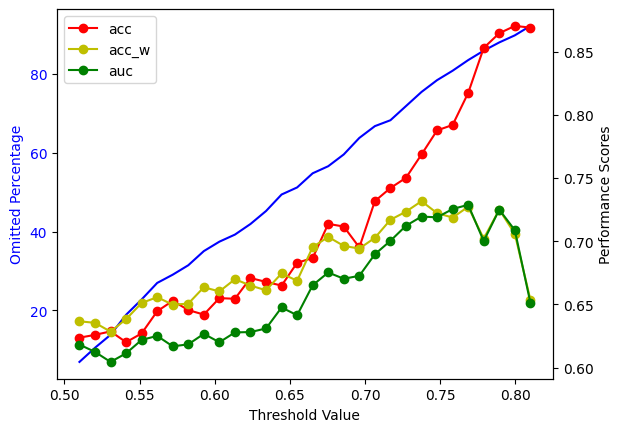

In [ ]:
fig, ax1 = plt.subplots()
x_lim = np.linspace(0.51,thres,(len(o_p_tl)))
ax1.plot(x_lim, o_p_tl, 'b-')
ax1.set_xlabel('Threshold Value')
ax1.set_ylabel('Omitted Percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(x_lim, acc_tl, 'ro-', label='acc')
ax2.plot(x_lim, acc_w_tl, 'yo-', label='acc_w')
ax2.plot(x_lim, auc_tl, 'go-', label='auc')
ax2.legend()
ax2.set_ylabel('Performance Scores',color='k')
ax2.tick_params(axis='y',labelcolor='k')

# ax4.set_ylabel('Running time (seconds)',color='r')
# ax4.tick_params(axis='y',labelcolor='r')

Conclusion: similarly...

##### 20 Runs Error-bar: svm_pop

In [ ]:
# Collect data from 20 runs and test different thresholds
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_ll = []
for i in range(20):
  path = f"{base}svm_odata_pop/best_params_{i}.csv"
  paras_l = read_csv(path)
  paras_l = paras_l[0]
  converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
  converted_paras_ll.append(converted_paras_l)
print(np.shape(converted_paras_ll))

(20, 9)


In [ ]:
acc_w_tl_a = []
acc_tl_a = []
auc_tl_a = []
o_p_tl_a = []
for n_run in range(20):
  print(f'%Run {n_run}')
  acc_tl = []
  acc_w_tl = []
  auc_tl = []
  o_p_tl = []
  o_p_all = 0
  thres = 0.51
  converted_paras_l = converted_paras_ll[n_run]
  while o_p_all < 90:
    print(thres)
    acc_scores = []
    n = 1
    yhat_all = []
    ytrue_all = []
    # o_p_l = []
    for i in range(len(testlist)):
      print(f"Fold {i}; ")
      paras = converted_paras_l[i]
      #1 Build training, validation and test sets/Extract individual index list
      train_v_indexes = trainlist[i]
      val_indexes = vlist[i]
      test_indexes = testlist[i]
      X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
      X_test, y_test= X[test_indexes], Y[test_indexes]
      # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      #     f"testing index: {len(test_indexes)}") #{test_indexes},

      #2 Use train and validation indexes to create the custom split
      # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
      custom_split = [-1] * len(train_v_indexes)
      for j, x in enumerate(train_v_indexes):
        if x in val_indexes: custom_split[j] = 0
      # Initialize the PredefinedSplit object
      ps = PredefinedSplit(test_fold=custom_split)

      #3 Create model with paras found by former BayesSearch
      model = create_svm_model(**paras)
      model.fit(X_train, y_train)
      yhat = model.predict_proba(X_test)

      #6 Calculate and store
      acc, o_p = prob_acc(y_test, yhat, thres)
      # auc = roc_auc_score(y_test, yhat)
      acc_scores.append(acc)
      # o_p_l.append(o_p)
      ytrue_all.append(y_test)
      yhat_all.append(yhat)
      # auc_scores.append(auc)
      # print("Iteration Accuray: {:.2f}%".format(100*acc))
      # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
      n+=1
    # a+=0.001
    thres = thres+0.01
    #For one thres
    #7 Results for all testing folds
    # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
    ytrue_all = np.concatenate(ytrue_all)
    yhat_all= np.concatenate(yhat_all)
    acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
    auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
    # Filter nan in acc
    nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
    acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
    #
    acc_ave = np.mean(acc_scores)
    acc_w_tl.append(acc_w)
    acc_tl.append(acc_ave)
    auc_tl.append(auc)
    o_p_tl.append(o_p_all)
    print("Average Accuray: {:.2f}%".format(100*acc_ave))
    print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
        {:.2f}%".format(acc_w * 100, o_p_all))
    print("Whole AUC: {:.4f}%".format(auc))
  acc_w_tl_a.append(acc_w_tl)
  acc_tl_a.append(acc_tl)
  auc_tl_a.append(auc_tl)
  o_p_tl_a.append(o_p_tl)
print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

%Run 0
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
311
311
Average Accuray: 62.37%
Whole Accuracy: 63.67%, Percentage of Data Omitted:         6.89%
Whole AUC: 0.6182%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
299
299
Average Accuray: 62.59%
Whole Accuracy: 63.55%, Percentage of Data Omitted:         10.48%
Whole AUC: 0.6124%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
288
288
Average Accuray: 62.87%
Whole Accuracy: 62.85%, Percentage of Data Omitted:         13.77%
Whole AUC: 0.6045%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
271
271
Average Accuray: 62.01%
Whole Accuracy: 63.84%, Percentage of Data Omitted:         18.86%
Whole AUC: 0.6113%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
258
258
Average Accuray: 62.71%
Whole Accuracy: 65.12%, Percentage of Data Omitted:         

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
111
111
Average Accuray: 73.17%
Whole Accuracy: 70.27%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.6897%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
106
106
Average Accuray: 74.21%
Whole Accuracy: 71.70%, Percentage of Data Omitted:         68.26%
Whole AUC: 0.7003%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
94
94
Average Accuray: 75.02%
Whole Accuracy: 72.34%, Percentage of Data Omitted:         71.86%
Whole AUC: 0.7123%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
82
82
Average Accuray: 76.87%
Whole Accuracy: 73.17%, Percentage of Data Omitted:         75.45%
Whole AUC: 0.7195%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


72
72
Average Accuray: 78.77%
Whole Accuracy: 72.22%, Percentage of Data Omitted:         78.44%
Whole AUC: 0.7189%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
64
64
Average Accuray: 79.20%
Whole Accuracy: 71.88%, Percentage of Data Omitted:         80.84%
Whole AUC: 0.7255%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


55
55
Average Accuray: 81.73%
Whole Accuracy: 72.73%, Percentage of Data Omitted:         83.53%
Whole AUC: 0.7288%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
47
47
Average Accuray: 85.30%
Whole Accuracy: 70.21%, Percentage of Data Omitted:         85.93%
Whole AUC: 0.7002%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


40
40
Average Accuray: 86.46%
Whole Accuracy: 72.50%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.7250%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


34
34
Average Accuray: 87.04%
Whole Accuracy: 70.59%, Percentage of Data Omitted:         89.82%
Whole AUC: 0.7088%
0.8000000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
26
26
Average Accuray: 86.90%
Whole Accuracy: 65.38%, Percentage of Data Omitted:         92.22%
Whole AUC: 0.6515%
%Run 1
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
309
309
Average Accuray: 61.51%
Whole Accuracy: 62.46%, Percentage of Data Omitted:         7.49%
Whole AUC: 0.6026%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
295
295
Average Accuray: 61.62%
Whole Accuracy: 64.75%, Percentage of Data Omitted:         11.68%
Whole AUC: 0.6224%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
282
282
Average Accuray: 63.88%
Whole Accuracy: 65.25%, Percentage of Data Omitted:         15.57%
Whole AUC: 0.6260%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
270
270
Average Accuray: 63.69%
Whole Accuracy: 65.56%, Percentage of Data Omitted:         19.16%
Whole AUC: 0.6270%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
44
44
Average Accuray: 77.95%
Whole Accuracy: 75.00%, Percentage of Data Omitted:         86.83%
Whole AUC: 0.7500%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
38
38
Average Accuray: 81.47%
Whole Accuracy: 73.68%, Percentage of Data Omitted:         88.62%
Whole AUC: 0.7417%
0.8100000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
32
32
Average Accuray: 84.90%
Whole Accuracy: 78.12%, Percentage of Data Omitted:         90.42%
Whole AUC: 0.7824%
%Run 2
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
306
306
Average Accuray: 60.71%
Whole Accuracy: 62.75%, Percentage of Data Omitted:         8.38%
Whole AUC: 0.6117%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
290
290
Average Accuray: 61.71%
Whole Accuracy: 64.14%, Percentage of Data Omitted:         13.17%
Whole AUC: 0.6241%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
277
277
Average Accuray: 62.33%
Whole Accuracy: 64.98%, Percentage of Data Omitted:         17.07%
Whole AUC: 0.6291%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
269
269
Average Accuray: 62.22%
Whole Accuracy: 65.06%, Percentage of Data Omitted:         19.46%
Whole AUC: 0.6277%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
41
41
Average Accuray: 76.70%
Whole Accuracy: 73.17%, Percentage of Data Omitted:         87.72%
Whole AUC: 0.6900%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
34
34
Average Accuray: 79.39%
Whole Accuracy: 67.65%, Percentage of Data Omitted:         89.82%
Whole AUC: 0.6209%
0.8100000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
26
26
Average Accuray: 72.40%
Whole Accuracy: 69.23%, Percentage of Data Omitted:         92.22%
Whole AUC: 0.6340%
%Run 3
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
309
309
Average Accuray: 61.99%
Whole Accuracy: 63.43%, Percentage of Data Omitted:         7.49%
Whole AUC: 0.6156%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
291
291
Average Accuray: 62.21%
Whole Accuracy: 63.92%, Percentage of Data Omitted:         12.87%
Whole AUC: 0.6149%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
280
280
Average Accuray: 62.68%
Whole Accuracy: 63.93%, Percentage of Data Omitted:         16.17%
Whole AUC: 0.6123%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
265
265
Average Accuray: 62.70%
Whole Accuracy: 65.28%, Percentage of Data Omitted:         20.66%
Whole AUC: 0.6229%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
103
103
Average Accuray: 81.94%
Whole Accuracy: 73.79%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.7157%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
99
99
Average Accuray: 81.64%
Whole Accuracy: 73.74%, Percentage of Data Omitted:         70.36%
Whole AUC: 0.7187%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
88
88
Average Accuray: 82.46%
Whole Accuracy: 75.00%, Percentage of Data Omitted:         73.65%
Whole AUC: 0.7326%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
80
80
Average Accuray: 84.08%
Whole Accuracy: 73.75%, Percentage of Data Omitted:         76.05%
Whole AUC: 0.7222%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


71
71
Average Accuray: 82.54%
Whole Accuracy: 71.83%, Percentage of Data Omitted:         78.74%
Whole AUC: 0.7071%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
60
60
Average Accuray: 81.65%
Whole Accuracy: 70.00%, Percentage of Data Omitted:         82.04%
Whole AUC: 0.6963%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


49
49
Average Accuray: 80.04%
Whole Accuracy: 73.47%, Percentage of Data Omitted:         85.33%
Whole AUC: 0.7367%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
40
40
Average Accuray: 85.95%
Whole Accuracy: 72.50%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.7298%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
37
37
Average Accuray: 88.89%
Whole Accuracy: 72.97%, Percentage of Data Omitted:         88.92%
Whole AUC: 0.7324%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
31
31
Average Accuray: 88.57%
Whole Accuracy: 67.74%, Percentage of Data Omitted:         90.72%
Whole AUC: 0.6795%
%Run 4
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
307
307
Average Accuray: 61.30%
Whole Accuracy: 62.54%, Percentage of Data Omitted:         8.08%
Whole AUC: 0.6067%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
288
288
Average Accuray: 61.21%
Whole Accuracy: 63.54%, Percentage of Data Omitted:         13.77%
Whole AUC: 0.6091%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
281
281
Average Accuray: 62.28%
Whole Accuracy: 63.70%, Percentage of Data Omitted:         15.87%
Whole AUC: 0.6094%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
268
268
Average Accuray: 62.63%
Whole Accuracy: 64.55%, Percentage of Data Omitted:         19.76%
Whole AUC: 0.6155%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
98
98
Average Accuray: 82.83%
Whole Accuracy: 74.49%, Percentage of Data Omitted:         70.66%
Whole AUC: 0.7296%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


97
97
Average Accuray: 82.42%
Whole Accuracy: 74.23%, Percentage of Data Omitted:         70.96%
Whole AUC: 0.7283%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
89
89
Average Accuray: 82.42%
Whole Accuracy: 74.16%, Percentage of Data Omitted:         73.35%
Whole AUC: 0.7277%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
85
85
Average Accuray: 83.22%
Whole Accuracy: 75.29%, Percentage of Data Omitted:         74.55%
Whole AUC: 0.7341%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
70
70
Average Accuray: 83.72%
Whole Accuracy: 72.86%, Percentage of Data Omitted:         79.04%
Whole AUC: 0.7236%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
58
58
Average Accuray: 85.04%
Whole Accuracy: 68.97%, Percentage of Data Omitted:         82.63%
Whole AUC: 0.6897%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
53
53
Average Accuray: 81.32%
Whole Accuracy: 69.81%, Percentage of Data Omitted:         84.13%
Whole AUC: 0.6973%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
47
47
Average Accuray: 81.97%
Whole Accuracy: 65.96%, Percentage of Data Omitted:         85.93%
Whole AUC: 0.6603%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
39
39
Average Accuray: 79.39%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         88.32%
Whole AUC: 0.6667%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
34
34
Average Accuray: 81.36%
Whole Accuracy: 67.65%, Percentage of Data Omitted:         89.82%
Whole AUC: 0.6765%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
28
28
Average Accuray: 81.55%
Whole Accuracy: 71.43%, Percentage of Data Omitted:         91.62%
Whole AUC: 0.7128%
%Run 5
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
306
306
Average Accuray: 61.68%
Whole Accuracy: 62.75%, Percentage of Data Omitted:         8.38%
Whole AUC: 0.6093%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
293
293
Average Accuray: 61.60%
Whole Accuracy: 64.51%, Percentage of Data Omitted:         12.28%
Whole AUC: 0.6233%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
277
277
Average Accuray: 62.52%
Whole Accuracy: 65.70%, Percentage of Data Omitted:         17.07%
Whole AUC: 0.6303%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
259
259
Average Accuray: 63.30%
Whole Accuracy: 66.02%, Percentage of Data Omitted:         22.46%
Whole AUC: 0.6260%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
108
108
Average Accuray: 85.06%
Whole Accuracy: 78.70%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.7599%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


100
100
Average Accuray: 85.64%
Whole Accuracy: 80.00%, Percentage of Data Omitted:         70.06%
Whole AUC: 0.7750%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


89
89
Average Accuray: 86.02%
Whole Accuracy: 80.90%, Percentage of Data Omitted:         73.35%
Whole AUC: 0.7772%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


82
82
Average Accuray: 87.59%
Whole Accuracy: 80.49%, Percentage of Data Omitted:         75.45%
Whole AUC: 0.7672%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


72
72
Average Accuray: 86.01%
Whole Accuracy: 80.56%, Percentage of Data Omitted:         78.44%
Whole AUC: 0.7811%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


64
64
Average Accuray: 88.26%
Whole Accuracy: 78.12%, Percentage of Data Omitted:         80.84%
Whole AUC: 0.7608%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
53
53
Average Accuray: 85.77%
Whole Accuracy: 75.47%, Percentage of Data Omitted:         84.13%
Whole AUC: 0.7377%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
49
49
Average Accuray: 83.81%
Whole Accuracy: 75.51%, Percentage of Data Omitted:         85.33%
Whole AUC: 0.7321%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
43
43
Average Accuray: 86.70%
Whole Accuracy: 76.74%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.7456%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
36
36
Average Accuray: 90.48%
Whole Accuracy: 75.00%, Percentage of Data Omitted:         89.22%
Whole AUC: 0.7286%
0.8000000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
29
29
Average Accuray: 89.10%
Whole Accuracy: 72.41%, Percentage of Data Omitted:         91.32%
Whole AUC: 0.7067%
%Run 6
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
305
305
Average Accuray: 60.75%
Whole Accuracy: 62.30%, Percentage of Data Omitted:         8.68%
Whole AUC: 0.6030%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
285
285
Average Accuray: 61.22%
Whole Accuracy: 64.21%, Percentage of Data Omitted:         14.67%
Whole AUC: 0.6159%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
271
271
Average Accuray: 62.37%
Whole Accuracy: 64.58%, Percentage of Data Omitted:         18.86%
Whole AUC: 0.6145%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
257
257
Average Accuray: 61.70%
Whole Accuracy: 65.76%, Percentage of Data Omitted:         23.05%
Whole AUC: 0.6247%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
103
103
Average Accuray: 84.33%
Whole Accuracy: 78.64%, Percentage of Data Omitted:         69.16%
Whole AUC: 0.7565%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
100
100
Average Accuray: 84.82%
Whole Accuracy: 79.00%, Percentage of Data Omitted:         70.06%
Whole AUC: 0.7625%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
89
89


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Average Accuray: 85.07%
Whole Accuracy: 79.78%, Percentage of Data Omitted:         73.35%
Whole AUC: 0.7680%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
83
83
Average Accuray: 86.64%
Whole Accuracy: 80.72%, Percentage of Data Omitted:         75.15%
Whole AUC: 0.7680%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
72
72
Average Accuray: 86.31%
Whole Accuracy: 79.17%, Percentage of Data Omitted:         78.44%
Whole AUC: 0.7581%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
64
64
Average Accuray: 86.47%
Whole Accuracy: 78.12%, Percentage of Data Omitted:         80.84%
Whole AUC: 0.7551%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
54


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


54
Average Accuray: 86.75%
Whole Accuracy: 77.78%, Percentage of Data Omitted:         83.83%
Whole AUC: 0.7560%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


48
48
Average Accuray: 89.17%
Whole Accuracy: 75.00%, Percentage of Data Omitted:         85.63%
Whole AUC: 0.7302%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


41
41
Average Accuray: 88.99%
Whole Accuracy: 75.61%, Percentage of Data Omitted:         87.72%
Whole AUC: 0.7403%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
35
35
Average Accuray: 90.48%
Whole Accuracy: 74.29%, Percentage of Data Omitted:         89.52%
Whole AUC: 0.7143%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
27
27
Average Accuray: 86.92%
Whole Accuracy: 70.37%, Percentage of Data Omitted:         91.92%
Whole AUC: 0.6978%
%Run 7
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
310
310
Average Accuray: 62.63%
Whole Accuracy: 64.19%, Percentage of Data Omitted:         7.19%
Whole AUC: 0.6250%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
292
292
Average Accuray: 62.57%
Whole Accuracy: 65.07%, Percentage of Data Omitted:         12.57%
Whole AUC: 0.6296%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
284
284
Average Accuray: 64.02%
Whole Accuracy: 64.79%, Percentage of Data Omitted:         14.97%
Whole AUC: 0.6253%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
277
277
Average Accuray: 63.95%
Whole Accuracy: 65.70%, Percentage of Data Omitted:         17.07%
Whole AUC: 0.6333%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
35
35
Average Accuray: 82.03%
Whole Accuracy: 68.57%, Percentage of Data Omitted:         89.52%
Whole AUC: 0.6786%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
31
31
Average Accuray: 83.75%
Whole Accuracy: 67.74%, Percentage of Data Omitted:         90.72%
Whole AUC: 0.6688%
%Run 8
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
315
315
Average Accuray: 62.46%
Whole Accuracy: 63.17%, Percentage of Data Omitted:         5.69%
Whole AUC: 0.6157%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
299
299
Average Accuray: 62.41%
Whole Accuracy: 63.21%, Percentage of Data Omitted:         10.48%
Whole AUC: 0.6105%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
292
292
Average Accuray: 62.62%
Whole Accuracy: 63.01%, Percentage of Data Omitted:         12.57%
Whole AUC: 0.6083%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
276
276
Average Accuray: 62.60%
Whole Accuracy: 64.49%, Percentage of Data Omitted:         17.37%
Whole AUC: 0.6207%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
33
33
Average Accuray: 82.44%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         90.12%
Whole AUC: 0.6673%
%Run 9
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
313
313
Average Accuray: 62.29%
Whole Accuracy: 63.26%, Percentage of Data Omitted:         6.29%
Whole AUC: 0.6140%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
294
294
Average Accuray: 62.38%
Whole Accuracy: 64.29%, Percentage of Data Omitted:         11.98%
Whole AUC: 0.6200%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
281
281
Average Accuray: 63.83%
Whole Accuracy: 63.70%, Percentage of Data Omitted:         15.87%
Whole AUC: 0.6131%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
272
272
Average Accuray: 63.48%
Whole Accuracy: 63.97%, Percentage of Data Omitted:         18.56%
Whole AUC: 0.6114%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


110
110
Average Accuray: 72.66%
Whole Accuracy: 70.00%, Percentage of Data Omitted:         67.07%
Whole AUC: 0.6798%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


104
104
Average Accuray: 72.53%
Whole Accuracy: 70.19%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.6819%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
97
97
Average Accuray: 73.80%
Whole Accuracy: 71.13%, Percentage of Data Omitted:         70.96%
Whole AUC: 0.6920%


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


84
84
Average Accuray: 75.46%
Whole Accuracy: 73.81%, Percentage of Data Omitted:         74.85%
Whole AUC: 0.7094%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


76
76
Average Accuray: 79.21%
Whole Accuracy: 73.68%, Percentage of Data Omitted:         77.25%
Whole AUC: 0.7125%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


68
68
Average Accuray: 82.46%
Whole Accuracy: 73.53%, Percentage of Data Omitted:         79.64%
Whole AUC: 0.7162%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


57
57
Average Accuray: 83.06%
Whole Accuracy: 70.18%, Percentage of Data Omitted:         82.93%
Whole AUC: 0.6863%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


46
46
Average Accuray: 80.83%
Whole Accuracy: 73.91%, Percentage of Data Omitted:         86.23%
Whole AUC: 0.7295%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


39
39
Average Accuray: 86.83%
Whole Accuracy: 74.36%, Percentage of Data Omitted:         88.32%
Whole AUC: 0.7381%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
30
30
Average Accuray: 88.10%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         91.02%
Whole AUC: 0.6696%
%Run 10
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
304
304
Average Accuray: 60.80%
Whole Accuracy: 62.50%, Percentage of Data Omitted:         8.98%
Whole AUC: 0.6053%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
294
294
Average Accuray: 61.43%
Whole Accuracy: 63.61%, Percentage of Data Omitted:         11.98%
Whole AUC: 0.6141%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
286
286
Average Accuray: 62.34%
Whole Accuracy: 63.29%, Percentage of Data Omitted:         14.37%
Whole AUC: 0.6078%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
273
273
Average Accuray: 61.80%
Whole Accuracy: 63.00%, Percentage of Data Omitted:         18.26%
Whole AUC: 0.6046%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
32
32
Average Accuray: 80.77%
Whole Accuracy: 68.75%, Percentage of Data Omitted:         90.42%
Whole AUC: 0.6863%
%Run 11
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
315
315
Average Accuray: 63.08%
Whole Accuracy: 64.13%, Percentage of Data Omitted:         5.69%
Whole AUC: 0.6263%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
293
293
Average Accuray: 63.03%
Whole Accuracy: 64.85%, Percentage of Data Omitted:         12.28%
Whole AUC: 0.6272%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
284
284
Average Accuray: 63.60%
Whole Accuracy: 64.79%, Percentage of Data Omitted:         14.97%
Whole AUC: 0.6237%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
272
272
Average Accuray: 63.26%
Whole Accuracy: 66.18%, Percentage of Data Omitted:         18.56%
Whole AUC: 0.6358%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
33
33
Average Accuray: 83.33%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         90.12%
Whole AUC: 0.6673%
%Run 12
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
317
317
Average Accuray: 62.78%
Whole Accuracy: 63.72%, Percentage of Data Omitted:         5.09%
Whole AUC: 0.6213%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
305
305
Average Accuray: 63.07%
Whole Accuracy: 64.26%, Percentage of Data Omitted:         8.68%
Whole AUC: 0.6243%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
293
293
Average Accuray: 64.01%
Whole Accuracy: 63.82%, Percentage of Data Omitted:         12.28%
Whole AUC: 0.6203%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
282
282
Average Accuray: 63.38%
Whole Accuracy: 63.83%, Percentage of Data Omitted:         15.57%
Whole AUC: 0.6182%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
32
32
Average Accuray: 70.71%
Whole Accuracy: 65.62%, Percentage of Data Omitted:         90.42%
Whole AUC: 0.6548%
%Run 13
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
313
313
Average Accuray: 61.82%
Whole Accuracy: 62.94%, Percentage of Data Omitted:         6.29%
Whole AUC: 0.6155%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
301
301
Average Accuray: 61.60%
Whole Accuracy: 63.79%, Percentage of Data Omitted:         9.88%
Whole AUC: 0.6223%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
290
290
Average Accuray: 62.38%
Whole Accuracy: 63.45%, Percentage of Data Omitted:         13.17%
Whole AUC: 0.6164%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
281
281
Average Accuray: 62.18%
Whole Accuracy: 64.06%, Percentage of Data Omitted:         15.87%
Whole AUC: 0.6227%
0.55
Fold 0; 
Fold 1; 
Fol

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
52
52
Average Accuray: 75.61%
Whole Accuracy: 65.38%, Percentage of Data Omitted:         84.43%
Whole AUC: 0.6607%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


46
46
Average Accuray: 74.11%
Whole Accuracy: 65.22%, Percentage of Data Omitted:         86.23%
Whole AUC: 0.6553%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
40
40
Average Accuray: 74.86%
Whole Accuracy: 67.50%, Percentage of Data Omitted:         88.02%
Whole AUC: 0.6750%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
33
33
Average Accuray: 78.54%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         90.12%
Whole AUC: 0.6667%
%Run 14
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
309
309
Average Accuray: 62.11%
Whole Accuracy: 63.43%, Percentage of Data Omitted:         7.49%
Whole AUC: 0.6117%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
300
300
Average Accuray: 61.69%
Whole Accuracy: 64.33%, Percentage of Data Omitted:         10.18%
Whole AUC: 0.6186%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
290
290
Average Accuray: 63.08%
Whole Accuracy: 63.79%, Percentage of Data Omitted:         13.17%
Whole AUC: 0.6140%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
278
278
Average Accuray: 62.89%
Whole Accuracy: 64.75%, Percentage of Data Omitted:         16.77%
Whole AUC: 0.6190%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 8; 
31
31
Average Accuray: 81.67%
Whole Accuracy: 67.74%, Percentage of Data Omitted:         90.72%
Whole AUC: 0.6688%
%Run 15
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
309
309
Average Accuray: 61.41%
Whole Accuracy: 62.46%, Percentage of Data Omitted:         7.49%
Whole AUC: 0.6059%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
297
297
Average Accuray: 61.18%
Whole Accuracy: 63.30%, Percentage of Data Omitted:         11.08%
Whole AUC: 0.6104%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
285
285
Average Accuray: 62.05%
Whole Accuracy: 62.81%, Percentage of Data Omitted:         14.67%
Whole AUC: 0.6039%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
271
271
Average Accuray: 61.85%
Whole Accuracy: 64.21%, Percentage of Data Omitted:         18.86%
Whole AUC: 0.6151%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
55
55
Average Accuray: 77.07%
Whole Accuracy: 69.09%, Percentage of Data Omitted:         83.53%
Whole AUC: 0.6898%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
49
49
Average Accuray: 76.34%
Whole Accuracy: 67.35%, Percentage of Data Omitted:         85.33%
Whole AUC: 0.6742%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
39
39
Average Accuray: 77.80%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         88.32%
Whole AUC: 0.6644%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
34
34
Average Accuray: 80.36%
Whole Accuracy: 70.59%, Percentage of Data Omitted:         89.82%
Whole AUC: 0.7018%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
29
29
Average Accuray: 82.89%
Whole Accuracy: 68.97%, Percentage of Data Omitted:         91.32%
Whole AUC: 0.6740%
%Run 16
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
307
307
Average Accuray: 61.33%
Whole Accuracy: 62.87%, Percentage of Data Omitted:         8.08%
Whole AUC: 0.6095%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
294
294
Average Accuray: 61.53%
Whole Accuracy: 64.63%, Percentage of Data Omitted:         11.98%
Whole AUC: 0.6245%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
279
279
Average Accuray: 63.14%
Whole Accuracy: 65.23%, Percentage of Data Omitted:         16.47%
Whole AUC: 0.6275%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
268
268
Average Accuray: 63.27%
Whole Accuracy: 65.67%, Percentage of Data Omitted:         19.76%
Whole AUC: 0.6301%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
108
108
Average Accuray: 75.98%
Whole Accuracy: 75.00%, Percentage of Data Omitted:         67.66%
Whole AUC: 0.7251%
0.7200000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
91
91
Average Accuray: 78.05%
Whole Accuracy: 79.12%, Percentage of Data Omitted:         72.75%
Whole AUC: 0.7607%
0.7300000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
82
82
Average Accuray: 85.61%
Whole Accuracy: 78.05%, Percentage of Data Omitted:         75.45%
Whole AUC: 0.7520%
0.7400000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
76
76
Average Accuray: 84.54%
Whole Accuracy: 78.95%, Percentage of Data Omitted:         77.25%
Whole AUC: 0.7623%
0.7500000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
66
66
Average Accuray: 85.14%
Whole Accuracy: 77.27%, Percentage of Data Omitted:         80.24%
Whole AUC: 0.7556%
0.7600000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
56
56
Average Accuray: 84.14%
Whole Accuracy: 78.57%, Percentage of Data Omitted:         83.23%
Whole AUC: 0.7769%
0.7700000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
49
49
Average Accuray: 89.28%
Whole Accuracy: 75.51%, Percentage of Data Omitted:         85.33%
Whole AUC: 0.7525%
0.7800000000000002
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
44
44
Average Accuray: 88.96%
Whole Accuracy: 75.00%, Percentage of Data Omitted:         86.83%
Whole AUC: 0.7443%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
37
37
Average Accuray: 90.04%
Whole Accuracy: 75.68%, Percentage of Data Omitted:         88.92%
Whole AUC: 0.7602%
0.8000000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
31
31
Average Accuray: 89.18%
Whole Accuracy: 74.19%, Percentage of Data Omitted:         90.72%
Whole AUC: 0.7458%
%Run 17
0.51
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
314
314
Average Accuray: 63.16%
Whole Accuracy: 63.69%, Percentage of Data Omitted:         5.99%
Whole AUC: 0.6187%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
299
299
Average Accuray: 62.91%
Whole Accuracy: 64.21%, Percentage of Data Omitted:         10.48%
Whole AUC: 0.6220%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
289
289
Average Accuray: 63.67%
Whole Accuracy: 64.01%, Percentage of Data Omitted:         13.47%
Whole AUC: 0.6194%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
275
275
Average Accuray: 63.53%
Whole Accuracy: 65.09%, Percentage of Data Omitted:         17.66%
Whole AUC: 0.6263%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
262
262
Average Accuray: 64.62%
Whole Accuracy: 65.27%, Percentage of Data Omitted:         21.56%
Whole AUC: 0.6252%
0.56

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


111
111
Average Accuray: 73.60%
Whole Accuracy: 71.17%, Percentage of Data Omitted:         66.77%
Whole AUC: 0.6949%
0.7100000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


104
104
Average Accuray: 74.77%
Whole Accuracy: 71.15%, Percentage of Data Omitted:         68.86%
Whole AUC: 0.6976%
0.7200000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


94
94
Average Accuray: 75.04%
Whole Accuracy: 71.28%, Percentage of Data Omitted:         71.86%
Whole AUC: 0.7063%
0.7300000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


84
84
Average Accuray: 76.38%
Whole Accuracy: 72.62%, Percentage of Data Omitted:         74.85%
Whole AUC: 0.7134%
0.7400000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


76
76
Average Accuray: 77.88%
Whole Accuracy: 71.05%, Percentage of Data Omitted:         77.25%
Whole AUC: 0.7042%
0.7500000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


62
62
Average Accuray: 77.69%
Whole Accuracy: 72.58%, Percentage of Data Omitted:         81.44%
Whole AUC: 0.7194%
0.7600000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


51
51
Average Accuray: 84.89%
Whole Accuracy: 72.55%, Percentage of Data Omitted:         84.73%
Whole AUC: 0.7269%
0.7700000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


43
43
Average Accuray: 86.76%
Whole Accuracy: 72.09%, Percentage of Data Omitted:         87.13%
Whole AUC: 0.7261%
0.7800000000000002
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


36
36
Average Accuray: 87.15%
Whole Accuracy: 72.22%, Percentage of Data Omitted:         89.22%
Whole AUC: 0.7250%
0.7900000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


30
30
Average Accuray: 88.10%
Whole Accuracy: 66.67%, Percentage of Data Omitted:         91.02%
Whole AUC: 0.6667%
%Run 18
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
315
315
Average Accuray: 63.28%
Whole Accuracy: 64.13%, Percentage of Data Omitted:         5.69%
Whole AUC: 0.6283%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
292
292
Average Accuray: 63.27%
Whole Accuracy: 64.73%, Percentage of Data Omitted:         12.57%
Whole AUC: 0.6251%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
282
282
Average Accuray: 63.90%
Whole Accuracy: 64.89%, Percentage of Data Omitted:         15.57%
Whole AUC: 0.6237%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
271
271
Average Accuray: 63.57%
Whole Accuracy: 65.68%, Percentage of Data Omitted:         18.86%
Whole AUC: 0.6304%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 7; 
Fold 8; 
35
35
Average Accuray: 79.94%
Whole Accuracy: 68.57%, Percentage of Data Omitted:         89.52%
Whole AUC: 0.6556%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 6; 
Fold 7; 
Fold 8; 
31
31
Average Accuray: 80.39%
Whole Accuracy: 67.74%, Percentage of Data Omitted:         90.72%
Whole AUC: 0.6447%
%Run 19
0.51
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
313
313
Average Accuray: 63.55%
Whole Accuracy: 63.90%, Percentage of Data Omitted:         6.29%
Whole AUC: 0.6206%
0.52
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
300
300
Average Accuray: 62.90%
Whole Accuracy: 64.00%, Percentage of Data Omitted:         10.18%
Whole AUC: 0.6196%
0.53
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
289
289
Average Accuray: 63.28%
Whole Accuracy: 63.67%, Percentage of Data Omitted:         13.47%
Whole AUC: 0.6144%
0.54
Fold 0; 
Fold 1; 
Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
277
277
Average Accuray: 63.15%
Whole Accuracy: 65.34%, Percentage of Data Omitted:         17.07%
Whole AUC: 0.6289%
0.55
Fold 0; 
Fold 1; 
Fold 2; 
Fo

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
42
42
Average Accuray: 78.12%
Whole Accuracy: 69.05%, Percentage of Data Omitted:         87.43%
Whole AUC: 0.6905%
0.7900000000000003
Fold 0; 
Fold 1; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 2; 
Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
38
38
Average Accuray: 79.37%
Whole Accuracy: 68.42%, Percentage of Data Omitted:         88.62%
Whole AUC: 0.6863%
0.8000000000000003
Fold 0; 
Fold 1; 
Fold 2; 


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fold 3; 
Fold 4; 
Fold 5; 
Fold 6; 
Fold 7; 
Fold 8; 
31
31
Average Accuray: 80.95%
Whole Accuracy: 64.52%, Percentage of Data Omitted:         90.72%
Whole AUC: 0.6410%
(20,) (20,) (20,) (20,)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
base_path1 = f"{base}svm_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

In [ ]:
for x in data0:
  print(x)

[6.88622754491018, 10.479041916167663, 13.77245508982036, 18.862275449101794, 22.75449101796407, 26.94610778443114, 29.041916167664674, 31.437125748502993, 35.029940119760475, 37.4251497005988, 39.221556886227546, 41.91616766467065, 45.209580838323355, 49.40119760479042, 51.19760479041916, 54.79041916167665, 56.58682634730538, 59.58083832335329, 63.772455089820355, 66.76646706586826, 68.26347305389223, 71.8562874251497, 75.44910179640718, 78.44311377245509, 80.83832335329342, 83.53293413173652, 85.92814371257485, 88.02395209580838, 89.82035928143712, 92.21556886227546]
[7.48502994011976, 11.676646706586826, 15.568862275449103, 19.16167664670659, 22.15568862275449, 25.149700598802394, 29.041916167664674, 31.736526946107784, 34.73053892215569, 37.4251497005988, 40.7185628742515, 41.61676646706587, 45.50898203592814, 49.40119760479042, 51.49700598802395, 54.191616766467064, 56.287425149700596, 59.2814371257485, 61.07784431137725, 63.17365269461078, 65.5688622754491, 69.76047904191617, 72.

In [ ]:
l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
12
2
(31,)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
data0p_arr = np.array(data0p)
print(np.shape(data0p_arr))
y0 = [np.mean(x) for x in data0p_arr]
print(np.shape(y0))
print(y0)
err0 = [np.std(x) for x in data0p_arr]
print(np.shape(err0))
print(err0)

(31,)
(31,)
[7.0808383233532926, 11.661676646706585, 14.970059880239518, 18.68263473053892, 22.320359281437128, 26.01796407185629, 28.952095808383234, 31.826347305389227, 35.0, 37.9191616766467, 40.119760479041915, 42.26047904191618, 46.01796407185629, 49.461077844311376, 52.27544910179641, 55.508982035928135, 57.70958083832336, 60.2694610778443, 63.248502994011986, 66.437125748503, 68.59281437125749, 71.73652694610779, 74.53592814371258, 77.32035928143713, 80.67365269461078, 83.38323353293413, 85.41916167664671, 87.69461077844312, 89.58083832335329, 90.8682634730539, 91.31736526946108]
(31,)
[1.1213564149732038, 1.4311095379681142, 1.6696818555208004, 1.8707184852471026, 1.9712221058953652, 1.4230221123731916, 1.5444575301232255, 1.945186331830035, 1.8061115127970853, 1.8218630528463882, 2.056953776924271, 1.7413596803991338, 2.226667459659048, 2.381322014987805, 2.202990675346964, 1.8945259903660314, 1.916810801500869, 1.5958392779923871, 1.4071059985113583, 1.7532234696954905, 1.219

<ipython-input-56-c39f7f0adb51>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data0p_arr = np.array(data0p)


In [ ]:
l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

<ipython-input-63-f568db65aad7>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data1p_arr = np.array(data1p)


In [ ]:
l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

<ipython-input-64-e858402e0055>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data2p_arr = np.array(data2p)


In [ ]:
l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

<ipython-input-65-53eb2203fd33>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data3p_arr = np.array(data3p)


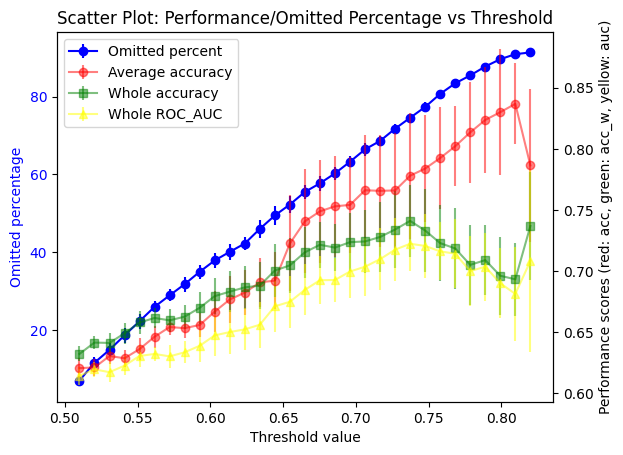

In [ ]:
# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

###### Scatter plot

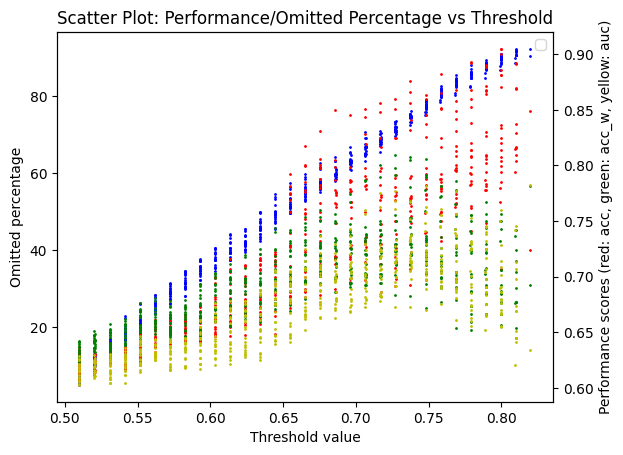

In [ ]:
# Scatter plot (Since the error is too small to show)
fig, ax1 = plt.subplots()

# Plot the first dataset with error bars
for y in o_p_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax1.scatter(x, y, color='b',s=1)

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with the same y-axis
for y in acc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='r',s=1)
for y in acc_w_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='g',s=1)
for y in auc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='y',s=1)

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

Todos: transfer y sets to draw error bar curves

In [ ]:
l = max(map(o_p_tl_a,len))

##### 20 Runs Error-bar: svm_noP

In [ ]:
# Collect data from 20 runs and test different thresholds
import csv
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [element for element in row]
            data.append(row_data)
    return data
import ast
def convert_to_dict(entry):
    ordered_dict_str = entry.replace("OrderedDict", "")  # Remove 'OrderedDict' to have a valid dictionary string
    ordered_dict = ast.literal_eval(ordered_dict_str)
    return dict(ordered_dict)
converted_paras_ll = []
for i in range(20):
  path = f"{base}svm_odata_noP/best_params_{i}.csv"
  paras_l = read_csv(path)
  paras_l = paras_l[0]
  converted_paras_l = [convert_to_dict(entry) for entry in paras_l]
  converted_paras_ll.append(converted_paras_l)
print(np.shape(converted_paras_ll))

In [ ]:
acc_w_tl_a = []
acc_tl_a = []
auc_tl_a = []
o_p_tl_a = []
for n_run in range(20):
  print(f'%Run {n_run}')
  acc_tl = []
  acc_w_tl = []
  auc_tl = []
  o_p_tl = []
  o_p_all = 0
  thres = 0.51
  converted_paras_l = converted_paras_ll[n_run]
  while o_p_all < 90:
    print(thres)
    acc_scores = []
    n = 1
    yhat_all = []
    ytrue_all = []
    # o_p_l = []
    for i in range(len(testlist)):
      print(f"Fold {i}; ")
      paras = converted_paras_l[i]
      #1 Build training, validation and test sets/Extract individual index list
      train_v_indexes = trainlist[i]
      val_indexes = vlist[i]
      test_indexes = testlist[i]
      X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
      X_test, y_test= X[test_indexes], Y[test_indexes]
      # print(f"training+validation index: {len(train_v_indexes)}; ", #{train_v_indexes},
      #     f"testing index: {len(test_indexes)}") #{test_indexes},

      #2 Use train and validation indexes to create the custom split
      # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
      custom_split = [-1] * len(train_v_indexes)
      for j, x in enumerate(train_v_indexes):
        if x in val_indexes: custom_split[j] = 0
      # Initialize the PredefinedSplit object
      ps = PredefinedSplit(test_fold=custom_split)

      #3 Create model with paras found by former BayesSearch
      model = create_svm_model(**paras)
      model.fit(X_train, y_train)
      yhat = model.predict_proba(X_test)

      #6 Calculate and store
      acc, o_p = prob_acc(y_test, yhat, thres)
      # auc = roc_auc_score(y_test, yhat)
      acc_scores.append(acc)
      # o_p_l.append(o_p)
      ytrue_all.append(y_test)
      yhat_all.append(yhat)
      # auc_scores.append(auc)
      # print("Iteration Accuray: {:.2f}%".format(100*acc))
      # print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
      n+=1
    # a+=0.001
    thres = thres+0.01
    #For one thres
    #7 Results for all testing folds
    # print("Average Accuray: {:.2f}%".format(100*np.mean(acc_scores)))
    ytrue_all = np.concatenate(ytrue_all)
    yhat_all= np.concatenate(yhat_all)
    acc_w, o_p_all = prob_acc(ytrue_all, yhat_all, thres)
    auc, _ =  prob_auc(ytrue_all, yhat_all, thres)
    # Filter nan in acc
    nan_indices = np.argwhere(np.isnan(acc_scores)).flatten()#.tolist()
    acc_scores = [acc_scores[i] for i in range(len(acc_scores)) if not i in nan_indices]
    #
    acc_ave = np.mean(acc_scores)
    acc_w_tl.append(acc_w)
    acc_tl.append(acc_ave)
    auc_tl.append(auc)
    o_p_tl.append(o_p_all)
    print("Average Accuray: {:.2f}%".format(100*acc_ave))
    print("Whole Accuracy: {:.2f}%, Percentage of Data Omitted: \
        {:.2f}%".format(acc_w * 100, o_p_all))
    print("Whole AUC: {:.4f}%".format(auc))
  acc_w_tl_a.append(acc_w_tl)
  acc_tl_a.append(acc_tl)
  auc_tl_a.append(auc_tl)
  o_p_tl_a.append(o_p_tl)
print(np.shape(acc_w_tl_a),np.shape(acc_tl_a),np.shape(auc_tl_a),np.shape(o_p_tl_a))

In [ ]:
base_path1 = f"{base}svm_odata_pop/"
## Read/save functions
def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in data:
            csv_writer.writerow(row)

# path = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/Fold8_yhat_l.csv"
def read_csv(file_path):
    data = []
    with open(file_path, 'r', newline='') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            # Convert elements from strings to integers (or other types if needed)
            row_data = [float(element) for element in row]
            data.append(row_data)
    return data
write_to_csv(f"{base_path1}acc_tl_a.csv", acc_tl_a)
write_to_csv(f"{base_path1}acc_w_tl_a.csv", acc_w_tl_a)
write_to_csv(f"{base_path1}auc_tl_a.csv", auc_tl_a)
write_to_csv(f"{base_path1}o_p_tl_a.csv", o_p_tl_a)

data0 = read_csv(f"{base_path1}o_p_tl_a.csv")
data1 = read_csv(f"{base_path1}acc_tl_a.csv")
data2 = read_csv(f"{base_path1}acc_w_tl_a.csv")
data3 = read_csv(f"{base_path1}auc_tl_a.csv")
# data0

In [ ]:
for x in data0:
  print(x)

In [ ]:
l = max(map(len, data0))
data0p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data0 if len(x)>=n+1]
  # print(len(all_y))
  data0p.append(all_y)
# print(np.shape(data0p))

In [ ]:
data0p_arr = np.array(data0p)
print(np.shape(data0p_arr))
y0 = [np.mean(x) for x in data0p_arr]
print(np.shape(y0))
print(y0)
err0 = [np.std(x) for x in data0p_arr]
print(np.shape(err0))
print(err0)

In [ ]:
l = max(map(len, data1))
data1p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data1 if len(x)>=n+1]
  # print(len(all_y))
  data1p.append(all_y)
# print(np.shape(data1p))
data1p_arr = np.array(data1p)
y1 = [np.mean(x) for x in data1p_arr]
err1 = [np.std(x) for x in data1p_arr]

In [ ]:
l = max(map(len, data2))
data2p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data2 if len(x)>=n+1]
  # print(len(all_y))
  data2p.append(all_y)
# print(np.shape(data2p))
data2p_arr = np.array(data2p)
y2 = [np.mean(x) for x in data2p_arr]
err2 = [np.std(x) for x in data2p_arr]

In [ ]:
l = max(map(len, data3))
data3p = []
for n in range(l):
  # print(n)
  all_y = [x[n] for x in data3 if len(x)>=n+1]
  # print(len(all_y))
  data3p.append(all_y)
# print(np.shape(data3p))
data3p_arr = np.array(data3p)
y3 = [np.mean(x) for x in data3p_arr]
err3 = [np.std(x) for x in data3p_arr]

In [ ]:
# X-axis
x = np.linspace(0.51,0.51+0.01*l,l)

# Create the main figure and the first axis
fig, ax1 = plt.subplots()

# Plot the first dataset with shaded error region
ax1.errorbar(x, y0, yerr=err0, label='Omitted percent', fmt='o-', color='b')
# ax1.fill_between(x, y0 - err0, y0 + err0, alpha=0.2, color='b')
# ax1.tick_params(axis='y',labelcolor='b')

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with shaded error regions
ax2.errorbar(x, y1, yerr=err1, label='Average accuracy', fmt='o-', color='r', alpha = 0.5)
# ax2.fill_between(x, y1 - err1, y1 + err1, alpha=0.2, color='r')
ax2.errorbar(x, y2, yerr=err2, label='Whole accuracy', marker='s', color='g', alpha = 0.5)
# ax2.fill_between(x, y2 - err2, y2 + err2, alpha=0.2, color='g')
ax2.errorbar(x, y3, yerr=err3, label='Whole ROC_AUC', marker='^', color='yellow', alpha = 0.5)
# ax2.fill_between(x, y3 - err3, y3 + err3, alpha=0.2, color='y')

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage',color='b')
ax1.tick_params(axis='y',labelcolor='b')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Show and save
plt.show()
fig.savefig(f"{base}gb_S_thres.png")

###### Scatter plot

In [ ]:
# Scatter plot (Since the error is too small to show)
fig, ax1 = plt.subplots()

# Plot the first dataset with error bars
for y in o_p_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax1.scatter(x, y, color='b',s=1)

# Create a twin axis sharing the xaxis
ax2 = ax1.twinx()

# Plot the second and third datasets with the same y-axis
for y in acc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='r',s=1)
for y in acc_w_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='g',s=1)
for y in auc_tl_a:
  x = np.linspace(0.51,0.51+0.01*len(y),len(y))
  ax2.scatter(x, y, color='y',s=1)

# Set labels and titles
ax1.set_xlabel('Threshold value')
ax1.set_ylabel('Omitted percentage')
ax2.set_ylabel('Performance scores (red: acc, green: acc_w, yellow: auc)')
plt.title('Scatter Plot: Performance/Omitted Percentage vs Threshold')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show the plot
plt.show()

Todos: transfer y sets to draw error bar curves

In [ ]:
l = max(map(o_p_tl_a,len))